In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 10

In [5]:
seed = 3121
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  W9TG7ZON_06_36_31
NN-MODEL FILENAME:  ./models/W9TG7ZON_06_36_31_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-4  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [11]:
MAX_NO_OF_ITERATIONS = 100
MAX_NN_ITERATIONS    = 5000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  100


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((node_id%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = int(node_id%2)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1234.28 MiB, increment: 1014.02 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 17804 EXPERIENCES:0:00:00.813222


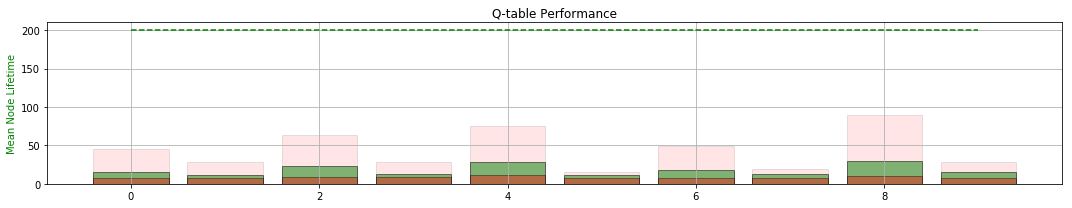

MEMORY COUNTER:  17804
Training Neural Network for 5000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 7.091	LOSS : 7.745	LOSS : 6.636	LOSS : 6.344	LOSS : 6.436	LOSS : 6.640	LOSS : 6.787	LOSS : 6.898	LOSS : 6.699	LOSS : 6.388	
Validating... MEAN TIME:  18.545
LOSS : 6.769	LOSS : 7.172	LOSS : 6.689	LOSS : 6.435	LOSS : 6.289	LOSS : 7.208	LOSS : 5.694	LOSS : 5.944	LOSS : 5.977	LOSS : 5.166	
Validating... MEAN TIME:  35.535
LOSS : 6.326	LOSS : 5.840	LOSS : 6.627	LOSS : 6.088	LOSS : 5.337	LOSS : 7.573	LOSS : 5.871	LOSS : 6.068	LOSS : 5.996	LOSS : 6.142	
Validating... MEAN TIME:  41.305
LOSS : 6.188	LOSS : 5.922	LOSS : 6.322	LOSS : 6.137	LOSS : 7.170	LOSS : 5.915	LOSS : 5.855	LOSS : 5.766	LOSS : 6.288	LOSS : 5.552	
Validating... MEAN TIME:  41.955
LOSS : 6.246	LOSS : 5.934	LOSS : 6.235	LOSS : 6.663	LOSS : 6.094	LOSS : 6.024	LOSS : 5.520	LOSS : 6.302	LOSS : 6.607	LOSS : 5.856	
Validating... MEAN TIME:  50.46
TRAINING TIME:0:00:12.734726


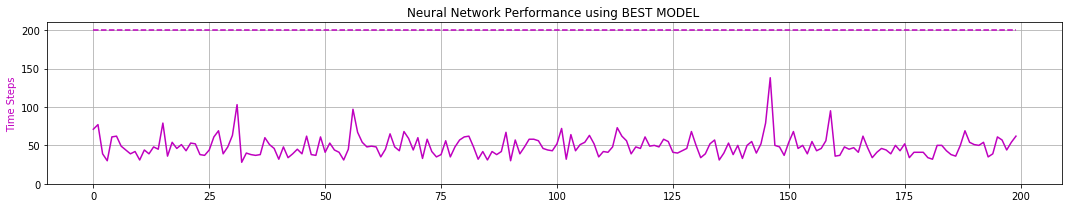

peak memory: 1347.31 MiB, increment: 1036.15 MiB
0 -max- [ 0.071  0.753  0.209  2.897]
0 -min- [-0.238 -1.951 -0.078 -1.061]

1 -max- [ 0.218  1.795  0.050  0.047]
1 -min- [-0.050 -0.171 -0.209 -2.763]

2 -max- [ 0.127  0.773  0.208  2.574]
2 -min- [-0.472 -2.304 -0.209 -1.495]

3 -max- [ 0.196  1.736  0.049  0.324]
3 -min- [-0.048 -0.204 -0.209 -2.699]

4 -max- [ 0.162  0.830  0.208  2.242]
4 -min- [-0.355 -1.699 -0.209 -1.723]

5 -max- [ 0.199  1.923  0.050  0.050]
5 -min- [-0.050 -0.050 -0.208 -2.981]

6 -max- [ 0.071  0.571  0.209  3.032]
6 -min- [-0.355 -2.105 -0.102 -0.925]

7 -max- [ 0.215  1.710  0.050  0.153]
7 -min- [-0.051 -0.186 -0.209 -2.639]

8 -max- [ 0.151  0.997  0.209  2.397]
8 -min- [-0.467 -1.736 -0.209 -1.797]

9 -max- [ 0.188  1.546  0.049  0.248]
9 -min- [-0.049 -0.332 -0.209 -2.492]

Quantization TIME:  0.01 minutes


ITERATION # 1
SMALLEST TIMESTEP in ITERATION 1: 9
REAL TIME TO GENERATE 32308 EXPERIENCES:0:00:01.180832


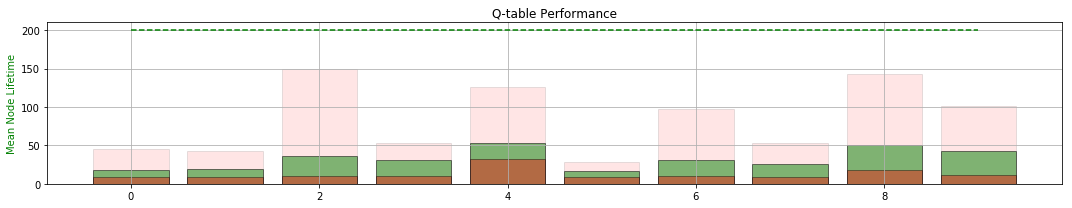

MEMORY COUNTER:  50112
Training Neural Network for 5000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 4.726	LOSS : 4.395	LOSS : 4.696	LOSS : 4.232	LOSS : 4.477	LOSS : 4.929	LOSS : 4.529	LOSS : 4.163	LOSS : 4.487	LOSS : 4.242	
Validating... MEAN TIME:  70.125
LOSS : 4.339	LOSS : 4.679	LOSS : 4.200	LOSS : 4.322	LOSS : 4.996	LOSS : 3.907	LOSS : 4.456	LOSS : 4.276	LOSS : 4.542	LOSS : 4.106	
Validating... MEAN TIME:  74.75
LOSS : 4.555	LOSS : 3.896	LOSS : 4.282	LOSS : 4.605	LOSS : 4.514	LOSS : 4.407	LOSS : 4.333	LOSS : 3.997	LOSS : 4.675	LOSS : 4.830	
Validating... MEAN TIME:  79.82
LOSS : 4.144	LOSS : 4.188	LOSS : 4.156	LOSS : 4.201	LOSS : 4.611	LOSS : 4.134	LOSS : 4.515	LOSS : 4.501	LOSS : 4.141	LOSS : 4.106	
Validating... MEAN TIME:  89.915
LOSS : 4.662	LOSS : 4.968	LOSS : 3.954	LOSS : 4.922	LOSS : 4.076	LOSS : 4.401	LOSS : 3.942	LOSS : 4.264	LOSS : 4.284	LOSS : 3.528	
Validating... MEAN TIME:  123.265
TRAINING TIME:0:00:22.380652


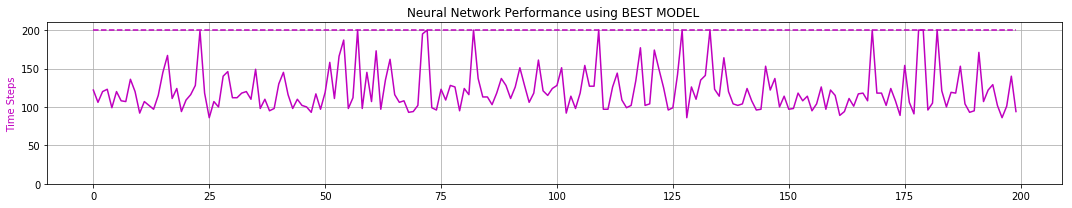

peak memory: 1408.63 MiB, increment: 1083.66 MiB
0 -max- [ 0.055  0.524  0.209  2.731]
0 -min- [-0.238 -1.983 -0.059 -0.523]

1 -max- [ 0.234  1.724  0.049  0.291]
1 -min- [-0.048 -0.521 -0.209 -2.717]

2 -max- [ 0.076  0.576  0.209  2.477]
2 -min- [-0.671 -1.720 -0.208 -1.509]

3 -max- [ 0.199  1.368  0.050  0.327]
3 -min- [-0.130 -0.763 -0.209 -2.146]

4 -max- [ 0.175  0.572  0.209  1.938]
4 -min- [-0.336 -1.315 -0.209 -1.300]

5 -max- [ 0.228  1.593  0.050  0.297]
5 -min- [-0.050 -0.197 -0.209 -2.513]

6 -max- [ 0.056  0.575  0.209  2.869]
6 -min- [-1.246 -3.405 -0.209 -1.341]

7 -max- [ 0.247  1.391  0.048  0.329]
7 -min- [-0.057 -0.715 -0.209 -2.189]

8 -max- [ 0.082  0.573  0.209  1.977]
8 -min- [-0.574 -1.305 -0.209 -1.385]

9 -max- [ 0.251  0.982  0.208  1.229]
9 -min- [-0.127 -1.067 -0.209 -1.992]

Quantization TIME:  0.01 minutes


ITERATION # 2
SMALLEST TIMESTEP in ITERATION 2: 9
REAL TIME TO GENERATE 55284 EXPERIENCES:0:00:02.056711


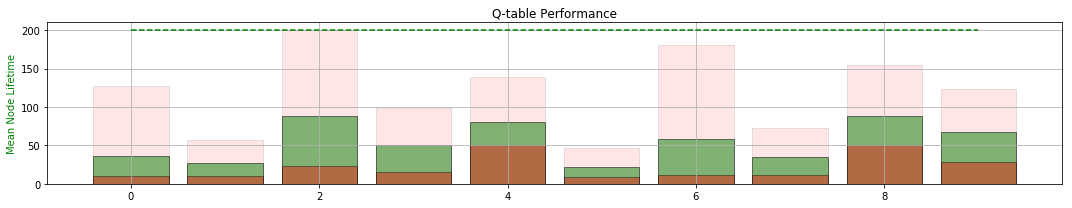

MEMORY COUNTER:  105396
Training Neural Network for 5000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.873	LOSS : 3.504	LOSS : 2.876	LOSS : 2.985	LOSS : 3.506	LOSS : 3.448	LOSS : 3.090	LOSS : 2.792	LOSS : 3.393	LOSS : 3.884	
Validating... MEAN TIME:  147.09
LOSS : 2.731	LOSS : 2.929	LOSS : 3.066	LOSS : 2.958	LOSS : 3.184	LOSS : 3.134	LOSS : 2.991	LOSS : 2.985	LOSS : 2.528	LOSS : 3.054	
Validating... MEAN TIME:  139.9
LOSS : 2.948	LOSS : 2.715	LOSS : 3.118	LOSS : 2.733	LOSS : 2.975	LOSS : 2.687	LOSS : 2.789	LOSS : 2.755	LOSS : 3.144	LOSS : 3.624	
Validating... MEAN TIME:  124.88
LOSS : 3.246	LOSS : 3.209	LOSS : 3.336	LOSS : 3.906	LOSS : 3.117	LOSS : 3.276	LOSS : 2.875	LOSS : 3.134	LOSS : 2.970	LOSS : 2.847	
Validating... MEAN TIME:  189.675
LOSS : 2.936	LOSS : 2.803	LOSS : 3.499	LOSS : 2.965	LOSS : 2.889	LOSS : 3.163	LOSS : 2.994	LOSS : 2.745	LOSS : 2.883	LOSS : 3.322	
Validating... MEAN TIME:  149.43
TRAINING TIME:0:00:33.368097


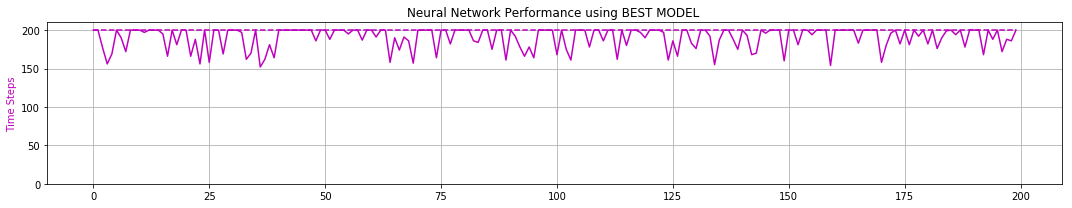

peak memory: 1377.08 MiB, increment: 1027.35 MiB
0 -max- [ 0.227  0.786  0.209  2.472]
0 -min- [-1.400 -2.029 -0.193 -1.217]

1 -max- [ 0.229  1.351  0.049  0.369]
1 -min- [-0.286 -1.295 -0.209 -2.170]

2 -max- [ 0.457  0.774  0.209  2.210]
2 -min- [-1.603 -2.047 -0.209 -1.694]

3 -max- [ 0.194  0.834  0.050  0.388]
3 -min- [-0.530 -1.452 -0.209 -1.411]

4 -max- [ 0.266  0.431  0.054  0.810]
4 -min- [-0.931 -1.815 -0.209 -0.804]

5 -max- [ 0.255  1.405  0.050  0.337]
5 -min- [-0.101 -0.887 -0.209 -2.315]

6 -max- [ 0.349  0.780  0.209  2.163]
6 -min- [-1.337 -2.507 -0.209 -1.381]

7 -max- [ 0.218  1.006  0.049  0.369]
7 -min- [-0.433 -1.443 -0.209 -1.628]

8 -max- [ 0.569  0.689  0.208  1.145]
8 -min- [-1.265 -2.030 -0.209 -1.144]

9 -max- [ 0.186  0.622  0.046  0.400]
9 -min- [-0.874 -1.792 -0.209 -0.948]

Quantization TIME:  0.01 minutes


ITERATION # 3
SMALLEST TIMESTEP in ITERATION 3: 9
REAL TIME TO GENERATE 89901 EXPERIENCES:0:00:02.659284


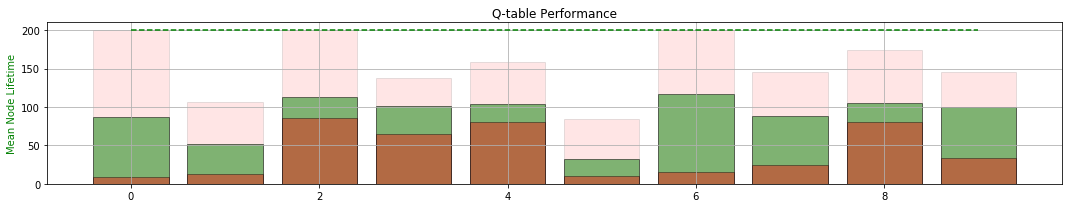

MEMORY COUNTER:  195297
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.919	LOSS : 2.020	LOSS : 2.485	LOSS : 2.141	LOSS : 2.257	LOSS : 2.364	LOSS : 2.417	LOSS : 2.288	LOSS : 2.659	LOSS : 2.102	
Validating... MEAN TIME:  198.055
LOSS : 2.007	LOSS : 2.431	LOSS : 2.193	LOSS : 2.302	LOSS : 2.372	LOSS : 2.313	LOSS : 2.402	LOSS : 1.668	LOSS : 2.306	LOSS : 1.924	
Validating... MEAN TIME:  178.365
LOSS : 2.511	LOSS : 2.353	LOSS : 2.096	LOSS : 2.409	LOSS : 1.986	LOSS : 2.130	LOSS : 2.119	LOSS : 2.231	LOSS : 2.510	LOSS : 2.489	
Validating... MEAN TIME:  181.85
LOSS : 2.693	LOSS : 2.295	LOSS : 2.455	LOSS : 2.105	LOSS : 2.475	LOSS : 1.942	LOSS : 2.287	LOSS : 2.353	LOSS : 2.114	LOSS : 1.940	
Validating... MEAN TIME:  199.68
LOSS : 2.308	LOSS : 2.142	LOSS : 2.325	LOSS : 2.528	LOSS : 2.551	LOSS : 2.446	LOSS : 2.430	LOSS : 1.823	LOSS : 1.864	LOSS : 3.018	
Validating... MEAN TIME:  196.74
TRAINING TIME:0:00:40.777227


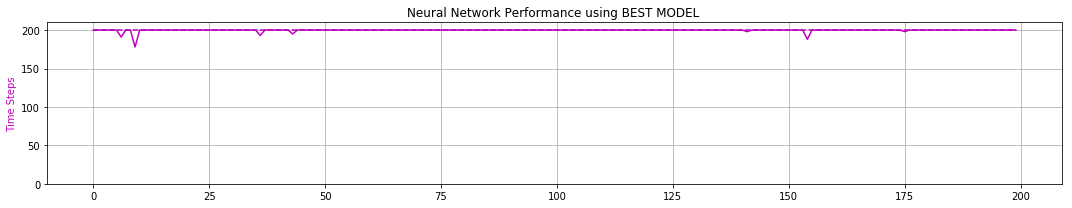

peak memory: 1395.57 MiB, increment: 1005.77 MiB
0 -max- [ 0.754  1.133  0.209  2.266]
0 -min- [-1.943 -2.354 -0.209 -1.385]

1 -max- [ 0.196  0.965  0.050  0.401]
1 -min- [-1.412 -2.342 -0.209 -1.753]

2 -max- [ 0.777  0.696  0.202  0.910]
2 -min- [-1.796 -2.388 -0.209 -1.092]

3 -max- [ 0.193  0.574  0.050  0.419]
3 -min- [-1.548 -2.197 -0.209 -1.100]

4 -max- [ 0.216  0.432  0.050  0.928]
4 -min- [-1.602 -2.196 -0.209 -0.786]

5 -max- [ 0.207  1.391  0.048  0.397]
5 -min- [-0.995 -2.060 -0.209 -2.150]

6 -max- [ 0.757  1.276  0.208  1.447]
6 -min- [-1.835 -2.421 -0.209 -1.106]

7 -max- [ 0.210  0.926  0.050  0.412]
7 -min- [-1.552 -2.350 -0.209 -1.401]

8 -max- [ 0.221  0.429  0.046  0.868]
8 -min- [-1.621 -2.193 -0.209 -0.697]

9 -max- [ 0.200  0.584  0.051  0.414]
9 -min- [-1.518 -2.186 -0.209 -1.304]

Quantization TIME:  0.01 minutes


ITERATION # 4
SMALLEST TIMESTEP in ITERATION 4: 15
REAL TIME TO GENERATE 116853 EXPERIENCES:0:00:03.195277


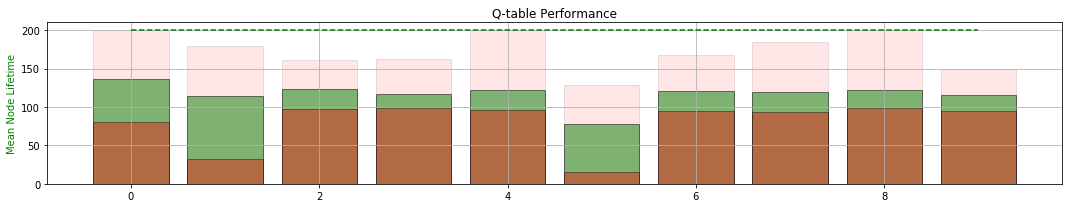

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.493	LOSS : 1.598	LOSS : 1.757	LOSS : 1.665	LOSS : 1.253	LOSS : 1.529	LOSS : 1.865	LOSS : 1.726	LOSS : 1.677	LOSS : 1.458	
Validating... MEAN TIME:  200.0
LOSS : 1.332	LOSS : 1.638	LOSS : 1.340	LOSS : 1.549	LOSS : 1.417	LOSS : 2.034	LOSS : 1.595	LOSS : 1.356	LOSS : 1.758	LOSS : 1.984	
Validating... MEAN TIME:  199.58
LOSS : 1.921	LOSS : 1.576	LOSS : 1.627	LOSS : 1.510	LOSS : 1.567	LOSS : 2.017	LOSS : 1.780	LOSS : 1.447	LOSS : 1.504	LOSS : 1.545	
Validating... MEAN TIME:  200.0
LOSS : 1.193	LOSS : 1.499	LOSS : 1.501	LOSS : 1.300	LOSS : 1.679	LOSS : 1.716	LOSS : 1.705	LOSS : 1.647	LOSS : 1.943	LOSS : 1.552	
Validating... MEAN TIME:  200.0
LOSS : 1.613	LOSS : 1.485	LOSS : 2.265	LOSS : 1.982	LOSS : 1.622	LOSS : 1.621	LOSS : 1.663	LOSS : 1.472	LOSS : 1.742	LOSS : 1.879	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:41.968717


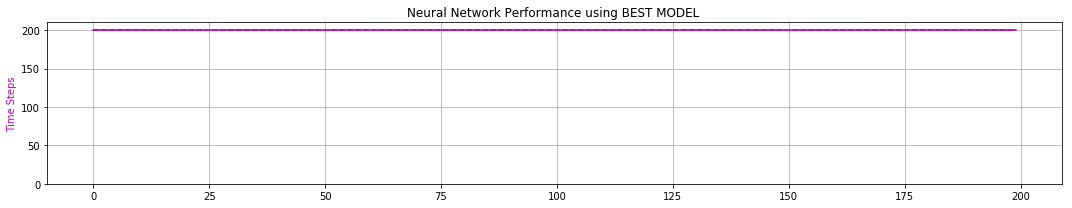

peak memory: 1461.93 MiB, increment: 1017.72 MiB
0 -max- [ 1.354  1.412  0.207  1.539]
0 -min- [-1.976 -2.148 -0.209 -1.109]

1 -max- [ 0.182  0.622  0.050  0.602]
1 -min- [-2.095 -2.357 -0.209 -1.416]

2 -max- [ 0.202  0.432  0.050  0.937]
2 -min- [-1.967 -2.136 -0.209 -1.098]

3 -max- [ 0.204  0.624  0.050  0.615]
3 -min- [-2.011 -2.196 -0.209 -1.457]

4 -max- [ 0.212  0.434  0.048  0.778]
4 -min- [-1.952 -2.140 -0.209 -1.102]

5 -max- [ 0.198  0.997  0.049  0.700]
5 -min- [-2.205 -2.723 -0.209 -1.689]

6 -max- [ 0.207  0.424  0.050  0.813]
6 -min- [-1.900 -2.017 -0.209 -1.093]

7 -max- [ 0.198  0.612  0.046  0.607]
7 -min- [-2.084 -2.201 -0.209 -1.410]

8 -max- [ 0.253  0.429  0.051  0.739]
8 -min- [-1.852 -1.953 -0.209 -1.095]

9 -max- [ 0.210  0.628  0.046  0.615]
9 -min- [-2.038 -2.189 -0.209 -1.363]

Quantization TIME:  0.01 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 33
REAL TIME TO GENERATE 122976 EXPERIENCES:0:00:03.113743


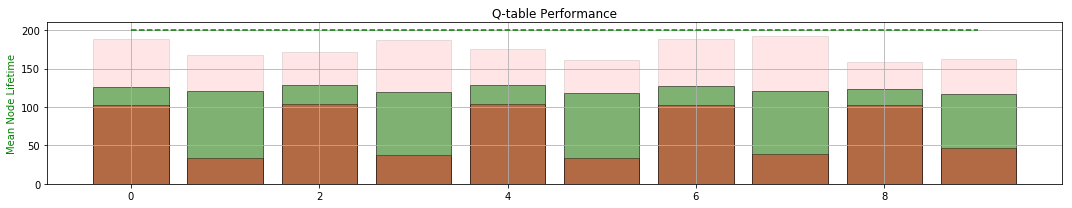

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.229	LOSS : 1.057	LOSS : 1.061	LOSS : 1.359	LOSS : 1.467	LOSS : 1.191	LOSS : 1.150	LOSS : 1.040	LOSS : 0.646	LOSS : 1.004	
Validating... MEAN TIME:  200.0
LOSS : 0.993	LOSS : 1.204	LOSS : 0.792	LOSS : 1.182	LOSS : 0.977	LOSS : 0.797	LOSS : 1.077	LOSS : 0.921	LOSS : 0.965	LOSS : 1.011	
Validating... MEAN TIME:  200.0
LOSS : 1.069	LOSS : 1.460	LOSS : 0.966	LOSS : 0.957	LOSS : 0.766	LOSS : 1.186	LOSS : 0.949	LOSS : 0.954	LOSS : 1.182	LOSS : 1.188	
Validating... MEAN TIME:  200.0
LOSS : 1.098	LOSS : 1.366	LOSS : 1.247	LOSS : 1.224	LOSS : 0.970	LOSS : 1.096	LOSS : 1.118	LOSS : 1.106	LOSS : 1.058	LOSS : 1.156	
Validating... MEAN TIME:  199.49
LOSS : 1.214	LOSS : 1.265	LOSS : 0.959	LOSS : 1.136	LOSS : 1.148	LOSS : 1.140	LOSS : 1.130	LOSS : 1.191	LOSS : 0.948	LOSS : 1.219	
Validating... MEAN TIME:  162.435
TRAINING TIME:0:00:40.994801


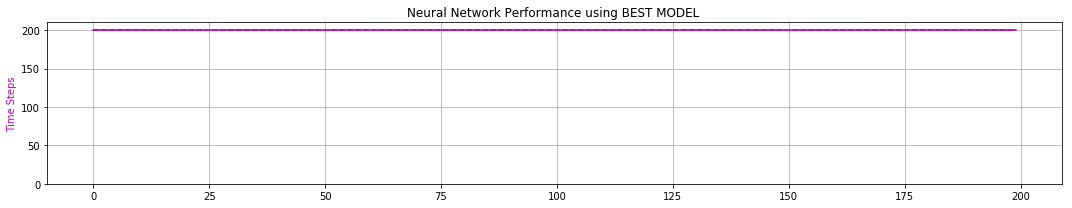

peak memory: 1398.49 MiB, increment: 1017.26 MiB
0 -max- [ 0.185  0.423  0.059  0.944]
0 -min- [-2.400 -2.444 -0.208 -1.093]

1 -max- [ 0.202  0.616  0.050  0.723]
1 -min- [-2.400 -2.440 -0.208 -1.300]

2 -max- [ 0.216  0.432  0.051  1.087]
2 -min- [-2.400 -2.451 -0.208 -1.102]

3 -max- [ 0.205  0.621  0.048  0.729]
3 -min- [-2.400 -2.443 -0.208 -1.082]

4 -max- [ 0.227  0.418  0.077  0.955]
4 -min- [-2.400 -2.439 -0.209 -1.097]

5 -max- [ 0.213  0.607  0.052  0.720]
5 -min- [-2.400 -2.436 -0.207 -1.366]

6 -max- [ 0.212  0.428  0.046  0.937]
6 -min- [-2.399 -2.442 -0.205 -1.104]

7 -max- [ 0.200  0.748  0.051  0.721]
7 -min- [-2.400 -2.543 -0.209 -1.085]

8 -max- [ 0.239  0.433  0.052  0.965]
8 -min- [-2.400 -2.580 -0.209 -1.092]

9 -max- [ 0.179  0.578  0.048  0.724]
9 -min- [-2.400 -2.595 -0.208 -1.383]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 26
REAL TIME TO GENERATE 119985 EXPERIENCES:0:00:03.028715


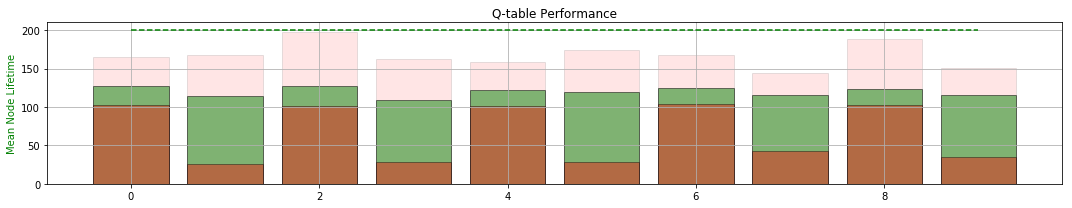

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.312	LOSS : 0.938	LOSS : 1.150	LOSS : 0.970	LOSS : 1.019	LOSS : 0.861	LOSS : 0.825	LOSS : 0.946	LOSS : 0.746	LOSS : 1.208	
Validating... MEAN TIME:  172.61
LOSS : 0.896	LOSS : 1.123	LOSS : 1.205	LOSS : 0.825	LOSS : 1.053	LOSS : 1.017	LOSS : 1.011	LOSS : 1.102	LOSS : 0.959	LOSS : 1.041	
Validating... MEAN TIME:  143.71
LOSS : 0.966	LOSS : 0.941	LOSS : 0.944	LOSS : 1.001	LOSS : 1.304	LOSS : 1.121	LOSS : 0.966	LOSS : 1.073	LOSS : 0.905	LOSS : 0.966	
Validating... MEAN TIME:  137.75
LOSS : 0.800	LOSS : 0.880	LOSS : 0.844	LOSS : 1.078	LOSS : 1.028	LOSS : 0.603	LOSS : 1.070	LOSS : 0.737	LOSS : 0.921	LOSS : 0.728	
Validating... MEAN TIME:  128.625
LOSS : 1.063	LOSS : 1.192	LOSS : 0.768	LOSS : 0.907	LOSS : 0.773	LOSS : 1.152	LOSS : 0.704	LOSS : 1.040	LOSS : 0.930	LOSS : 1.005	
Validating... MEAN TIME:  130.4
TRAINING TIME:0:00:31.875792


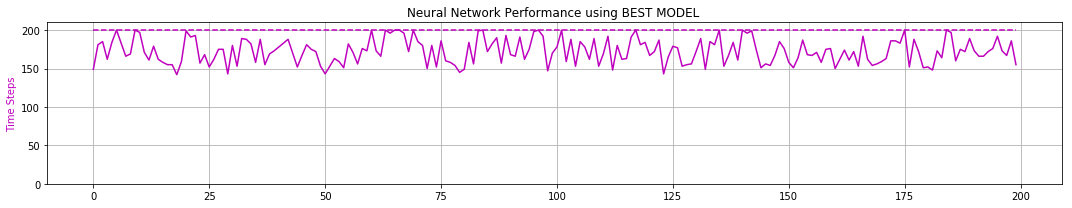

peak memory: 1437.05 MiB, increment: 1016.26 MiB
0 -max- [ 0.220  0.432  0.065  0.918]
0 -min- [-2.400 -2.724 -0.192 -0.832]

1 -max- [ 0.216  0.579  0.050  0.704]
1 -min- [-2.400 -2.711 -0.209 -0.988]

2 -max- [ 0.214  0.434  0.069  0.953]
2 -min- [-2.400 -2.790 -0.208 -0.774]

3 -max- [ 0.202  0.758  0.049  0.715]
3 -min- [-2.400 -2.785 -0.209 -1.174]

4 -max- [ 0.210  0.424  0.065  0.894]
4 -min- [-2.400 -2.621 -0.193 -0.956]

5 -max- [ 0.201  0.607  0.046  0.722]
5 -min- [-2.400 -2.728 -0.209 -1.057]

6 -max- [ 0.200  0.429  0.076  0.957]
6 -min- [-2.400 -2.821 -0.190 -1.002]

7 -max- [ 0.206  0.587  0.046  0.720]
7 -min- [-2.399 -2.738 -0.205 -1.003]

8 -max- [ 0.194  0.421  0.064  0.826]
8 -min- [-2.400 -2.539 -0.200 -1.047]

9 -max- [ 0.220  0.622  0.050  0.690]
9 -min- [-2.400 -2.731 -0.208 -0.832]

Quantization TIME:  0.01 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 31
REAL TIME TO GENERATE 86364 EXPERIENCES:0:00:02.194455


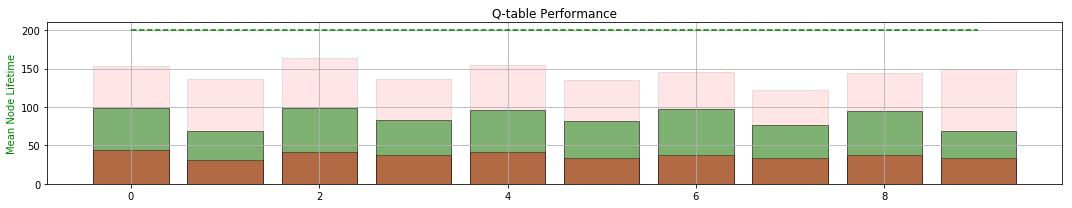

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.171	LOSS : 1.029	LOSS : 0.877	LOSS : 1.073	LOSS : 1.312	LOSS : 1.104	LOSS : 1.048	LOSS : 1.129	LOSS : 1.008	LOSS : 1.268	
Validating... MEAN TIME:  126.965
LOSS : 1.001	LOSS : 1.040	LOSS : 1.079	LOSS : 0.865	LOSS : 1.563	LOSS : 0.895	LOSS : 0.842	LOSS : 1.351	LOSS : 1.009	LOSS : 1.355	
Validating... MEAN TIME:  125.85
LOSS : 0.999	LOSS : 1.102	LOSS : 1.127	LOSS : 1.029	LOSS : 1.396	LOSS : 0.944	LOSS : 0.838	LOSS : 0.946	LOSS : 1.489	LOSS : 1.196	
Validating... MEAN TIME:  123.915
LOSS : 1.334	LOSS : 0.956	LOSS : 1.127	LOSS : 1.049	LOSS : 1.019	LOSS : 0.940	LOSS : 1.286	LOSS : 1.117	LOSS : 1.198	LOSS : 1.047	
Validating... MEAN TIME:  124.375
LOSS : 0.970	LOSS : 0.866	LOSS : 1.395	LOSS : 1.021	LOSS : 0.875	LOSS : 0.999	LOSS : 0.906	LOSS : 0.938	LOSS : 1.030	LOSS : 1.158	
Validating... MEAN TIME:  116.47
TRAINING TIME:0:00:27.974880


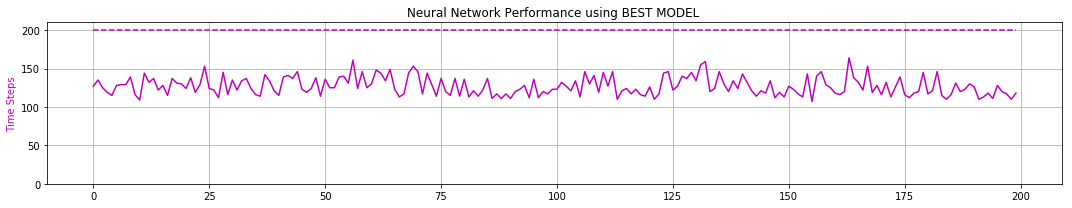

peak memory: 1399.22 MiB, increment: 962.29 MiB
0 -max- [ 0.158  0.438  0.050  1.099]
0 -min- [-2.400 -3.324 -0.209 -0.606]

1 -max- [ 0.151  0.633  0.048  0.695]
1 -min- [-2.399 -3.173 -0.209 -1.005]

2 -max- [ 0.141  0.561  0.049  0.965]
2 -min- [-2.399 -3.175 -0.209 -0.729]

3 -max- [ 0.158  0.576  0.050  0.709]
3 -min- [-2.399 -3.338 -0.209 -1.170]

4 -max- [ 0.142  0.533  0.046  0.705]
4 -min- [-2.399 -3.152 -0.209 -0.732]

5 -max- [ 0.168  0.566  0.051  0.711]
5 -min- [-2.399 -3.150 -0.209 -0.882]

6 -max- [ 0.167  0.436  0.046  0.933]
6 -min- [-2.398 -3.153 -0.209 -0.613]

7 -max- [ 0.147  0.445  0.048  0.710]
7 -min- [-2.399 -2.988 -0.209 -0.938]

8 -max- [ 0.166  0.438  0.050  0.964]
8 -min- [-2.400 -3.159 -0.209 -0.601]

9 -max- [ 0.148  0.804  0.050  0.693]
9 -min- [-2.399 -3.130 -0.209 -1.171]

Quantization TIME:  0.01 minutes


ITERATION # 8
SMALLEST TIMESTEP in ITERATION 8: 25
REAL TIME TO GENERATE 42356 EXPERIENCES:0:00:01.066314


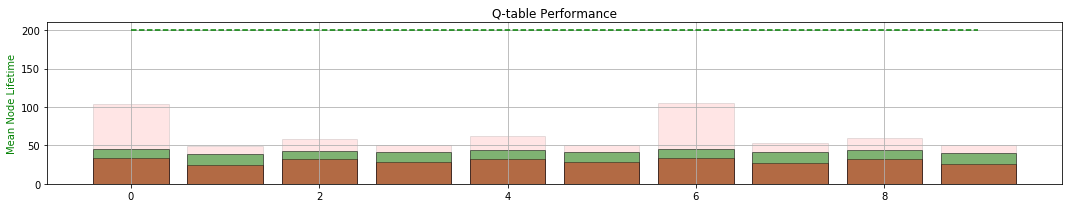

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.254	LOSS : 1.411	LOSS : 1.203	LOSS : 1.311	LOSS : 1.272	LOSS : 1.313	LOSS : 1.252	LOSS : 1.395	LOSS : 1.255	LOSS : 1.472	
Validating... MEAN TIME:  110.845
LOSS : 1.419	LOSS : 1.385	LOSS : 1.508	LOSS : 1.934	LOSS : 1.207	LOSS : 1.230	LOSS : 1.660	LOSS : 1.410	LOSS : 1.088	LOSS : 1.469	
Validating... MEAN TIME:  116.59
LOSS : 0.953	LOSS : 1.356	LOSS : 1.548	LOSS : 1.231	LOSS : 1.142	LOSS : 1.094	LOSS : 1.171	LOSS : 1.227	LOSS : 1.336	LOSS : 1.249	
Validating... MEAN TIME:  121.575
LOSS : 1.416	LOSS : 1.302	LOSS : 1.416	LOSS : 1.407	LOSS : 1.431	LOSS : 1.447	LOSS : 1.523	LOSS : 1.172	LOSS : 0.941	LOSS : 1.065	
Validating... MEAN TIME:  149.68
LOSS : 1.752	LOSS : 1.604	LOSS : 1.417	LOSS : 1.170	LOSS : 1.080	LOSS : 1.216	LOSS : 1.499	LOSS : 1.512	LOSS : 0.972	LOSS : 1.155	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:31.727834


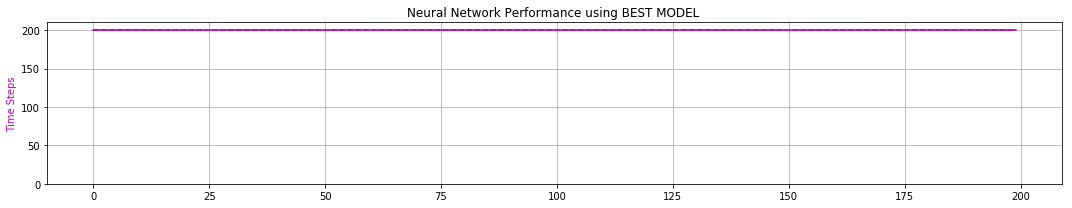

peak memory: 1401.25 MiB, increment: 1034.65 MiB
0 -max- [ 0.160  0.586  0.053  0.627]
0 -min- [-2.363 -2.957 -0.209 -0.756]

1 -max- [ 0.159  0.633  0.049  0.111]
1 -min- [-0.279 -1.088 -0.209 -1.066]

2 -max- [ 0.185  0.577  0.050  0.410]
2 -min- [-0.470 -1.486 -0.209 -0.766]

3 -max- [ 0.155  0.633  0.046  0.107]
3 -min- [-0.317 -1.141 -0.209 -1.000]

4 -max- [ 0.158  0.621  0.051  0.577]
4 -min- [-0.336 -1.142 -0.209 -0.739]

5 -max- [ 0.173  0.759  0.046  0.112]
5 -min- [-0.325 -1.082 -0.209 -1.232]

6 -max- [ 0.154  0.445  0.048  0.657]
6 -min- [-2.354 -2.938 -0.209 -0.750]

7 -max- [ 0.183  0.632  0.050  0.111]
7 -min- [-0.242 -1.088 -0.209 -0.989]

8 -max- [ 0.167  0.442  0.050  0.542]
8 -min- [-0.413 -1.134 -0.209 -0.739]

9 -max- [ 0.153  0.743  0.049  0.110]
9 -min- [-0.260 -1.100 -0.209 -1.340]

Quantization TIME:  0.01 minutes


ITERATION # 9
SMALLEST TIMESTEP in ITERATION 9: 16
REAL TIME TO GENERATE 27420 EXPERIENCES:0:00:00.734103


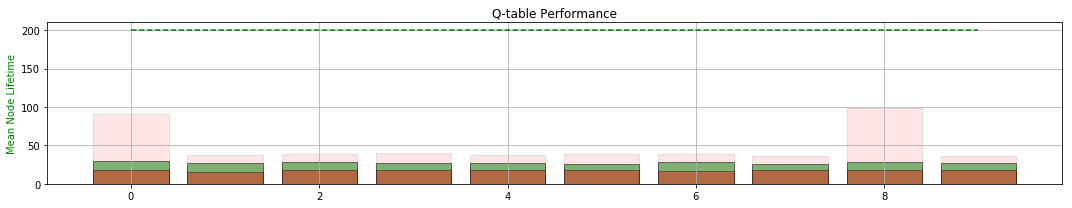

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.586	LOSS : 1.694	LOSS : 1.852	LOSS : 1.800	LOSS : 1.725	LOSS : 1.652	LOSS : 1.800	LOSS : 1.633	LOSS : 1.581	LOSS : 1.582	
Validating... MEAN TIME:  190.79
LOSS : 1.251	LOSS : 1.276	LOSS : 1.477	LOSS : 0.984	LOSS : 2.083	LOSS : 1.756	LOSS : 1.402	LOSS : 1.777	LOSS : 1.785	LOSS : 1.693	
Validating... MEAN TIME:  197.53
LOSS : 1.755	LOSS : 1.764	LOSS : 1.679	LOSS : 1.184	LOSS : 1.693	LOSS : 2.152	LOSS : 1.304	LOSS : 1.502	LOSS : 1.319	LOSS : 2.008	
Validating... MEAN TIME:  170.295
LOSS : 1.472	LOSS : 1.319	LOSS : 1.494	LOSS : 1.466	LOSS : 1.516	LOSS : 1.900	LOSS : 1.330	LOSS : 1.444	LOSS : 1.710	LOSS : 1.401	
Validating... MEAN TIME:  189.785
LOSS : 1.243	LOSS : 1.775	LOSS : 1.420	LOSS : 1.577	LOSS : 1.360	LOSS : 1.339	LOSS : 1.831	LOSS : 1.767	LOSS : 1.649	LOSS : 1.886	
Validating... MEAN TIME:  198.925
TRAINING TIME:0:00:40.248957


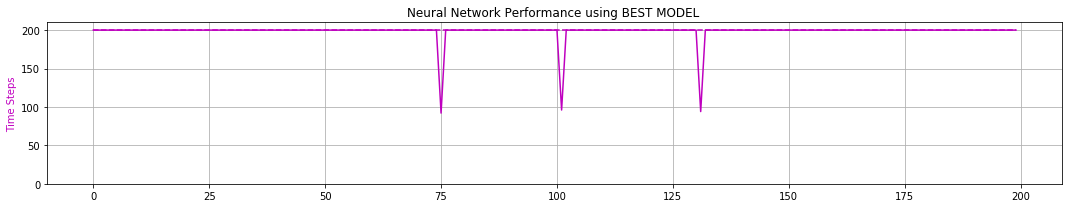

peak memory: 1418.72 MiB, increment: 1017.37 MiB
0 -max- [ 0.189  0.586  0.165  0.843]
0 -min- [-2.398 -2.627 -0.209 -0.796]

1 -max- [ 0.202  0.636  0.050  0.081]
1 -min- [-0.134 -0.777 -0.209 -1.179]

2 -max- [ 0.189  0.449  0.046  0.265]
2 -min- [-0.119 -0.778 -0.209 -0.802]

3 -max- [ 0.186  0.803  0.051  0.086]
3 -min- [-0.096 -0.780 -0.209 -1.379]

4 -max- [ 0.208  0.448  0.046  0.288]
4 -min- [-0.126 -0.961 -0.209 -0.801]

5 -max- [ 0.185  0.813  0.048  0.074]
5 -min- [-0.083 -0.781 -0.209 -1.288]

6 -max- [ 0.208  0.606  0.050  0.292]
6 -min- [-0.103 -0.779 -0.209 -0.801]

7 -max- [ 0.193  0.757  0.050  0.082]
7 -min- [-0.097 -0.742 -0.209 -1.384]

8 -max- [ 0.185  0.448  0.189  0.856]
8 -min- [-2.376 -2.579 -0.209 -0.794]

9 -max- [ 0.201  0.603  0.047  0.073]
9 -min- [-0.110 -0.767 -0.209 -1.094]

Quantization TIME:  0.01 minutes


ITERATION # 10
SMALLEST TIMESTEP in ITERATION 10: 16
REAL TIME TO GENERATE 28194 EXPERIENCES:0:00:00.753604


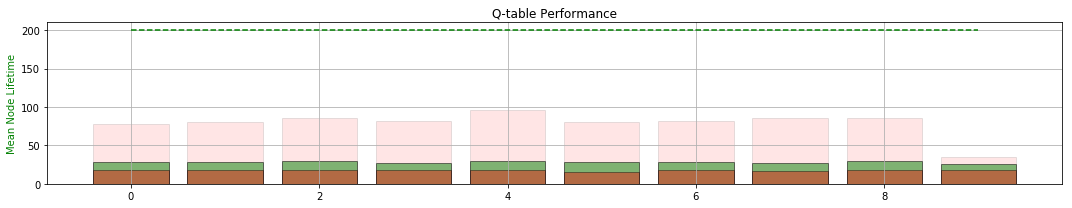

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.887	LOSS : 1.855	LOSS : 1.831	LOSS : 1.962	LOSS : 2.348	LOSS : 1.938	LOSS : 1.785	LOSS : 1.779	LOSS : 2.024	LOSS : 1.975	
Validating... MEAN TIME:  169.705
LOSS : 2.046	LOSS : 1.633	LOSS : 1.897	LOSS : 2.402	LOSS : 1.985	LOSS : 2.127	LOSS : 2.205	LOSS : 1.848	LOSS : 1.489	LOSS : 2.037	
Validating... MEAN TIME:  200.0
LOSS : 2.004	LOSS : 2.030	LOSS : 1.899	LOSS : 1.981	LOSS : 1.693	LOSS : 1.975	LOSS : 1.976	LOSS : 1.941	LOSS : 1.864	LOSS : 1.821	
Validating... MEAN TIME:  200.0
LOSS : 1.693	LOSS : 2.010	LOSS : 1.639	LOSS : 2.236	LOSS : 2.091	LOSS : 1.965	LOSS : 1.997	LOSS : 1.616	LOSS : 1.887	LOSS : 1.577	
Validating... MEAN TIME:  200.0
LOSS : 2.221	LOSS : 1.966	LOSS : 2.082	LOSS : 1.905	LOSS : 1.886	LOSS : 1.700	LOSS : 2.071	LOSS : 2.070	LOSS : 1.969	LOSS : 1.500	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:40.087992


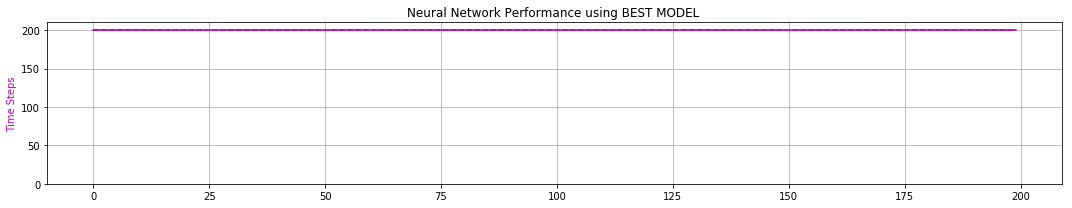

peak memory: 1387.39 MiB, increment: 1017.24 MiB
0 -max- [ 0.192  0.771  0.205  1.105]
0 -min- [-1.723 -2.422 -0.209 -1.037]

1 -max- [ 0.191  0.633  0.207  1.074]
1 -min- [-1.714 -2.411 -0.209 -1.067]

2 -max- [ 0.181  0.628  0.207  1.080]
2 -min- [-1.701 -2.270 -0.209 -0.897]

3 -max- [ 0.196  0.641  0.209  1.091]
3 -min- [-1.689 -2.253 -0.209 -1.120]

4 -max- [ 0.184  0.619  0.207  1.066]
4 -min- [-1.650 -2.276 -0.209 -0.885]

5 -max- [ 0.201  0.802  0.207  1.096]
5 -min- [-1.613 -2.264 -0.209 -1.065]

6 -max- [ 0.189  0.634  0.208  1.202]
6 -min- [-1.698 -2.399 -0.209 -0.894]

7 -max- [ 0.180  0.821  0.207  1.079]
7 -min- [-1.729 -2.396 -0.209 -1.273]

8 -max- [ 0.204  0.628  0.209  1.336]
8 -min- [-1.793 -2.436 -0.209 -0.883]

9 -max- [ 0.195  0.802  0.049  0.079]
9 -min- [-0.052 -0.590 -0.209 -1.168]

Quantization TIME:  0.01 minutes


ITERATION # 11
SMALLEST TIMESTEP in ITERATION 11: 13
REAL TIME TO GENERATE 36021 EXPERIENCES:0:00:00.959768


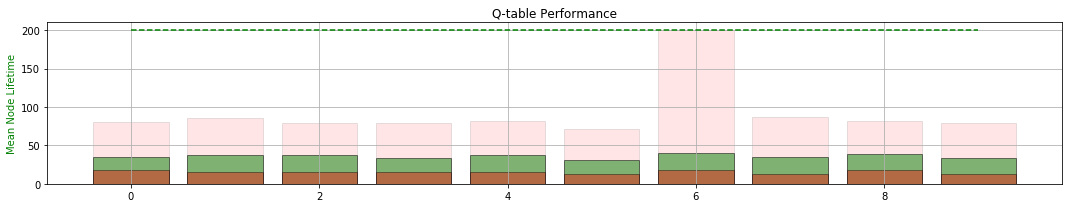

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.306	LOSS : 2.223	LOSS : 2.232	LOSS : 2.542	LOSS : 2.299	LOSS : 1.704	LOSS : 1.963	LOSS : 2.166	LOSS : 2.096	LOSS : 2.288	
Validating... MEAN TIME:  200.0
LOSS : 2.391	LOSS : 2.466	LOSS : 2.275	LOSS : 2.061	LOSS : 2.389	LOSS : 2.345	LOSS : 2.217	LOSS : 1.816	LOSS : 2.503	LOSS : 1.924	
Validating... MEAN TIME:  200.0
LOSS : 2.019	LOSS : 2.027	LOSS : 2.195	LOSS : 2.672	LOSS : 2.183	LOSS : 2.123	LOSS : 1.751	LOSS : 2.342	LOSS : 2.116	LOSS : 2.398	
Validating... MEAN TIME:  200.0
LOSS : 1.936	LOSS : 2.089	LOSS : 1.614	LOSS : 2.169	LOSS : 2.286	LOSS : 2.375	LOSS : 1.931	LOSS : 1.906	LOSS : 2.247	LOSS : 2.159	
Validating... MEAN TIME:  200.0
LOSS : 1.928	LOSS : 2.320	LOSS : 2.392	LOSS : 2.199	LOSS : 2.247	LOSS : 1.937	LOSS : 2.360	LOSS : 1.969	LOSS : 2.497	LOSS : 2.302	
Validating... MEAN TIME:  199.075
TRAINING TIME:0:00:42.437631


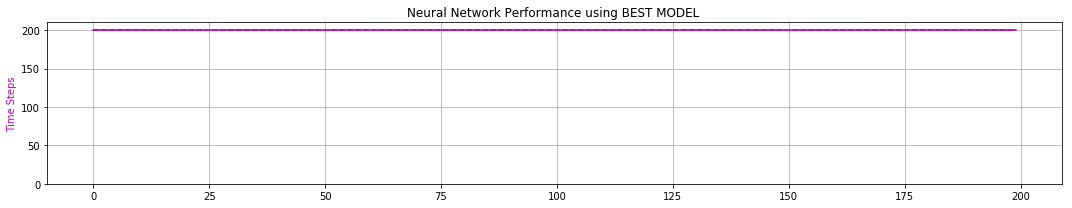

peak memory: 1400.89 MiB, increment: 1034.39 MiB
0 -max- [ 0.206  0.636  0.209  1.184]
0 -min- [-1.276 -2.103 -0.209 -1.042]

1 -max- [ 0.197  1.013  0.209  1.107]
1 -min- [-1.391 -2.021 -0.209 -1.368]

2 -max- [ 0.205  0.638  0.209  1.408]
2 -min- [-1.322 -2.111 -0.209 -0.990]

3 -max- [ 0.190  0.826  0.209  1.104]
3 -min- [-1.258 -2.020 -0.209 -1.375]

4 -max- [ 0.211  0.802  0.209  1.325]
4 -min- [-1.316 -2.206 -0.209 -1.068]

5 -max- [ 0.202  0.999  0.209  1.106]
5 -min- [-1.237 -2.090 -0.209 -1.554]

6 -max- [ 0.183  0.638  0.209  1.359]
6 -min- [-1.962 -2.093 -0.209 -1.025]

7 -max- [ 0.208  0.809  0.209  1.108]
7 -min- [-1.325 -2.014 -0.209 -1.230]

8 -max- [ 0.197  0.637  0.209  1.289]
8 -min- [-1.331 -2.078 -0.209 -1.022]

9 -max- [ 0.172  1.028  0.209  1.098]
9 -min- [-1.313 -2.090 -0.209 -1.559]

Quantization TIME:  0.01 minutes


ITERATION # 12
SMALLEST TIMESTEP in ITERATION 12: 11
REAL TIME TO GENERATE 18471 EXPERIENCES:0:00:00.505209


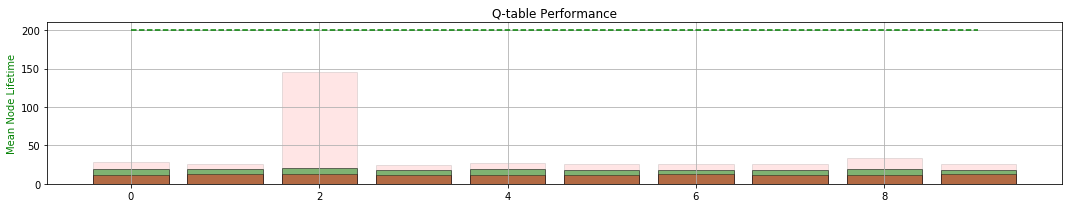

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.555	LOSS : 2.372	LOSS : 2.284	LOSS : 2.270	LOSS : 1.963	LOSS : 2.323	LOSS : 2.291	LOSS : 2.542	LOSS : 2.634	LOSS : 2.512	
Validating... MEAN TIME:  200.0
LOSS : 2.162	LOSS : 2.710	LOSS : 2.588	LOSS : 2.862	LOSS : 2.087	LOSS : 2.367	LOSS : 1.954	LOSS : 2.334	LOSS : 2.399	LOSS : 2.028	
Validating... MEAN TIME:  191.52
LOSS : 2.784	LOSS : 2.434	LOSS : 2.424	LOSS : 2.268	LOSS : 2.048	LOSS : 2.407	LOSS : 2.345	LOSS : 2.184	LOSS : 2.207	LOSS : 2.720	
Validating... MEAN TIME:  189.56
LOSS : 2.492	LOSS : 2.191	LOSS : 2.295	LOSS : 2.615	LOSS : 2.960	LOSS : 2.492	LOSS : 2.578	LOSS : 2.524	LOSS : 1.802	LOSS : 2.662	
Validating... MEAN TIME:  196.605
LOSS : 2.707	LOSS : 2.609	LOSS : 2.249	LOSS : 2.308	LOSS : 2.094	LOSS : 2.173	LOSS : 1.947	LOSS : 2.715	LOSS : 2.190	LOSS : 2.754	
Validating... MEAN TIME:  180.085
TRAINING TIME:0:00:40.988183


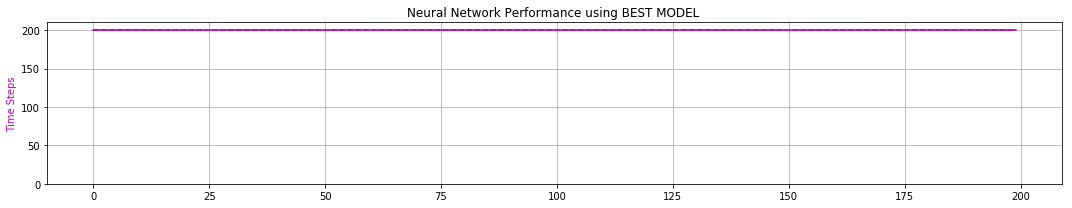

peak memory: 1451.86 MiB, increment: 1017.00 MiB
0 -max- [ 0.197  0.818  0.051  0.314]
0 -min- [-0.047 -0.415 -0.209 -1.107]

1 -max- [ 0.214  0.802  0.046  0.063]
1 -min- [-0.049 -0.583 -0.209 -1.230]

2 -max- [ 0.208  0.643  0.203  0.759]
2 -min- [-2.394 -1.883 -0.209 -1.100]

3 -max- [ 0.223  0.827  0.050  0.063]
3 -min- [-0.048 -0.572 -0.209 -1.413]

4 -max- [ 0.211  1.008  0.067  0.591]
4 -min- [-0.076 -0.592 -0.209 -1.336]

5 -max- [ 0.199  1.026  0.049  0.049]
5 -min- [-0.046 -0.407 -0.209 -1.605]

6 -max- [ 0.216  0.639  0.047  0.313]
6 -min- [-0.055 -0.573 -0.209 -1.101]

7 -max- [ 0.212  0.833  0.049  0.049]
7 -min- [-0.049 -0.405 -0.209 -1.442]

8 -max- [ 0.182  0.926  0.057  0.322]
8 -min- [-0.048 -0.596 -0.209 -1.335]

9 -max- [ 0.202  0.824  0.050  0.050]
9 -min- [-0.048 -0.412 -0.209 -1.439]

Quantization TIME:  0.01 minutes


ITERATION # 13
SMALLEST TIMESTEP in ITERATION 13: 11
REAL TIME TO GENERATE 19764 EXPERIENCES:0:00:00.531916


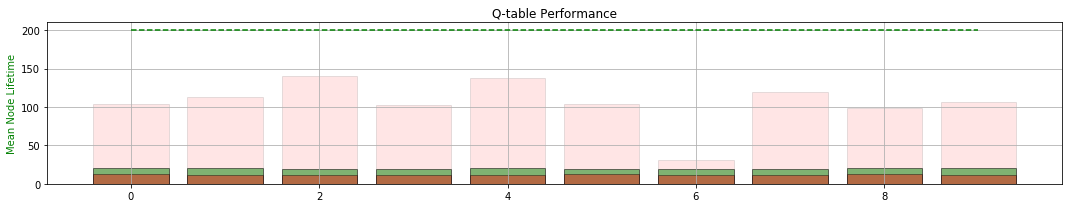

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.762	LOSS : 2.670	LOSS : 2.346	LOSS : 3.010	LOSS : 3.343	LOSS : 2.481	LOSS : 2.543	LOSS : 2.404	LOSS : 3.099	LOSS : 2.565	
Validating... MEAN TIME:  182.56
LOSS : 2.461	LOSS : 2.898	LOSS : 3.107	LOSS : 3.001	LOSS : 2.639	LOSS : 2.258	LOSS : 2.861	LOSS : 3.262	LOSS : 2.366	LOSS : 2.431	
Validating... MEAN TIME:  192.475
LOSS : 2.961	LOSS : 2.195	LOSS : 3.015	LOSS : 2.348	LOSS : 3.155	LOSS : 2.530	LOSS : 2.554	LOSS : 2.891	LOSS : 2.605	LOSS : 3.180	
Validating... MEAN TIME:  186.82
LOSS : 2.440	LOSS : 2.775	LOSS : 2.992	LOSS : 2.545	LOSS : 2.549	LOSS : 2.576	LOSS : 2.299	LOSS : 2.616	LOSS : 2.215	LOSS : 2.556	
Validating... MEAN TIME:  188.355
LOSS : 2.833	LOSS : 2.669	LOSS : 2.537	LOSS : 2.686	LOSS : 2.894	LOSS : 2.593	LOSS : 2.412	LOSS : 2.962	LOSS : 2.539	LOSS : 2.884	
Validating... MEAN TIME:  186.775
TRAINING TIME:0:00:40.405463


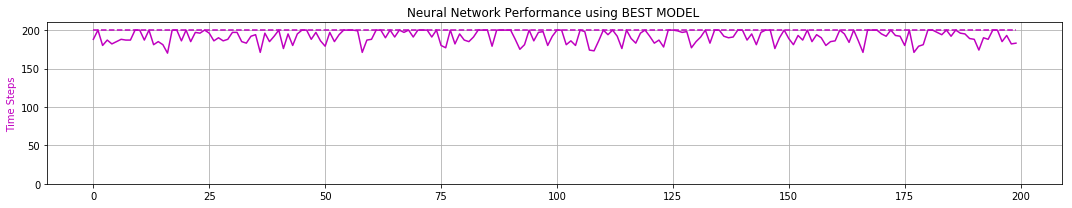

peak memory: 1412.93 MiB, increment: 1016.89 MiB
0 -max- [ 0.208  0.784  0.161  0.746]
0 -min- [-2.394 -2.244 -0.209 -1.094]

1 -max- [ 0.208  1.003  0.162  0.750]
1 -min- [-2.398 -2.258 -0.209 -1.480]

2 -max- [ 0.218  0.802  0.179  0.923]
2 -min- [-2.391 -2.260 -0.209 -1.101]

3 -max- [ 0.214  1.003  0.147  0.754]
3 -min- [-2.389 -2.258 -0.209 -1.514]

4 -max- [ 0.202  0.642  0.175  1.127]
4 -min- [-2.392 -2.257 -0.209 -1.099]

5 -max- [ 0.217  0.824  0.167  0.774]
5 -min- [-2.383 -2.255 -0.209 -1.398]

6 -max- [ 0.212  0.642  0.049  0.389]
6 -min- [-0.049 -0.777 -0.209 -1.097]

7 -max- [ 0.189  0.830  0.148  0.768]
7 -min- [-2.398 -2.078 -0.209 -1.390]

8 -max- [ 0.200  0.643  0.176  0.767]
8 -min- [-2.385 -2.250 -0.209 -1.103]

9 -max- [ 0.183  0.831  0.170  0.768]
9 -min- [-2.383 -2.259 -0.209 -1.400]

Quantization TIME:  0.01 minutes


ITERATION # 14
SMALLEST TIMESTEP in ITERATION 14: 14
REAL TIME TO GENERATE 78716 EXPERIENCES:0:00:02.014624


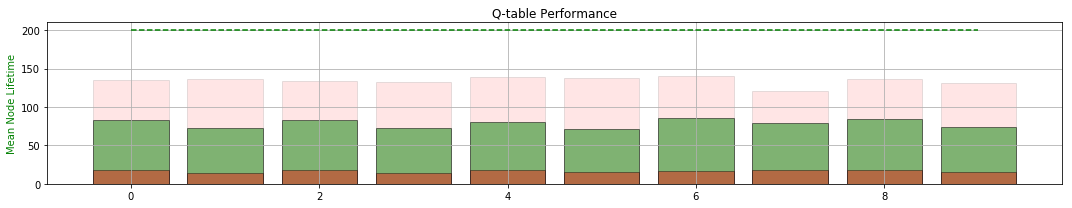

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.203	LOSS : 2.646	LOSS : 2.958	LOSS : 3.110	LOSS : 2.515	LOSS : 3.151	LOSS : 2.742	LOSS : 3.071	LOSS : 2.988	LOSS : 2.683	
Validating... MEAN TIME:  184.07
LOSS : 2.864	LOSS : 2.686	LOSS : 3.147	LOSS : 3.261	LOSS : 2.568	LOSS : 2.818	LOSS : 2.743	LOSS : 3.276	LOSS : 2.855	LOSS : 2.876	
Validating... MEAN TIME:  191.915
LOSS : 2.788	LOSS : 3.008	LOSS : 2.253	LOSS : 3.106	LOSS : 3.019	LOSS : 3.096	LOSS : 2.725	LOSS : 3.166	LOSS : 3.115	LOSS : 2.915	
Validating... MEAN TIME:  187.89
LOSS : 3.036	LOSS : 2.565	LOSS : 3.127	LOSS : 2.741	LOSS : 3.105	LOSS : 3.234	LOSS : 2.781	LOSS : 2.724	LOSS : 2.869	LOSS : 2.631	
Validating... MEAN TIME:  184.805
LOSS : 3.028	LOSS : 2.986	LOSS : 3.224	LOSS : 3.372	LOSS : 2.997	LOSS : 3.119	LOSS : 3.068	LOSS : 2.980	LOSS : 2.726	LOSS : 2.584	
Validating... MEAN TIME:  180.215
TRAINING TIME:0:00:39.177395


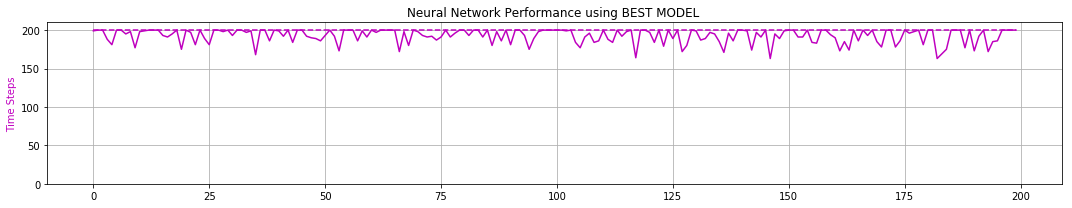

peak memory: 1416.14 MiB, increment: 1000.45 MiB
0 -max- [ 0.185  0.639  0.069  0.902]
0 -min- [-2.399 -2.594 -0.209 -1.045]

1 -max- [ 0.200  0.826  0.073  0.705]
1 -min- [-2.400 -2.921 -0.209 -1.318]

2 -max- [ 0.193  0.636  0.095  0.910]
2 -min- [-2.400 -2.577 -0.209 -1.065]

3 -max- [ 0.170  0.821  0.059  0.697]
3 -min- [-2.400 -2.945 -0.209 -1.386]

4 -max- [ 0.201  0.636  0.071  0.798]
4 -min- [-2.400 -2.606 -0.209 -1.080]

5 -max- [ 0.206  0.831  0.075  0.690]
5 -min- [-2.400 -2.957 -0.209 -1.220]

6 -max- [ 0.160  0.640  0.085  0.924]
6 -min- [-2.400 -2.713 -0.209 -1.065]

7 -max- [ 0.175  0.826  0.071  0.690]
7 -min- [-2.400 -2.890 -0.209 -1.338]

8 -max- [ 0.163  0.640  0.089  0.875]
8 -min- [-2.400 -2.609 -0.209 -1.059]

9 -max- [ 0.203  0.823  0.068  0.725]
9 -min- [-2.399 -3.127 -0.209 -1.272]

Quantization TIME:  0.01 minutes


ITERATION # 15
SMALLEST TIMESTEP in ITERATION 15: 14
REAL TIME TO GENERATE 99582 EXPERIENCES:0:00:02.503283


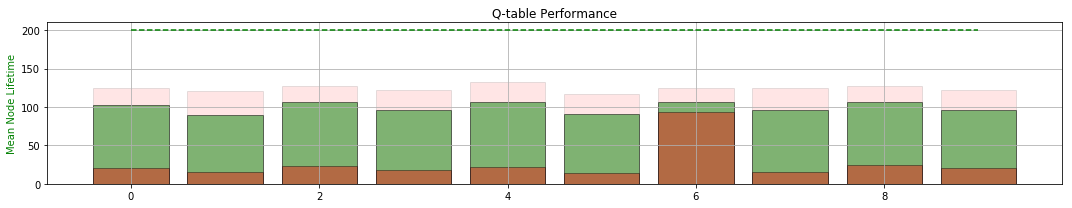

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.606	LOSS : 2.723	LOSS : 2.411	LOSS : 2.547	LOSS : 2.653	LOSS : 2.281	LOSS : 2.484	LOSS : 2.197	LOSS : 2.719	LOSS : 2.818	
Validating... MEAN TIME:  187.32
LOSS : 2.982	LOSS : 2.508	LOSS : 2.074	LOSS : 2.594	LOSS : 2.547	LOSS : 2.625	LOSS : 2.827	LOSS : 2.170	LOSS : 2.645	LOSS : 2.410	
Validating... MEAN TIME:  196.54
LOSS : 2.184	LOSS : 2.098	LOSS : 2.658	LOSS : 2.502	LOSS : 2.252	LOSS : 2.386	LOSS : 2.189	LOSS : 2.475	LOSS : 2.430	LOSS : 2.469	
Validating... MEAN TIME:  189.25
LOSS : 2.453	LOSS : 2.135	LOSS : 2.400	LOSS : 2.724	LOSS : 2.292	LOSS : 2.795	LOSS : 2.584	LOSS : 2.322	LOSS : 2.563	LOSS : 2.187	
Validating... MEAN TIME:  196.36
LOSS : 2.731	LOSS : 2.635	LOSS : 3.002	LOSS : 2.007	LOSS : 2.720	LOSS : 2.344	LOSS : 2.525	LOSS : 2.488	LOSS : 2.349	LOSS : 1.976	
Validating... MEAN TIME:  194.105
TRAINING TIME:0:00:40.755845


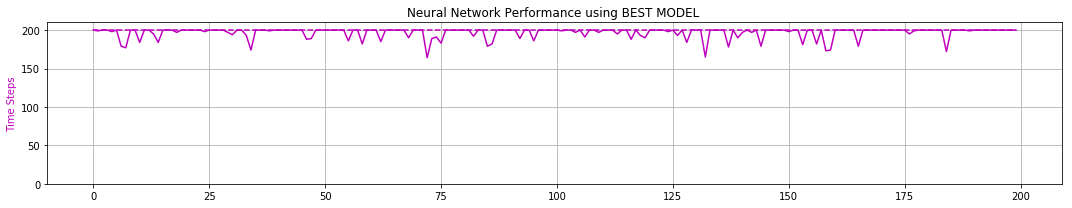

peak memory: 1459.75 MiB, increment: 977.36 MiB
0 -max- [ 0.206  0.802  0.050  0.919]
0 -min- [-2.400 -2.939 -0.209 -1.068]

1 -max- [ 0.184  0.839  0.050  0.697]
1 -min- [-2.400 -2.933 -0.209 -1.397]

2 -max- [ 0.168  0.637  0.052  1.092]
2 -min- [-2.399 -2.537 -0.207 -0.992]

3 -max- [ 0.193  0.789  0.047  0.687]
3 -min- [-2.399 -2.793 -0.209 -1.242]

4 -max- [ 0.182  0.637  0.049  0.889]
4 -min- [-2.400 -2.554 -0.205 -1.008]

5 -max- [ 0.153  0.830  0.050  0.704]
5 -min- [-2.400 -2.943 -0.209 -1.392]

6 -max- [ 0.177  0.638  0.050  0.903]
6 -min- [-2.400 -2.761 -0.209 -1.003]

7 -max- [ 0.170  0.824  0.050  0.691]
7 -min- [-2.400 -2.743 -0.209 -1.254]

8 -max- [ 0.191  0.633  0.050  0.959]
8 -min- [-2.400 -2.714 -0.208 -1.003]

9 -max- [ 0.184  0.829  0.049  0.694]
9 -min- [-2.399 -2.943 -0.209 -1.217]

Quantization TIME:  0.01 minutes


ITERATION # 16
SMALLEST TIMESTEP in ITERATION 16: 14
REAL TIME TO GENERATE 105984 EXPERIENCES:0:00:02.540611


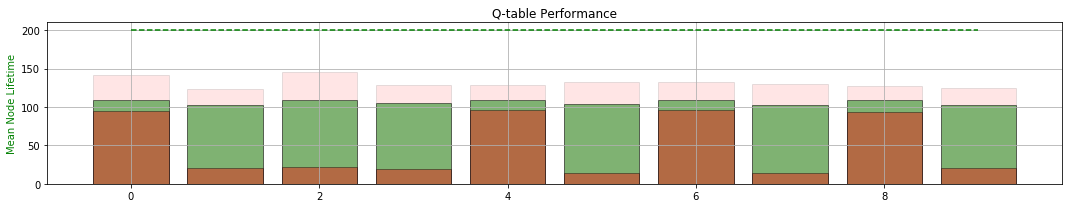

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.848	LOSS : 1.461	LOSS : 1.697	LOSS : 1.584	LOSS : 1.513	LOSS : 2.070	LOSS : 1.571	LOSS : 1.456	LOSS : 1.477	LOSS : 1.231	
Validating... MEAN TIME:  180.925
LOSS : 1.263	LOSS : 1.827	LOSS : 1.708	LOSS : 1.645	LOSS : 1.282	LOSS : 1.232	LOSS : 1.858	LOSS : 1.427	LOSS : 1.636	LOSS : 1.477	
Validating... MEAN TIME:  158.4
LOSS : 1.564	LOSS : 1.335	LOSS : 1.381	LOSS : 1.418	LOSS : 1.605	LOSS : 1.055	LOSS : 1.237	LOSS : 1.720	LOSS : 1.544	LOSS : 1.483	
Validating... MEAN TIME:  147.56
LOSS : 1.174	LOSS : 1.456	LOSS : 1.307	LOSS : 1.552	LOSS : 1.401	LOSS : 1.557	LOSS : 1.315	LOSS : 1.524	LOSS : 1.358	LOSS : 1.680	
Validating... MEAN TIME:  138.62
LOSS : 1.540	LOSS : 1.449	LOSS : 1.554	LOSS : 1.468	LOSS : 1.471	LOSS : 1.352	LOSS : 1.559	LOSS : 1.568	LOSS : 1.541	LOSS : 1.823	
Validating... MEAN TIME:  131.35
TRAINING TIME:0:00:33.063800


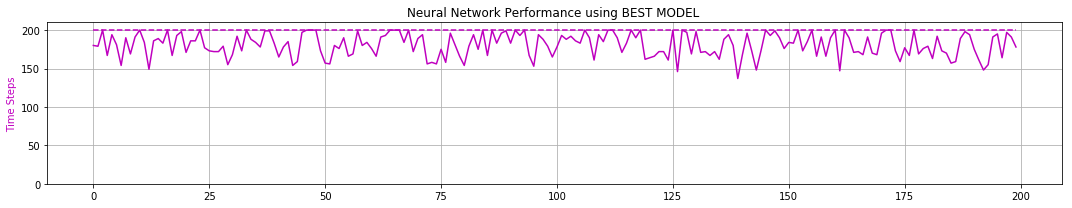

peak memory: 1415.31 MiB, increment: 1020.75 MiB
0 -max- [ 0.183  0.634  0.050  0.844]
0 -min- [-2.399 -2.963 -0.207 -0.913]

1 -max- [ 0.164  0.819  0.049  0.690]
1 -min- [-2.400 -2.952 -0.209 -1.215]

2 -max- [ 0.183  0.628  0.047  0.919]
2 -min- [-2.400 -2.952 -0.207 -0.923]

3 -max- [ 0.209  1.001  0.049  0.692]
3 -min- [-2.399 -2.952 -0.209 -1.552]

4 -max- [ 0.150  0.768  0.060  0.914]
4 -min- [-2.400 -2.982 -0.203 -1.007]

5 -max- [ 0.178  0.820  0.050  0.691]
5 -min- [-2.400 -2.955 -0.209 -1.311]

6 -max- [ 0.170  0.725  0.058  0.840]
6 -min- [-2.400 -2.955 -0.203 -1.015]

7 -max- [ 0.192  0.820  0.049  0.695]
7 -min- [-2.398 -2.971 -0.209 -1.424]

8 -max- [ 0.177  0.635  0.049  0.933]
8 -min- [-2.400 -2.968 -0.203 -0.934]

9 -max- [ 0.185  0.785  0.050  0.700]
9 -min- [-2.400 -3.120 -0.209 -1.249]

Quantization TIME:  0.01 minutes


ITERATION # 17
SMALLEST TIMESTEP in ITERATION 17: 15
REAL TIME TO GENERATE 83408 EXPERIENCES:0:00:02.009157


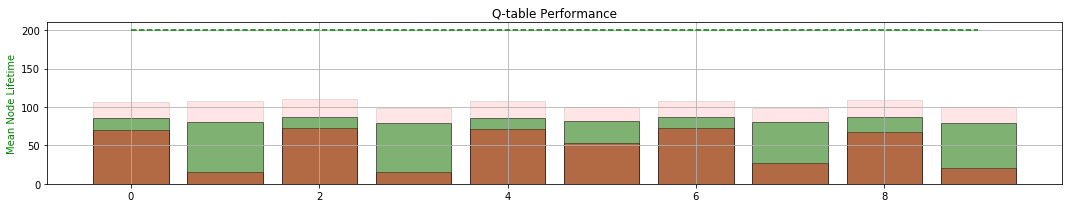

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.255	LOSS : 1.491	LOSS : 1.125	LOSS : 1.287	LOSS : 1.241	LOSS : 1.264	LOSS : 1.373	LOSS : 1.129	LOSS : 1.174	LOSS : 1.351	
Validating... MEAN TIME:  119.85
LOSS : 1.248	LOSS : 1.627	LOSS : 1.352	LOSS : 1.227	LOSS : 1.349	LOSS : 1.383	LOSS : 1.238	LOSS : 1.359	LOSS : 1.417	LOSS : 1.137	
Validating... MEAN TIME:  116.38
LOSS : 1.263	LOSS : 1.164	LOSS : 1.648	LOSS : 1.396	LOSS : 1.347	LOSS : 1.406	LOSS : 1.179	LOSS : 1.209	LOSS : 1.514	LOSS : 1.236	
Validating... MEAN TIME:  116.19
LOSS : 1.137	LOSS : 1.083	LOSS : 1.404	LOSS : 1.084	LOSS : 1.391	LOSS : 1.134	LOSS : 1.249	LOSS : 0.952	LOSS : 1.189	LOSS : 1.125	
Validating... MEAN TIME:  115.305
LOSS : 0.900	LOSS : 1.309	LOSS : 1.467	LOSS : 1.298	LOSS : 1.182	LOSS : 1.298	LOSS : 1.240	LOSS : 1.427	LOSS : 1.463	LOSS : 1.111	
Validating... MEAN TIME:  114.2
TRAINING TIME:0:00:27.362189


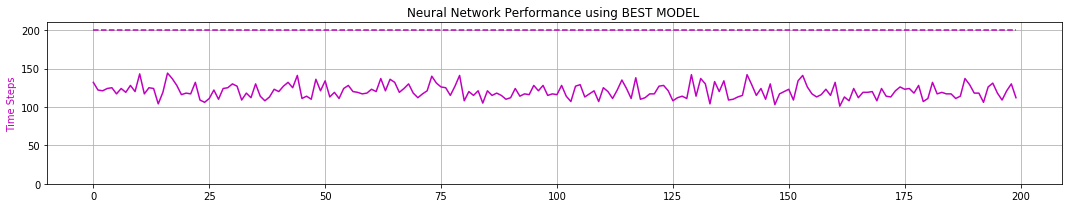

peak memory: 1437.81 MiB, increment: 1035.05 MiB
0 -max- [ 0.152  0.633  0.049  0.712]
0 -min- [-1.676 -2.229 -0.209 -0.915]

1 -max- [ 0.176  0.628  0.047  0.658]
1 -min- [-1.512 -2.197 -0.209 -1.147]

2 -max- [ 0.166  0.632  0.049  0.843]
2 -min- [-1.791 -2.351 -0.209 -0.913]

3 -max- [ 0.137  0.790  0.050  0.652]
3 -min- [-1.578 -2.201 -0.209 -1.159]

4 -max- [ 0.153  0.630  0.050  0.855]
4 -min- [-2.397 -2.889 -0.209 -0.910]

5 -max- [ 0.147  0.815  0.050  0.656]
5 -min- [-1.524 -2.229 -0.209 -1.203]

6 -max- [ 0.184  0.631  0.049  0.750]
6 -min- [-1.742 -2.345 -0.209 -0.909]

7 -max- [ 0.164  0.731  0.049  0.659]
7 -min- [-1.566 -2.338 -0.209 -1.187]

8 -max- [ 0.166  0.630  0.050  0.892]
8 -min- [-2.391 -3.065 -0.209 -0.911]

9 -max- [ 0.176  0.828  0.049  0.640]
9 -min- [-1.543 -2.204 -0.209 -1.202]

Quantization TIME:  0.01 minutes


ITERATION # 18
SMALLEST TIMESTEP in ITERATION 18: 16
REAL TIME TO GENERATE 60245 EXPERIENCES:0:00:01.540116


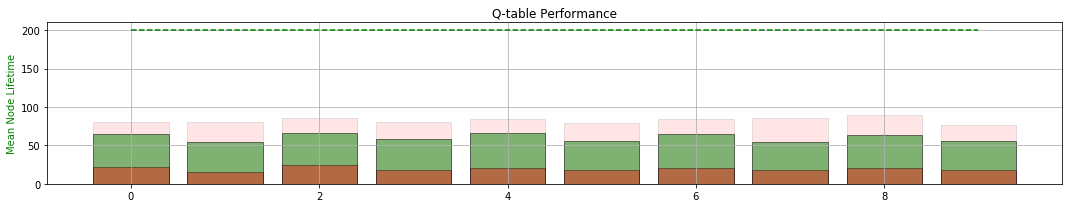

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.317	LOSS : 1.226	LOSS : 1.418	LOSS : 1.215	LOSS : 1.528	LOSS : 1.219	LOSS : 1.236	LOSS : 1.339	LOSS : 1.725	LOSS : 1.051	
Validating... MEAN TIME:  112.11
LOSS : 1.460	LOSS : 1.457	LOSS : 1.643	LOSS : 1.552	LOSS : 1.262	LOSS : 1.067	LOSS : 1.360	LOSS : 1.403	LOSS : 1.407	LOSS : 1.635	
Validating... MEAN TIME:  110.375
LOSS : 1.377	LOSS : 0.920	LOSS : 1.282	LOSS : 0.967	LOSS : 1.436	LOSS : 1.485	LOSS : 1.259	LOSS : 1.258	LOSS : 1.490	LOSS : 1.390	
Validating... MEAN TIME:  112.905
LOSS : 1.717	LOSS : 1.466	LOSS : 1.164	LOSS : 1.263	LOSS : 1.360	LOSS : 1.171	LOSS : 1.490	LOSS : 1.381	LOSS : 1.155	LOSS : 1.178	
Validating... MEAN TIME:  113.235
LOSS : 1.318	LOSS : 1.366	LOSS : 1.362	LOSS : 1.444	LOSS : 1.030	LOSS : 1.616	LOSS : 1.342	LOSS : 1.164	LOSS : 1.494	LOSS : 1.235	
Validating... MEAN TIME:  111.27
TRAINING TIME:0:00:26.472610


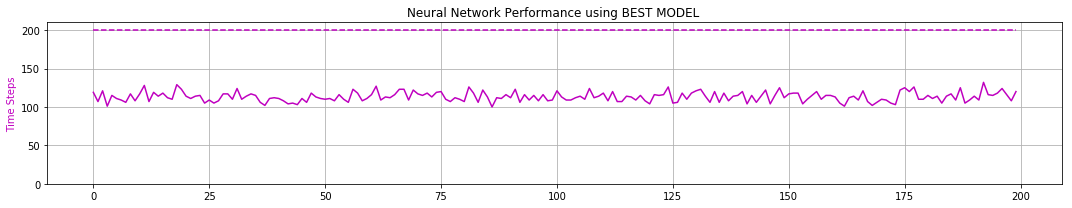

peak memory: 1471.86 MiB, increment: 1017.07 MiB
0 -max- [ 0.192  0.635  0.047  0.519]
0 -min- [-1.248 -2.194 -0.209 -0.970]

1 -max- [ 0.196  0.969  0.049  0.394]
1 -min- [-1.146 -2.164 -0.209 -1.388]

2 -max- [ 0.155  0.824  0.050  0.762]
2 -min- [-1.432 -2.225 -0.209 -1.060]

3 -max- [ 0.169  0.816  0.050  0.546]
3 -min- [-1.177 -2.157 -0.209 -1.266]

4 -max- [ 0.167  0.637  0.050  0.611]
4 -min- [-1.376 -2.231 -0.209 -0.956]

5 -max- [ 0.187  1.014  0.049  0.394]
5 -min- [-1.204 -2.160 -0.209 -1.462]

6 -max- [ 0.172  0.636  0.049  0.596]
6 -min- [-1.357 -2.188 -0.209 -0.966]

7 -max- [ 0.185  0.817  0.050  0.394]
7 -min- [-1.197 -2.157 -0.209 -1.312]

8 -max- [ 0.195  0.637  0.054  0.765]
8 -min- [-1.580 -2.327 -0.209 -0.971]

9 -max- [ 0.168  0.820  0.049  0.506]
9 -min- [-1.134 -2.041 -0.209 -1.348]

Quantization TIME:  0.01 minutes


ITERATION # 19
SMALLEST TIMESTEP in ITERATION 19: 16
REAL TIME TO GENERATE 24648 EXPERIENCES:0:00:00.658887


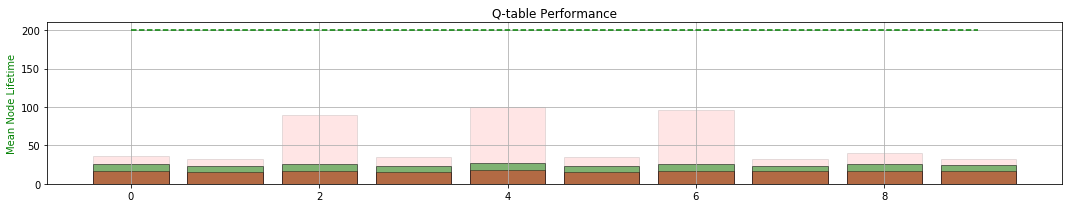

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.206	LOSS : 1.708	LOSS : 1.674	LOSS : 1.049	LOSS : 1.900	LOSS : 1.757	LOSS : 1.379	LOSS : 1.414	LOSS : 1.408	LOSS : 1.338	
Validating... MEAN TIME:  115.54
LOSS : 1.636	LOSS : 1.618	LOSS : 1.625	LOSS : 1.493	LOSS : 1.378	LOSS : 1.745	LOSS : 1.527	LOSS : 1.880	LOSS : 1.605	LOSS : 1.691	
Validating... MEAN TIME:  126.145
LOSS : 1.751	LOSS : 1.709	LOSS : 1.391	LOSS : 1.836	LOSS : 1.800	LOSS : 1.564	LOSS : 1.255	LOSS : 1.358	LOSS : 1.554	LOSS : 1.788	
Validating... MEAN TIME:  136.72
LOSS : 1.336	LOSS : 1.215	LOSS : 1.629	LOSS : 1.554	LOSS : 1.797	LOSS : 1.693	LOSS : 1.774	LOSS : 1.569	LOSS : 1.539	LOSS : 1.533	
Validating... MEAN TIME:  171.66
LOSS : 2.042	LOSS : 1.486	LOSS : 1.381	LOSS : 1.556	LOSS : 1.827	LOSS : 1.602	LOSS : 1.603	LOSS : 1.581	LOSS : 1.683	LOSS : 1.325	
Validating... MEAN TIME:  149.43
TRAINING TIME:0:00:31.511898


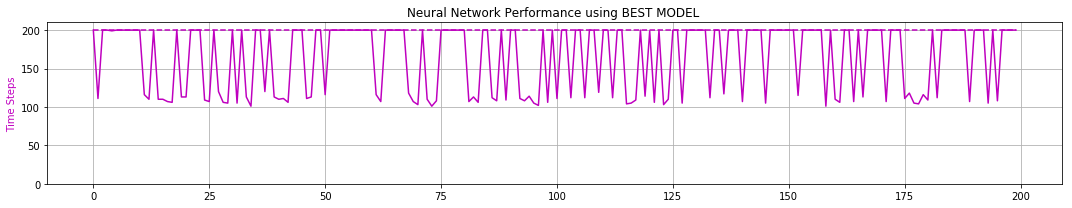

peak memory: 1326.80 MiB, increment: 939.35 MiB
0 -max- [ 0.187  0.636  0.049  0.380]
0 -min- [-0.105 -0.964 -0.209 -0.939]

1 -max- [ 0.172  0.826  0.050  0.064]
1 -min- [-0.048 -0.580 -0.209 -1.379]

2 -max- [ 0.176  0.747  0.059  0.703]
2 -min- [-2.339 -3.315 -0.209 -1.052]

3 -max- [ 0.171  0.784  0.050  0.072]
3 -min- [-0.049 -0.596 -0.209 -1.186]

4 -max- [ 0.190  0.631  0.049  0.707]
4 -min- [-2.399 -3.098 -0.209 -0.935]

5 -max- [ 0.184  0.804  0.049  0.075]
5 -min- [-0.047 -0.593 -0.209 -1.240]

6 -max- [ 0.187  0.634  0.050  0.688]
6 -min- [-2.399 -3.267 -0.209 -0.931]

7 -max- [ 0.192  0.818  0.049  0.074]
7 -min- [-0.050 -0.548 -0.209 -1.406]

8 -max- [ 0.174  0.635  0.049  0.331]
8 -min- [-0.133 -0.895 -0.209 -0.926]

9 -max- [ 0.191  0.801  0.050  0.065]
9 -min- [-0.050 -0.590 -0.209 -1.179]

Quantization TIME:  0.01 minutes


ITERATION # 20
SMALLEST TIMESTEP in ITERATION 20: 16
REAL TIME TO GENERATE 50988 EXPERIENCES:0:00:01.334414


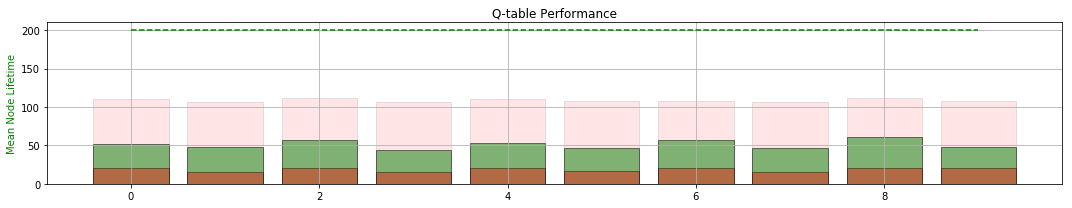

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.540	LOSS : 1.868	LOSS : 1.681	LOSS : 1.997	LOSS : 1.838	LOSS : 2.187	LOSS : 2.162	LOSS : 1.872	LOSS : 1.747	LOSS : 1.656	
Validating... MEAN TIME:  190.33
LOSS : 1.663	LOSS : 1.986	LOSS : 1.771	LOSS : 1.554	LOSS : 1.664	LOSS : 1.863	LOSS : 1.984	LOSS : 1.733	LOSS : 1.363	LOSS : 1.449	
Validating... MEAN TIME:  197.3
LOSS : 1.753	LOSS : 2.040	LOSS : 2.395	LOSS : 1.742	LOSS : 1.713	LOSS : 1.835	LOSS : 2.047	LOSS : 1.769	LOSS : 1.755	LOSS : 1.687	
Validating... MEAN TIME:  199.515
LOSS : 1.628	LOSS : 1.760	LOSS : 1.802	LOSS : 2.113	LOSS : 1.964	LOSS : 1.923	LOSS : 2.012	LOSS : 1.543	LOSS : 1.542	LOSS : 2.048	
Validating... MEAN TIME:  198.255
LOSS : 2.049	LOSS : 1.584	LOSS : 1.912	LOSS : 2.163	LOSS : 1.739	LOSS : 1.799	LOSS : 1.849	LOSS : 1.933	LOSS : 1.781	LOSS : 1.685	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:41.619124


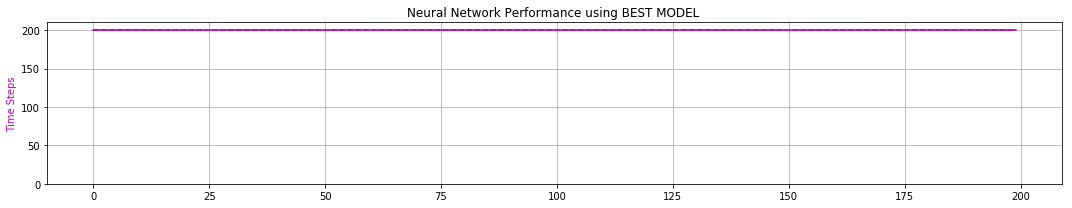

peak memory: 1417.09 MiB, increment: 1030.11 MiB
0 -max- [ 0.155  0.736  0.209  1.405]
0 -min- [-2.399 -3.179 -0.209 -1.041]

1 -max- [ 0.174  0.985  0.200  1.382]
1 -min- [-2.398 -3.361 -0.209 -1.434]

2 -max- [ 0.162  0.636  0.202  1.605]
2 -min- [-2.399 -3.186 -0.209 -0.931]

3 -max- [ 0.187  0.784  0.167  1.396]
3 -min- [-2.397 -3.375 -0.209 -1.160]

4 -max- [ 0.178  0.777  0.202  1.660]
4 -min- [-2.399 -3.288 -0.209 -1.054]

5 -max- [ 0.184  0.822  0.165  1.380]
5 -min- [-2.399 -3.348 -0.209 -1.196]

6 -max- [ 0.185  0.634  0.209  1.399]
6 -min- [-2.398 -3.188 -0.209 -0.920]

7 -max- [ 0.189  0.819  0.160  1.383]
7 -min- [-2.400 -3.288 -0.209 -1.222]

8 -max- [ 0.191  0.808  0.199  1.637]
8 -min- [-2.400 -3.214 -0.209 -1.042]

9 -max- [ 0.193  0.819  0.184  1.377]
9 -min- [-2.399 -3.374 -0.209 -1.170]

Quantization TIME:  0.01 minutes


ITERATION # 21
SMALLEST TIMESTEP in ITERATION 21: 16
REAL TIME TO GENERATE 98961 EXPERIENCES:0:00:02.438262


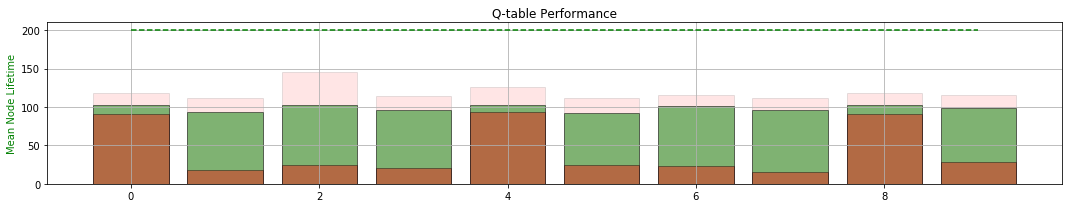

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.734	LOSS : 1.853	LOSS : 1.911	LOSS : 1.490	LOSS : 1.860	LOSS : 1.877	LOSS : 2.043	LOSS : 1.876	LOSS : 1.628	LOSS : 1.648	
Validating... MEAN TIME:  188.475
LOSS : 1.838	LOSS : 1.640	LOSS : 1.991	LOSS : 2.053	LOSS : 1.397	LOSS : 1.444	LOSS : 1.411	LOSS : 1.829	LOSS : 1.630	LOSS : 1.839	
Validating... MEAN TIME:  187.39
LOSS : 1.504	LOSS : 1.827	LOSS : 2.011	LOSS : 1.866	LOSS : 1.388	LOSS : 2.002	LOSS : 1.683	LOSS : 2.039	LOSS : 2.242	LOSS : 1.658	
Validating... MEAN TIME:  198.44
LOSS : 2.003	LOSS : 2.004	LOSS : 1.742	LOSS : 1.803	LOSS : 1.404	LOSS : 1.725	LOSS : 1.486	LOSS : 1.719	LOSS : 1.794	LOSS : 1.675	
Validating... MEAN TIME:  200.0
LOSS : 1.379	LOSS : 1.978	LOSS : 1.820	LOSS : 1.922	LOSS : 1.782	LOSS : 1.969	LOSS : 1.533	LOSS : 1.850	LOSS : 1.826	LOSS : 2.136	
Validating... MEAN TIME:  199.63
TRAINING TIME:0:00:40.155622


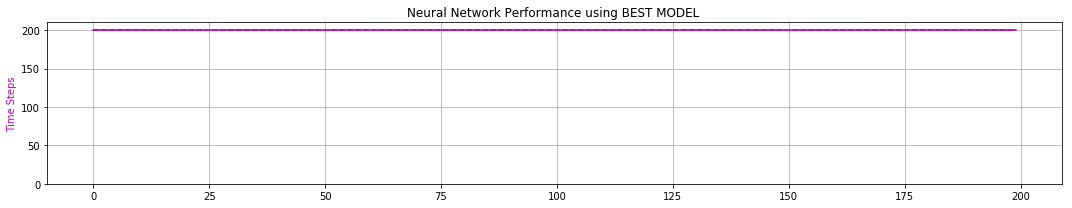

peak memory: 1457.60 MiB, increment: 1016.69 MiB
0 -max- [ 0.169  0.630  0.209  1.410]
0 -min- [-2.399 -3.007 -0.209 -0.933]

1 -max- [ 0.170  0.801  0.209  1.109]
1 -min- [-2.399 -3.296 -0.209 -1.119]

2 -max- [ 0.187  0.631  0.209  1.587]
2 -min- [-2.399 -3.003 -0.206 -1.325]

3 -max- [ 0.196  0.817  0.209  1.245]
3 -min- [-2.399 -3.152 -0.209 -1.326]

4 -max- [ 0.174  0.634  0.209  1.354]
4 -min- [-2.399 -3.013 -0.198 -0.924]

5 -max- [ 0.199  0.795  0.208  1.386]
5 -min- [-2.400 -3.303 -0.209 -1.279]

6 -max- [ 0.161  0.635  0.209  1.365]
6 -min- [-2.400 -3.012 -0.209 -0.921]

7 -max- [ 0.191  0.811  0.209  1.363]
7 -min- [-2.400 -3.354 -0.208 -1.391]

8 -max- [ 0.178  0.795  0.209  1.707]
8 -min- [-2.400 -3.002 -0.200 -1.031]

9 -max- [ 0.188  0.818  0.209  1.292]
9 -min- [-2.400 -3.166 -0.209 -1.145]

Quantization TIME:  0.01 minutes


ITERATION # 22
SMALLEST TIMESTEP in ITERATION 22: 19
REAL TIME TO GENERATE 101209 EXPERIENCES:0:00:02.473769


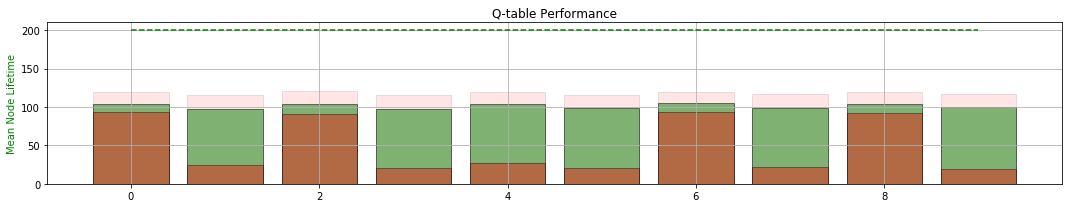

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.706	LOSS : 1.767	LOSS : 1.697	LOSS : 1.586	LOSS : 1.776	LOSS : 1.535	LOSS : 1.589	LOSS : 1.874	LOSS : 1.309	LOSS : 1.295	
Validating... MEAN TIME:  187.7
LOSS : 2.071	LOSS : 1.485	LOSS : 1.945	LOSS : 1.512	LOSS : 1.374	LOSS : 1.647	LOSS : 2.117	LOSS : 1.787	LOSS : 1.811	LOSS : 2.121	
Validating... MEAN TIME:  198.525
LOSS : 1.716	LOSS : 1.637	LOSS : 1.858	LOSS : 2.033	LOSS : 1.922	LOSS : 1.489	LOSS : 1.174	LOSS : 1.400	LOSS : 1.375	LOSS : 1.505	
Validating... MEAN TIME:  187.49
LOSS : 1.694	LOSS : 1.479	LOSS : 1.827	LOSS : 1.621	LOSS : 1.885	LOSS : 2.007	LOSS : 1.452	LOSS : 1.137	LOSS : 1.627	LOSS : 1.356	
Validating... MEAN TIME:  148.865
LOSS : 1.691	LOSS : 1.444	LOSS : 1.341	LOSS : 1.910	LOSS : 1.350	LOSS : 1.569	LOSS : 1.670	LOSS : 1.610	LOSS : 1.620	LOSS : 1.485	
Validating... MEAN TIME:  146.64
TRAINING TIME:0:00:36.030298


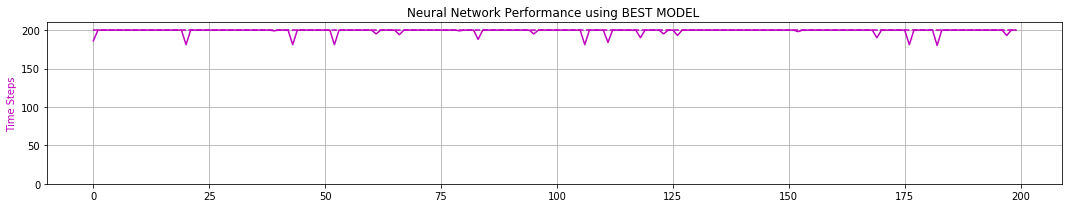

peak memory: 1478.27 MiB, increment: 1016.57 MiB
0 -max- [ 0.174  0.770  0.185  1.060]
0 -min- [-2.400 -3.002 -0.191 -1.040]

1 -max- [ 0.187  0.826  0.158  1.079]
1 -min- [-2.400 -3.185 -0.209 -1.195]

2 -max- [ 0.172  0.635  0.208  1.104]
2 -min- [-2.399 -2.991 -0.207 -0.934]

3 -max- [ 0.185  0.803  0.152  1.052]
3 -min- [-2.400 -3.144 -0.208 -1.159]

4 -max- [ 0.186  0.792  0.205  1.046]
4 -min- [-2.399 -2.815 -0.205 -1.034]

5 -max- [ 0.162  0.824  0.146  1.067]
5 -min- [-2.400 -3.172 -0.209 -1.166]

6 -max- [ 0.191  0.774  0.206  1.624]
6 -min- [-2.400 -3.006 -0.194 -1.047]

7 -max- [ 0.187  0.809  0.166  1.068]
7 -min- [-2.399 -3.269 -0.208 -1.208]

8 -max- [ 0.188  0.631  0.202  1.081]
8 -min- [-2.399 -3.001 -0.206 -0.918]

9 -max- [ 0.192  0.804  0.177  1.054]
9 -min- [-2.400 -3.157 -0.208 -1.278]

Quantization TIME:  0.01 minutes


ITERATION # 23
SMALLEST TIMESTEP in ITERATION 23: 11
REAL TIME TO GENERATE 84810 EXPERIENCES:0:00:02.122742


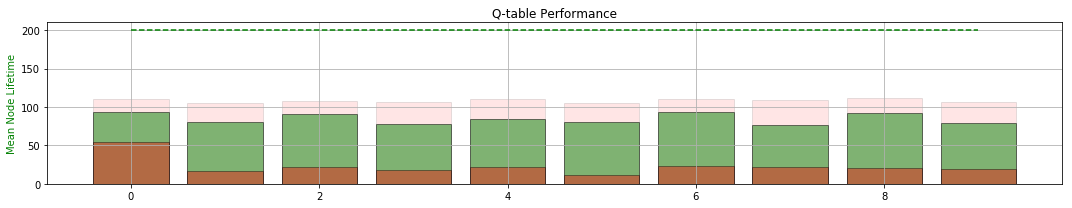

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.339	LOSS : 1.099	LOSS : 1.288	LOSS : 1.379	LOSS : 0.936	LOSS : 0.932	LOSS : 1.299	LOSS : 1.384	LOSS : 1.258	LOSS : 1.475	
Validating... MEAN TIME:  119.66
LOSS : 1.138	LOSS : 1.027	LOSS : 1.146	LOSS : 0.948	LOSS : 1.073	LOSS : 1.158	LOSS : 1.144	LOSS : 1.292	LOSS : 1.144	LOSS : 1.196	
Validating... MEAN TIME:  109.86
LOSS : 1.239	LOSS : 1.250	LOSS : 0.942	LOSS : 1.285	LOSS : 1.476	LOSS : 1.388	LOSS : 1.589	LOSS : 1.545	LOSS : 1.195	LOSS : 0.861	
Validating... MEAN TIME:  111.115
LOSS : 1.233	LOSS : 1.365	LOSS : 1.469	LOSS : 1.331	LOSS : 0.985	LOSS : 1.286	LOSS : 0.906	LOSS : 1.525	LOSS : 1.275	LOSS : 1.132	
Validating... MEAN TIME:  108.555
LOSS : 1.192	LOSS : 1.177	LOSS : 1.173	LOSS : 1.226	LOSS : 1.384	LOSS : 1.354	LOSS : 1.125	LOSS : 1.163	LOSS : 1.134	LOSS : 1.123	
Validating... MEAN TIME:  105.42
TRAINING TIME:0:00:25.533391


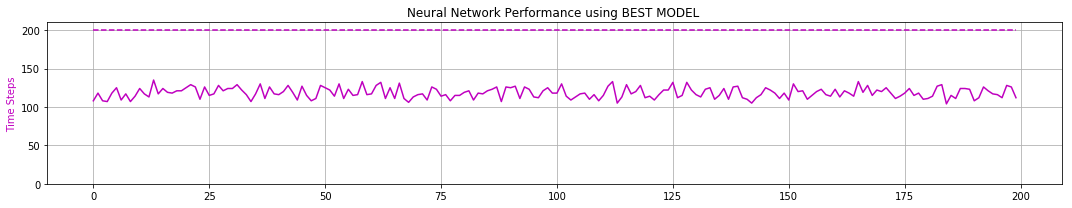

peak memory: 1450.29 MiB, increment: 977.11 MiB
0 -max- [ 0.190  0.795  0.070  1.192]
0 -min- [-2.400 -3.511 -0.209 -1.057]

1 -max- [ 0.180  0.790  0.049  1.008]
1 -min- [-2.398 -3.546 -0.209 -1.148]

2 -max- [ 0.193  0.749  0.059  1.269]
2 -min- [-2.400 -3.524 -0.209 -1.027]

3 -max- [ 0.180  0.811  0.049  1.029]
3 -min- [-2.399 -3.527 -0.209 -1.288]

4 -max- [ 0.157  0.636  0.049  1.314]
4 -min- [-2.400 -3.532 -0.209 -0.953]

5 -max- [ 0.207  1.006  0.050  1.032]
5 -min- [-2.399 -3.543 -0.209 -1.389]

6 -max- [ 0.186  0.634  0.076  1.222]
6 -min- [-2.398 -3.552 -0.209 -0.951]

7 -max- [ 0.182  0.810  0.048  1.044]
7 -min- [-2.399 -3.519 -0.209 -1.200]

8 -max- [ 0.186  0.636  0.059  1.097]
8 -min- [-2.399 -3.502 -0.209 -0.971]

9 -max- [ 0.191  0.824  0.048  1.029]
9 -min- [-2.400 -3.524 -0.209 -1.287]

Quantization TIME:  0.01 minutes


ITERATION # 24
SMALLEST TIMESTEP in ITERATION 24: 11
REAL TIME TO GENERATE 48269 EXPERIENCES:0:00:01.231512


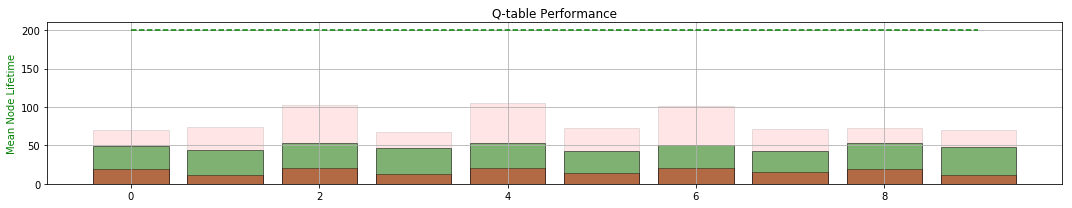

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.326	LOSS : 1.900	LOSS : 1.385	LOSS : 1.641	LOSS : 1.736	LOSS : 1.622	LOSS : 1.355	LOSS : 1.279	LOSS : 1.536	LOSS : 1.920	
Validating... MEAN TIME:  107.0
LOSS : 1.201	LOSS : 1.181	LOSS : 1.481	LOSS : 1.315	LOSS : 1.314	LOSS : 1.376	LOSS : 1.185	LOSS : 1.392	LOSS : 1.257	LOSS : 1.117	
Validating... MEAN TIME:  109.54
LOSS : 1.411	LOSS : 1.621	LOSS : 1.324	LOSS : 1.691	LOSS : 1.589	LOSS : 1.503	LOSS : 1.377	LOSS : 1.141	LOSS : 0.975	LOSS : 1.162	
Validating... MEAN TIME:  110.215
LOSS : 1.496	LOSS : 1.694	LOSS : 1.285	LOSS : 1.237	LOSS : 1.639	LOSS : 1.264	LOSS : 1.289	LOSS : 1.460	LOSS : 0.967	LOSS : 1.350	
Validating... MEAN TIME:  110.18
LOSS : 1.119	LOSS : 1.706	LOSS : 1.644	LOSS : 1.704	LOSS : 1.243	LOSS : 1.518	LOSS : 1.203	LOSS : 1.187	LOSS : 1.380	LOSS : 1.417	
Validating... MEAN TIME:  109.505
TRAINING TIME:0:00:25.334412


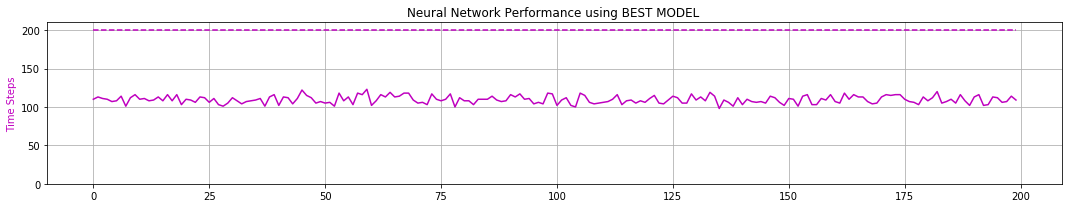

peak memory: 1462.29 MiB, increment: 977.32 MiB
0 -max- [ 0.182  0.739  0.049  0.794]
0 -min- [-0.979 -2.001 -0.209 -1.068]

1 -max- [ 0.198  0.826  0.050  0.388]
1 -min- [-0.965 -1.955 -0.209 -1.378]

2 -max- [ 0.196  0.639  0.049  0.693]
2 -min- [-2.388 -3.293 -0.209 -1.039]

3 -max- [ 0.173  0.829  0.049  0.594]
3 -min- [-0.798 -1.812 -0.209 -1.359]

4 -max- [ 0.201  0.784  0.053  0.672]
4 -min- [-2.355 -3.141 -0.209 -1.055]

5 -max- [ 0.194  0.982  0.049  0.559]
5 -min- [-0.963 -1.955 -0.209 -1.448]

6 -max- [ 0.198  0.635  0.048  0.707]
6 -min- [-2.386 -3.278 -0.209 -1.051]

7 -max- [ 0.202  0.816  0.050  0.599]
7 -min- [-1.043 -1.970 -0.209 -1.316]

8 -max- [ 0.185  0.751  0.053  0.606]
8 -min- [-1.085 -1.986 -0.209 -1.048]

9 -max- [ 0.203  0.831  0.050  0.577]
9 -min- [-0.985 -2.000 -0.209 -1.377]

Quantization TIME:  0.01 minutes


ITERATION # 25
SMALLEST TIMESTEP in ITERATION 25: 14
REAL TIME TO GENERATE 23652 EXPERIENCES:0:00:00.667196


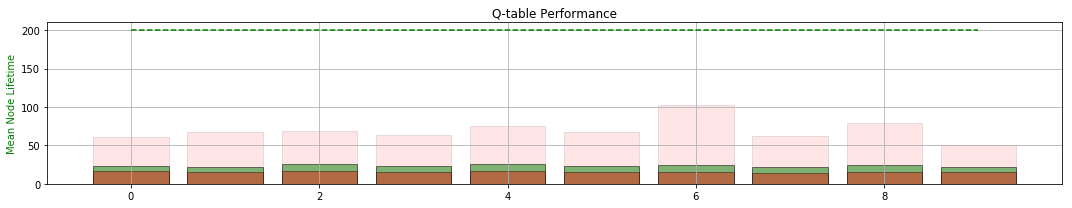

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.480	LOSS : 1.672	LOSS : 1.856	LOSS : 1.446	LOSS : 1.986	LOSS : 1.477	LOSS : 1.669	LOSS : 1.484	LOSS : 1.290	LOSS : 1.470	
Validating... MEAN TIME:  116.295
LOSS : 1.707	LOSS : 1.760	LOSS : 2.124	LOSS : 1.633	LOSS : 1.531	LOSS : 1.874	LOSS : 1.748	LOSS : 1.991	LOSS : 1.622	LOSS : 1.825	
Validating... MEAN TIME:  127.565
LOSS : 1.429	LOSS : 1.659	LOSS : 1.820	LOSS : 1.563	LOSS : 1.739	LOSS : 1.559	LOSS : 1.475	LOSS : 2.031	LOSS : 2.241	LOSS : 1.487	
Validating... MEAN TIME:  138.86
LOSS : 1.685	LOSS : 2.027	LOSS : 1.621	LOSS : 1.319	LOSS : 1.463	LOSS : 1.355	LOSS : 1.114	LOSS : 1.523	LOSS : 1.567	LOSS : 1.944	
Validating... MEAN TIME:  134.61
LOSS : 1.539	LOSS : 1.863	LOSS : 1.681	LOSS : 1.627	LOSS : 1.567	LOSS : 1.543	LOSS : 1.656	LOSS : 1.968	LOSS : 1.436	LOSS : 1.603	
Validating... MEAN TIME:  141.21
TRAINING TIME:0:00:30.294593


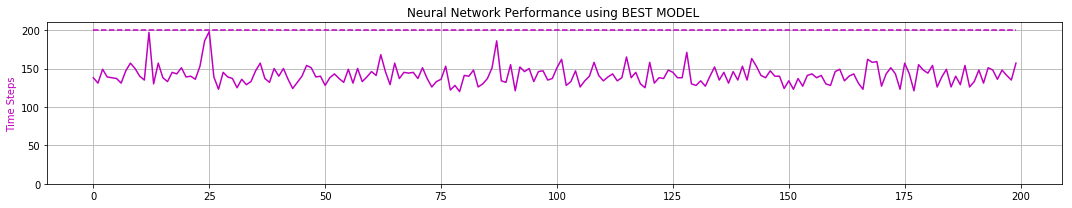

peak memory: 1417.27 MiB, increment: 978.16 MiB
0 -max- [ 0.190  0.634  0.050  0.454]
0 -min- [-0.591 -1.690 -0.209 -0.979]

1 -max- [ 0.203  1.024  0.049  0.381]
1 -min- [-0.791 -1.808 -0.209 -1.419]

2 -max- [ 0.182  0.638  0.049  0.598]
2 -min- [-1.017 -2.046 -0.209 -0.983]

3 -max- [ 0.193  0.821  0.050  0.385]
3 -min- [-0.676 -1.873 -0.209 -1.264]

4 -max- [ 0.191  0.786  0.051  0.378]
4 -min- [-0.891 -1.864 -0.209 -1.064]

5 -max- [ 0.194  0.799  0.048  0.573]
5 -min- [-0.761 -1.787 -0.209 -1.226]

6 -max- [ 0.202  0.762  0.050  0.652]
6 -min- [-2.380 -3.266 -0.209 -1.069]

7 -max- [ 0.190  0.812  0.048  0.370]
7 -min- [-0.726 -1.861 -0.209 -1.263]

8 -max- [ 0.193  0.636  0.050  0.800]
8 -min- [-1.063 -1.962 -0.209 -0.968]

9 -max- [ 0.198  1.006  0.050  0.357]
9 -min- [-0.362 -1.496 -0.209 -1.538]

Quantization TIME:  0.01 minutes


ITERATION # 26
SMALLEST TIMESTEP in ITERATION 26: 15
REAL TIME TO GENERATE 73915 EXPERIENCES:0:00:01.821638


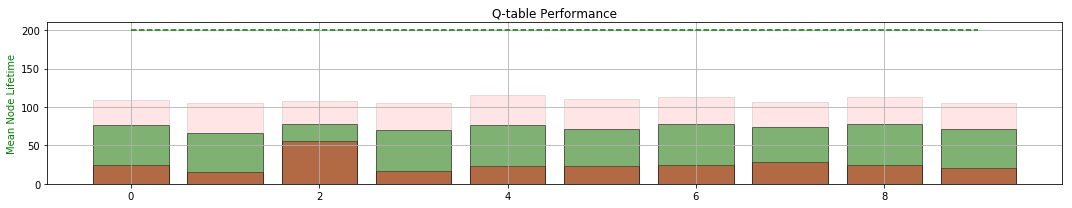

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.971	LOSS : 1.564	LOSS : 2.093	LOSS : 2.032	LOSS : 1.532	LOSS : 1.622	LOSS : 1.980	LOSS : 1.909	LOSS : 2.028	LOSS : 1.825	
Validating... MEAN TIME:  191.15
LOSS : 1.898	LOSS : 2.115	LOSS : 1.790	LOSS : 1.639	LOSS : 2.251	LOSS : 2.115	LOSS : 1.986	LOSS : 1.756	LOSS : 1.813	LOSS : 1.310	
Validating... MEAN TIME:  190.17
LOSS : 1.840	LOSS : 1.718	LOSS : 1.511	LOSS : 1.832	LOSS : 1.595	LOSS : 1.991	LOSS : 1.650	LOSS : 1.679	LOSS : 1.834	LOSS : 1.635	
Validating... MEAN TIME:  173.785
LOSS : 1.564	LOSS : 1.556	LOSS : 1.478	LOSS : 1.733	LOSS : 1.614	LOSS : 1.832	LOSS : 2.016	LOSS : 1.523	LOSS : 1.496	LOSS : 2.104	
Validating... MEAN TIME:  190.65
LOSS : 1.163	LOSS : 1.765	LOSS : 1.765	LOSS : 1.934	LOSS : 1.817	LOSS : 1.738	LOSS : 1.647	LOSS : 1.644	LOSS : 1.767	LOSS : 1.852	
Validating... MEAN TIME:  163.935
TRAINING TIME:0:00:37.608343


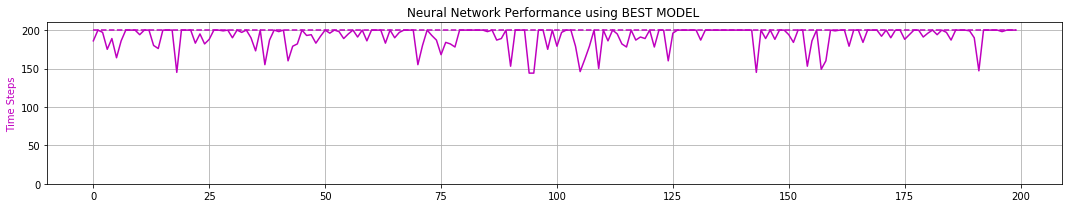

peak memory: 1372.32 MiB, increment: 997.27 MiB
0 -max- [ 0.180  0.637  0.049  0.889]
0 -min- [-2.400 -3.318 -0.209 -0.950]

1 -max- [ 0.159  0.823  0.049  0.698]
1 -min- [-2.393 -3.339 -0.209 -1.230]

2 -max- [ 0.185  0.635  0.063  0.923]
2 -min- [-2.399 -3.331 -0.209 -0.967]

3 -max- [ 0.186  0.829  0.049  0.693]
3 -min- [-2.397 -3.340 -0.209 -1.195]

4 -max- [ 0.182  0.632  0.049  1.072]
4 -min- [-2.400 -3.513 -0.209 -0.945]

5 -max- [ 0.186  0.821  0.050  0.702]
5 -min- [-2.399 -3.338 -0.209 -1.204]

6 -max- [ 0.174  0.630  0.048  0.895]
6 -min- [-2.399 -3.335 -0.209 -0.955]

7 -max- [ 0.184  0.798  0.050  0.709]
7 -min- [-2.398 -3.316 -0.209 -1.192]

8 -max- [ 0.177  0.636  0.053  0.845]
8 -min- [-2.396 -3.467 -0.209 -0.959]

9 -max- [ 0.197  0.823  0.049  0.699]
9 -min- [-2.399 -3.315 -0.209 -1.169]

Quantization TIME:  0.01 minutes


ITERATION # 27
SMALLEST TIMESTEP in ITERATION 27: 16
REAL TIME TO GENERATE 88498 EXPERIENCES:0:00:02.171179


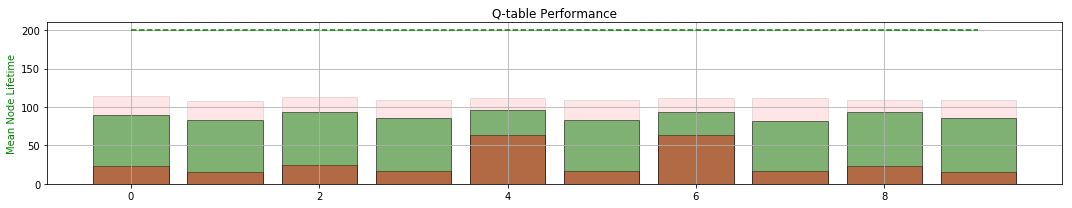

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.484	LOSS : 1.613	LOSS : 1.860	LOSS : 2.018	LOSS : 1.519	LOSS : 1.574	LOSS : 1.454	LOSS : 1.939	LOSS : 2.242	LOSS : 1.883	
Validating... MEAN TIME:  151.08
LOSS : 1.349	LOSS : 2.027	LOSS : 1.830	LOSS : 1.882	LOSS : 1.884	LOSS : 1.719	LOSS : 2.097	LOSS : 1.618	LOSS : 2.179	LOSS : 1.736	
Validating... MEAN TIME:  162.34
LOSS : 1.850	LOSS : 2.000	LOSS : 2.104	LOSS : 1.977	LOSS : 1.673	LOSS : 1.918	LOSS : 1.740	LOSS : 2.126	LOSS : 1.869	LOSS : 2.103	
Validating... MEAN TIME:  140.39
LOSS : 1.477	LOSS : 1.723	LOSS : 1.707	LOSS : 1.624	LOSS : 1.487	LOSS : 1.891	LOSS : 1.842	LOSS : 1.921	LOSS : 1.664	LOSS : 1.785	
Validating... MEAN TIME:  161.89
LOSS : 1.965	LOSS : 1.827	LOSS : 1.538	LOSS : 2.054	LOSS : 1.967	LOSS : 1.833	LOSS : 1.550	LOSS : 1.714	LOSS : 1.543	LOSS : 1.598	
Validating... MEAN TIME:  157.065
TRAINING TIME:0:00:33.356247


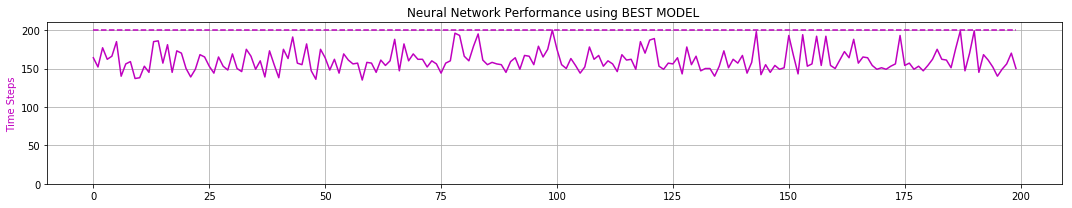

peak memory: 1458.89 MiB, increment: 1025.25 MiB
0 -max- [ 0.154  0.789  0.049  1.053]
0 -min- [-2.398 -3.314 -0.209 -1.051]

1 -max- [ 0.185  0.821  0.050  0.728]
1 -min- [-2.399 -3.348 -0.209 -1.203]

2 -max- [ 0.178  0.634  0.049  1.077]
2 -min- [-2.400 -3.291 -0.209 -0.924]

3 -max- [ 0.188  0.820  0.048  0.728]
3 -min- [-2.399 -3.350 -0.209 -1.190]

4 -max- [ 0.200  0.812  0.050  1.028]
4 -min- [-2.399 -3.325 -0.209 -1.057]

5 -max- [ 0.195  0.815  0.048  0.713]
5 -min- [-2.400 -3.329 -0.209 -1.441]

6 -max- [ 0.177  0.633  0.050  0.973]
6 -min- [-2.400 -3.298 -0.209 -0.938]

7 -max- [ 0.177  0.813  0.050  0.722]
7 -min- [-2.399 -3.334 -0.209 -1.271]

8 -max- [ 0.179  0.635  0.049  0.949]
8 -min- [-2.399 -3.476 -0.209 -0.944]

9 -max- [ 0.185  0.999  0.050  0.712]
9 -min- [-2.399 -3.315 -0.209 -1.745]

Quantization TIME:  0.01 minutes


ITERATION # 28
SMALLEST TIMESTEP in ITERATION 28: 13
REAL TIME TO GENERATE 87744 EXPERIENCES:0:00:02.147631


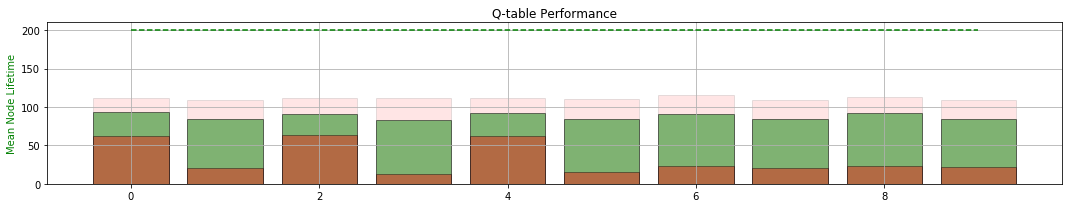

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.483	LOSS : 1.955	LOSS : 1.600	LOSS : 2.097	LOSS : 1.759	LOSS : 1.178	LOSS : 1.709	LOSS : 1.696	LOSS : 2.002	LOSS : 1.548	
Validating... MEAN TIME:  136.36
LOSS : 1.457	LOSS : 2.042	LOSS : 1.524	LOSS : 1.200	LOSS : 1.931	LOSS : 1.500	LOSS : 1.718	LOSS : 1.550	LOSS : 1.912	LOSS : 1.507	
Validating... MEAN TIME:  125.3
LOSS : 1.570	LOSS : 1.987	LOSS : 1.818	LOSS : 1.927	LOSS : 2.123	LOSS : 1.846	LOSS : 2.039	LOSS : 1.583	LOSS : 1.623	LOSS : 1.711	
Validating... MEAN TIME:  129.12
LOSS : 1.603	LOSS : 1.570	LOSS : 1.318	LOSS : 1.541	LOSS : 1.573	LOSS : 1.735	LOSS : 1.923	LOSS : 1.803	LOSS : 1.719	LOSS : 1.958	
Validating... MEAN TIME:  127.01
LOSS : 1.952	LOSS : 1.597	LOSS : 1.577	LOSS : 1.852	LOSS : 1.681	LOSS : 1.647	LOSS : 1.568	LOSS : 1.646	LOSS : 1.637	LOSS : 1.737	
Validating... MEAN TIME:  131.875
TRAINING TIME:0:00:29.142006


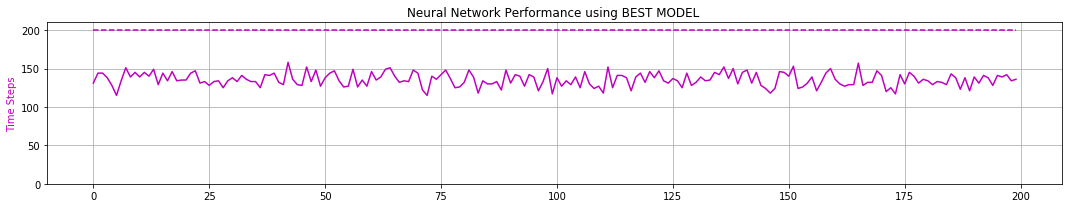

peak memory: 1460.73 MiB, increment: 978.30 MiB
0 -max- [ 0.193  0.635  0.050  0.881]
0 -min- [-2.400 -3.249 -0.209 -0.954]

1 -max- [ 0.186  0.829  0.049  0.651]
1 -min- [-2.400 -3.244 -0.209 -1.244]

2 -max- [ 0.182  0.632  0.048  0.819]
2 -min- [-2.400 -3.256 -0.209 -0.969]

3 -max- [ 0.186  0.803  0.050  0.613]
3 -min- [-2.397 -3.134 -0.209 -1.204]

4 -max- [ 0.184  0.630  0.048  0.717]
4 -min- [-2.398 -3.138 -0.209 -0.971]

5 -max- [ 0.185  0.976  0.050  0.571]
5 -min- [-2.398 -3.157 -0.209 -1.413]

6 -max- [ 0.183  0.789  0.050  0.725]
6 -min- [-2.399 -3.159 -0.209 -1.060]

7 -max- [ 0.204  0.832  0.049  0.571]
7 -min- [-2.399 -3.154 -0.209 -1.240]

8 -max- [ 0.171  0.808  0.054  0.831]
8 -min- [-2.400 -3.133 -0.209 -1.067]

9 -max- [ 0.174  0.821  0.049  0.400]
9 -min- [-2.400 -3.154 -0.209 -1.251]

Quantization TIME:  0.01 minutes


ITERATION # 29
SMALLEST TIMESTEP in ITERATION 29: 14
REAL TIME TO GENERATE 64964 EXPERIENCES:0:00:01.543327


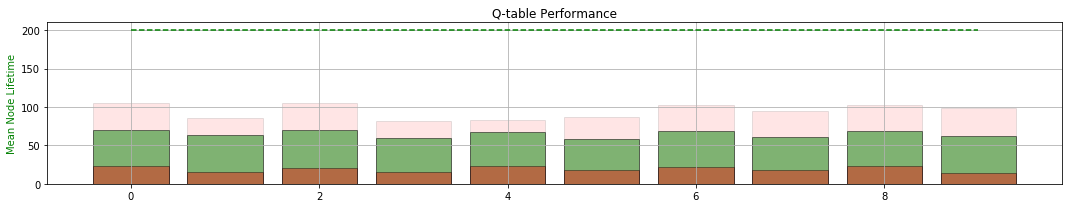

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.276	LOSS : 1.824	LOSS : 1.472	LOSS : 1.349	LOSS : 1.234	LOSS : 1.477	LOSS : 1.349	LOSS : 1.468	LOSS : 1.235	LOSS : 1.258	
Validating... MEAN TIME:  118.12
LOSS : 1.326	LOSS : 1.439	LOSS : 1.416	LOSS : 1.321	LOSS : 1.284	LOSS : 1.655	LOSS : 1.617	LOSS : 1.616	LOSS : 1.429	LOSS : 1.106	
Validating... MEAN TIME:  110.91
LOSS : 1.524	LOSS : 1.253	LOSS : 1.428	LOSS : 1.316	LOSS : 1.376	LOSS : 1.476	LOSS : 1.162	LOSS : 1.241	LOSS : 1.378	LOSS : 1.690	
Validating... MEAN TIME:  105.91
LOSS : 1.495	LOSS : 1.772	LOSS : 1.518	LOSS : 1.451	LOSS : 1.120	LOSS : 1.386	LOSS : 1.310	LOSS : 1.337	LOSS : 1.045	LOSS : 1.478	
Validating... MEAN TIME:  106.025
LOSS : 1.394	LOSS : 1.584	LOSS : 1.737	LOSS : 1.464	LOSS : 1.246	LOSS : 1.497	LOSS : 1.679	LOSS : 1.509	LOSS : 1.679	LOSS : 1.408	
Validating... MEAN TIME:  106.825
TRAINING TIME:0:00:25.852167


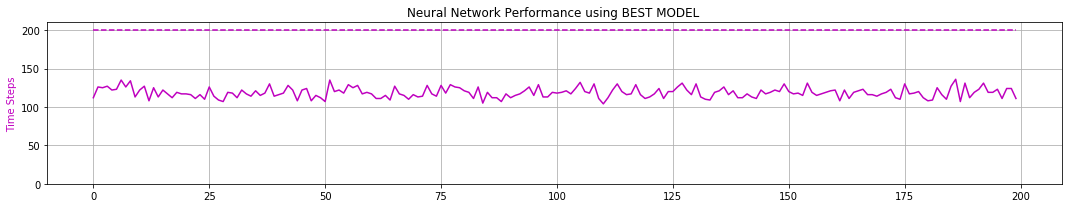

peak memory: 1480.26 MiB, increment: 978.18 MiB
0 -max- [ 0.180  0.795  0.058  0.691]
0 -min- [-2.383 -2.721 -0.209 -1.031]

1 -max- [ 0.190  0.779  0.048  0.575]
1 -min- [-1.257 -2.400 -0.209 -1.337]

2 -max- [ 0.194  0.636  0.050  0.863]
2 -min- [-2.400 -2.912 -0.209 -0.971]

3 -max- [ 0.177  1.007  0.048  0.582]
3 -min- [-1.333 -2.188 -0.209 -1.458]

4 -max- [ 0.185  0.636  0.050  0.631]
4 -min- [-1.372 -2.167 -0.209 -0.968]

5 -max- [ 0.191  0.833  0.050  0.596]
5 -min- [-1.302 -2.372 -0.209 -1.241]

6 -max- [ 0.187  0.636  0.049  0.739]
6 -min- [-2.394 -2.917 -0.209 -0.973]

7 -max- [ 0.172  0.819  0.050  0.585]
7 -min- [-2.365 -3.097 -0.209 -1.241]

8 -max- [ 0.176  0.634  0.049  0.612]
8 -min- [-2.392 -2.924 -0.209 -0.994]

9 -max- [ 0.191  0.824  0.049  0.398]
9 -min- [-2.360 -2.921 -0.209 -1.217]

Quantization TIME:  0.01 minutes


ITERATION # 30
SMALLEST TIMESTEP in ITERATION 30: 13
REAL TIME TO GENERATE 37594 EXPERIENCES:0:00:00.968715


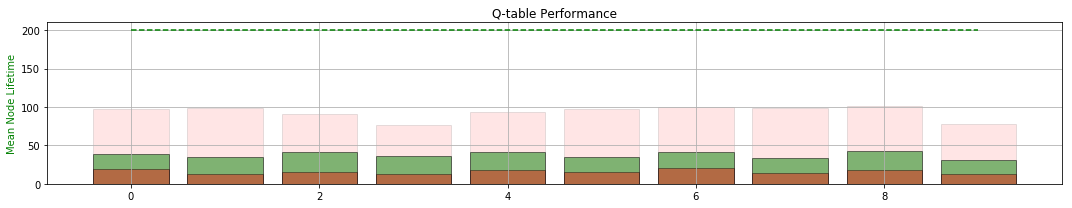

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.510	LOSS : 1.562	LOSS : 1.640	LOSS : 1.676	LOSS : 1.676	LOSS : 1.488	LOSS : 1.706	LOSS : 2.184	LOSS : 1.705	LOSS : 1.293	
Validating... MEAN TIME:  108.87
LOSS : 1.487	LOSS : 1.596	LOSS : 1.558	LOSS : 1.097	LOSS : 1.610	LOSS : 1.674	LOSS : 1.491	LOSS : 1.910	LOSS : 1.762	LOSS : 1.498	
Validating... MEAN TIME:  108.61
LOSS : 1.445	LOSS : 1.416	LOSS : 1.657	LOSS : 1.656	LOSS : 1.833	LOSS : 1.774	LOSS : 1.440	LOSS : 1.641	LOSS : 1.596	LOSS : 1.845	
Validating... MEAN TIME:  107.625
LOSS : 1.179	LOSS : 1.689	LOSS : 1.322	LOSS : 1.831	LOSS : 1.653	LOSS : 1.672	LOSS : 1.709	LOSS : 1.541	LOSS : 1.540	LOSS : 1.478	
Validating... MEAN TIME:  108.43
LOSS : 1.955	LOSS : 1.612	LOSS : 1.722	LOSS : 1.741	LOSS : 1.676	LOSS : 1.665	LOSS : 1.632	LOSS : 1.833	LOSS : 1.669	LOSS : 1.529	
Validating... MEAN TIME:  109.41
TRAINING TIME:0:00:26.201976


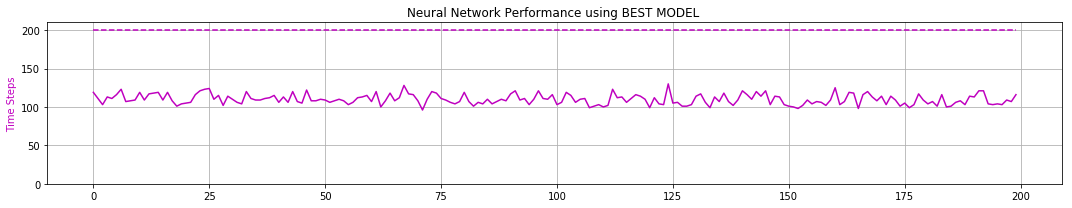

peak memory: 1473.98 MiB, increment: 1051.26 MiB
0 -max- [ 0.198  0.633  0.048  0.592]
0 -min- [-2.391 -3.300 -0.209 -1.043]

1 -max- [ 0.202  0.817  0.050  0.384]
1 -min- [-2.343 -3.251 -0.209 -1.259]

2 -max- [ 0.189  0.807  0.049  0.591]
2 -min- [-2.374 -3.097 -0.209 -1.069]

3 -max- [ 0.200  1.009  0.050  0.391]
3 -min- [-1.154 -2.170 -0.209 -1.425]

4 -max- [ 0.191  0.640  0.050  0.571]
4 -min- [-2.388 -3.252 -0.209 -1.071]

5 -max- [ 0.191  0.831  0.049  0.584]
5 -min- [-2.376 -3.248 -0.209 -1.179]

6 -max- [ 0.168  0.641  0.050  0.765]
6 -min- [-2.373 -3.111 -0.209 -1.051]

7 -max- [ 0.180  0.825  0.049  0.383]
7 -min- [-2.392 -3.151 -0.209 -1.350]

8 -max- [ 0.181  0.640  0.049  0.606]
8 -min- [-2.400 -3.075 -0.209 -1.062]

9 -max- [ 0.181  0.827  0.049  0.571]
9 -min- [-1.129 -2.195 -0.209 -1.355]

Quantization TIME:  0.01 minutes


ITERATION # 31
SMALLEST TIMESTEP in ITERATION 31: 11
REAL TIME TO GENERATE 24668 EXPERIENCES:0:00:00.652427


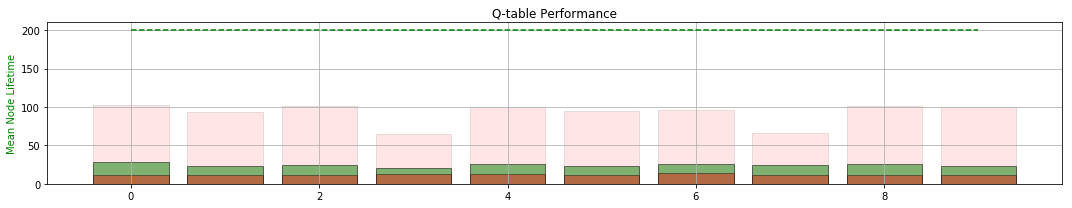

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.668	LOSS : 1.956	LOSS : 1.998	LOSS : 2.082	LOSS : 1.585	LOSS : 1.604	LOSS : 2.036	LOSS : 1.746	LOSS : 1.793	LOSS : 2.192	
Validating... MEAN TIME:  119.285
LOSS : 1.927	LOSS : 1.858	LOSS : 2.338	LOSS : 1.906	LOSS : 1.980	LOSS : 1.664	LOSS : 2.177	LOSS : 1.528	LOSS : 1.906	LOSS : 2.078	
Validating... MEAN TIME:  125.305
LOSS : 1.703	LOSS : 1.541	LOSS : 1.988	LOSS : 1.751	LOSS : 1.984	LOSS : 1.663	LOSS : 2.097	LOSS : 1.895	LOSS : 1.993	LOSS : 2.069	
Validating... MEAN TIME:  118.37
LOSS : 1.769	LOSS : 1.671	LOSS : 2.268	LOSS : 1.954	LOSS : 1.971	LOSS : 1.617	LOSS : 2.109	LOSS : 1.704	LOSS : 1.721	LOSS : 1.973	
Validating... MEAN TIME:  121.095
LOSS : 1.500	LOSS : 1.499	LOSS : 1.958	LOSS : 1.722	LOSS : 1.925	LOSS : 1.824	LOSS : 1.982	LOSS : 1.921	LOSS : 1.476	LOSS : 2.026	
Validating... MEAN TIME:  117.35
TRAINING TIME:0:00:28.231261


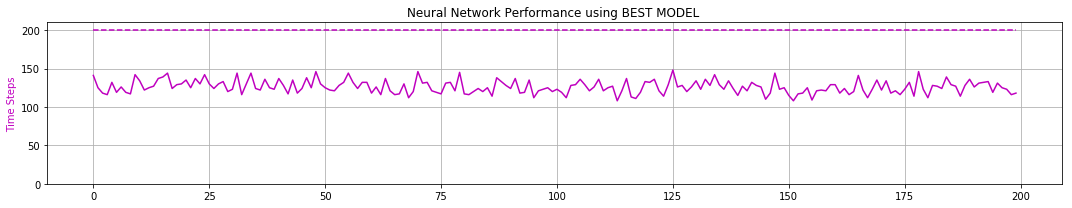

peak memory: 1409.62 MiB, increment: 1015.28 MiB
0 -max- [ 0.210  0.767  0.050  0.611]
0 -min- [-2.388 -3.146 -0.209 -1.101]

1 -max- [ 0.201  0.827  0.048  0.379]
1 -min- [-2.348 -3.142 -0.209 -1.422]

2 -max- [ 0.216  0.642  0.050  0.571]
2 -min- [-2.384 -3.068 -0.209 -1.102]

3 -max- [ 0.195  0.822  0.050  0.385]
3 -min- [-0.656 -1.857 -0.209 -1.417]

4 -max- [ 0.204  0.641  0.049  0.586]
4 -min- [-2.386 -3.086 -0.209 -1.093]

5 -max- [ 0.195  0.836  0.050  0.583]
5 -min- [-2.365 -3.255 -0.209 -1.357]

6 -max- [ 0.196  0.640  0.049  0.467]
6 -min- [-2.389 -3.155 -0.209 -1.100]

7 -max- [ 0.205  0.823  0.049  0.389]
7 -min- [-0.878 -2.064 -0.209 -1.430]

8 -max- [ 0.197  0.643  0.049  0.770]
8 -min- [-2.374 -3.064 -0.209 -1.103]

9 -max- [ 0.206  1.006  0.051  0.394]
9 -min- [-2.368 -3.143 -0.209 -1.464]

Quantization TIME:  0.01 minutes


ITERATION # 32
SMALLEST TIMESTEP in ITERATION 32: 10
REAL TIME TO GENERATE 38350 EXPERIENCES:0:00:01.036263


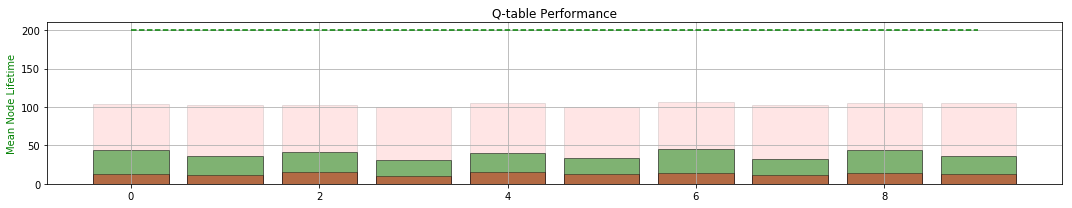

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.065	LOSS : 1.810	LOSS : 2.245	LOSS : 1.988	LOSS : 2.224	LOSS : 1.912	LOSS : 2.114	LOSS : 1.525	LOSS : 2.364	LOSS : 2.583	
Validating... MEAN TIME:  130.845
LOSS : 2.183	LOSS : 2.430	LOSS : 2.236	LOSS : 1.814	LOSS : 2.080	LOSS : 2.035	LOSS : 1.864	LOSS : 2.153	LOSS : 2.234	LOSS : 2.107	
Validating... MEAN TIME:  134.25
LOSS : 1.820	LOSS : 2.311	LOSS : 2.262	LOSS : 2.131	LOSS : 2.133	LOSS : 2.115	LOSS : 2.044	LOSS : 2.135	LOSS : 2.062	LOSS : 2.155	
Validating... MEAN TIME:  144.33
LOSS : 1.716	LOSS : 2.127	LOSS : 2.035	LOSS : 2.335	LOSS : 2.242	LOSS : 2.101	LOSS : 2.106	LOSS : 1.918	LOSS : 1.909	LOSS : 2.398	
Validating... MEAN TIME:  133.775
LOSS : 2.028	LOSS : 1.439	LOSS : 1.615	LOSS : 2.648	LOSS : 1.811	LOSS : 1.987	LOSS : 2.520	LOSS : 2.184	LOSS : 2.158	LOSS : 2.070	
Validating... MEAN TIME:  153.25
TRAINING TIME:0:00:31.904390


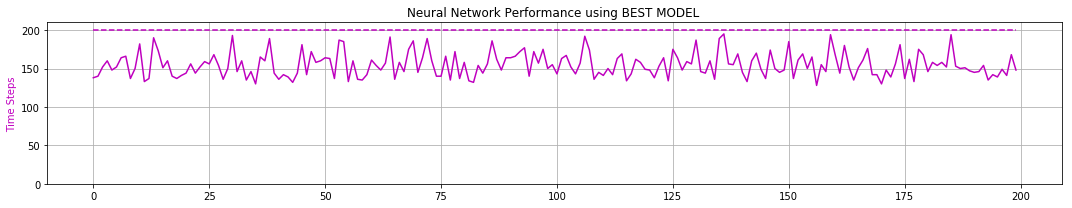

peak memory: 1417.98 MiB, increment: 1016.88 MiB
0 -max- [ 0.193  0.633  0.048  0.652]
0 -min- [-2.399 -3.165 -0.209 -1.093]

1 -max- [ 0.195  0.830  0.050  0.605]
1 -min- [-2.397 -3.147 -0.209 -1.400]

2 -max- [ 0.187  0.640  0.050  0.642]
2 -min- [-2.397 -3.273 -0.209 -1.058]

3 -max- [ 0.191  1.021  0.049  0.579]
3 -min- [-2.400 -3.281 -0.209 -1.611]

4 -max- [ 0.182  0.641  0.050  0.635]
4 -min- [-2.396 -3.148 -0.209 -1.061]

5 -max- [ 0.188  0.828  0.049  0.585]
5 -min- [-2.390 -3.155 -0.209 -1.317]

6 -max- [ 0.183  0.641  0.053  0.758]
6 -min- [-2.399 -3.134 -0.209 -1.077]

7 -max- [ 0.212  0.831  0.049  0.544]
7 -min- [-2.394 -3.138 -0.209 -1.385]

8 -max- [ 0.191  0.812  0.056  0.723]
8 -min- [-2.400 -3.329 -0.209 -1.077]

9 -max- [ 0.212  0.802  0.050  0.598]
9 -min- [-2.395 -3.143 -0.209 -1.469]

Quantization TIME:  0.01 minutes


ITERATION # 33
SMALLEST TIMESTEP in ITERATION 33: 12
REAL TIME TO GENERATE 96654 EXPERIENCES:0:00:02.446587


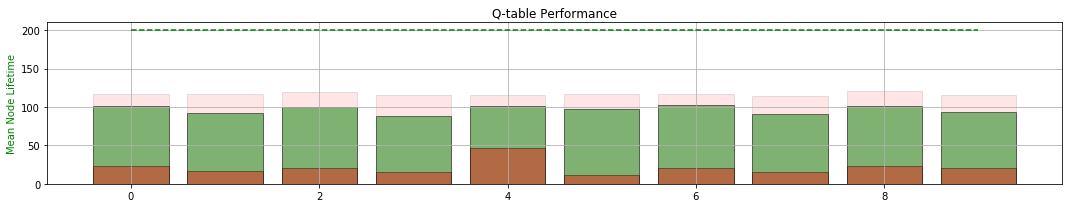

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.135	LOSS : 2.453	LOSS : 1.969	LOSS : 2.466	LOSS : 2.406	LOSS : 2.018	LOSS : 2.149	LOSS : 2.616	LOSS : 2.549	LOSS : 2.449	
Validating... MEAN TIME:  146.64
LOSS : 1.963	LOSS : 2.266	LOSS : 1.638	LOSS : 2.284	LOSS : 2.447	LOSS : 1.819	LOSS : 1.856	LOSS : 1.790	LOSS : 1.469	LOSS : 1.659	
Validating... MEAN TIME:  161.065
LOSS : 2.114	LOSS : 1.995	LOSS : 1.851	LOSS : 2.138	LOSS : 1.983	LOSS : 1.592	LOSS : 2.085	LOSS : 1.866	LOSS : 2.156	LOSS : 1.810	
Validating... MEAN TIME:  161.19
LOSS : 2.427	LOSS : 2.076	LOSS : 2.024	LOSS : 2.133	LOSS : 2.260	LOSS : 1.704	LOSS : 2.417	LOSS : 2.137	LOSS : 1.929	LOSS : 2.085	
Validating... MEAN TIME:  173.65
LOSS : 2.261	LOSS : 2.187	LOSS : 1.975	LOSS : 2.498	LOSS : 1.911	LOSS : 1.866	LOSS : 1.880	LOSS : 1.931	LOSS : 2.199	LOSS : 2.334	
Validating... MEAN TIME:  165.045
TRAINING TIME:0:00:35.285144


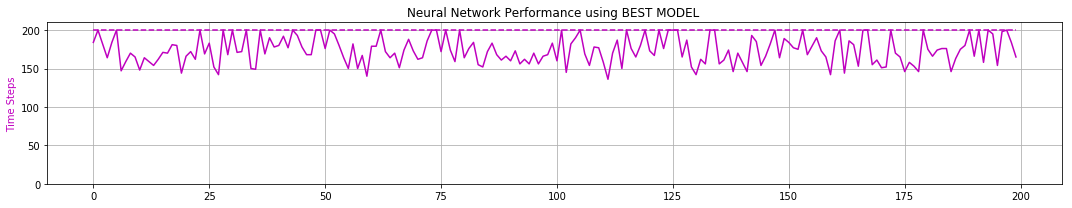

peak memory: 1457.28 MiB, increment: 1017.00 MiB
0 -max- [ 0.193  0.637  0.050  0.915]
0 -min- [-2.399 -3.137 -0.209 -1.061]

1 -max- [ 0.191  0.825  0.050  0.530]
1 -min- [-2.400 -3.144 -0.209 -1.231]

2 -max- [ 0.191  0.638  0.049  0.849]
2 -min- [-2.400 -2.970 -0.209 -1.402]

3 -max- [ 0.176  0.831  0.050  0.668]
3 -min- [-2.400 -3.080 -0.209 -1.221]

4 -max- [ 0.170  0.635  0.049  0.778]
4 -min- [-2.400 -2.973 -0.208 -1.311]

5 -max- [ 0.195  0.829  0.049  0.664]
5 -min- [-2.400 -3.146 -0.209 -1.344]

6 -max- [ 0.192  0.635  0.049  0.914]
6 -min- [-2.400 -2.968 -0.209 -1.240]

7 -max- [ 0.189  0.834  0.051  0.537]
7 -min- [-2.400 -3.125 -0.209 -1.280]

8 -max- [ 0.191  0.638  0.050  0.854]
8 -min- [-2.400 -2.969 -0.209 -1.389]

9 -max- [ 0.178  0.827  0.049  0.419]
9 -min- [-2.400 -3.145 -0.209 -1.252]

Quantization TIME:  0.01 minutes


ITERATION # 34
SMALLEST TIMESTEP in ITERATION 34: 14
REAL TIME TO GENERATE 99981 EXPERIENCES:0:00:02.463445


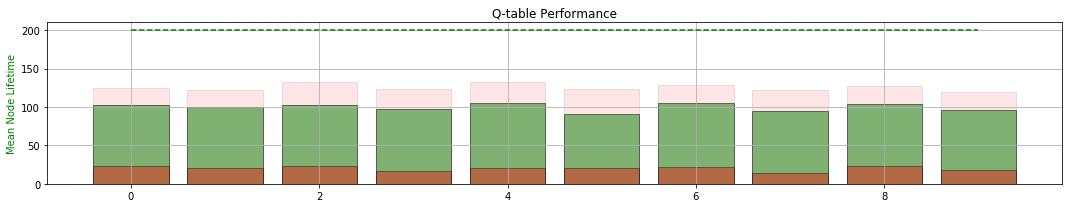

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.711	LOSS : 1.558	LOSS : 1.951	LOSS : 1.905	LOSS : 1.757	LOSS : 1.873	LOSS : 1.828	LOSS : 2.119	LOSS : 1.856	LOSS : 1.390	
Validating... MEAN TIME:  139.59
LOSS : 1.773	LOSS : 1.707	LOSS : 2.231	LOSS : 2.090	LOSS : 1.756	LOSS : 1.902	LOSS : 1.523	LOSS : 1.694	LOSS : 1.439	LOSS : 1.819	
Validating... MEAN TIME:  130.97
LOSS : 1.533	LOSS : 1.688	LOSS : 1.942	LOSS : 1.649	LOSS : 1.928	LOSS : 1.863	LOSS : 1.886	LOSS : 2.019	LOSS : 1.730	LOSS : 1.850	
Validating... MEAN TIME:  131.305
LOSS : 1.734	LOSS : 1.892	LOSS : 1.774	LOSS : 1.701	LOSS : 1.834	LOSS : 1.917	LOSS : 1.892	LOSS : 1.608	LOSS : 2.187	LOSS : 1.731	
Validating... MEAN TIME:  128.655
LOSS : 1.735	LOSS : 1.803	LOSS : 1.615	LOSS : 1.807	LOSS : 2.295	LOSS : 1.918	LOSS : 1.630	LOSS : 2.068	LOSS : 2.128	LOSS : 1.919	
Validating... MEAN TIME:  134.19
TRAINING TIME:0:00:29.259620


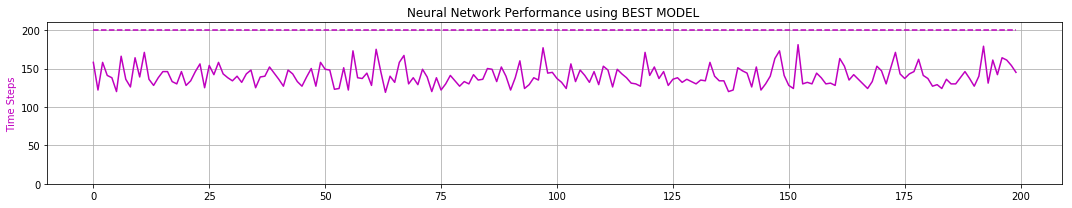

peak memory: 1468.01 MiB, increment: 1016.32 MiB
0 -max- [ 0.171  0.636  0.050  1.056]
0 -min- [-2.400 -2.966 -0.209 -1.719]

1 -max- [ 0.183  0.832  0.049  0.659]
1 -min- [-2.400 -2.959 -0.209 -1.395]

2 -max- [ 0.164  0.637  0.050  0.824]
2 -min- [-2.400 -2.954 -0.209 -1.643]

3 -max- [ 0.172  0.981  0.049  0.415]
3 -min- [-2.399 -2.958 -0.209 -1.450]

4 -max- [ 0.179  0.762  0.051  0.747]
4 -min- [-2.400 -2.902 -0.208 -1.715]

5 -max- [ 0.173  0.819  0.049  0.545]
5 -min- [-2.399 -3.131 -0.209 -1.336]

6 -max- [ 0.175  0.812  0.051  0.848]
6 -min- [-2.400 -2.976 -0.209 -1.671]

7 -max- [ 0.202  0.827  0.050  0.575]
7 -min- [-2.400 -3.078 -0.209 -1.675]

8 -max- [ 0.176  0.637  0.049  0.647]
8 -min- [-2.400 -2.977 -0.209 -1.697]

9 -max- [ 0.183  0.816  0.050  0.697]
9 -min- [-2.399 -3.145 -0.209 -1.400]

Quantization TIME:  0.01 minutes


ITERATION # 35
SMALLEST TIMESTEP in ITERATION 35: 12
REAL TIME TO GENERATE 64034 EXPERIENCES:0:00:01.633755


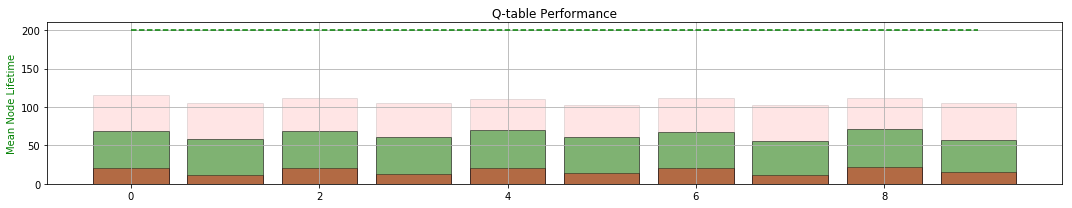

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.743	LOSS : 1.544	LOSS : 1.309	LOSS : 1.572	LOSS : 1.450	LOSS : 1.916	LOSS : 1.650	LOSS : 1.490	LOSS : 1.456	LOSS : 1.469	
Validating... MEAN TIME:  131.005
LOSS : 1.537	LOSS : 1.746	LOSS : 1.887	LOSS : 1.459	LOSS : 1.622	LOSS : 1.658	LOSS : 1.388	LOSS : 1.755	LOSS : 1.509	LOSS : 1.702	
Validating... MEAN TIME:  131.93
LOSS : 1.423	LOSS : 1.529	LOSS : 1.194	LOSS : 1.698	LOSS : 1.194	LOSS : 1.710	LOSS : 1.246	LOSS : 1.260	LOSS : 1.301	LOSS : 1.300	
Validating... MEAN TIME:  121.445
LOSS : 1.415	LOSS : 1.492	LOSS : 1.378	LOSS : 2.010	LOSS : 1.436	LOSS : 1.333	LOSS : 1.419	LOSS : 1.753	LOSS : 1.680	LOSS : 1.379	
Validating... MEAN TIME:  128.14
LOSS : 1.995	LOSS : 1.324	LOSS : 1.430	LOSS : 1.941	LOSS : 1.390	LOSS : 1.285	LOSS : 1.681	LOSS : 1.454	LOSS : 1.419	LOSS : 1.369	
Validating... MEAN TIME:  129.565
TRAINING TIME:0:00:28.388958


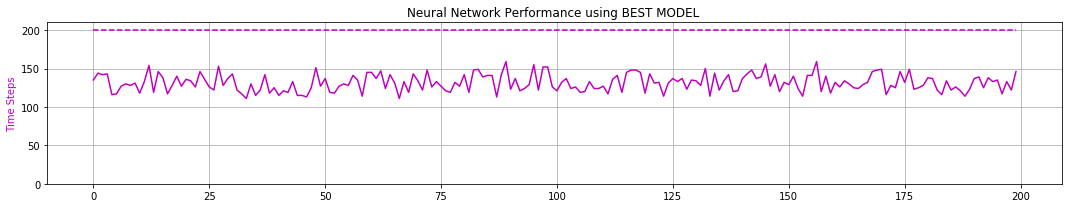

peak memory: 1423.79 MiB, increment: 1034.27 MiB
0 -max- [ 0.183  0.982  0.049  0.628]
0 -min- [-2.399 -3.126 -0.209 -1.346]

1 -max- [ 0.196  0.833  0.050  0.637]
1 -min- [-2.397 -3.278 -0.209 -1.389]

2 -max- [ 0.180  0.635  0.049  0.846]
2 -min- [-2.400 -3.144 -0.209 -1.059]

3 -max- [ 0.183  0.989  0.049  0.682]
3 -min- [-2.386 -3.157 -0.209 -1.511]

4 -max- [ 0.185  0.637  0.052  0.876]
4 -min- [-2.392 -3.121 -0.209 -1.048]

5 -max- [ 0.183  1.006  0.051  0.576]
5 -min- [-2.394 -3.137 -0.209 -1.358]

6 -max- [ 0.191  0.639  0.050  0.623]
6 -min- [-2.398 -3.159 -0.209 -1.038]

7 -max- [ 0.178  0.791  0.049  0.568]
7 -min- [-2.387 -3.095 -0.209 -1.308]

8 -max- [ 0.179  0.994  0.051  0.623]
8 -min- [-2.397 -3.150 -0.209 -1.353]

9 -max- [ 0.181  1.002  0.051  0.665]
9 -min- [-2.399 -3.276 -0.209 -1.555]

Quantization TIME:  0.01 minutes


ITERATION # 36
SMALLEST TIMESTEP in ITERATION 36: 12
REAL TIME TO GENERATE 54762 EXPERIENCES:0:00:01.251595


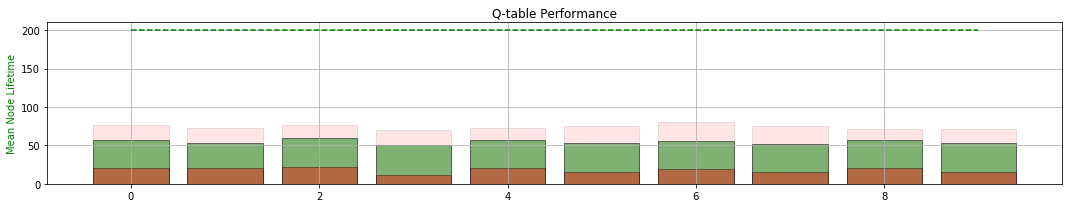

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.267	LOSS : 1.305	LOSS : 1.479	LOSS : 1.427	LOSS : 1.566	LOSS : 1.262	LOSS : 1.429	LOSS : 1.550	LOSS : 1.250	LOSS : 1.348	
Validating... MEAN TIME:  118.145
LOSS : 1.489	LOSS : 1.478	LOSS : 1.270	LOSS : 1.310	LOSS : 1.464	LOSS : 1.606	LOSS : 1.506	LOSS : 1.294	LOSS : 1.496	LOSS : 1.639	
Validating... MEAN TIME:  122.785
LOSS : 1.353	LOSS : 1.380	LOSS : 1.562	LOSS : 1.638	LOSS : 1.746	LOSS : 1.412	LOSS : 1.210	LOSS : 1.312	LOSS : 1.806	LOSS : 1.212	
Validating... MEAN TIME:  124.385
LOSS : 1.469	LOSS : 1.392	LOSS : 1.521	LOSS : 1.217	LOSS : 1.593	LOSS : 1.282	LOSS : 1.312	LOSS : 1.274	LOSS : 1.476	LOSS : 1.732	
Validating... MEAN TIME:  117.99
LOSS : 1.395	LOSS : 1.365	LOSS : 1.400	LOSS : 1.756	LOSS : 1.581	LOSS : 1.422	LOSS : 1.549	LOSS : 1.381	LOSS : 1.307	LOSS : 1.374	
Validating... MEAN TIME:  122.05
TRAINING TIME:0:00:27.769448


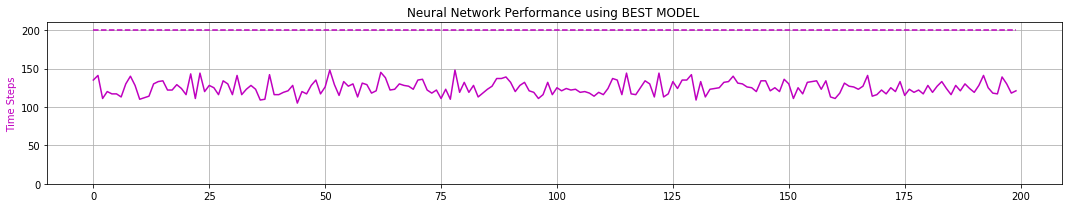

peak memory: 1463.77 MiB, increment: 1017.42 MiB
0 -max- [ 0.172  0.737  0.050  0.795]
0 -min- [-0.972 -1.785 -0.209 -1.065]

1 -max- [ 0.180  0.831  0.049  0.394]
1 -min- [-0.731 -1.677 -0.209 -1.243]

2 -max- [ 0.180  0.640  0.049  0.834]
2 -min- [-0.917 -1.774 -0.209 -1.058]

3 -max- [ 0.193  0.834  0.049  0.396]
3 -min- [-0.723 -1.663 -0.209 -1.374]

4 -max- [ 0.189  0.812  0.051  0.875]
4 -min- [-0.903 -1.813 -0.209 -1.065]

5 -max- [ 0.191  0.819  0.050  0.580]
5 -min- [-0.815 -1.786 -0.209 -1.336]

6 -max- [ 0.178  0.639  0.049  0.769]
6 -min- [-0.945 -1.828 -0.209 -1.058]

7 -max- [ 0.184  0.825  0.050  0.555]
7 -min- [-0.829 -1.682 -0.209 -1.418]

8 -max- [ 0.182  0.799  0.051  0.697]
8 -min- [-0.889 -1.842 -0.209 -1.065]

9 -max- [ 0.186  0.782  0.047  0.394]
9 -min- [-0.791 -1.787 -0.209 -1.164]

Quantization TIME:  0.01 minutes


ITERATION # 37
SMALLEST TIMESTEP in ITERATION 37: 13
REAL TIME TO GENERATE 48267 EXPERIENCES:0:00:01.226362


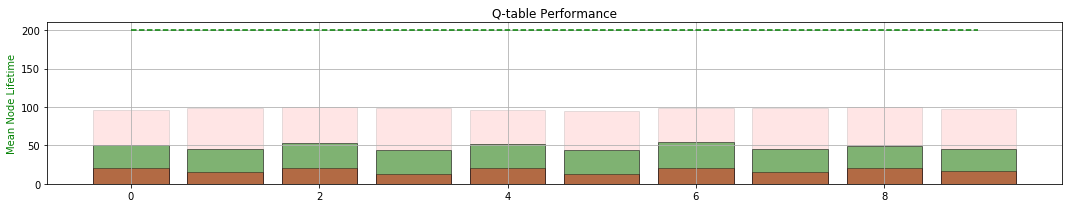

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.531	LOSS : 1.719	LOSS : 1.505	LOSS : 1.331	LOSS : 1.689	LOSS : 1.624	LOSS : 1.704	LOSS : 1.886	LOSS : 1.406	LOSS : 1.694	
Validating... MEAN TIME:  122.295
LOSS : 1.655	LOSS : 2.025	LOSS : 1.440	LOSS : 1.613	LOSS : 1.681	LOSS : 1.618	LOSS : 1.200	LOSS : 1.908	LOSS : 1.729	LOSS : 1.413	
Validating... MEAN TIME:  135.52
LOSS : 1.841	LOSS : 1.413	LOSS : 1.944	LOSS : 1.353	LOSS : 1.448	LOSS : 1.652	LOSS : 1.312	LOSS : 1.757	LOSS : 1.724	LOSS : 1.421	
Validating... MEAN TIME:  152.065
LOSS : 1.643	LOSS : 1.108	LOSS : 1.783	LOSS : 1.353	LOSS : 1.898	LOSS : 1.701	LOSS : 1.479	LOSS : 1.392	LOSS : 1.765	LOSS : 1.690	
Validating... MEAN TIME:  155.91
LOSS : 1.627	LOSS : 1.521	LOSS : 1.746	LOSS : 1.948	LOSS : 1.695	LOSS : 1.446	LOSS : 1.605	LOSS : 1.839	LOSS : 1.430	LOSS : 1.884	
Validating... MEAN TIME:  183.61
TRAINING TIME:0:00:33.165802


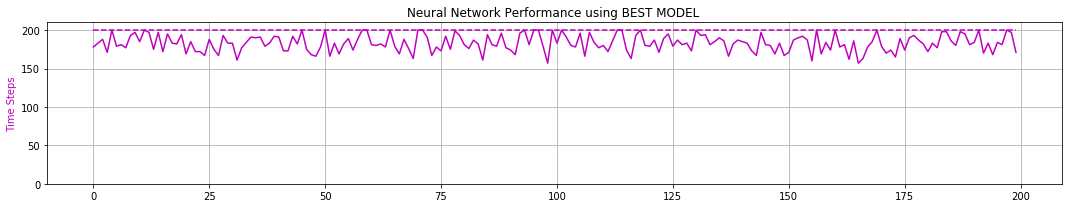

peak memory: 1390.65 MiB, increment: 1016.29 MiB
0 -max- [ 0.188  0.637  0.049  0.661]
0 -min- [-2.351 -3.288 -0.209 -1.059]

1 -max- [ 0.183  0.823  0.049  0.701]
1 -min- [-2.368 -3.449 -0.209 -1.167]

2 -max- [ 0.189  0.791  0.049  0.761]
2 -min- [-2.391 -3.306 -0.209 -1.069]

3 -max- [ 0.190  0.837  0.051  0.705]
3 -min- [-2.376 -3.455 -0.209 -1.399]

4 -max- [ 0.194  0.743  0.050  0.708]
4 -min- [-2.389 -3.259 -0.209 -1.064]

5 -max- [ 0.186  0.834  0.049  0.703]
5 -min- [-2.395 -3.447 -0.209 -1.494]

6 -max- [ 0.189  0.799  0.050  0.738]
6 -min- [-2.393 -3.457 -0.209 -1.081]

7 -max- [ 0.185  0.802  0.051  0.658]
7 -min- [-2.339 -3.340 -0.209 -1.252]

8 -max- [ 0.194  0.749  0.047  0.707]
8 -min- [-2.390 -3.454 -0.209 -1.071]

9 -max- [ 0.205  0.831  0.050  0.607]
9 -min- [-2.350 -3.274 -0.209 -1.282]

Quantization TIME:  0.01 minutes


ITERATION # 38
SMALLEST TIMESTEP in ITERATION 38: 15
REAL TIME TO GENERATE 84554 EXPERIENCES:0:00:02.209666


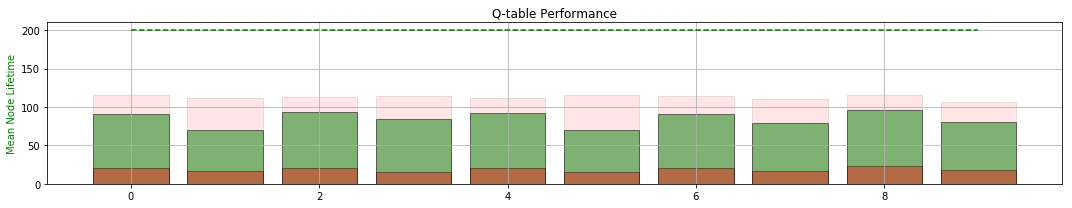

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.537	LOSS : 1.760	LOSS : 1.863	LOSS : 1.505	LOSS : 1.466	LOSS : 1.551	LOSS : 1.364	LOSS : 1.651	LOSS : 1.723	LOSS : 1.508	
Validating... MEAN TIME:  128.23
LOSS : 2.000	LOSS : 1.492	LOSS : 1.518	LOSS : 1.387	LOSS : 1.681	LOSS : 1.693	LOSS : 1.522	LOSS : 1.879	LOSS : 1.703	LOSS : 1.658	
Validating... MEAN TIME:  120.47
LOSS : 1.568	LOSS : 1.622	LOSS : 1.894	LOSS : 1.516	LOSS : 1.311	LOSS : 1.512	LOSS : 1.665	LOSS : 1.721	LOSS : 1.606	LOSS : 1.988	
Validating... MEAN TIME:  119.09
LOSS : 1.425	LOSS : 1.680	LOSS : 1.339	LOSS : 1.519	LOSS : 1.941	LOSS : 1.614	LOSS : 1.718	LOSS : 1.479	LOSS : 1.565	LOSS : 1.643	
Validating... MEAN TIME:  119.73
LOSS : 1.737	LOSS : 1.745	LOSS : 1.681	LOSS : 1.525	LOSS : 1.685	LOSS : 1.355	LOSS : 1.673	LOSS : 1.612	LOSS : 1.510	LOSS : 1.937	
Validating... MEAN TIME:  115.78
TRAINING TIME:0:00:27.518651


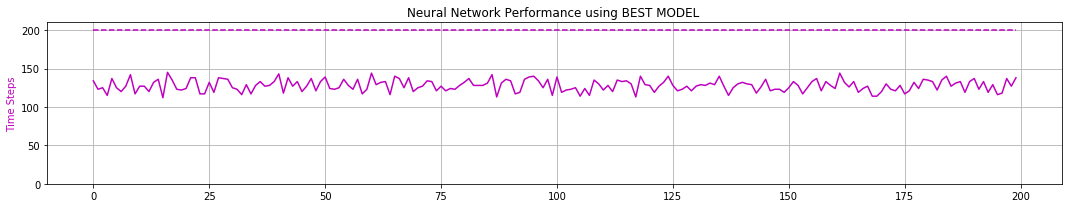

peak memory: 1445.62 MiB, increment: 1023.31 MiB
0 -max- [ 0.208  0.765  0.119  1.284]
0 -min- [-2.400 -3.309 -0.209 -1.067]

1 -max- [ 0.189  0.829  0.087  0.935]
1 -min- [-2.398 -3.313 -0.209 -1.263]

2 -max- [ 0.189  0.812  0.141  1.078]
2 -min- [-2.398 -2.973 -0.209 -1.065]

3 -max- [ 0.204  0.827  0.101  0.967]
3 -min- [-2.400 -3.361 -0.209 -1.254]

4 -max- [ 0.178  0.639  0.118  1.141]
4 -min- [-2.398 -2.958 -0.209 -1.047]

5 -max- [ 0.191  0.830  0.073  1.018]
5 -min- [-2.400 -3.364 -0.209 -1.306]

6 -max- [ 0.177  0.799  0.136  1.083]
6 -min- [-2.400 -2.969 -0.209 -1.072]

7 -max- [ 0.186  0.806  0.106  1.010]
7 -min- [-2.400 -3.285 -0.209 -1.310]

8 -max- [ 0.181  0.637  0.121  1.030]
8 -min- [-2.399 -2.937 -0.209 -1.012]

9 -max- [ 0.179  0.804  0.102  0.976]
9 -min- [-2.396 -3.173 -0.209 -1.192]

Quantization TIME:  0.01 minutes


ITERATION # 39
SMALLEST TIMESTEP in ITERATION 39: 11
REAL TIME TO GENERATE 37356 EXPERIENCES:0:00:01.092623


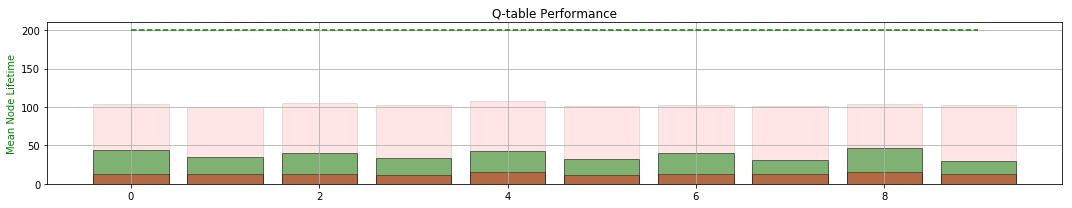

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.192	LOSS : 1.909	LOSS : 1.882	LOSS : 1.910	LOSS : 1.930	LOSS : 1.760	LOSS : 1.684	LOSS : 2.112	LOSS : 1.785	LOSS : 1.679	
Validating... MEAN TIME:  124.705
LOSS : 2.146	LOSS : 1.803	LOSS : 1.792	LOSS : 1.550	LOSS : 2.105	LOSS : 1.518	LOSS : 1.883	LOSS : 1.821	LOSS : 1.569	LOSS : 1.968	
Validating... MEAN TIME:  133.67
LOSS : 1.963	LOSS : 1.659	LOSS : 1.901	LOSS : 2.267	LOSS : 1.921	LOSS : 1.902	LOSS : 1.682	LOSS : 1.779	LOSS : 1.800	LOSS : 2.126	
Validating... MEAN TIME:  138.85
LOSS : 2.168	LOSS : 2.120	LOSS : 2.032	LOSS : 1.541	LOSS : 1.873	LOSS : 1.747	LOSS : 1.853	LOSS : 1.742	LOSS : 1.701	LOSS : 1.838	
Validating... MEAN TIME:  150.1
LOSS : 1.806	LOSS : 1.498	LOSS : 2.136	LOSS : 2.306	LOSS : 1.757	LOSS : 1.840	LOSS : 1.924	LOSS : 1.865	LOSS : 1.810	LOSS : 1.780	
Validating... MEAN TIME:  164.37
TRAINING TIME:0:00:31.090757


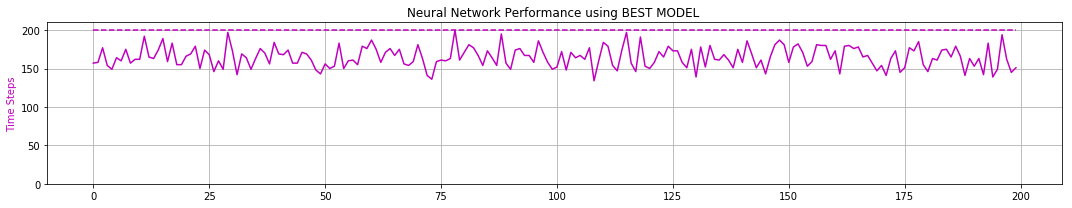

peak memory: 1424.27 MiB, increment: 1064.46 MiB
0 -max- [ 0.189  0.637  0.049  0.723]
0 -min- [-2.400 -3.336 -0.209 -1.098]

1 -max- [ 0.198  0.833  0.051  0.714]
1 -min- [-2.399 -3.336 -0.209 -1.290]

2 -max- [ 0.212  0.742  0.059  1.055]
2 -min- [-2.397 -3.358 -0.209 -1.099]

3 -max- [ 0.206  0.827  0.049  0.713]
3 -min- [-2.395 -3.265 -0.209 -1.403]

4 -max- [ 0.197  0.799  0.050  0.914]
4 -min- [-2.398 -3.329 -0.209 -1.081]

5 -max- [ 0.193  0.834  0.051  0.726]
5 -min- [-2.397 -3.314 -0.209 -1.377]

6 -max- [ 0.193  0.641  0.047  0.712]
6 -min- [-2.393 -3.349 -0.209 -1.090]

7 -max- [ 0.189  0.819  0.050  0.714]
7 -min- [-2.398 -3.326 -0.209 -1.396]

8 -max- [ 0.185  0.640  0.048  0.969]
8 -min- [-2.394 -3.448 -0.209 -1.091]

9 -max- [ 0.214  1.021  0.050  0.700]
9 -min- [-2.392 -3.281 -0.209 -1.564]

Quantization TIME:  0.01 minutes


ITERATION # 40
SMALLEST TIMESTEP in ITERATION 40: 11
REAL TIME TO GENERATE 79200 EXPERIENCES:0:00:01.968078


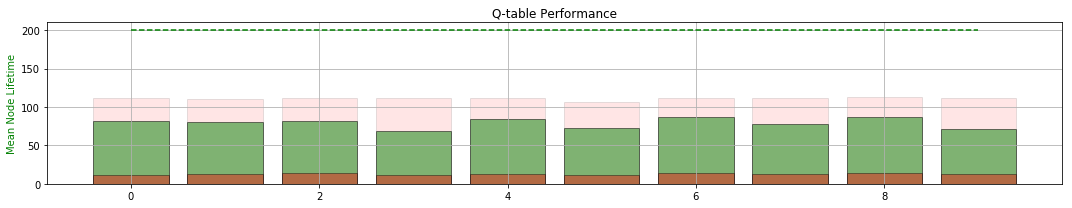

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.680	LOSS : 2.032	LOSS : 1.836	LOSS : 1.848	LOSS : 1.646	LOSS : 2.117	LOSS : 2.361	LOSS : 1.659	LOSS : 1.560	LOSS : 1.929	
Validating... MEAN TIME:  164.315
LOSS : 1.798	LOSS : 1.988	LOSS : 1.543	LOSS : 2.286	LOSS : 2.170	LOSS : 1.953	LOSS : 1.826	LOSS : 1.609	LOSS : 1.970	LOSS : 1.826	
Validating... MEAN TIME:  187.47
LOSS : 1.900	LOSS : 1.891	LOSS : 2.063	LOSS : 2.096	LOSS : 2.035	LOSS : 1.642	LOSS : 1.893	LOSS : 1.812	LOSS : 1.638	LOSS : 1.549	
Validating... MEAN TIME:  189.205
LOSS : 1.719	LOSS : 1.843	LOSS : 1.616	LOSS : 1.994	LOSS : 1.654	LOSS : 1.822	LOSS : 1.458	LOSS : 1.446	LOSS : 1.746	LOSS : 1.943	
Validating... MEAN TIME:  177.26
LOSS : 1.462	LOSS : 1.980	LOSS : 2.093	LOSS : 1.733	LOSS : 1.999	LOSS : 1.674	LOSS : 2.009	LOSS : 1.746	LOSS : 1.779	LOSS : 1.914	
Validating... MEAN TIME:  154.805
TRAINING TIME:0:00:38.180913


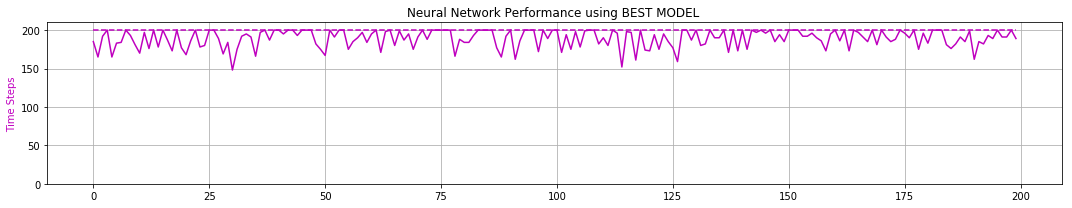

peak memory: 1415.12 MiB, increment: 1006.36 MiB
0 -max- [ 0.190  0.812  0.056  0.799]
0 -min- [-2.400 -2.959 -0.209 -1.105]

1 -max- [ 0.198  1.006  0.050  0.612]
1 -min- [-2.398 -3.250 -0.209 -1.527]

2 -max- [ 0.198  0.768  0.049  0.838]
2 -min- [-2.399 -2.964 -0.209 -1.099]

3 -max- [ 0.202  0.827  0.050  0.637]
3 -min- [-2.399 -3.161 -0.209 -1.421]

4 -max- [ 0.185  0.799  0.051  0.901]
4 -min- [-2.400 -2.954 -0.209 -1.097]

5 -max- [ 0.194  0.828  0.047  0.633]
5 -min- [-2.400 -3.165 -0.209 -1.366]

6 -max- [ 0.187  0.639  0.050  0.863]
6 -min- [-2.399 -3.149 -0.209 -1.086]

7 -max- [ 0.177  0.983  0.048  0.637]
7 -min- [-2.397 -3.320 -0.209 -1.544]

8 -max- [ 0.190  0.788  0.050  0.875]
8 -min- [-2.399 -2.949 -0.209 -1.085]

9 -max- [ 0.186  0.829  0.050  0.609]
9 -min- [-2.399 -3.128 -0.209 -1.316]

Quantization TIME:  0.01 minutes


ITERATION # 41
SMALLEST TIMESTEP in ITERATION 41: 11
REAL TIME TO GENERATE 88229 EXPERIENCES:0:00:02.296274


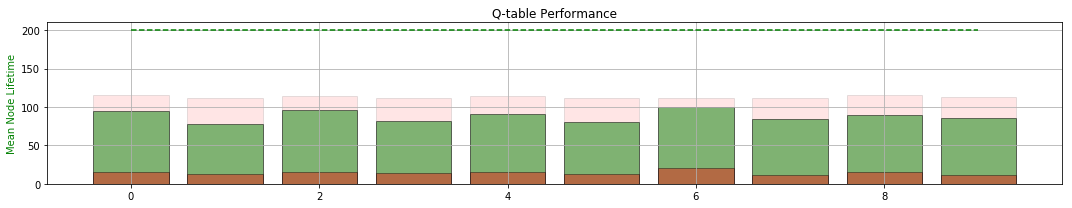

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.275	LOSS : 1.319	LOSS : 1.722	LOSS : 1.393	LOSS : 1.442	LOSS : 1.177	LOSS : 1.550	LOSS : 1.750	LOSS : 1.885	LOSS : 1.252	
Validating... MEAN TIME:  130.055
LOSS : 1.535	LOSS : 1.337	LOSS : 1.608	LOSS : 1.373	LOSS : 1.568	LOSS : 1.549	LOSS : 1.696	LOSS : 1.531	LOSS : 1.557	LOSS : 1.497	
Validating... MEAN TIME:  123.525
LOSS : 1.941	LOSS : 1.523	LOSS : 1.366	LOSS : 1.352	LOSS : 1.917	LOSS : 1.500	LOSS : 1.848	LOSS : 1.422	LOSS : 1.293	LOSS : 1.269	
Validating... MEAN TIME:  122.565
LOSS : 1.517	LOSS : 1.701	LOSS : 1.684	LOSS : 1.401	LOSS : 1.744	LOSS : 1.496	LOSS : 1.645	LOSS : 1.328	LOSS : 1.517	LOSS : 1.620	
Validating... MEAN TIME:  121.18
LOSS : 1.495	LOSS : 1.348	LOSS : 1.956	LOSS : 1.477	LOSS : 1.724	LOSS : 1.324	LOSS : 1.610	LOSS : 1.758	LOSS : 1.688	LOSS : 1.192	
Validating... MEAN TIME:  112.45
TRAINING TIME:0:00:28.175285


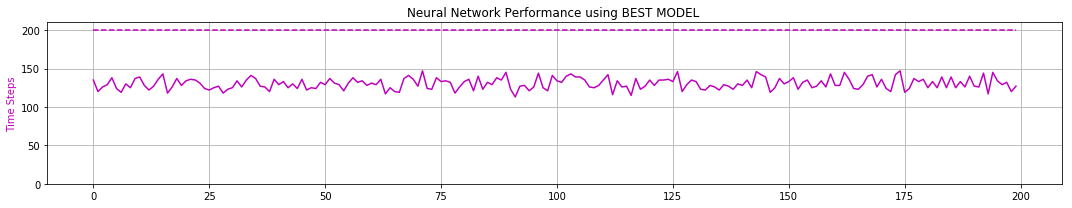

peak memory: 1403.47 MiB, increment: 1016.80 MiB
0 -max- [ 0.191  0.743  0.050  0.682]
0 -min- [-2.400 -2.963 -0.209 -1.087]

1 -max- [ 0.187  0.827  0.049  0.621]
1 -min- [-2.400 -2.948 -0.209 -1.313]

2 -max- [ 0.185  0.799  0.050  0.722]
2 -min- [-2.399 -2.941 -0.208 -1.085]

3 -max- [ 0.205  0.984  0.051  0.617]
3 -min- [-2.400 -3.146 -0.209 -1.491]

4 -max- [ 0.186  0.641  0.047  0.671]
4 -min- [-2.399 -2.949 -0.209 -1.085]

5 -max- [ 0.181  0.811  0.050  0.608]
5 -min- [-2.400 -2.974 -0.209 -1.308]

6 -max- [ 0.177  0.640  0.048  0.860]
6 -min- [-2.400 -2.958 -0.209 -1.082]

7 -max- [ 0.204  0.826  0.050  0.597]
7 -min- [-2.400 -3.069 -0.209 -1.315]

8 -max- [ 0.189  0.641  0.050  0.831]
8 -min- [-2.399 -3.151 -0.209 -1.087]

9 -max- [ 0.181  0.802  0.050  0.594]
9 -min- [-2.396 -3.119 -0.209 -1.274]

Quantization TIME:  0.01 minutes


ITERATION # 42
SMALLEST TIMESTEP in ITERATION 42: 11
REAL TIME TO GENERATE 37735 EXPERIENCES:0:00:00.985153


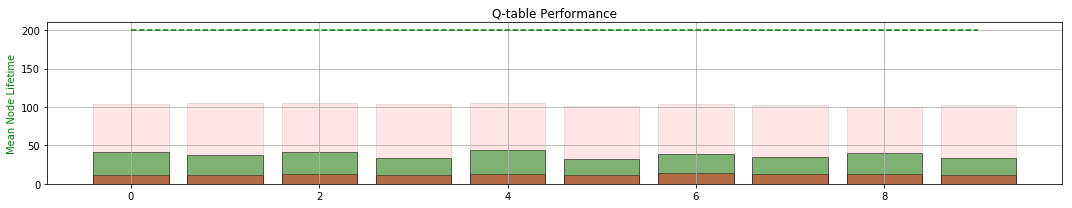

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.770	LOSS : 1.249	LOSS : 1.500	LOSS : 1.496	LOSS : 1.595	LOSS : 1.857	LOSS : 1.813	LOSS : 1.753	LOSS : 1.644	LOSS : 1.540	
Validating... MEAN TIME:  119.95
LOSS : 1.441	LOSS : 1.579	LOSS : 1.929	LOSS : 1.688	LOSS : 1.527	LOSS : 1.582	LOSS : 1.841	LOSS : 2.000	LOSS : 2.146	LOSS : 1.756	
Validating... MEAN TIME:  115.29
LOSS : 1.607	LOSS : 1.829	LOSS : 1.259	LOSS : 1.582	LOSS : 1.509	LOSS : 1.757	LOSS : 2.013	LOSS : 1.735	LOSS : 1.860	LOSS : 1.812	
Validating... MEAN TIME:  116.51
LOSS : 1.656	LOSS : 1.719	LOSS : 1.554	LOSS : 1.763	LOSS : 1.760	LOSS : 1.754	LOSS : 1.706	LOSS : 1.604	LOSS : 1.709	LOSS : 1.746	
Validating... MEAN TIME:  118.93
LOSS : 1.809	LOSS : 1.562	LOSS : 1.674	LOSS : 1.751	LOSS : 1.510	LOSS : 1.728	LOSS : 1.606	LOSS : 1.495	LOSS : 1.523	LOSS : 1.366	
Validating... MEAN TIME:  122.14
TRAINING TIME:0:00:27.371187


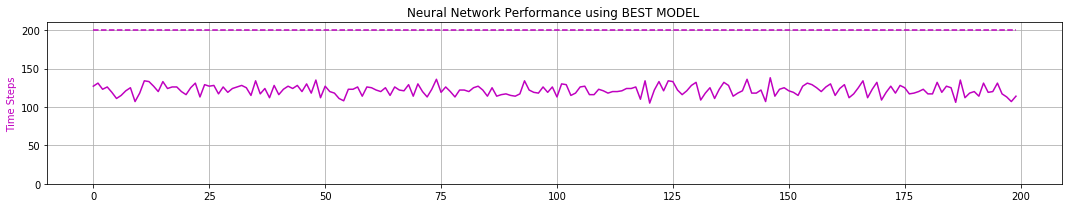

peak memory: 1397.00 MiB, increment: 971.39 MiB
0 -max- [ 0.199  0.641  0.049  0.636]
0 -min- [-2.400 -3.312 -0.209 -1.100]

1 -max- [ 0.197  0.999  0.050  0.582]
1 -min- [-2.400 -3.153 -0.209 -1.505]

2 -max- [ 0.193  0.993  0.051  0.581]
2 -min- [-2.399 -3.275 -0.209 -1.347]

3 -max- [ 0.201  0.829  0.047  0.397]
3 -min- [-2.399 -3.149 -0.209 -1.374]

4 -max- [ 0.195  0.642  0.050  0.649]
4 -min- [-2.399 -3.252 -0.209 -1.097]

5 -max- [ 0.204  1.011  0.048  0.603]
5 -min- [-2.397 -3.155 -0.209 -1.618]

6 -max- [ 0.198  0.983  0.050  0.594]
6 -min- [-2.400 -3.132 -0.209 -1.353]

7 -max- [ 0.194  0.809  0.050  0.390]
7 -min- [-2.393 -3.149 -0.209 -1.399]

8 -max- [ 0.187  0.925  0.050  0.610]
8 -min- [-2.399 -3.161 -0.209 -1.361]

9 -max- [ 0.207  0.828  0.050  0.395]
9 -min- [-2.392 -3.157 -0.209 -1.402]

Quantization TIME:  0.01 minutes


ITERATION # 43
SMALLEST TIMESTEP in ITERATION 43: 12
REAL TIME TO GENERATE 40388 EXPERIENCES:0:00:01.077832


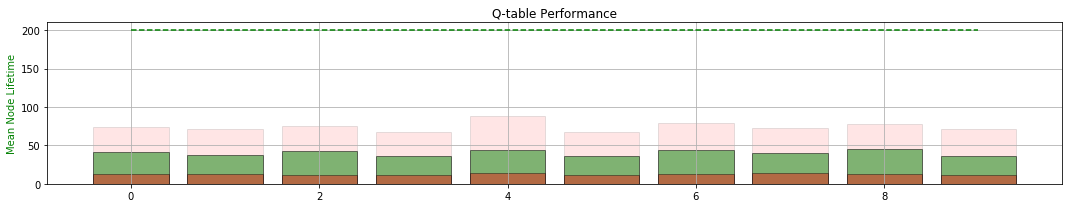

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.222	LOSS : 1.924	LOSS : 1.919	LOSS : 1.987	LOSS : 1.792	LOSS : 2.369	LOSS : 1.674	LOSS : 1.481	LOSS : 1.871	LOSS : 2.249	
Validating... MEAN TIME:  121.21
LOSS : 1.543	LOSS : 2.147	LOSS : 1.960	LOSS : 1.847	LOSS : 2.090	LOSS : 1.827	LOSS : 1.801	LOSS : 1.635	LOSS : 2.002	LOSS : 1.671	
Validating... MEAN TIME:  127.645
LOSS : 2.038	LOSS : 1.804	LOSS : 1.485	LOSS : 1.653	LOSS : 1.457	LOSS : 1.706	LOSS : 2.339	LOSS : 2.109	LOSS : 1.703	LOSS : 1.723	
Validating... MEAN TIME:  138.805
LOSS : 1.917	LOSS : 1.838	LOSS : 1.882	LOSS : 1.845	LOSS : 2.104	LOSS : 1.927	LOSS : 1.975	LOSS : 1.898	LOSS : 1.935	LOSS : 1.664	
Validating... MEAN TIME:  148.27
LOSS : 1.825	LOSS : 2.078	LOSS : 1.916	LOSS : 1.990	LOSS : 1.558	LOSS : 2.086	LOSS : 2.103	LOSS : 1.704	LOSS : 1.577	LOSS : 1.917	
Validating... MEAN TIME:  152.12
TRAINING TIME:0:00:30.712117


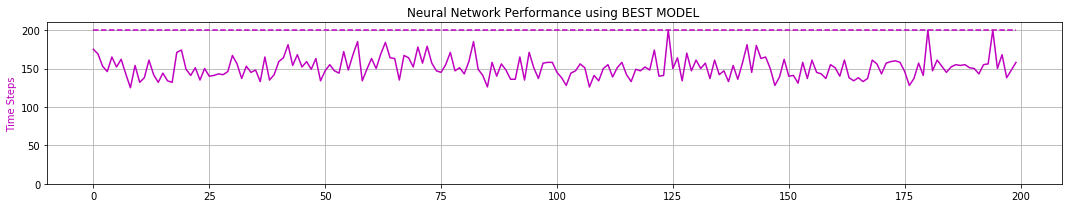

peak memory: 1420.83 MiB, increment: 1034.13 MiB
0 -max- [ 0.189  0.800  0.050  0.597]
0 -min- [-1.107 -2.160 -0.209 -1.105]

1 -max- [ 0.185  0.836  0.051  0.582]
1 -min- [-0.965 -2.056 -0.209 -1.353]

2 -max- [ 0.186  0.782  0.052  0.627]
2 -min- [-1.030 -2.155 -0.209 -1.090]

3 -max- [ 0.181  1.017  0.050  0.591]
3 -min- [-0.945 -2.057 -0.209 -1.516]

4 -max- [ 0.177  0.640  0.048  0.866]
4 -min- [-1.454 -2.220 -0.209 -1.089]

5 -max- [ 0.190  0.986  0.050  0.581]
5 -min- [-0.851 -2.001 -0.209 -1.598]

6 -max- [ 0.197  0.642  0.051  0.618]
6 -min- [-1.051 -2.036 -0.209 -1.087]

7 -max- [ 0.179  0.817  0.050  0.582]
7 -min- [-0.923 -2.000 -0.209 -1.287]

8 -max- [ 0.199  0.638  0.050  0.602]
8 -min- [-1.061 -2.020 -0.209 -1.102]

9 -max- [ 0.179  0.821  0.048  0.600]
9 -min- [-0.938 -2.059 -0.209 -1.329]

Quantization TIME:  0.01 minutes


ITERATION # 44
SMALLEST TIMESTEP in ITERATION 44: 11
REAL TIME TO GENERATE 63188 EXPERIENCES:0:00:01.512688


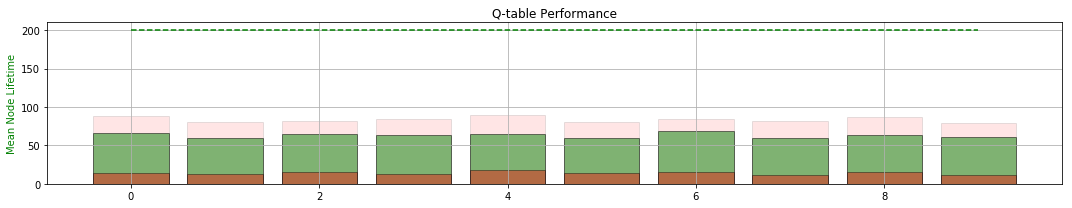

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.780	LOSS : 1.561	LOSS : 1.717	LOSS : 1.984	LOSS : 1.690	LOSS : 1.680	LOSS : 1.867	LOSS : 1.773	LOSS : 1.703	LOSS : 1.873	
Validating... MEAN TIME:  139.8
LOSS : 2.177	LOSS : 1.587	LOSS : 1.999	LOSS : 2.004	LOSS : 1.735	LOSS : 1.670	LOSS : 1.818	LOSS : 1.942	LOSS : 1.894	LOSS : 1.509	
Validating... MEAN TIME:  159.335
LOSS : 1.705	LOSS : 1.453	LOSS : 1.838	LOSS : 1.338	LOSS : 1.661	LOSS : 1.998	LOSS : 1.266	LOSS : 2.020	LOSS : 1.861	LOSS : 1.973	
Validating... MEAN TIME:  157.57
LOSS : 1.848	LOSS : 1.701	LOSS : 1.581	LOSS : 2.092	LOSS : 1.700	LOSS : 2.200	LOSS : 1.739	LOSS : 1.658	LOSS : 1.602	LOSS : 2.136	
Validating... MEAN TIME:  161.765
LOSS : 1.889	LOSS : 1.999	LOSS : 1.861	LOSS : 1.445	LOSS : 2.054	LOSS : 1.799	LOSS : 1.815	LOSS : 1.934	LOSS : 1.862	LOSS : 1.679	
Validating... MEAN TIME:  166.795
TRAINING TIME:0:00:33.324512


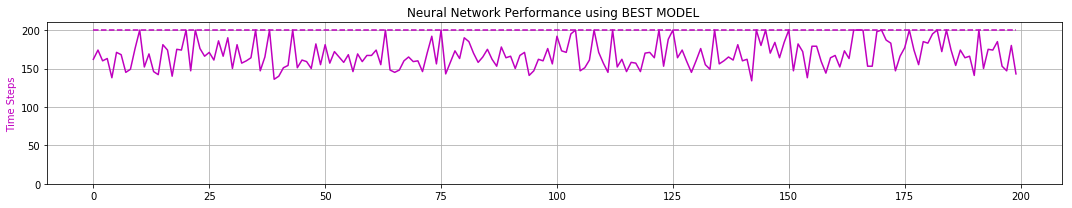

peak memory: 1454.62 MiB, increment: 1028.99 MiB
0 -max- [ 0.169  0.799  0.051  0.748]
0 -min- [-1.319 -2.175 -0.209 -1.093]

1 -max- [ 0.178  0.821  0.047  0.581]
1 -min- [-1.246 -2.175 -0.209 -1.356]

2 -max- [ 0.180  0.637  0.050  0.607]
2 -min- [-1.350 -2.174 -0.209 -1.095]

3 -max- [ 0.169  0.834  0.048  0.535]
3 -min- [-1.328 -2.179 -0.209 -1.342]

4 -max- [ 0.182  0.788  0.050  0.846]
4 -min- [-1.437 -2.143 -0.209 -1.071]

5 -max- [ 0.183  1.022  0.050  0.607]
5 -min- [-1.326 -2.177 -0.209 -1.499]

6 -max- [ 0.171  0.634  0.050  0.636]
6 -min- [-1.578 -2.184 -0.209 -1.092]

7 -max- [ 0.192  0.833  0.050  0.413]
7 -min- [-1.338 -2.173 -0.209 -1.384]

8 -max- [ 0.172  0.637  0.048  0.838]
8 -min- [-1.411 -2.165 -0.209 -1.096]

9 -max- [ 0.199  0.836  0.049  0.403]
9 -min- [-1.247 -2.169 -0.209 -1.486]

Quantization TIME:  0.01 minutes


ITERATION # 45
SMALLEST TIMESTEP in ITERATION 45: 12
REAL TIME TO GENERATE 65510 EXPERIENCES:0:00:01.607083


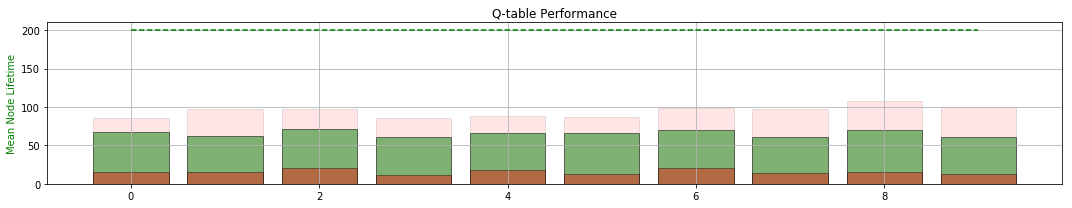

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.119	LOSS : 1.884	LOSS : 1.745	LOSS : 2.040	LOSS : 1.930	LOSS : 1.810	LOSS : 1.583	LOSS : 2.102	LOSS : 1.714	LOSS : 1.697	
Validating... MEAN TIME:  164.02
LOSS : 1.312	LOSS : 2.228	LOSS : 1.954	LOSS : 1.870	LOSS : 1.620	LOSS : 1.915	LOSS : 1.771	LOSS : 1.823	LOSS : 1.453	LOSS : 1.842	
Validating... MEAN TIME:  149.985
LOSS : 2.307	LOSS : 1.685	LOSS : 2.055	LOSS : 2.059	LOSS : 1.928	LOSS : 1.684	LOSS : 1.944	LOSS : 1.786	LOSS : 1.681	LOSS : 1.690	
Validating... MEAN TIME:  154.905
LOSS : 2.070	LOSS : 1.864	LOSS : 1.802	LOSS : 2.150	LOSS : 2.007	LOSS : 1.711	LOSS : 2.198	LOSS : 2.049	LOSS : 1.844	LOSS : 1.814	
Validating... MEAN TIME:  169.8
LOSS : 2.196	LOSS : 1.786	LOSS : 1.830	LOSS : 2.082	LOSS : 1.702	LOSS : 1.943	LOSS : 2.047	LOSS : 1.638	LOSS : 2.021	LOSS : 1.627	
Validating... MEAN TIME:  149.19
TRAINING TIME:0:00:33.367014


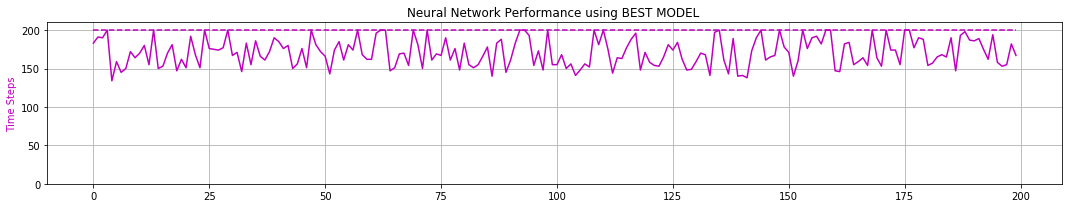

peak memory: 1424.79 MiB, increment: 1015.50 MiB
0 -max- [ 0.178  0.641  0.047  0.640]
0 -min- [-1.501 -2.553 -0.209 -1.065]

1 -max- [ 0.201  0.820  0.050  0.607]
1 -min- [-2.356 -3.236 -0.209 -1.279]

2 -max- [ 0.169  0.640  0.048  0.892]
2 -min- [-1.690 -2.564 -0.209 -1.089]

3 -max- [ 0.182  0.823  0.050  0.396]
3 -min- [-1.368 -2.378 -0.209 -1.198]

4 -max- [ 0.184  0.642  0.054  0.615]
4 -min- [-1.600 -2.380 -0.209 -1.087]

5 -max- [ 0.179  0.828  0.050  0.405]
5 -min- [-1.651 -2.427 -0.209 -1.255]

6 -max- [ 0.194  0.638  0.054  0.848]
6 -min- [-2.394 -3.107 -0.209 -1.084]

7 -max- [ 0.171  0.820  0.048  0.396]
7 -min- [-2.381 -3.111 -0.209 -1.478]

8 -max- [ 0.197  0.808  0.049  0.697]
8 -min- [-2.386 -3.152 -0.209 -1.083]

9 -max- [ 0.194  0.817  0.050  0.399]
9 -min- [-2.368 -3.244 -0.209 -1.392]

Quantization TIME:  0.01 minutes


ITERATION # 46
SMALLEST TIMESTEP in ITERATION 46: 11
REAL TIME TO GENERATE 76276 EXPERIENCES:0:00:01.865574


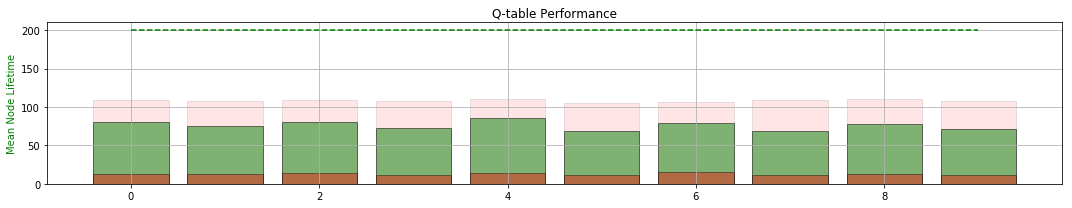

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.081	LOSS : 2.054	LOSS : 1.669	LOSS : 1.545	LOSS : 2.234	LOSS : 1.824	LOSS : 1.848	LOSS : 2.048	LOSS : 2.398	LOSS : 2.234	
Validating... MEAN TIME:  144.01
LOSS : 1.903	LOSS : 1.989	LOSS : 1.450	LOSS : 2.075	LOSS : 2.068	LOSS : 1.950	LOSS : 1.847	LOSS : 1.736	LOSS : 1.791	LOSS : 1.635	
Validating... MEAN TIME:  148.395
LOSS : 1.858	LOSS : 2.116	LOSS : 2.228	LOSS : 2.006	LOSS : 2.105	LOSS : 2.055	LOSS : 2.195	LOSS : 2.200	LOSS : 1.913	LOSS : 1.718	
Validating... MEAN TIME:  143.16
LOSS : 2.098	LOSS : 1.693	LOSS : 2.235	LOSS : 2.225	LOSS : 1.643	LOSS : 1.802	LOSS : 1.900	LOSS : 1.943	LOSS : 2.061	LOSS : 2.019	
Validating... MEAN TIME:  128.79
LOSS : 1.905	LOSS : 1.986	LOSS : 1.945	LOSS : 1.802	LOSS : 2.357	LOSS : 1.666	LOSS : 1.987	LOSS : 2.276	LOSS : 1.987	LOSS : 2.210	
Validating... MEAN TIME:  130.585
TRAINING TIME:0:00:31.342569


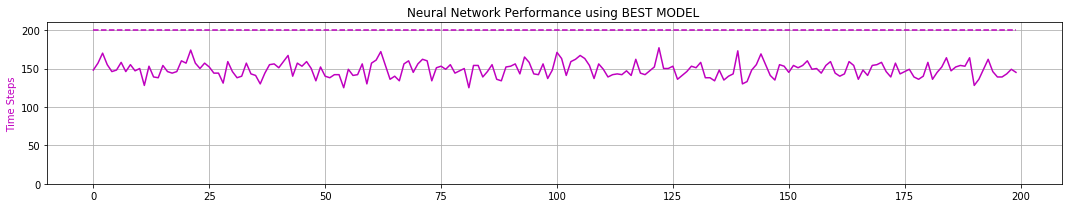

peak memory: 1426.22 MiB, increment: 978.14 MiB
0 -max- [ 0.181  0.637  0.051  0.610]
0 -min- [-2.399 -3.260 -0.209 -1.095]

1 -max- [ 0.177  0.825  0.048  0.538]
1 -min- [-2.398 -3.312 -0.209 -1.256]

2 -max- [ 0.182  0.788  0.050  0.802]
2 -min- [-2.398 -3.284 -0.209 -1.069]

3 -max- [ 0.178  0.822  0.050  0.598]
3 -min- [-2.398 -3.241 -0.209 -1.217]

4 -max- [ 0.179  0.635  0.050  0.867]
4 -min- [-2.399 -3.315 -0.209 -1.101]

5 -max- [ 0.199  1.171  0.050  0.609]
5 -min- [-2.392 -3.260 -0.209 -1.680]

6 -max- [ 0.175  0.637  0.048  0.807]
6 -min- [-2.398 -3.151 -0.209 -1.096]

7 -max- [ 0.194  1.179  0.049  0.615]
7 -min- [-2.399 -3.283 -0.209 -1.828]

8 -max- [ 0.202  0.754  0.050  0.640]
8 -min- [-2.397 -3.279 -0.209 -1.096]

9 -max- [ 0.199  0.814  0.049  0.598]
9 -min- [-2.399 -3.274 -0.209 -1.369]

Quantization TIME:  0.01 minutes


ITERATION # 47
SMALLEST TIMESTEP in ITERATION 47: 11
REAL TIME TO GENERATE 57338 EXPERIENCES:0:00:01.435007


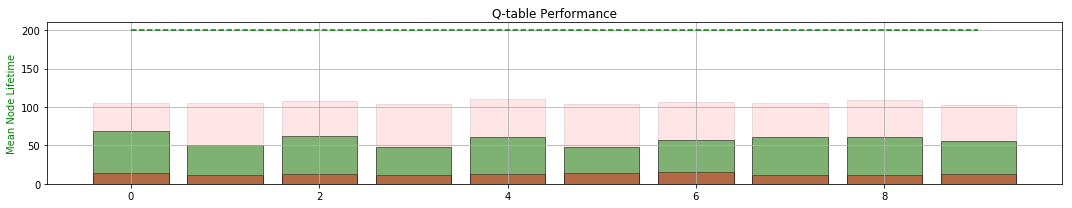

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.984	LOSS : 1.682	LOSS : 1.700	LOSS : 1.843	LOSS : 1.850	LOSS : 1.849	LOSS : 1.346	LOSS : 1.987	LOSS : 1.888	LOSS : 1.963	
Validating... MEAN TIME:  115.535
LOSS : 1.639	LOSS : 1.793	LOSS : 1.572	LOSS : 1.810	LOSS : 2.105	LOSS : 1.854	LOSS : 1.975	LOSS : 1.961	LOSS : 1.908	LOSS : 1.725	
Validating... MEAN TIME:  110.29
LOSS : 1.573	LOSS : 1.734	LOSS : 2.103	LOSS : 1.846	LOSS : 1.709	LOSS : 1.826	LOSS : 1.642	LOSS : 2.049	LOSS : 1.954	LOSS : 1.805	
Validating... MEAN TIME:  107.62
LOSS : 2.234	LOSS : 1.757	LOSS : 1.679	LOSS : 1.522	LOSS : 2.090	LOSS : 1.936	LOSS : 1.780	LOSS : 1.889	LOSS : 1.786	LOSS : 1.605	
Validating... MEAN TIME:  105.82
LOSS : 1.787	LOSS : 1.970	LOSS : 1.980	LOSS : 1.962	LOSS : 2.133	LOSS : 1.949	LOSS : 1.684	LOSS : 1.919	LOSS : 1.887	LOSS : 2.033	
Validating... MEAN TIME:  109.005
TRAINING TIME:0:00:24.998112


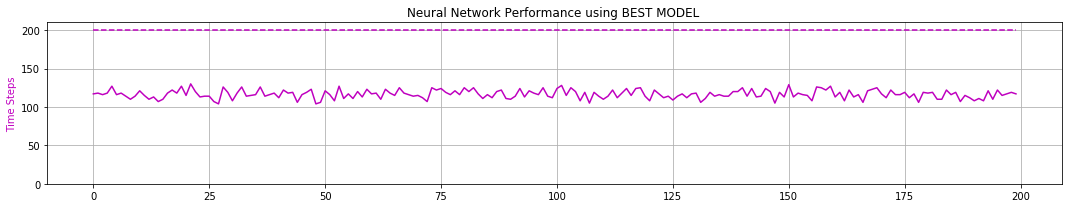

peak memory: 1400.51 MiB, increment: 996.44 MiB
0 -max- [ 0.185  0.999  0.051  0.704]
0 -min- [-2.400 -3.346 -0.209 -1.341]

1 -max- [ 0.198  0.983  0.050  0.700]
1 -min- [-2.398 -3.353 -0.209 -1.353]

2 -max- [ 0.194  0.642  0.050  0.697]
2 -min- [-2.399 -3.329 -0.209 -1.086]

3 -max- [ 0.195  0.825  0.050  0.681]
3 -min- [-2.399 -3.349 -0.209 -1.266]

4 -max- [ 0.202  0.639  0.050  1.072]
4 -min- [-2.400 -3.454 -0.209 -1.091]

5 -max- [ 0.197  0.826  0.048  0.706]
5 -min- [-2.397 -3.356 -0.209 -1.429]

6 -max- [ 0.199  0.808  0.049  0.865]
6 -min- [-2.400 -3.352 -0.209 -1.095]

7 -max- [ 0.211  0.829  0.050  0.700]
7 -min- [-2.400 -3.505 -0.209 -1.389]

8 -max- [ 0.207  0.642  0.052  0.685]
8 -min- [-2.400 -3.339 -0.209 -1.103]

9 -max- [ 0.200  0.974  0.050  0.702]
9 -min- [-2.399 -3.513 -0.209 -1.353]

Quantization TIME:  0.01 minutes


ITERATION # 48
SMALLEST TIMESTEP in ITERATION 48: 11
REAL TIME TO GENERATE 25550 EXPERIENCES:0:00:00.757330


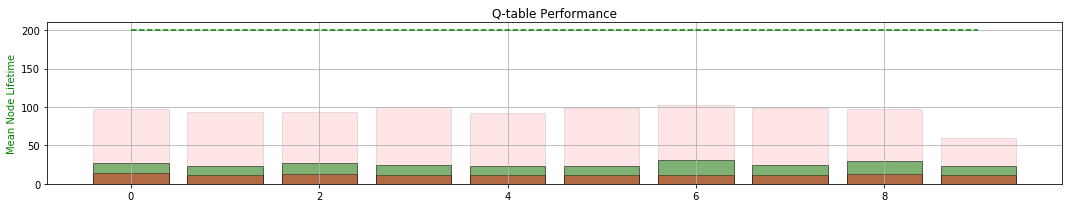

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.647	LOSS : 2.151	LOSS : 2.054	LOSS : 2.098	LOSS : 1.814	LOSS : 2.173	LOSS : 1.699	LOSS : 1.694	LOSS : 1.719	LOSS : 1.556	
Validating... MEAN TIME:  107.4
LOSS : 2.179	LOSS : 2.101	LOSS : 2.044	LOSS : 1.956	LOSS : 1.889	LOSS : 2.308	LOSS : 1.871	LOSS : 1.809	LOSS : 2.212	LOSS : 1.912	
Validating... MEAN TIME:  110.8
LOSS : 1.847	LOSS : 1.957	LOSS : 2.076	LOSS : 2.169	LOSS : 2.331	LOSS : 2.171	LOSS : 1.813	LOSS : 1.835	LOSS : 2.127	LOSS : 1.858	
Validating... MEAN TIME:  107.83
LOSS : 1.618	LOSS : 1.925	LOSS : 2.299	LOSS : 1.857	LOSS : 2.300	LOSS : 2.167	LOSS : 2.289	LOSS : 2.253	LOSS : 1.857	LOSS : 2.241	
Validating... MEAN TIME:  109.885
LOSS : 1.973	LOSS : 1.935	LOSS : 2.121	LOSS : 2.091	LOSS : 2.198	LOSS : 2.110	LOSS : 2.029	LOSS : 2.277	LOSS : 1.867	LOSS : 2.117	
Validating... MEAN TIME:  111.295
TRAINING TIME:0:00:25.141676


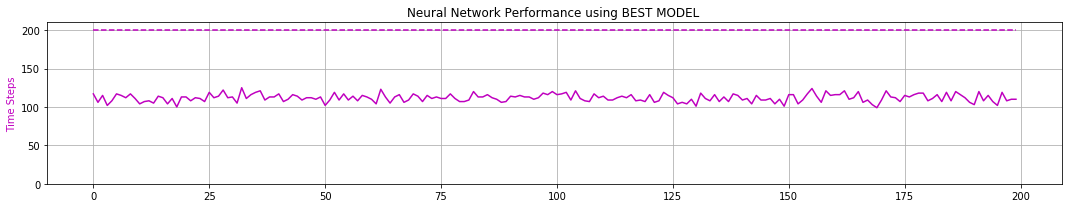

peak memory: 1405.55 MiB, increment: 1035.32 MiB
0 -max- [ 0.213  0.983  0.051  0.714]
0 -min- [-2.354 -3.144 -0.209 -1.372]

1 -max- [ 0.202  1.155  0.050  0.384]
1 -min- [-2.382 -3.095 -0.209 -1.662]

2 -max- [ 0.192  0.969  0.050  0.527]
2 -min- [-2.398 -2.970 -0.209 -1.381]

3 -max- [ 0.210  1.023  0.050  0.383]
3 -min- [-2.400 -3.077 -0.209 -1.679]

4 -max- [ 0.198  1.022  0.048  0.616]
4 -min- [-2.383 -3.151 -0.209 -1.379]

5 -max- [ 0.217  1.003  0.049  0.383]
5 -min- [-2.346 -3.076 -0.209 -1.403]

6 -max- [ 0.213  0.980  0.050  0.612]
6 -min- [-2.397 -3.243 -0.209 -1.369]

7 -max- [ 0.215  0.951  0.049  0.391]
7 -min- [-2.388 -3.249 -0.209 -1.393]

8 -max- [ 0.208  0.975  0.050  0.712]
8 -min- [-2.382 -3.153 -0.209 -1.369]

9 -max- [ 0.199  0.992  0.050  0.383]
9 -min- [-0.651 -1.691 -0.209 -1.729]

Quantization TIME:  0.01 minutes


ITERATION # 49
SMALLEST TIMESTEP in ITERATION 49: 12
REAL TIME TO GENERATE 26510 EXPERIENCES:0:00:00.731423


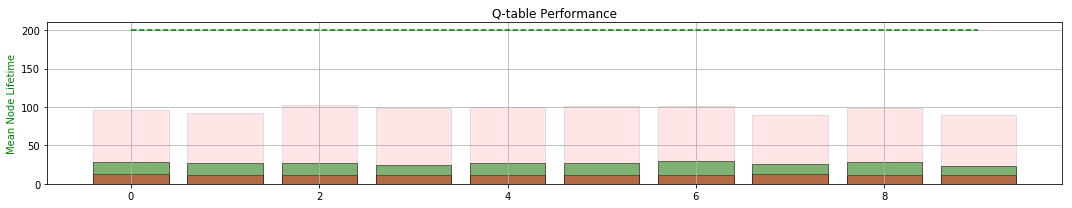

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.437	LOSS : 1.717	LOSS : 2.464	LOSS : 2.164	LOSS : 2.299	LOSS : 2.221	LOSS : 2.049	LOSS : 2.112	LOSS : 1.710	LOSS : 2.366	
Validating... MEAN TIME:  111.52
LOSS : 1.862	LOSS : 2.061	LOSS : 2.471	LOSS : 1.953	LOSS : 2.018	LOSS : 1.942	LOSS : 1.688	LOSS : 2.281	LOSS : 2.671	LOSS : 2.054	
Validating... MEAN TIME:  110.43
LOSS : 2.124	LOSS : 1.817	LOSS : 2.366	LOSS : 2.091	LOSS : 2.302	LOSS : 1.993	LOSS : 2.171	LOSS : 1.806	LOSS : 1.904	LOSS : 1.951	
Validating... MEAN TIME:  110.855
LOSS : 1.996	LOSS : 2.179	LOSS : 2.454	LOSS : 1.848	LOSS : 2.310	LOSS : 2.062	LOSS : 1.669	LOSS : 1.883	LOSS : 2.484	LOSS : 1.972	
Validating... MEAN TIME:  110.965
LOSS : 2.318	LOSS : 2.216	LOSS : 1.942	LOSS : 1.850	LOSS : 2.183	LOSS : 2.267	LOSS : 1.930	LOSS : 2.003	LOSS : 2.087	LOSS : 2.164	
Validating... MEAN TIME:  108.91
TRAINING TIME:0:00:25.360909


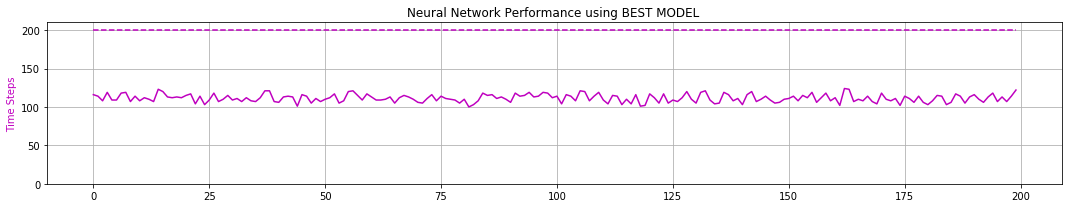

peak memory: 1455.44 MiB, increment: 1017.10 MiB
0 -max- [ 0.195  0.642  0.051  0.529]
0 -min- [-2.397 -2.963 -0.209 -1.102]

1 -max- [ 0.202  0.807  0.050  0.387]
1 -min- [-2.362 -3.052 -0.209 -1.366]

2 -max- [ 0.206  0.643  0.052  0.758]
2 -min- [-2.397 -3.119 -0.209 -1.100]

3 -max- [ 0.194  0.820  0.048  0.548]
3 -min- [-2.355 -3.152 -0.209 -1.430]

4 -max- [ 0.215  0.808  0.049  0.587]
4 -min- [-2.386 -2.966 -0.209 -1.095]

5 -max- [ 0.218  0.808  0.050  0.387]
5 -min- [-2.396 -3.087 -0.209 -1.329]

6 -max- [ 0.207  0.756  0.049  0.625]
6 -min- [-2.400 -3.133 -0.209 -1.103]

7 -max- [ 0.208  0.975  0.050  0.389]
7 -min- [-2.357 -2.960 -0.209 -1.431]

8 -max- [ 0.206  0.640  0.050  0.571]
8 -min- [-2.387 -3.083 -0.209 -1.096]

9 -max- [ 0.208  0.968  0.050  0.379]
9 -min- [-2.362 -3.082 -0.209 -1.553]

Quantization TIME:  0.01 minutes


ITERATION # 50
SMALLEST TIMESTEP in ITERATION 50: 10
REAL TIME TO GENERATE 27882 EXPERIENCES:0:00:00.755363


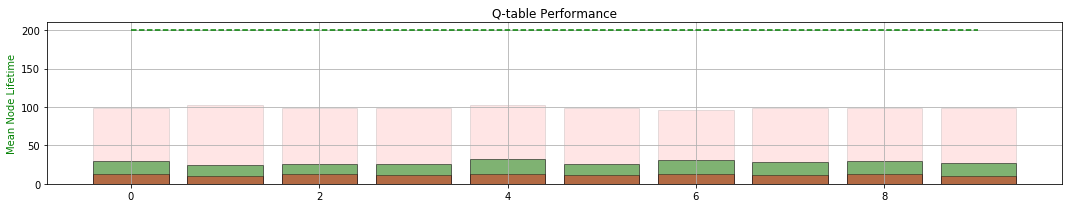

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.271	LOSS : 2.248	LOSS : 2.317	LOSS : 2.287	LOSS : 2.193	LOSS : 2.310	LOSS : 2.782	LOSS : 2.007	LOSS : 2.413	LOSS : 2.517	
Validating... MEAN TIME:  109.64
LOSS : 2.247	LOSS : 2.197	LOSS : 2.210	LOSS : 1.932	LOSS : 2.078	LOSS : 2.424	LOSS : 2.236	LOSS : 2.533	LOSS : 2.390	LOSS : 2.899	
Validating... MEAN TIME:  112.165
LOSS : 2.367	LOSS : 2.192	LOSS : 2.369	LOSS : 2.741	LOSS : 2.351	LOSS : 2.024	LOSS : 2.462	LOSS : 2.312	LOSS : 2.332	LOSS : 2.406	
Validating... MEAN TIME:  117.24
LOSS : 2.086	LOSS : 2.282	LOSS : 2.629	LOSS : 2.476	LOSS : 2.281	LOSS : 2.318	LOSS : 2.062	LOSS : 2.393	LOSS : 2.785	LOSS : 2.035	
Validating... MEAN TIME:  116.18
LOSS : 2.027	LOSS : 2.521	LOSS : 2.563	LOSS : 2.397	LOSS : 2.884	LOSS : 2.807	LOSS : 2.763	LOSS : 2.431	LOSS : 2.476	LOSS : 2.365	
Validating... MEAN TIME:  116.49
TRAINING TIME:0:00:25.827560


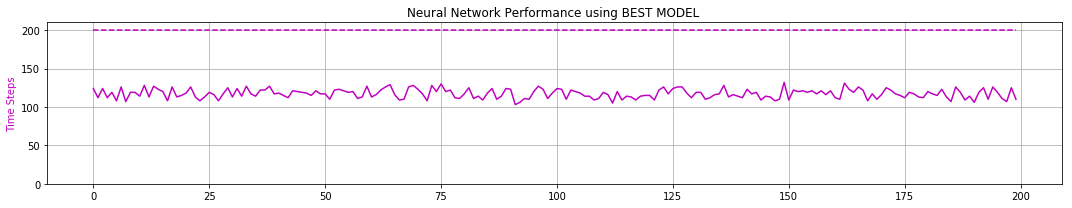

peak memory: 1396.14 MiB, increment: 1016.94 MiB
0 -max- [ 0.195  0.640  0.050  0.598]
0 -min- [-2.377 -2.932 -0.209 -1.097]

1 -max- [ 0.206  1.033  0.050  0.383]
1 -min- [-2.345 -2.880 -0.209 -1.687]

2 -max- [ 0.194  0.644  0.048  0.548]
2 -min- [-2.367 -2.969 -0.209 -1.101]

3 -max- [ 0.207  0.836  0.049  0.388]
3 -min- [-2.368 -3.087 -0.209 -1.478]

4 -max- [ 0.211  0.923  0.050  0.589]
4 -min- [-2.377 -3.050 -0.209 -1.330]

5 -max- [ 0.209  0.812  0.049  0.574]
5 -min- [-2.381 -3.108 -0.209 -1.420]

6 -max- [ 0.200  0.972  0.058  0.584]
6 -min- [-2.393 -2.953 -0.209 -1.308]

7 -max- [ 0.198  0.826  0.050  0.381]
7 -min- [-2.375 -3.058 -0.209 -1.468]

8 -max- [ 0.188  0.639  0.050  0.773]
8 -min- [-2.388 -3.160 -0.209 -1.090]

9 -max- [ 0.206  0.979  0.049  0.383]
9 -min- [-2.317 -2.936 -0.209 -1.729]

Quantization TIME:  0.01 minutes


ITERATION # 51
SMALLEST TIMESTEP in ITERATION 51: 11
REAL TIME TO GENERATE 39456 EXPERIENCES:0:00:01.066743


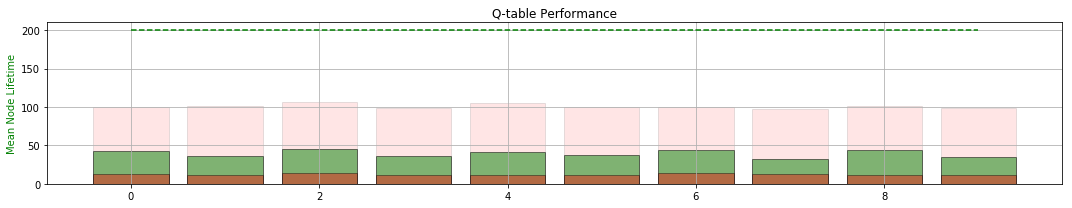

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.647	LOSS : 2.319	LOSS : 2.634	LOSS : 2.488	LOSS : 2.440	LOSS : 2.578	LOSS : 2.395	LOSS : 2.463	LOSS : 2.949	LOSS : 2.954	
Validating... MEAN TIME:  120.64
LOSS : 2.533	LOSS : 2.043	LOSS : 2.347	LOSS : 2.016	LOSS : 2.781	LOSS : 2.299	LOSS : 2.265	LOSS : 2.195	LOSS : 2.771	LOSS : 2.497	
Validating... MEAN TIME:  122.42
LOSS : 2.528	LOSS : 2.449	LOSS : 2.644	LOSS : 2.201	LOSS : 2.479	LOSS : 2.251	LOSS : 2.804	LOSS : 2.445	LOSS : 2.439	LOSS : 2.315	
Validating... MEAN TIME:  125.17
LOSS : 2.631	LOSS : 2.492	LOSS : 2.576	LOSS : 2.259	LOSS : 2.616	LOSS : 2.294	LOSS : 2.583	LOSS : 2.267	LOSS : 2.335	LOSS : 2.266	
Validating... MEAN TIME:  126.685
LOSS : 2.575	LOSS : 2.753	LOSS : 2.625	LOSS : 2.946	LOSS : 2.194	LOSS : 2.205	LOSS : 2.651	LOSS : 2.264	LOSS : 2.310	LOSS : 2.482	
Validating... MEAN TIME:  125.335
TRAINING TIME:0:00:28.021988


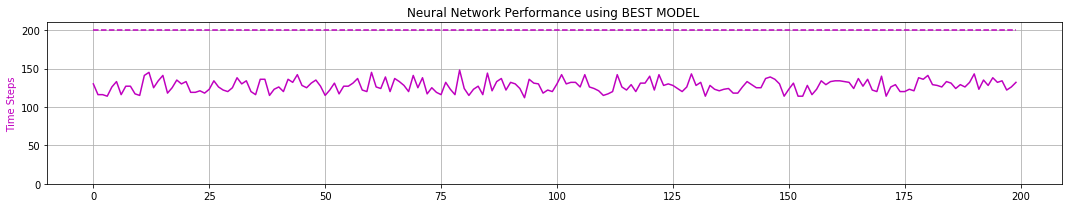

peak memory: 1430.56 MiB, increment: 1053.75 MiB
0 -max- [ 0.194  0.639  0.050  0.619]
0 -min- [-2.394 -2.889 -0.209 -1.084]

1 -max- [ 0.179  0.821  0.048  0.600]
1 -min- [-2.376 -3.089 -0.209 -1.344]

2 -max- [ 0.203  0.806  0.058  0.582]
2 -min- [-2.397 -3.090 -0.209 -1.101]

3 -max- [ 0.203  0.829  0.050  0.542]
3 -min- [-2.206 -2.877 -0.209 -1.250]

4 -max- [ 0.192  0.639  0.049  0.608]
4 -min- [-2.396 -3.070 -0.209 -1.103]

5 -max- [ 0.193  0.817  0.050  0.582]
5 -min- [-2.378 -3.072 -0.209 -1.443]

6 -max- [ 0.190  0.640  0.050  0.764]
6 -min- [-2.384 -2.920 -0.209 -1.093]

7 -max- [ 0.193  0.796  0.050  0.532]
7 -min- [-2.269 -2.882 -0.209 -1.273]

8 -max- [ 0.190  0.636  0.054  0.623]
8 -min- [-2.387 -3.053 -0.209 -1.096]

9 -max- [ 0.198  0.825  0.049  0.566]
9 -min- [-2.168 -2.755 -0.209 -1.268]

Quantization TIME:  0.01 minutes


ITERATION # 52
SMALLEST TIMESTEP in ITERATION 52: 11
REAL TIME TO GENERATE 45442 EXPERIENCES:0:00:01.201505


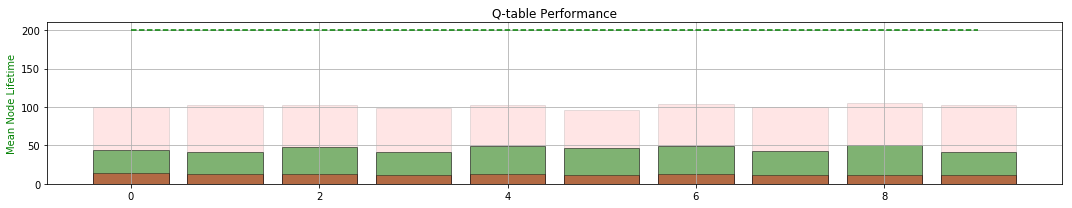

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.662	LOSS : 2.522	LOSS : 2.314	LOSS : 2.345	LOSS : 2.377	LOSS : 2.488	LOSS : 2.545	LOSS : 2.403	LOSS : 2.480	LOSS : 2.847	
Validating... MEAN TIME:  126.34
LOSS : 1.771	LOSS : 2.905	LOSS : 2.868	LOSS : 2.172	LOSS : 2.428	LOSS : 2.817	LOSS : 2.492	LOSS : 2.154	LOSS : 2.489	LOSS : 2.590	
Validating... MEAN TIME:  131.935
LOSS : 2.644	LOSS : 3.004	LOSS : 2.385	LOSS : 2.538	LOSS : 2.653	LOSS : 3.044	LOSS : 2.514	LOSS : 3.028	LOSS : 2.331	LOSS : 2.240	
Validating... MEAN TIME:  147.665
LOSS : 2.442	LOSS : 2.273	LOSS : 2.260	LOSS : 2.488	LOSS : 2.660	LOSS : 2.367	LOSS : 2.818	LOSS : 2.439	LOSS : 2.504	LOSS : 2.590	
Validating... MEAN TIME:  143.955
LOSS : 2.711	LOSS : 2.656	LOSS : 3.138	LOSS : 2.566	LOSS : 2.808	LOSS : 2.828	LOSS : 2.450	LOSS : 2.721	LOSS : 2.752	LOSS : 2.526	
Validating... MEAN TIME:  159.16
TRAINING TIME:0:00:32.072646


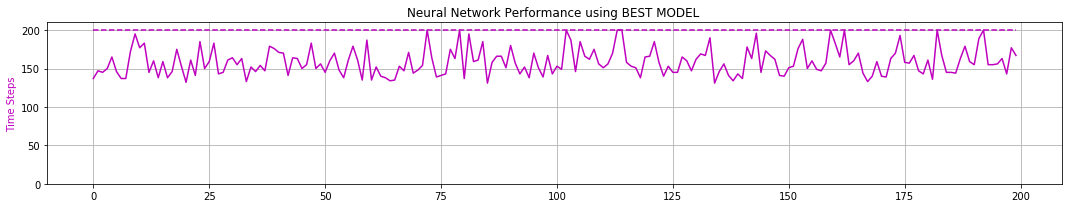

peak memory: 1457.32 MiB, increment: 1021.93 MiB
0 -max- [ 0.175  0.637  0.048  0.641]
0 -min- [-2.392 -3.058 -0.209 -1.097]

1 -max- [ 0.191  0.827  0.049  0.530]
1 -min- [-2.367 -2.955 -0.209 -1.422]

2 -max- [ 0.202  0.639  0.050  0.601]
2 -min- [-2.386 -3.047 -0.209 -1.078]

3 -max- [ 0.192  0.827  0.049  0.389]
3 -min- [-2.391 -2.914 -0.209 -1.387]

4 -max- [ 0.185  0.779  0.050  0.652]
4 -min- [-2.398 -3.100 -0.209 -1.094]

5 -max- [ 0.182  0.820  0.050  0.599]
5 -min- [-2.399 -3.081 -0.209 -1.299]

6 -max- [ 0.172  0.641  0.050  0.646]
6 -min- [-2.394 -3.054 -0.209 -1.087]

7 -max- [ 0.182  0.822  0.049  0.388]
7 -min- [-2.396 -3.055 -0.209 -1.394]

8 -max- [ 0.185  0.640  0.049  0.597]
8 -min- [-2.397 -3.052 -0.209 -1.099]

9 -max- [ 0.202  0.828  0.050  0.564]
9 -min- [-2.362 -3.075 -0.209 -1.367]

Quantization TIME:  0.01 minutes


ITERATION # 53
SMALLEST TIMESTEP in ITERATION 53: 12
REAL TIME TO GENERATE 58634 EXPERIENCES:0:00:01.441908


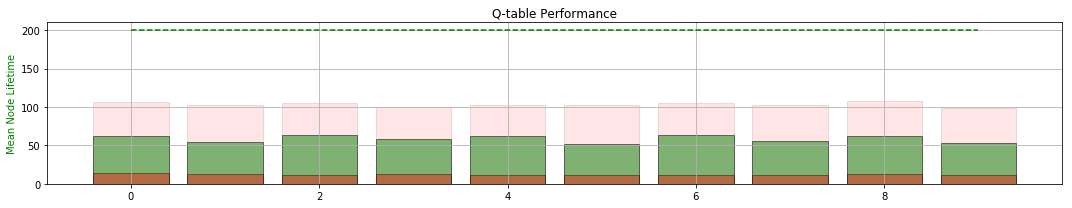

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.591	LOSS : 2.392	LOSS : 2.677	LOSS : 2.433	LOSS : 2.254	LOSS : 2.314	LOSS : 2.809	LOSS : 2.307	LOSS : 2.906	LOSS : 2.402	
Validating... MEAN TIME:  153.02
LOSS : 2.213	LOSS : 2.577	LOSS : 2.359	LOSS : 2.653	LOSS : 2.303	LOSS : 2.774	LOSS : 2.374	LOSS : 3.112	LOSS : 2.635	LOSS : 2.528	
Validating... MEAN TIME:  158.69
LOSS : 2.666	LOSS : 3.123	LOSS : 2.280	LOSS : 2.725	LOSS : 2.517	LOSS : 2.352	LOSS : 2.759	LOSS : 2.527	LOSS : 2.805	LOSS : 2.562	
Validating... MEAN TIME:  184.8
LOSS : 2.786	LOSS : 2.629	LOSS : 2.737	LOSS : 2.297	LOSS : 2.142	LOSS : 2.691	LOSS : 2.327	LOSS : 2.621	LOSS : 2.368	LOSS : 2.257	
Validating... MEAN TIME:  195.115
LOSS : 2.557	LOSS : 3.229	LOSS : 2.157	LOSS : 2.737	LOSS : 2.246	LOSS : 2.715	LOSS : 2.670	LOSS : 2.575	LOSS : 2.629	LOSS : 2.567	
Validating... MEAN TIME:  198.445
TRAINING TIME:0:00:37.979527


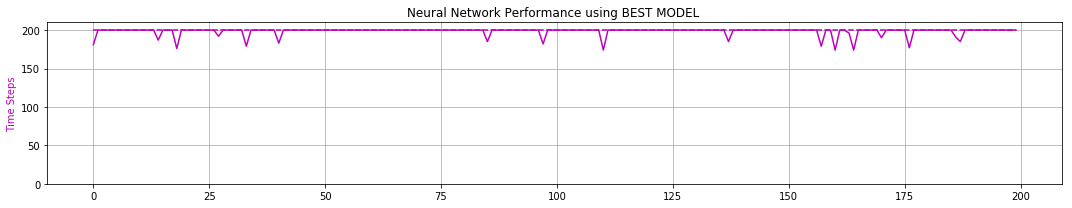

peak memory: 1458.95 MiB, increment: 978.07 MiB
0 -max- [ 0.191  0.808  0.049  0.704]
0 -min- [-2.383 -3.079 -0.209 -1.087]

1 -max- [ 0.200  0.827  0.050  0.545]
1 -min- [-2.389 -3.091 -0.209 -1.264]

2 -max- [ 0.199  0.755  0.049  0.791]
2 -min- [-2.398 -3.083 -0.209 -1.102]

3 -max- [ 0.185  0.828  0.050  0.594]
3 -min- [-2.391 -3.125 -0.209 -1.285]

4 -max- [ 0.175  0.640  0.050  0.645]
4 -min- [-2.393 -3.088 -0.209 -1.093]

5 -max- [ 0.184  0.838  0.050  0.589]
5 -min- [-2.377 -3.081 -0.209 -1.406]

6 -max- [ 0.182  0.755  0.049  0.822]
6 -min- [-2.397 -3.065 -0.209 -1.098]

7 -max- [ 0.183  0.824  0.049  0.584]
7 -min- [-2.372 -2.940 -0.209 -1.303]

8 -max- [ 0.188  0.768  0.050  0.610]
8 -min- [-2.372 -3.080 -0.209 -1.097]

9 -max- [ 0.165  0.819  0.049  0.599]
9 -min- [-2.398 -3.053 -0.209 -1.510]

Quantization TIME:  0.01 minutes


ITERATION # 54
SMALLEST TIMESTEP in ITERATION 54: 11
REAL TIME TO GENERATE 82286 EXPERIENCES:0:00:01.987932


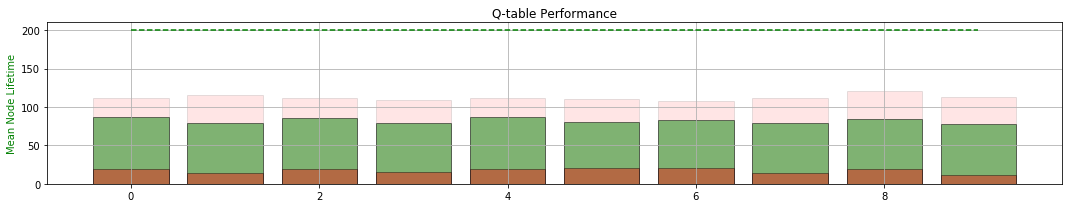

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.795	LOSS : 2.314	LOSS : 2.443	LOSS : 2.379	LOSS : 2.078	LOSS : 2.425	LOSS : 2.093	LOSS : 2.346	LOSS : 2.689	LOSS : 2.533	
Validating... MEAN TIME:  160.555
LOSS : 2.587	LOSS : 2.578	LOSS : 2.437	LOSS : 3.050	LOSS : 2.167	LOSS : 2.627	LOSS : 2.488	LOSS : 2.486	LOSS : 2.259	LOSS : 2.387	
Validating... MEAN TIME:  172.75
LOSS : 2.412	LOSS : 3.180	LOSS : 2.334	LOSS : 2.578	LOSS : 2.046	LOSS : 2.603	LOSS : 2.184	LOSS : 2.268	LOSS : 2.819	LOSS : 2.553	
Validating... MEAN TIME:  163.685
LOSS : 2.552	LOSS : 2.946	LOSS : 2.612	LOSS : 2.396	LOSS : 2.655	LOSS : 2.389	LOSS : 2.570	LOSS : 2.481	LOSS : 2.513	LOSS : 2.236	
Validating... MEAN TIME:  161.24
LOSS : 2.571	LOSS : 2.821	LOSS : 2.763	LOSS : 2.301	LOSS : 2.689	LOSS : 2.326	LOSS : 2.519	LOSS : 2.623	LOSS : 2.512	LOSS : 2.849	
Validating... MEAN TIME:  154.29
TRAINING TIME:0:00:34.200644


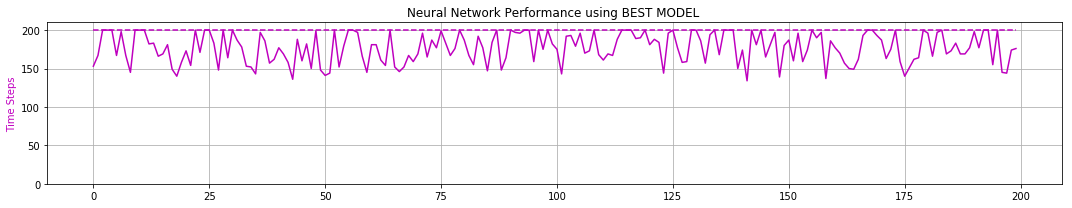

peak memory: 1409.07 MiB, increment: 972.57 MiB
0 -max- [ 0.193  0.639  0.050  0.776]
0 -min- [-2.399 -3.085 -0.209 -1.066]

1 -max- [ 0.195  0.780  0.049  0.406]
1 -min- [-2.395 -2.942 -0.209 -1.198]

2 -max- [ 0.174  0.779  0.050  0.793]
2 -min- [-2.398 -3.079 -0.209 -1.069]

3 -max- [ 0.172  0.814  0.050  0.410]
3 -min- [-2.396 -2.957 -0.209 -1.220]

4 -max- [ 0.169  0.638  0.050  0.886]
4 -min- [-2.400 -3.143 -0.209 -1.059]

5 -max- [ 0.180  0.825  0.049  0.406]
5 -min- [-2.399 -2.948 -0.209 -1.316]

6 -max- [ 0.175  0.640  0.049  0.742]
6 -min- [-2.396 -3.094 -0.209 -1.027]

7 -max- [ 0.192  0.814  0.050  0.412]
7 -min- [-2.399 -2.957 -0.209 -1.354]

8 -max- [ 0.164  0.640  0.049  0.767]
8 -min- [-2.394 -3.129 -0.209 -1.081]

9 -max- [ 0.169  0.807  0.049  0.398]
9 -min- [-2.396 -3.074 -0.209 -1.371]

Quantization TIME:  0.01 minutes


ITERATION # 55
SMALLEST TIMESTEP in ITERATION 55: 10
REAL TIME TO GENERATE 71027 EXPERIENCES:0:00:01.737174


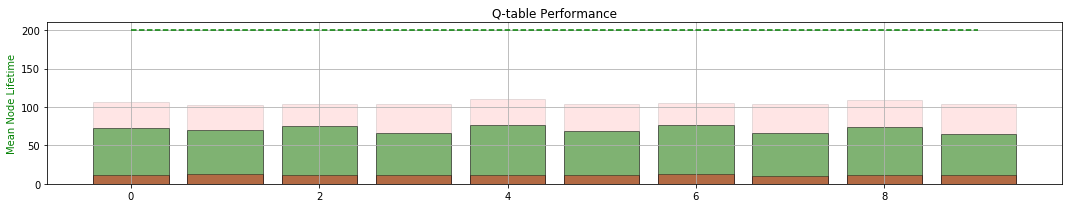

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.932	LOSS : 1.672	LOSS : 1.870	LOSS : 1.937	LOSS : 2.044	LOSS : 2.060	LOSS : 1.703	LOSS : 2.318	LOSS : 1.854	LOSS : 2.024	
Validating... MEAN TIME:  115.49
LOSS : 1.921	LOSS : 1.983	LOSS : 1.833	LOSS : 1.683	LOSS : 1.642	LOSS : 1.964	LOSS : 1.865	LOSS : 1.891	LOSS : 1.607	LOSS : 1.707	
Validating... MEAN TIME:  104.28
LOSS : 1.957	LOSS : 1.947	LOSS : 2.033	LOSS : 1.925	LOSS : 1.904	LOSS : 1.909	LOSS : 2.016	LOSS : 1.726	LOSS : 2.006	LOSS : 1.999	
Validating... MEAN TIME:  105.64
LOSS : 1.931	LOSS : 2.051	LOSS : 1.774	LOSS : 1.912	LOSS : 1.700	LOSS : 1.861	LOSS : 1.581	LOSS : 1.997	LOSS : 1.656	LOSS : 1.870	
Validating... MEAN TIME:  107.92
LOSS : 1.823	LOSS : 1.798	LOSS : 1.866	LOSS : 1.806	LOSS : 2.014	LOSS : 1.394	LOSS : 1.996	LOSS : 1.699	LOSS : 1.904	LOSS : 1.604	
Validating... MEAN TIME:  102.795
TRAINING TIME:0:00:24.876372


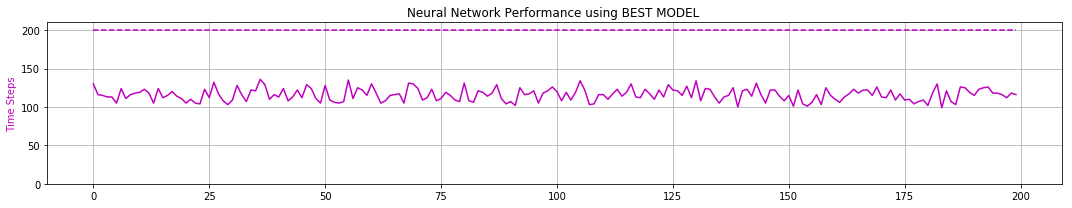

peak memory: 1437.41 MiB, increment: 1017.16 MiB
0 -max- [ 0.199  0.755  0.049  0.956]
0 -min- [-2.332 -2.888 -0.209 -1.103]

1 -max- [ 0.185  0.974  0.050  0.392]
1 -min- [-2.372 -3.061 -0.209 -1.353]

2 -max- [ 0.175  0.640  0.050  0.645]
2 -min- [-2.398 -3.052 -0.209 -1.093]

3 -max- [ 0.180  0.832  0.050  0.401]
3 -min- [-2.398 -3.120 -0.209 -1.386]

4 -max- [ 0.182  0.634  0.049  0.859]
4 -min- [-2.371 -3.074 -0.209 -1.098]

5 -max- [ 0.183  1.025  0.049  0.508]
5 -min- [-2.367 -2.920 -0.209 -1.685]

6 -max- [ 0.194  0.768  0.050  0.779]
6 -min- [-2.400 -3.061 -0.209 -1.097]

7 -max- [ 0.165  0.986  0.049  0.399]
7 -min- [-2.397 -2.927 -0.209 -1.655]

8 -max- [ 0.185  1.017  0.053  0.620]
8 -min- [-2.383 -2.971 -0.209 -1.341]

9 -max- [ 0.176  0.818  0.049  0.396]
9 -min- [-2.400 -3.066 -0.209 -1.373]

Quantization TIME:  0.01 minutes


ITERATION # 56
SMALLEST TIMESTEP in ITERATION 56: 11
REAL TIME TO GENERATE 27334 EXPERIENCES:0:00:00.724535


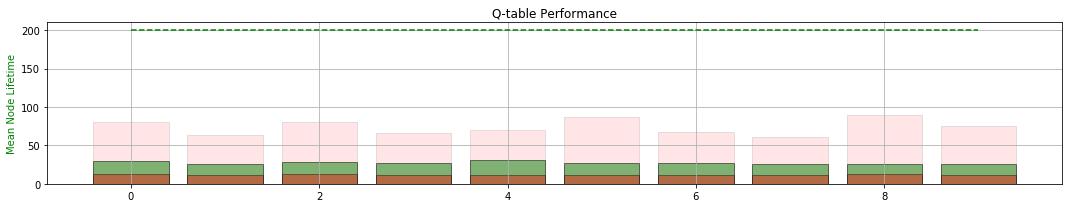

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.918	LOSS : 2.091	LOSS : 1.835	LOSS : 1.921	LOSS : 1.924	LOSS : 2.206	LOSS : 2.016	LOSS : 1.936	LOSS : 1.856	LOSS : 2.355	
Validating... MEAN TIME:  105.98
LOSS : 1.884	LOSS : 1.862	LOSS : 2.245	LOSS : 2.271	LOSS : 1.924	LOSS : 2.155	LOSS : 2.116	LOSS : 1.913	LOSS : 2.032	LOSS : 2.279	
Validating... MEAN TIME:  104.96
LOSS : 2.067	LOSS : 2.098	LOSS : 1.966	LOSS : 1.801	LOSS : 1.829	LOSS : 2.025	LOSS : 2.203	LOSS : 2.156	LOSS : 1.922	LOSS : 1.676	
Validating... MEAN TIME:  107.22
LOSS : 1.826	LOSS : 2.203	LOSS : 1.830	LOSS : 1.855	LOSS : 2.066	LOSS : 2.421	LOSS : 2.265	LOSS : 2.560	LOSS : 2.005	LOSS : 2.112	
Validating... MEAN TIME:  106.755
LOSS : 1.566	LOSS : 2.051	LOSS : 1.859	LOSS : 2.048	LOSS : 1.706	LOSS : 1.805	LOSS : 2.393	LOSS : 1.877	LOSS : 2.216	LOSS : 1.864	
Validating... MEAN TIME:  104.805
TRAINING TIME:0:00:25.260538


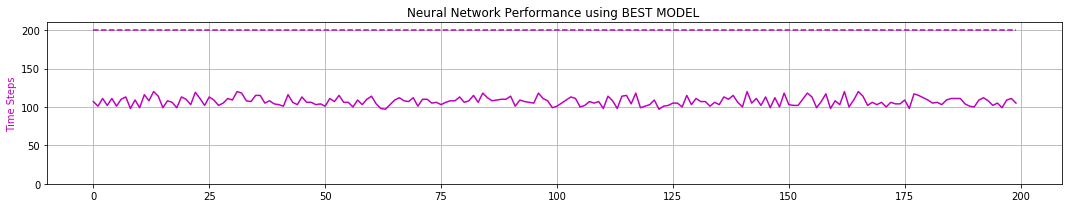

peak memory: 1451.46 MiB, increment: 1072.94 MiB
0 -max- [ 0.200  0.975  0.050  0.591]
0 -min- [-1.493 -2.602 -0.209 -1.364]

1 -max- [ 0.199  1.024  0.050  0.388]
1 -min- [-0.758 -1.781 -0.209 -1.481]

2 -max- [ 0.196  0.823  0.053  0.742]
2 -min- [-1.434 -2.527 -0.209 -1.155]

3 -max- [ 0.206  0.951  0.049  0.388]
3 -min- [-0.809 -1.864 -0.209 -1.423]

4 -max- [ 0.196  0.954  0.049  0.499]
4 -min- [-1.161 -2.140 -0.209 -1.375]

5 -max- [ 0.212  0.998  0.050  0.379]
5 -min- [-1.716 -2.717 -0.209 -1.373]

6 -max- [ 0.182  0.934  0.049  0.743]
6 -min- [-0.807 -1.785 -0.209 -1.359]

7 -max- [ 0.204  0.824  0.049  0.379]
7 -min- [-0.664 -1.679 -0.209 -1.375]

8 -max- [ 0.192  0.928  0.056  0.557]
8 -min- [-1.914 -2.722 -0.209 -1.354]

9 -max- [ 0.183  0.987  0.050  0.379]
9 -min- [-1.211 -2.156 -0.209 -1.602]

Quantization TIME:  0.01 minutes


ITERATION # 57
SMALLEST TIMESTEP in ITERATION 57: 10
REAL TIME TO GENERATE 22800 EXPERIENCES:0:00:00.626987


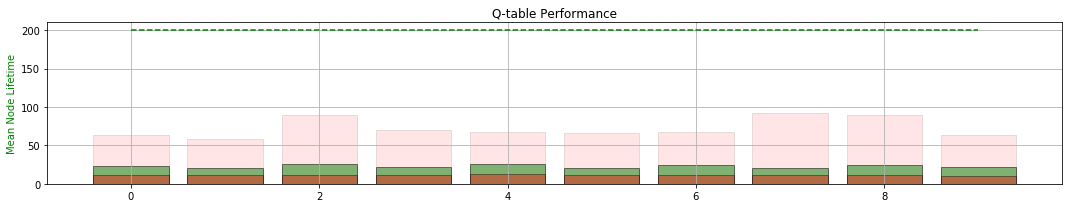

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.868	LOSS : 2.091	LOSS : 1.932	LOSS : 2.194	LOSS : 2.201	LOSS : 2.152	LOSS : 2.267	LOSS : 2.586	LOSS : 2.251	LOSS : 2.044	
Validating... MEAN TIME:  111.35
LOSS : 2.297	LOSS : 1.903	LOSS : 2.569	LOSS : 2.057	LOSS : 2.155	LOSS : 2.272	LOSS : 2.099	LOSS : 1.955	LOSS : 2.109	LOSS : 2.154	
Validating... MEAN TIME:  105.54
LOSS : 2.320	LOSS : 2.244	LOSS : 1.867	LOSS : 2.073	LOSS : 1.810	LOSS : 2.352	LOSS : 2.340	LOSS : 2.167	LOSS : 2.190	LOSS : 2.387	
Validating... MEAN TIME:  107.545
LOSS : 2.415	LOSS : 1.758	LOSS : 2.184	LOSS : 2.172	LOSS : 2.271	LOSS : 2.231	LOSS : 2.266	LOSS : 2.348	LOSS : 1.993	LOSS : 2.011	
Validating... MEAN TIME:  106.515
LOSS : 2.172	LOSS : 2.257	LOSS : 2.260	LOSS : 1.815	LOSS : 2.286	LOSS : 2.397	LOSS : 2.396	LOSS : 2.182	LOSS : 1.938	LOSS : 2.065	
Validating... MEAN TIME:  106.86
TRAINING TIME:0:00:26.124283


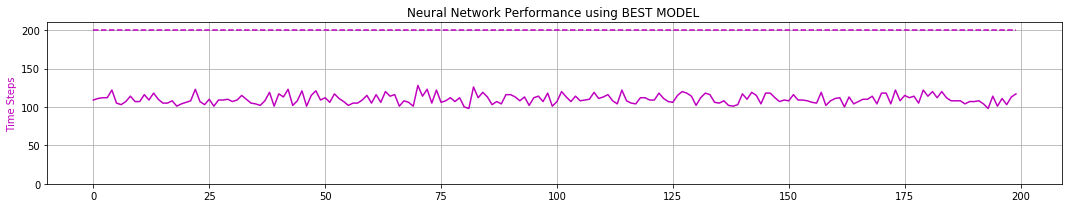

peak memory: 1413.07 MiB, increment: 975.96 MiB
0 -max- [ 0.206  0.640  0.050  0.400]
0 -min- [-0.815 -1.873 -0.209 -1.105]

1 -max- [ 0.209  1.026  0.050  0.374]
1 -min- [-0.534 -1.678 -0.209 -1.661]

2 -max- [ 0.206  0.639  0.049  0.591]
2 -min- [-1.917 -2.767 -0.209 -1.098]

3 -max- [ 0.203  0.823  0.049  0.380]
3 -min- [-0.801 -1.863 -0.209 -1.354]

4 -max- [ 0.220  0.963  0.054  0.607]
4 -min- [-0.904 -1.881 -0.209 -1.355]

5 -max- [ 0.189  1.021  0.049  0.378]
5 -min- [-0.798 -1.860 -0.209 -1.604]

6 -max- [ 0.203  0.642  0.049  0.516]
6 -min- [-0.860 -1.876 -0.209 -1.103]

7 -max- [ 0.205  0.836  0.049  0.365]
7 -min- [-2.006 -2.780 -0.209 -1.424]

8 -max- [ 0.189  0.639  0.050  0.580]
8 -min- [-2.030 -2.790 -0.209 -1.103]

9 -max- [ 0.216  0.973  0.050  0.376]
9 -min- [-0.841 -2.060 -0.209 -1.574]

Quantization TIME:  0.01 minutes


ITERATION # 58
SMALLEST TIMESTEP in ITERATION 58: 11
REAL TIME TO GENERATE 24171 EXPERIENCES:0:00:00.618630


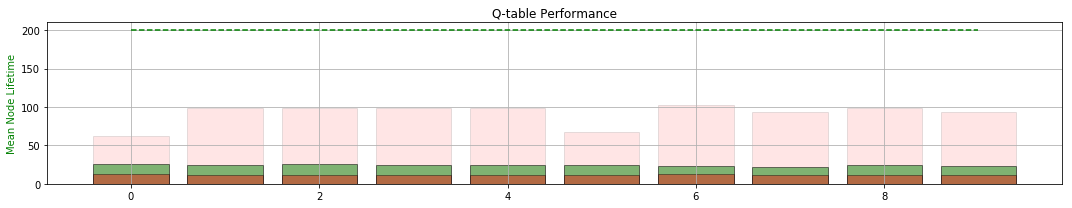

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.630	LOSS : 2.054	LOSS : 2.553	LOSS : 2.302	LOSS : 2.464	LOSS : 2.294	LOSS : 1.881	LOSS : 2.295	LOSS : 2.011	LOSS : 2.084	
Validating... MEAN TIME:  107.925
LOSS : 2.537	LOSS : 2.288	LOSS : 2.296	LOSS : 2.258	LOSS : 2.522	LOSS : 2.216	LOSS : 2.277	LOSS : 2.611	LOSS : 1.924	LOSS : 2.025	
Validating... MEAN TIME:  106.71
LOSS : 2.584	LOSS : 2.565	LOSS : 2.191	LOSS : 1.974	LOSS : 2.276	LOSS : 2.400	LOSS : 1.904	LOSS : 2.358	LOSS : 2.206	LOSS : 2.472	
Validating... MEAN TIME:  104.52
LOSS : 2.720	LOSS : 2.161	LOSS : 2.600	LOSS : 2.499	LOSS : 1.959	LOSS : 2.729	LOSS : 2.028	LOSS : 2.331	LOSS : 2.200	LOSS : 2.090	
Validating... MEAN TIME:  107.405
LOSS : 2.151	LOSS : 2.196	LOSS : 2.090	LOSS : 2.427	LOSS : 2.301	LOSS : 2.725	LOSS : 2.281	LOSS : 1.946	LOSS : 2.401	LOSS : 2.067	
Validating... MEAN TIME:  109.915
TRAINING TIME:0:00:25.430979


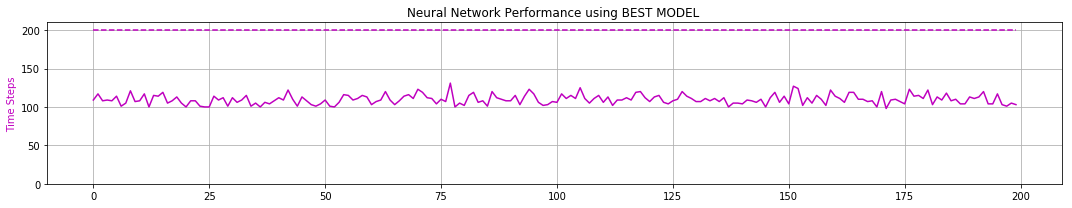

peak memory: 1363.14 MiB, increment: 997.71 MiB
0 -max- [ 0.208  0.641  0.050  0.570]
0 -min- [-0.637 -1.691 -0.209 -1.097]

1 -max- [ 0.206  0.831  0.049  0.379]
1 -min- [-2.169 -2.862 -0.209 -1.418]

2 -max- [ 0.188  0.642  0.049  0.480]
2 -min- [-2.352 -3.133 -0.209 -1.101]

3 -max- [ 0.217  0.963  0.050  0.387]
3 -min- [-2.361 -2.935 -0.209 -1.373]

4 -max- [ 0.182  0.643  0.049  0.518]
4 -min- [-2.064 -2.781 -0.209 -1.101]

5 -max- [ 0.204  0.824  0.049  0.379]
5 -min- [-0.907 -2.062 -0.209 -1.303]

6 -max- [ 0.205  0.643  0.049  0.607]
6 -min- [-2.390 -2.952 -0.209 -1.097]

7 -max- [ 0.189  1.024  0.050  0.381]
7 -min- [-1.995 -2.773 -0.209 -1.671]

8 -max- [ 0.216  0.645  0.050  0.692]
8 -min- [-2.347 -2.970 -0.209 -1.097]

9 -max- [ 0.208  0.833  0.049  0.377]
9 -min- [-2.241 -2.788 -0.209 -1.418]

Quantization TIME:  0.01 minutes


ITERATION # 59
SMALLEST TIMESTEP in ITERATION 59: 10
REAL TIME TO GENERATE 31939 EXPERIENCES:0:00:00.756904


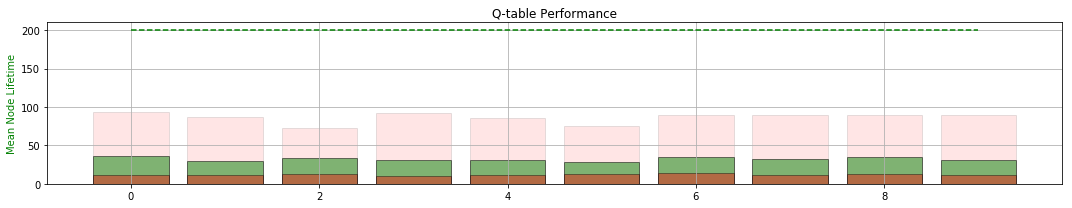

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.342	LOSS : 2.418	LOSS : 2.376	LOSS : 2.517	LOSS : 2.252	LOSS : 2.282	LOSS : 2.103	LOSS : 2.853	LOSS : 2.483	LOSS : 2.515	
Validating... MEAN TIME:  109.37
LOSS : 2.476	LOSS : 2.084	LOSS : 2.698	LOSS : 2.543	LOSS : 2.571	LOSS : 2.368	LOSS : 2.152	LOSS : 2.205	LOSS : 2.207	LOSS : 2.123	
Validating... MEAN TIME:  111.63
LOSS : 2.244	LOSS : 2.527	LOSS : 2.490	LOSS : 2.429	LOSS : 2.177	LOSS : 2.594	LOSS : 2.811	LOSS : 2.482	LOSS : 2.682	LOSS : 2.962	
Validating... MEAN TIME:  114.89
LOSS : 2.325	LOSS : 2.605	LOSS : 2.400	LOSS : 2.261	LOSS : 2.203	LOSS : 2.443	LOSS : 2.183	LOSS : 2.432	LOSS : 2.203	LOSS : 2.530	
Validating... MEAN TIME:  109.385
LOSS : 2.242	LOSS : 2.589	LOSS : 2.179	LOSS : 2.326	LOSS : 2.314	LOSS : 2.393	LOSS : 2.449	LOSS : 2.214	LOSS : 2.730	LOSS : 2.567	
Validating... MEAN TIME:  108.87
TRAINING TIME:0:00:26.721145


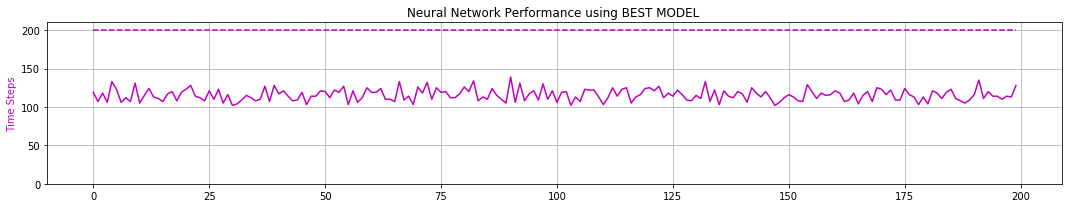

peak memory: 1435.39 MiB, increment: 1021.26 MiB
0 -max- [ 0.198  1.001  0.057  0.605]
0 -min- [-1.962 -2.698 -0.209 -1.324]

1 -max- [ 0.188  0.833  0.049  0.386]
1 -min- [-1.817 -2.718 -0.209 -1.304]

2 -max- [ 0.210  0.963  0.050  0.696]
2 -min- [-1.240 -2.376 -0.209 -1.355]

3 -max- [ 0.182  0.836  0.049  0.382]
3 -min- [-1.758 -2.740 -0.209 -1.418]

4 -max- [ 0.188  0.639  0.049  0.610]
4 -min- [-1.772 -2.607 -0.209 -1.103]

5 -max- [ 0.189  0.827  0.049  0.380]
5 -min- [-1.140 -2.344 -0.209 -1.295]

6 -max- [ 0.167  0.971  0.050  0.566]
6 -min- [-1.873 -2.716 -0.209 -1.337]

7 -max- [ 0.194  0.820  0.050  0.388]
7 -min- [-1.866 -2.704 -0.209 -1.461]

8 -max- [ 0.193  0.639  0.049  0.721]
8 -min- [-2.270 -2.876 -0.209 -1.092]

9 -max- [ 0.202  0.838  0.049  0.385]
9 -min- [-1.698 -2.704 -0.209 -1.388]

Quantization TIME:  0.01 minutes


ITERATION # 60
SMALLEST TIMESTEP in ITERATION 60: 10
REAL TIME TO GENERATE 35339 EXPERIENCES:0:00:00.977189


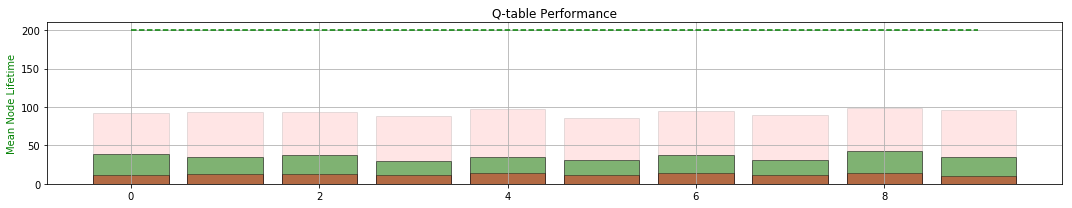

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.538	LOSS : 2.839	LOSS : 2.094	LOSS : 2.574	LOSS : 2.802	LOSS : 2.280	LOSS : 2.538	LOSS : 2.573	LOSS : 2.304	LOSS : 2.318	
Validating... MEAN TIME:  111.645
LOSS : 2.279	LOSS : 2.490	LOSS : 2.918	LOSS : 2.504	LOSS : 2.157	LOSS : 2.453	LOSS : 2.540	LOSS : 2.402	LOSS : 2.064	LOSS : 2.084	
Validating... MEAN TIME:  112.17
LOSS : 2.233	LOSS : 2.091	LOSS : 2.815	LOSS : 2.617	LOSS : 2.638	LOSS : 2.692	LOSS : 2.760	LOSS : 2.393	LOSS : 2.596	LOSS : 2.842	
Validating... MEAN TIME:  115.005
LOSS : 2.967	LOSS : 2.196	LOSS : 2.414	LOSS : 2.408	LOSS : 2.565	LOSS : 2.500	LOSS : 2.511	LOSS : 2.344	LOSS : 2.762	LOSS : 2.218	
Validating... MEAN TIME:  116.28
LOSS : 2.354	LOSS : 2.255	LOSS : 2.562	LOSS : 2.845	LOSS : 2.351	LOSS : 2.545	LOSS : 2.538	LOSS : 2.692	LOSS : 2.656	LOSS : 2.888	
Validating... MEAN TIME:  113.465
TRAINING TIME:0:00:26.856640


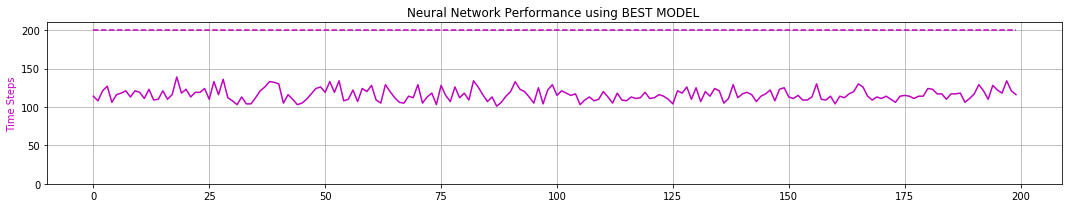

peak memory: 1371.17 MiB, increment: 985.16 MiB
0 -max- [ 0.180  0.640  0.049  0.596]
0 -min- [-2.201 -2.887 -0.209 -1.099]

1 -max- [ 0.194  0.809  0.050  0.383]
1 -min- [-2.003 -2.763 -0.209 -1.289]

2 -max- [ 0.158  0.643  0.049  0.602]
2 -min- [-2.203 -2.887 -0.209 -1.098]

3 -max- [ 0.185  0.826  0.049  0.379]
3 -min- [-1.892 -2.738 -0.209 -1.342]

4 -max- [ 0.173  0.637  0.049  0.713]
4 -min- [-2.191 -2.912 -0.209 -1.097]

5 -max- [ 0.163  0.832  0.050  0.390]
5 -min- [-1.957 -2.777 -0.209 -1.344]

6 -max- [ 0.190  0.735  0.050  0.560]
6 -min- [-2.275 -2.891 -0.209 -1.081]

7 -max- [ 0.185  1.010  0.049  0.386]
7 -min- [-1.963 -2.866 -0.209 -1.528]

8 -max- [ 0.191  0.938  0.057  0.610]
8 -min- [-2.240 -2.886 -0.209 -1.314]

9 -max- [ 0.198  1.026  0.050  0.382]
9 -min- [-1.959 -2.704 -0.209 -1.736]

Quantization TIME:  0.01 minutes


ITERATION # 61
SMALLEST TIMESTEP in ITERATION 61: 12
REAL TIME TO GENERATE 37881 EXPERIENCES:0:00:01.048097


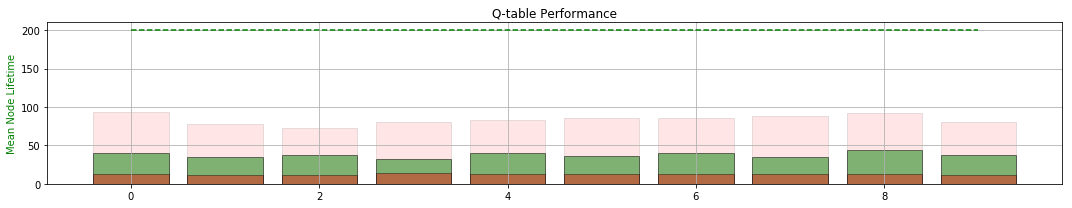

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.982	LOSS : 2.716	LOSS : 2.917	LOSS : 2.798	LOSS : 2.538	LOSS : 2.554	LOSS : 2.814	LOSS : 2.870	LOSS : 2.359	LOSS : 2.659	
Validating... MEAN TIME:  120.335
LOSS : 2.545	LOSS : 2.799	LOSS : 2.804	LOSS : 2.408	LOSS : 2.875	LOSS : 2.837	LOSS : 2.791	LOSS : 2.651	LOSS : 2.788	LOSS : 3.085	
Validating... MEAN TIME:  122.915
LOSS : 2.613	LOSS : 2.683	LOSS : 2.852	LOSS : 2.528	LOSS : 2.520	LOSS : 2.812	LOSS : 2.428	LOSS : 2.945	LOSS : 3.184	LOSS : 2.724	
Validating... MEAN TIME:  121.765
LOSS : 2.972	LOSS : 2.700	LOSS : 2.704	LOSS : 2.892	LOSS : 2.380	LOSS : 2.758	LOSS : 2.571	LOSS : 2.353	LOSS : 2.612	LOSS : 2.636	
Validating... MEAN TIME:  123.62
LOSS : 2.795	LOSS : 2.608	LOSS : 2.985	LOSS : 2.614	LOSS : 2.697	LOSS : 2.656	LOSS : 2.565	LOSS : 2.607	LOSS : 2.965	LOSS : 3.389	
Validating... MEAN TIME:  120.86
TRAINING TIME:0:00:28.344349


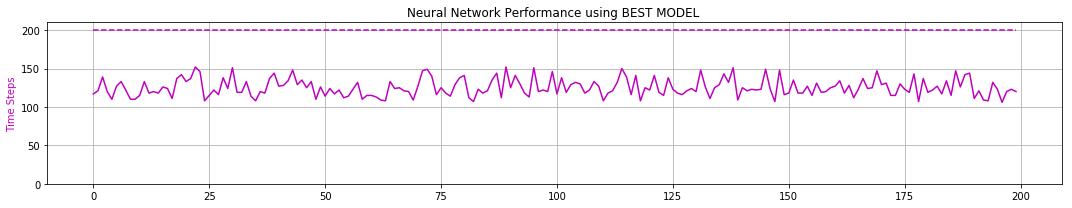

peak memory: 1442.24 MiB, increment: 987.97 MiB
0 -max- [ 0.197  0.767  0.054  0.658]
0 -min- [-2.033 -2.866 -0.209 -1.097]

1 -max- [ 0.166  0.836  0.049  0.386]
1 -min- [-1.315 -2.358 -0.209 -1.341]

2 -max- [ 0.185  0.636  0.051  0.547]
2 -min- [-0.880 -2.003 -0.209 -1.103]

3 -max- [ 0.175  0.818  0.049  0.609]
3 -min- [-1.219 -2.154 -0.209 -1.249]

4 -max- [ 0.157  0.638  0.050  0.616]
4 -min- [-1.712 -2.593 -0.209 -1.096]

5 -max- [ 0.190  0.829  0.050  0.387]
5 -min- [-1.703 -2.703 -0.209 -1.442]

6 -max- [ 0.177  0.639  0.049  0.715]
6 -min- [-1.813 -2.589 -0.209 -1.092]

7 -max- [ 0.194  0.818  0.049  0.484]
7 -min- [-1.578 -2.521 -0.209 -1.251]

8 -max- [ 0.190  0.734  0.050  0.728]
8 -min- [-1.772 -2.609 -0.209 -1.094]

9 -max- [ 0.186  0.833  0.050  0.524]
9 -min- [-1.460 -2.533 -0.209 -1.415]

Quantization TIME:  0.01 minutes


ITERATION # 62
SMALLEST TIMESTEP in ITERATION 62: 11
REAL TIME TO GENERATE 47296 EXPERIENCES:0:00:01.199462


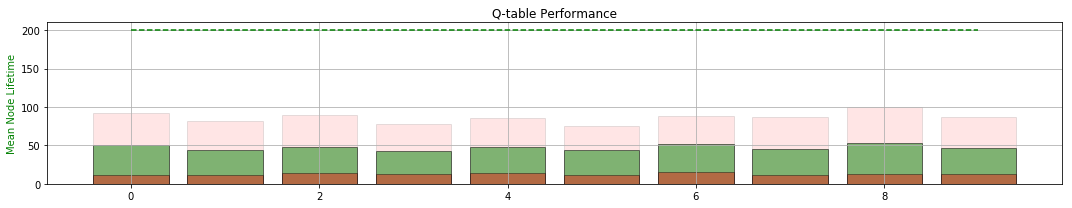

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.108	LOSS : 2.917	LOSS : 2.804	LOSS : 2.422	LOSS : 2.715	LOSS : 2.784	LOSS : 3.022	LOSS : 3.129	LOSS : 2.427	LOSS : 2.691	
Validating... MEAN TIME:  134.15
LOSS : 2.720	LOSS : 3.106	LOSS : 2.467	LOSS : 2.829	LOSS : 3.057	LOSS : 2.865	LOSS : 3.035	LOSS : 2.698	LOSS : 2.588	LOSS : 3.035	
Validating... MEAN TIME:  133.505
LOSS : 2.447	LOSS : 3.106	LOSS : 2.758	LOSS : 2.492	LOSS : 2.659	LOSS : 3.128	LOSS : 2.685	LOSS : 3.549	LOSS : 2.724	LOSS : 2.383	
Validating... MEAN TIME:  137.655
LOSS : 2.323	LOSS : 2.887	LOSS : 2.886	LOSS : 2.632	LOSS : 2.552	LOSS : 2.993	LOSS : 2.816	LOSS : 3.193	LOSS : 2.603	LOSS : 2.696	
Validating... MEAN TIME:  142.99
LOSS : 2.866	LOSS : 2.984	LOSS : 3.127	LOSS : 2.556	LOSS : 2.423	LOSS : 2.846	LOSS : 3.276	LOSS : 3.350	LOSS : 2.812	LOSS : 2.909	
Validating... MEAN TIME:  147.15
TRAINING TIME:0:00:31.327534


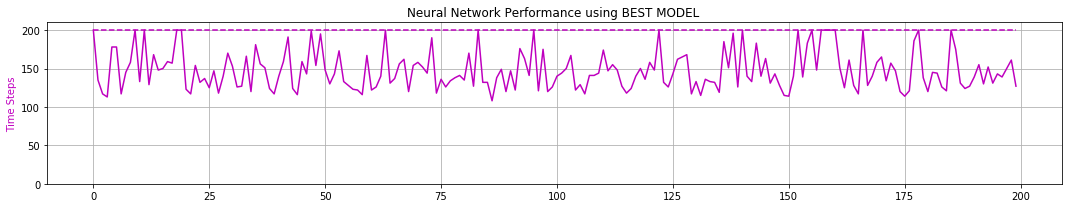

peak memory: 1435.04 MiB, increment: 969.31 MiB
0 -max- [ 0.152  0.643  0.049  0.807]
0 -min- [-1.819 -2.695 -0.209 -1.101]

1 -max- [ 0.185  0.808  0.049  0.565]
1 -min- [-1.470 -2.523 -0.209 -1.359]

2 -max- [ 0.176  0.637  0.055  0.678]
2 -min- [-1.658 -2.536 -0.209 -1.097]

3 -max- [ 0.175  0.825  0.050  0.391]
3 -min- [-1.427 -2.525 -0.209 -1.360]

4 -max- [ 0.182  0.641  0.050  0.605]
4 -min- [-1.550 -2.693 -0.209 -1.081]

5 -max- [ 0.177  1.026  0.049  0.589]
5 -min- [-1.255 -2.353 -0.209 -1.769]

6 -max- [ 0.191  0.641  0.049  0.597]
6 -min- [-1.721 -2.581 -0.209 -1.087]

7 -max- [ 0.198  0.815  0.050  0.583]
7 -min- [-1.786 -2.699 -0.209 -1.462]

8 -max- [ 0.188  0.638  0.050  0.797]
8 -min- [-1.943 -2.744 -0.209 -1.099]

9 -max- [ 0.185  0.827  0.050  0.598]
9 -min- [-1.642 -2.540 -0.209 -1.391]

Quantization TIME:  0.01 minutes


ITERATION # 63
SMALLEST TIMESTEP in ITERATION 63: 12
REAL TIME TO GENERATE 57562 EXPERIENCES:0:00:01.413398


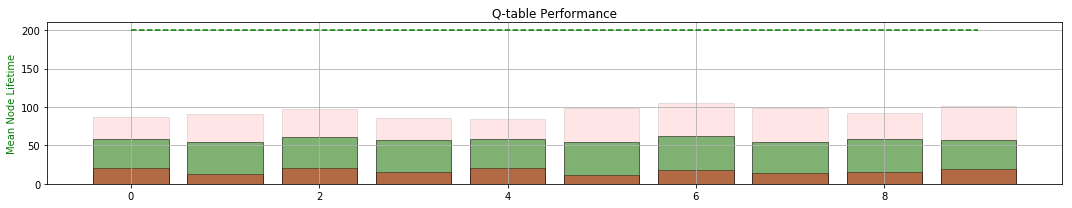

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.765	LOSS : 2.580	LOSS : 3.022	LOSS : 2.608	LOSS : 2.523	LOSS : 2.986	LOSS : 2.938	LOSS : 2.919	LOSS : 2.828	LOSS : 3.195	
Validating... MEAN TIME:  131.575
LOSS : 2.572	LOSS : 2.719	LOSS : 2.288	LOSS : 2.597	LOSS : 2.781	LOSS : 2.905	LOSS : 2.947	LOSS : 2.854	LOSS : 2.665	LOSS : 2.900	
Validating... MEAN TIME:  132.425
LOSS : 2.726	LOSS : 2.567	LOSS : 2.951	LOSS : 3.186	LOSS : 3.080	LOSS : 2.958	LOSS : 2.611	LOSS : 2.688	LOSS : 3.273	LOSS : 3.066	
Validating... MEAN TIME:  126.89
LOSS : 2.645	LOSS : 3.344	LOSS : 2.855	LOSS : 3.235	LOSS : 2.550	LOSS : 3.658	LOSS : 2.932	LOSS : 2.807	LOSS : 2.752	LOSS : 2.637	
Validating... MEAN TIME:  133.005
LOSS : 2.854	LOSS : 2.428	LOSS : 2.965	LOSS : 2.780	LOSS : 2.970	LOSS : 2.705	LOSS : 3.164	LOSS : 2.327	LOSS : 2.854	LOSS : 2.946	
Validating... MEAN TIME:  138.1
TRAINING TIME:0:00:29.875526


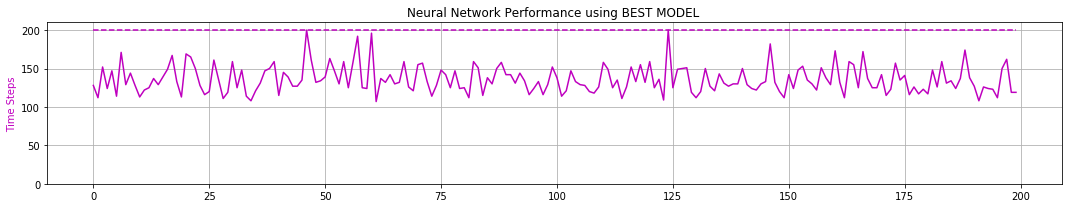

peak memory: 1427.66 MiB, increment: 1016.34 MiB
0 -max- [ 0.185  0.801  0.055  0.638]
0 -min- [-2.151 -2.882 -0.209 -1.084]

1 -max- [ 0.171  0.826  0.049  0.399]
1 -min- [-1.902 -2.611 -0.209 -1.223]

2 -max- [ 0.155  0.636  0.050  0.633]
2 -min- [-2.197 -2.893 -0.209 -1.074]

3 -max- [ 0.184  0.796  0.050  0.402]
3 -min- [-2.006 -2.704 -0.209 -1.213]

4 -max- [ 0.174  0.639  0.049  0.640]
4 -min- [-1.620 -2.590 -0.209 -1.071]

5 -max- [ 0.190  0.816  0.049  0.399]
5 -min- [-1.850 -2.604 -0.209 -1.252]

6 -max- [ 0.201  0.734  0.050  0.756]
6 -min- [-2.204 -2.885 -0.209 -1.078]

7 -max- [ 0.175  0.795  0.050  0.402]
7 -min- [-1.888 -2.563 -0.209 -1.246]

8 -max- [ 0.184  0.826  0.056  0.577]
8 -min- [-1.965 -2.706 -0.209 -1.084]

9 -max- [ 0.172  0.829  0.049  0.605]
9 -min- [-2.005 -2.772 -0.209 -1.278]

Quantization TIME:  0.01 minutes


ITERATION # 64
SMALLEST TIMESTEP in ITERATION 64: 12
REAL TIME TO GENERATE 69541 EXPERIENCES:0:00:01.699173


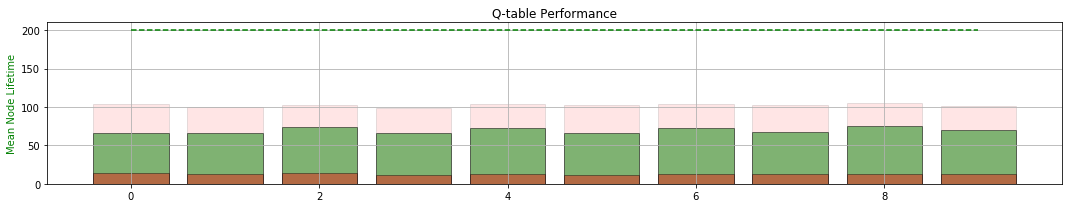

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.871	LOSS : 2.003	LOSS : 2.047	LOSS : 2.448	LOSS : 2.293	LOSS : 2.140	LOSS : 2.378	LOSS : 2.850	LOSS : 2.591	LOSS : 2.411	
Validating... MEAN TIME:  117.325
LOSS : 2.241	LOSS : 2.603	LOSS : 2.143	LOSS : 2.618	LOSS : 2.583	LOSS : 2.465	LOSS : 2.595	LOSS : 2.466	LOSS : 2.335	LOSS : 2.244	
Validating... MEAN TIME:  114.14
LOSS : 2.439	LOSS : 2.860	LOSS : 2.702	LOSS : 2.752	LOSS : 2.748	LOSS : 2.297	LOSS : 2.329	LOSS : 2.646	LOSS : 2.822	LOSS : 2.426	
Validating... MEAN TIME:  107.415
LOSS : 2.510	LOSS : 2.047	LOSS : 2.650	LOSS : 2.555	LOSS : 2.571	LOSS : 2.142	LOSS : 2.135	LOSS : 2.087	LOSS : 2.427	LOSS : 2.425	
Validating... MEAN TIME:  106.005
LOSS : 1.771	LOSS : 2.696	LOSS : 2.454	LOSS : 3.046	LOSS : 2.626	LOSS : 2.452	LOSS : 2.968	LOSS : 2.461	LOSS : 2.750	LOSS : 2.693	
Validating... MEAN TIME:  103.525
TRAINING TIME:0:00:25.992942


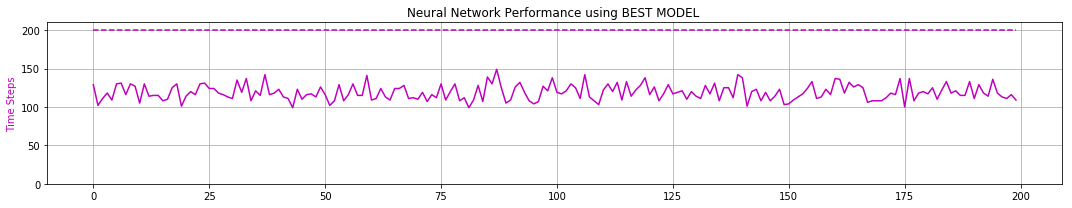

peak memory: 1423.24 MiB, increment: 973.37 MiB
0 -max- [ 0.175  0.637  0.049  0.801]
0 -min- [-2.232 -2.950 -0.209 -1.094]

1 -max- [ 0.155  0.823  0.050  0.387]
1 -min- [-2.259 -2.768 -0.209 -1.303]

2 -max- [ 0.199  0.786  0.066  0.799]
2 -min- [-2.278 -2.934 -0.209 -1.085]

3 -max- [ 0.176  0.825  0.049  0.563]
3 -min- [-2.118 -2.870 -0.209 -1.338]

4 -max- [ 0.183  0.641  0.049  0.759]
4 -min- [-2.352 -2.912 -0.209 -1.091]

5 -max- [ 0.198  0.827  0.050  0.396]
5 -min- [-2.363 -2.916 -0.209 -1.431]

6 -max- [ 0.183  0.799  0.050  0.667]
6 -min- [-2.257 -2.899 -0.209 -1.099]

7 -max- [ 0.178  0.801  0.050  0.609]
7 -min- [-2.239 -2.901 -0.209 -1.234]

8 -max- [ 0.158  0.642  0.049  0.632]
8 -min- [-2.251 -2.865 -0.209 -1.095]

9 -max- [ 0.178  0.825  0.048  0.390]
9 -min- [-2.254 -2.875 -0.209 -1.384]

Quantization TIME:  0.01 minutes


ITERATION # 65
SMALLEST TIMESTEP in ITERATION 65: 12
REAL TIME TO GENERATE 48648 EXPERIENCES:0:00:01.331202


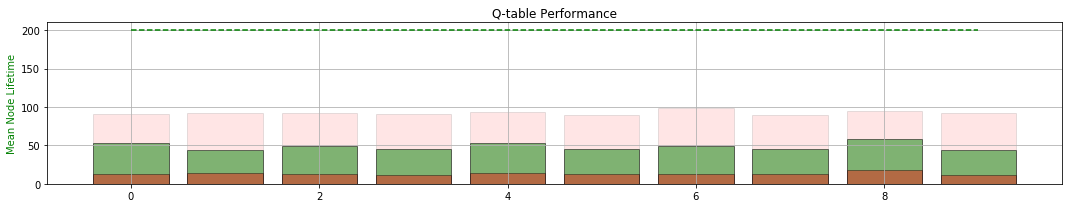

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.959	LOSS : 1.889	LOSS : 2.669	LOSS : 2.440	LOSS : 2.093	LOSS : 2.207	LOSS : 2.290	LOSS : 2.240	LOSS : 2.116	LOSS : 2.313	
Validating... MEAN TIME:  98.465
LOSS : 1.791	LOSS : 2.287	LOSS : 2.197	LOSS : 2.103	LOSS : 2.583	LOSS : 2.368	LOSS : 2.352	LOSS : 2.141	LOSS : 2.371	LOSS : 2.077	
Validating... MEAN TIME:  100.39
LOSS : 2.194	LOSS : 2.226	LOSS : 1.878	LOSS : 2.365	LOSS : 2.227	LOSS : 2.326	LOSS : 2.538	LOSS : 2.401	LOSS : 2.175	LOSS : 2.173	
Validating... MEAN TIME:  99.985
LOSS : 2.127	LOSS : 2.270	LOSS : 2.351	LOSS : 2.376	LOSS : 2.724	LOSS : 2.490	LOSS : 2.168	LOSS : 2.181	LOSS : 2.373	LOSS : 2.303	
Validating... MEAN TIME:  101.785
LOSS : 2.543	LOSS : 2.564	LOSS : 2.013	LOSS : 2.126	LOSS : 2.090	LOSS : 2.343	LOSS : 1.924	LOSS : 2.545	LOSS : 2.328	LOSS : 2.766	
Validating... MEAN TIME:  100.545
TRAINING TIME:0:00:24.332212


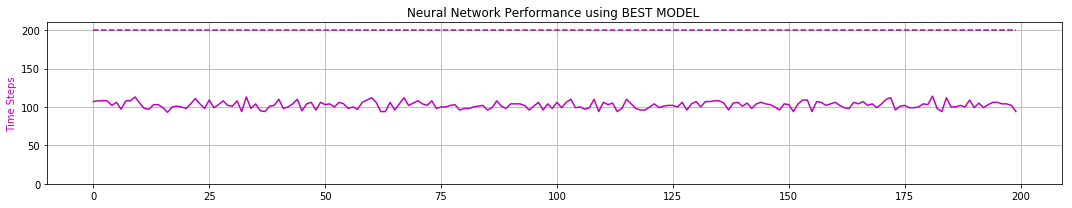

peak memory: 1449.63 MiB, increment: 1043.00 MiB
0 -max- [ 0.162  0.939  0.054  0.612]
0 -min- [-1.978 -2.747 -0.209 -1.348]

1 -max- [ 0.186  0.823  0.050  0.390]
1 -min- [-1.936 -2.760 -0.209 -1.330]

2 -max- [ 0.185  0.641  0.049  0.719]
2 -min- [-2.095 -2.869 -0.209 -1.092]

3 -max- [ 0.194  0.940  0.049  0.572]
3 -min- [-1.896 -2.731 -0.209 -1.396]

4 -max- [ 0.197  0.930  0.050  0.625]
4 -min- [-2.025 -2.776 -0.209 -1.361]

5 -max- [ 0.186  0.809  0.050  0.389]
5 -min- [-1.912 -2.694 -0.209 -1.224]

6 -max- [ 0.180  0.827  0.050  0.600]
6 -min- [-2.285 -2.936 -0.209 -1.098]

7 -max- [ 0.165  0.825  0.049  0.390]
7 -min- [-1.902 -2.689 -0.209 -1.376]

8 -max- [ 0.177  0.942  0.055  0.607]
8 -min- [-1.977 -2.777 -0.209 -1.324]

9 -max- [ 0.193  0.827  0.050  0.389]
9 -min- [-1.896 -2.731 -0.209 -1.235]

Quantization TIME:  0.01 minutes


ITERATION # 66
SMALLEST TIMESTEP in ITERATION 66: 11
REAL TIME TO GENERATE 25814 EXPERIENCES:0:00:00.674044


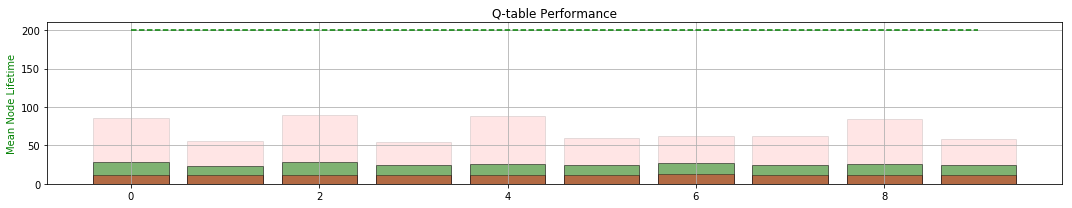

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.318	LOSS : 2.215	LOSS : 2.346	LOSS : 1.869	LOSS : 2.158	LOSS : 2.158	LOSS : 2.479	LOSS : 2.030	LOSS : 2.128	LOSS : 2.335	
Validating... MEAN TIME:  104.11
LOSS : 2.379	LOSS : 2.087	LOSS : 2.379	LOSS : 2.189	LOSS : 2.338	LOSS : 2.022	LOSS : 2.279	LOSS : 2.168	LOSS : 2.244	LOSS : 2.505	
Validating... MEAN TIME:  102.45
LOSS : 2.409	LOSS : 2.425	LOSS : 2.406	LOSS : 2.004	LOSS : 2.365	LOSS : 2.412	LOSS : 2.459	LOSS : 2.686	LOSS : 2.106	LOSS : 2.272	
Validating... MEAN TIME:  107.68
LOSS : 2.701	LOSS : 2.211	LOSS : 2.144	LOSS : 2.140	LOSS : 2.511	LOSS : 2.616	LOSS : 2.386	LOSS : 2.236	LOSS : 2.550	LOSS : 2.306	
Validating... MEAN TIME:  107.71
LOSS : 2.197	LOSS : 2.374	LOSS : 2.154	LOSS : 2.269	LOSS : 2.283	LOSS : 2.491	LOSS : 2.323	LOSS : 2.300	LOSS : 2.491	LOSS : 2.552	
Validating... MEAN TIME:  105.865
TRAINING TIME:0:00:24.663271


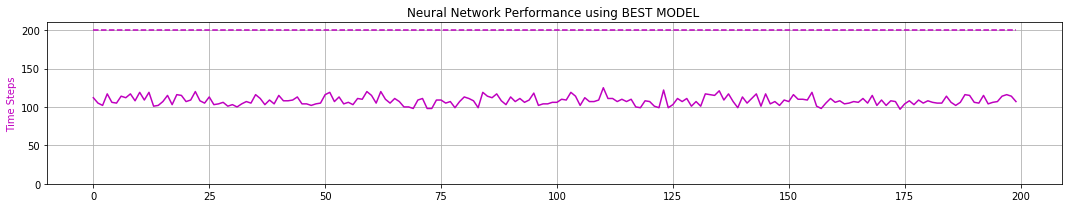

peak memory: 1428.38 MiB, increment: 982.38 MiB
0 -max- [ 0.198  0.950  0.050  0.588]
0 -min- [-1.728 -2.732 -0.209 -1.365]

1 -max- [ 0.201  0.986  0.049  0.382]
1 -min- [-0.634 -1.643 -0.209 -1.449]

2 -max- [ 0.210  0.940  0.049  0.596]
2 -min- [-1.915 -2.880 -0.209 -1.370]

3 -max- [ 0.208  1.009  0.050  0.373]
3 -min- [-0.580 -1.794 -0.209 -1.533]

4 -max- [ 0.197  0.955  0.050  0.471]
4 -min- [-1.875 -2.721 -0.209 -1.364]

5 -max- [ 0.204  0.827  0.050  0.385]
5 -min- [-0.597 -1.840 -0.209 -1.365]

6 -max- [ 0.175  0.825  0.049  0.719]
6 -min- [-0.749 -2.017 -0.209 -1.160]

7 -max- [ 0.193  0.828  0.048  0.380]
7 -min- [-0.546 -1.685 -0.209 -1.257]

8 -max- [ 0.208  0.827  0.050  0.496]
8 -min- [-1.844 -2.703 -0.209 -1.160]

9 -max- [ 0.197  0.965  0.049  0.380]
9 -min- [-0.578 -1.661 -0.209 -1.608]

Quantization TIME:  0.01 minutes


ITERATION # 67
SMALLEST TIMESTEP in ITERATION 67: 10
REAL TIME TO GENERATE 31919 EXPERIENCES:0:00:00.894217


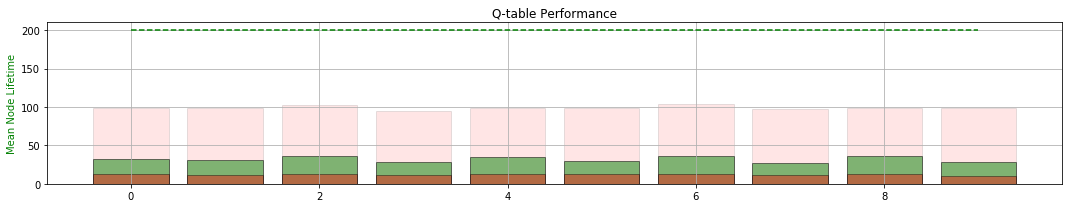

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.606	LOSS : 1.939	LOSS : 2.465	LOSS : 2.395	LOSS : 2.259	LOSS : 2.243	LOSS : 2.649	LOSS : 2.178	LOSS : 2.406	LOSS : 2.436	
Validating... MEAN TIME:  107.595
LOSS : 1.961	LOSS : 2.353	LOSS : 2.196	LOSS : 2.410	LOSS : 2.371	LOSS : 2.186	LOSS : 2.690	LOSS : 2.079	LOSS : 2.244	LOSS : 2.469	
Validating... MEAN TIME:  108.39
LOSS : 2.538	LOSS : 2.428	LOSS : 1.895	LOSS : 2.521	LOSS : 2.954	LOSS : 2.180	LOSS : 2.528	LOSS : 2.741	LOSS : 2.267	LOSS : 2.625	
Validating... MEAN TIME:  112.265
LOSS : 2.021	LOSS : 2.402	LOSS : 2.433	LOSS : 2.362	LOSS : 2.120	LOSS : 2.297	LOSS : 2.388	LOSS : 2.364	LOSS : 2.284	LOSS : 2.386	
Validating... MEAN TIME:  112.155
LOSS : 2.426	LOSS : 1.947	LOSS : 2.377	LOSS : 2.244	LOSS : 2.501	LOSS : 2.607	LOSS : 2.475	LOSS : 2.147	LOSS : 2.420	LOSS : 2.185	
Validating... MEAN TIME:  116.05
TRAINING TIME:0:00:26.361045


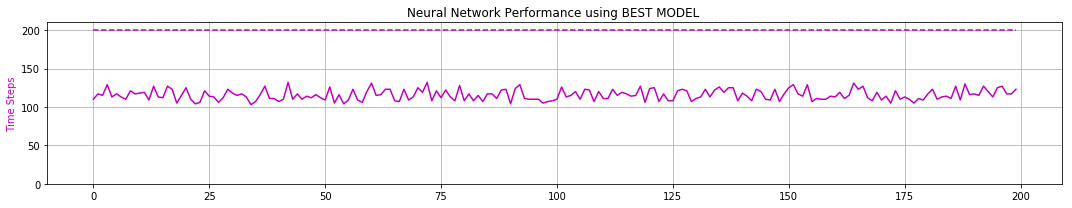

peak memory: 1413.89 MiB, increment: 1016.48 MiB
0 -max- [ 0.193  1.020  0.049  0.609]
0 -min- [-2.379 -3.144 -0.209 -1.355]

1 -max- [ 0.202  1.020  0.049  0.384]
1 -min- [-2.386 -3.067 -0.209 -1.633]

2 -max- [ 0.199  0.936  0.053  0.624]
2 -min- [-2.392 -3.081 -0.209 -1.376]

3 -max- [ 0.202  0.810  0.050  0.378]
3 -min- [-2.392 -2.900 -0.209 -1.370]

4 -max- [ 0.188  0.642  0.050  0.562]
4 -min- [-2.395 -3.133 -0.209 -1.098]

5 -max- [ 0.168  0.974  0.049  0.381]
5 -min- [-2.382 -3.148 -0.209 -1.601]

6 -max- [ 0.193  0.976  0.052  0.613]
6 -min- [-2.386 -3.109 -0.209 -1.330]

7 -max- [ 0.196  0.822  0.050  0.379]
7 -min- [-2.374 -2.889 -0.209 -1.402]

8 -max- [ 0.193  0.957  0.057  0.782]
8 -min- [-2.397 -3.086 -0.209 -1.314]

9 -max- [ 0.194  1.026  0.050  0.396]
9 -min- [-2.398 -2.933 -0.209 -1.617]

Quantization TIME:  0.01 minutes


ITERATION # 68
SMALLEST TIMESTEP in ITERATION 68: 12
REAL TIME TO GENERATE 41313 EXPERIENCES:0:00:01.093399


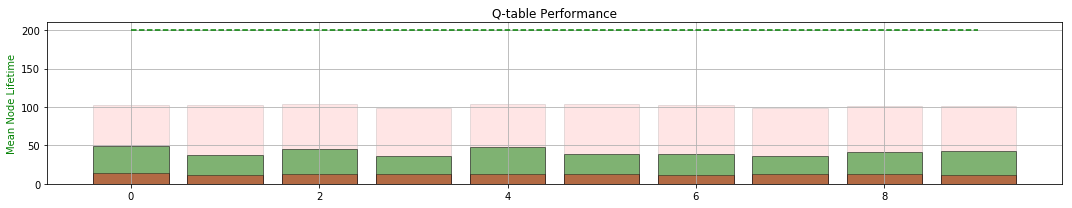

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.629	LOSS : 2.722	LOSS : 2.506	LOSS : 2.213	LOSS : 2.544	LOSS : 2.259	LOSS : 2.293	LOSS : 2.302	LOSS : 2.569	LOSS : 2.119	
Validating... MEAN TIME:  115.25
LOSS : 2.633	LOSS : 2.436	LOSS : 2.461	LOSS : 2.238	LOSS : 2.328	LOSS : 2.164	LOSS : 2.270	LOSS : 2.445	LOSS : 2.566	LOSS : 2.525	
Validating... MEAN TIME:  113.635
LOSS : 2.122	LOSS : 2.326	LOSS : 2.168	LOSS : 2.234	LOSS : 2.440	LOSS : 2.671	LOSS : 2.621	LOSS : 2.609	LOSS : 2.441	LOSS : 2.116	
Validating... MEAN TIME:  114.115
LOSS : 2.243	LOSS : 2.082	LOSS : 2.950	LOSS : 2.577	LOSS : 2.464	LOSS : 2.345	LOSS : 2.413	LOSS : 2.059	LOSS : 2.640	LOSS : 2.309	
Validating... MEAN TIME:  111.685
LOSS : 2.508	LOSS : 2.694	LOSS : 2.395	LOSS : 2.401	LOSS : 2.326	LOSS : 2.330	LOSS : 2.456	LOSS : 2.313	LOSS : 2.212	LOSS : 2.327	
Validating... MEAN TIME:  111.395
TRAINING TIME:0:00:26.949622


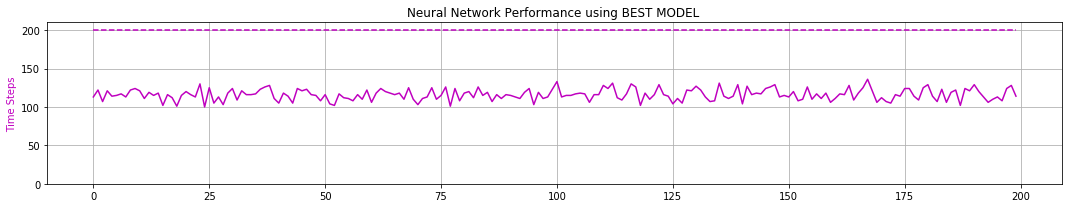

peak memory: 1423.53 MiB, increment: 977.29 MiB
0 -max- [ 0.194  0.939  0.049  0.817]
0 -min- [-2.398 -3.133 -0.209 -1.352]

1 -max- [ 0.192  0.930  0.050  0.689]
1 -min- [-2.400 -3.143 -0.209 -1.376]

2 -max- [ 0.194  0.638  0.050  0.683]
2 -min- [-2.396 -3.141 -0.209 -1.099]

3 -max- [ 0.191  0.816  0.050  0.638]
3 -min- [-2.399 -3.143 -0.209 -1.295]

4 -max- [ 0.160  0.642  0.049  0.686]
4 -min- [-2.396 -3.146 -0.209 -1.095]

5 -max- [ 0.185  0.828  0.048  0.630]
5 -min- [-2.391 -3.145 -0.209 -1.306]

6 -max- [ 0.187  0.635  0.050  0.622]
6 -min- [-2.394 -3.147 -0.209 -1.103]

7 -max- [ 0.195  0.815  0.049  0.621]
7 -min- [-2.399 -3.139 -0.209 -1.312]

8 -max- [ 0.178  0.986  0.050  0.655]
8 -min- [-2.395 -3.115 -0.209 -1.374]

9 -max- [ 0.191  0.818  0.049  0.634]
9 -min- [-2.397 -3.273 -0.209 -1.259]

Quantization TIME:  0.01 minutes


ITERATION # 69
SMALLEST TIMESTEP in ITERATION 69: 11
REAL TIME TO GENERATE 35087 EXPERIENCES:0:00:00.994773


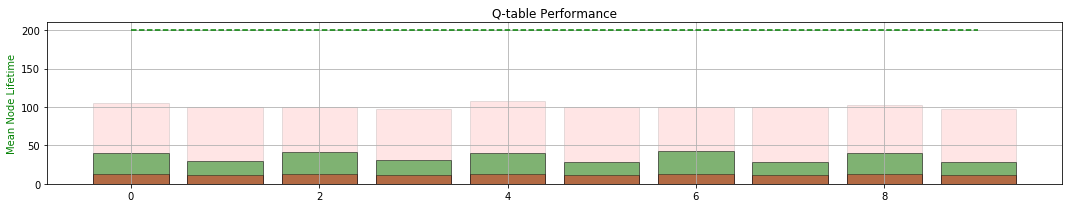

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.457	LOSS : 2.921	LOSS : 1.961	LOSS : 2.697	LOSS : 2.678	LOSS : 2.738	LOSS : 2.439	LOSS : 2.578	LOSS : 2.797	LOSS : 2.513	
Validating... MEAN TIME:  113.595
LOSS : 2.421	LOSS : 2.262	LOSS : 2.462	LOSS : 2.585	LOSS : 2.597	LOSS : 2.823	LOSS : 2.259	LOSS : 2.307	LOSS : 2.755	LOSS : 2.208	
Validating... MEAN TIME:  115.175
LOSS : 2.835	LOSS : 2.406	LOSS : 2.208	LOSS : 2.562	LOSS : 2.406	LOSS : 2.567	LOSS : 2.305	LOSS : 2.313	LOSS : 2.276	LOSS : 2.656	
Validating... MEAN TIME:  106.76
LOSS : 2.433	LOSS : 2.604	LOSS : 1.972	LOSS : 2.503	LOSS : 2.602	LOSS : 2.675	LOSS : 2.296	LOSS : 2.553	LOSS : 2.362	LOSS : 2.834	
Validating... MEAN TIME:  108.815
LOSS : 2.370	LOSS : 2.594	LOSS : 2.675	LOSS : 2.142	LOSS : 2.424	LOSS : 2.152	LOSS : 2.822	LOSS : 2.675	LOSS : 2.601	LOSS : 2.604	
Validating... MEAN TIME:  105.995
TRAINING TIME:0:00:26.618296


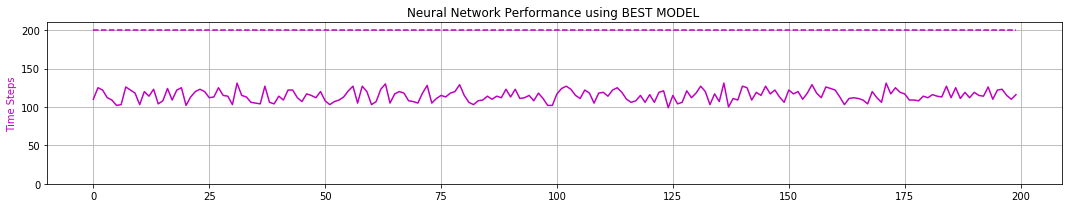

peak memory: 1393.34 MiB, increment: 1017.27 MiB
0 -max- [ 0.200  0.930  0.050  0.758]
0 -min- [-2.398 -3.258 -0.209 -1.376]

1 -max- [ 0.202  0.938  0.050  0.712]
1 -min- [-2.387 -3.163 -0.209 -1.582]

2 -max- [ 0.188  0.642  0.050  0.901]
2 -min- [-2.398 -3.333 -0.209 -1.101]

3 -max- [ 0.170  0.977  0.049  0.715]
3 -min- [-2.399 -3.164 -0.209 -1.704]

4 -max- [ 0.193  0.640  0.048  0.949]
4 -min- [-2.398 -3.289 -0.209 -1.099]

5 -max- [ 0.200  0.797  0.050  0.705]
5 -min- [-2.393 -3.302 -0.209 -1.175]

6 -max- [ 0.190  0.954  0.053  0.838]
6 -min- [-2.399 -3.161 -0.209 -1.382]

7 -max- [ 0.192  0.995  0.050  0.691]
7 -min- [-2.398 -3.148 -0.209 -1.521]

8 -max- [ 0.199  0.638  0.049  0.885]
8 -min- [-2.398 -3.288 -0.209 -1.099]

9 -max- [ 0.161  0.822  0.050  0.709]
9 -min- [-2.395 -3.299 -0.209 -1.425]

Quantization TIME:  0.01 minutes


ITERATION # 70
SMALLEST TIMESTEP in ITERATION 70: 11
REAL TIME TO GENERATE 39594 EXPERIENCES:0:00:00.985566


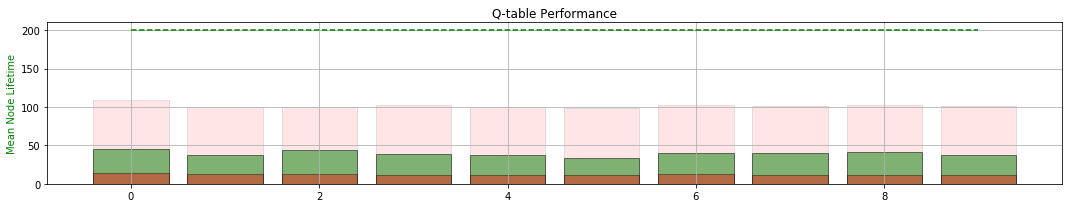

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.395	LOSS : 2.505	LOSS : 2.406	LOSS : 2.736	LOSS : 2.429	LOSS : 2.423	LOSS : 2.653	LOSS : 2.764	LOSS : 2.783	LOSS : 2.695	
Validating... MEAN TIME:  105.595
LOSS : 3.082	LOSS : 2.749	LOSS : 2.779	LOSS : 2.460	LOSS : 2.181	LOSS : 2.766	LOSS : 2.616	LOSS : 2.629	LOSS : 2.776	LOSS : 2.669	
Validating... MEAN TIME:  104.205
LOSS : 2.797	LOSS : 2.759	LOSS : 2.683	LOSS : 2.110	LOSS : 2.666	LOSS : 2.259	LOSS : 2.959	LOSS : 2.577	LOSS : 2.076	LOSS : 2.842	
Validating... MEAN TIME:  104.325
LOSS : 2.233	LOSS : 2.140	LOSS : 2.327	LOSS : 2.638	LOSS : 2.397	LOSS : 2.628	LOSS : 2.291	LOSS : 2.772	LOSS : 1.894	LOSS : 2.627	
Validating... MEAN TIME:  100.99
LOSS : 2.449	LOSS : 2.657	LOSS : 2.179	LOSS : 2.619	LOSS : 2.683	LOSS : 2.376	LOSS : 2.482	LOSS : 2.385	LOSS : 2.587	LOSS : 2.503	
Validating... MEAN TIME:  101.3
TRAINING TIME:0:00:25.228373


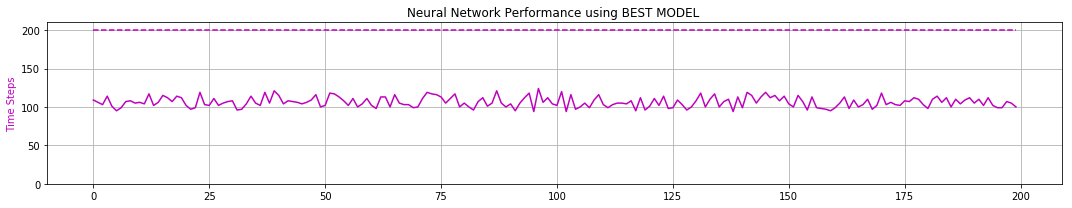

peak memory: 1364.38 MiB, increment: 992.07 MiB
0 -max- [ 0.186  0.927  0.050  0.789]
0 -min- [-2.400 -3.309 -0.209 -1.336]

1 -max- [ 0.191  0.830  0.050  0.731]
1 -min- [-2.399 -3.327 -0.209 -1.267]

2 -max- [ 0.160  0.642  0.049  0.936]
2 -min- [-2.398 -3.361 -0.209 -1.095]

3 -max- [ 0.177  0.983  0.048  0.725]
3 -min- [-2.400 -3.332 -0.209 -1.667]

4 -max- [ 0.193  0.635  0.050  0.711]
4 -min- [-2.399 -3.319 -0.209 -1.103]

5 -max- [ 0.204  0.988  0.049  0.704]
5 -min- [-2.397 -3.335 -0.209 -1.500]

6 -max- [ 0.185  0.985  0.050  0.945]
6 -min- [-2.400 -3.313 -0.209 -1.374]

7 -max- [ 0.191  0.819  0.049  0.729]
7 -min- [-2.398 -3.318 -0.209 -1.334]

8 -max- [ 0.146  0.642  0.050  0.910]
8 -min- [-2.396 -3.333 -0.209 -1.099]

9 -max- [ 0.183  0.825  0.049  0.718]
9 -min- [-2.399 -3.339 -0.209 -1.333]

Quantization TIME:  0.01 minutes


ITERATION # 71
SMALLEST TIMESTEP in ITERATION 71: 11
REAL TIME TO GENERATE 29988 EXPERIENCES:0:00:00.839584


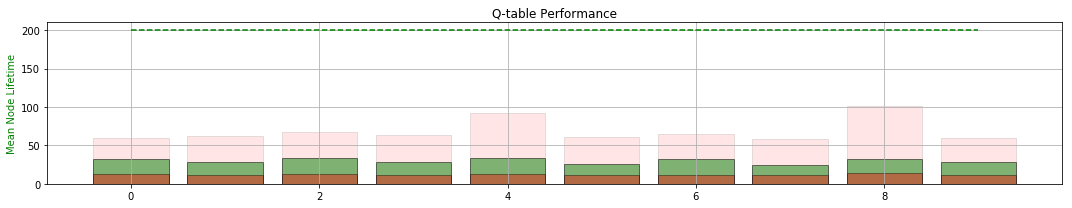

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.493	LOSS : 2.540	LOSS : 2.698	LOSS : 2.689	LOSS : 2.965	LOSS : 3.036	LOSS : 2.634	LOSS : 2.963	LOSS : 2.413	LOSS : 2.631	
Validating... MEAN TIME:  106.52
LOSS : 2.370	LOSS : 2.674	LOSS : 3.003	LOSS : 2.710	LOSS : 2.403	LOSS : 2.695	LOSS : 2.924	LOSS : 2.998	LOSS : 2.312	LOSS : 2.782	
Validating... MEAN TIME:  105.525
LOSS : 2.956	LOSS : 2.808	LOSS : 3.115	LOSS : 2.732	LOSS : 2.678	LOSS : 2.932	LOSS : 2.483	LOSS : 2.972	LOSS : 2.820	LOSS : 2.422	
Validating... MEAN TIME:  105.975
LOSS : 3.248	LOSS : 2.867	LOSS : 2.808	LOSS : 2.561	LOSS : 2.646	LOSS : 2.720	LOSS : 2.625	LOSS : 3.063	LOSS : 2.701	LOSS : 3.077	
Validating... MEAN TIME:  108.7
LOSS : 2.538	LOSS : 2.470	LOSS : 2.572	LOSS : 3.090	LOSS : 2.691	LOSS : 2.594	LOSS : 2.843	LOSS : 2.447	LOSS : 2.923	LOSS : 2.956	
Validating... MEAN TIME:  107.83
TRAINING TIME:0:00:25.594995


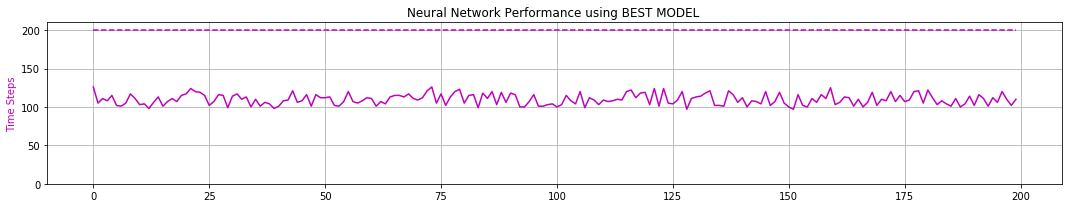

peak memory: 1417.99 MiB, increment: 977.84 MiB
0 -max- [ 0.191  0.641  0.050  0.514]
0 -min- [-0.583 -1.812 -0.209 -1.101]

1 -max- [ 0.186  0.832  0.049  0.383]
1 -min- [-0.627 -1.809 -0.209 -1.397]

2 -max- [ 0.185  0.640  0.048  0.593]
2 -min- [-0.781 -1.991 -0.209 -1.095]

3 -max- [ 0.200  0.813  0.050  0.383]
3 -min- [-0.616 -1.695 -0.209 -1.244]

4 -max- [ 0.190  0.951  0.054  0.681]
4 -min- [-2.390 -3.293 -0.209 -1.327]

5 -max- [ 0.186  0.985  0.050  0.383]
5 -min- [-0.595 -1.822 -0.209 -1.467]

6 -max- [ 0.199  0.640  0.049  0.590]
6 -min- [-0.662 -1.859 -0.209 -1.099]

7 -max- [ 0.164  0.944  0.050  0.378]
7 -min- [-0.618 -1.795 -0.209 -1.399]

8 -max- [ 0.191  0.636  0.049  0.672]
8 -min- [-2.399 -3.337 -0.209 -1.093]

9 -max- [ 0.197  0.821  0.050  0.377]
9 -min- [-0.607 -1.808 -0.209 -1.439]

Quantization TIME:  0.01 minutes


ITERATION # 72
SMALLEST TIMESTEP in ITERATION 72: 11
REAL TIME TO GENERATE 33004 EXPERIENCES:0:00:00.907777


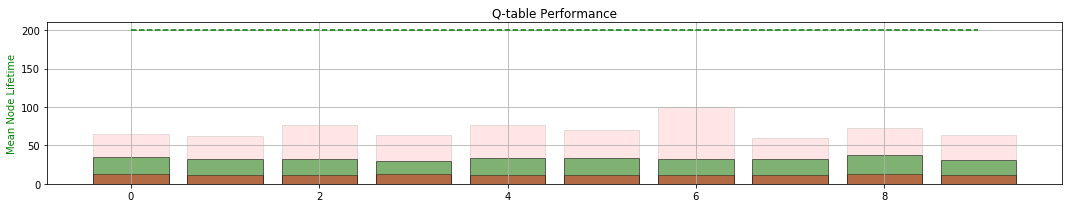

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.979	LOSS : 2.656	LOSS : 3.087	LOSS : 2.621	LOSS : 2.433	LOSS : 2.962	LOSS : 2.923	LOSS : 2.496	LOSS : 2.946	LOSS : 2.817	
Validating... MEAN TIME:  109.665
LOSS : 2.843	LOSS : 3.031	LOSS : 2.990	LOSS : 2.932	LOSS : 3.013	LOSS : 2.475	LOSS : 2.926	LOSS : 2.578	LOSS : 2.603	LOSS : 2.806	
Validating... MEAN TIME:  111.465
LOSS : 2.423	LOSS : 2.636	LOSS : 3.356	LOSS : 3.103	LOSS : 2.832	LOSS : 2.576	LOSS : 3.376	LOSS : 3.125	LOSS : 3.403	LOSS : 2.952	
Validating... MEAN TIME:  113.975
LOSS : 2.809	LOSS : 2.759	LOSS : 3.164	LOSS : 2.831	LOSS : 2.916	LOSS : 2.737	LOSS : 2.934	LOSS : 2.821	LOSS : 2.922	LOSS : 3.015	
Validating... MEAN TIME:  116.985
LOSS : 3.334	LOSS : 2.792	LOSS : 2.708	LOSS : 2.954	LOSS : 3.224	LOSS : 3.141	LOSS : 3.074	LOSS : 3.017	LOSS : 2.807	LOSS : 2.725	
Validating... MEAN TIME:  113.7
TRAINING TIME:0:00:26.507857


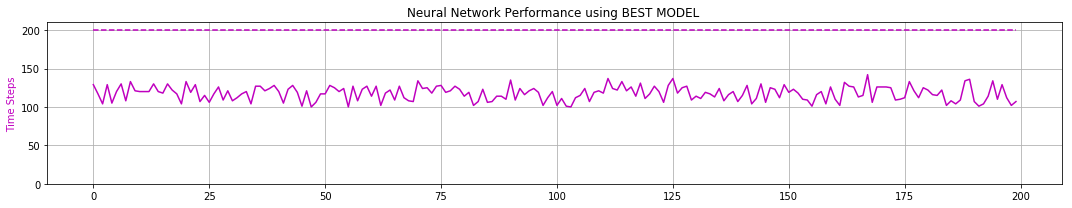

peak memory: 1408.99 MiB, increment: 1017.42 MiB
0 -max- [ 0.160  0.642  0.049  0.563]
0 -min- [-0.802 -1.863 -0.209 -1.095]

1 -max- [ 0.173  0.982  0.048  0.391]
1 -min- [-0.632 -1.664 -0.209 -1.506]

2 -max- [ 0.189  0.634  0.050  0.507]
2 -min- [-1.148 -2.344 -0.209 -1.103]

3 -max- [ 0.185  0.822  0.049  0.373]
3 -min- [-0.607 -1.680 -0.209 -1.313]

4 -max- [ 0.173  0.983  0.050  0.534]
4 -min- [-1.184 -2.363 -0.209 -1.358]

5 -max- [ 0.189  0.811  0.049  0.385]
5 -min- [-0.751 -1.996 -0.209 -1.258]

6 -max- [ 0.147  0.642  0.050  0.752]
6 -min- [-2.389 -3.455 -0.209 -1.099]

7 -max- [ 0.180  0.825  0.049  0.384]
7 -min- [-0.714 -1.975 -0.209 -1.378]

8 -max- [ 0.181  0.640  0.054  0.532]
8 -min- [-0.761 -1.998 -0.209 -1.099]

9 -max- [ 0.208  1.026  0.051  0.385]
9 -min- [-0.585 -1.666 -0.209 -1.497]

Quantization TIME:  0.01 minutes


ITERATION # 73
SMALLEST TIMESTEP in ITERATION 73: 12
REAL TIME TO GENERATE 36376 EXPERIENCES:0:00:00.981328


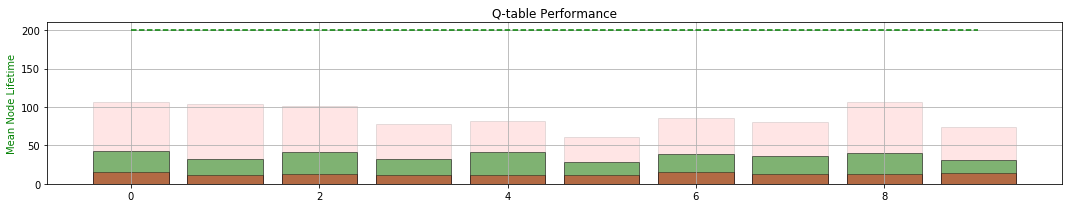

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.258	LOSS : 2.409	LOSS : 2.779	LOSS : 3.210	LOSS : 3.200	LOSS : 3.022	LOSS : 2.849	LOSS : 2.856	LOSS : 2.905	LOSS : 2.604	
Validating... MEAN TIME:  119.07
LOSS : 3.222	LOSS : 3.142	LOSS : 2.937	LOSS : 3.342	LOSS : 2.927	LOSS : 3.030	LOSS : 2.969	LOSS : 2.641	LOSS : 3.191	LOSS : 2.897	
Validating... MEAN TIME:  122.885
LOSS : 2.740	LOSS : 3.157	LOSS : 3.193	LOSS : 2.845	LOSS : 3.095	LOSS : 2.886	LOSS : 2.923	LOSS : 3.073	LOSS : 3.484	LOSS : 2.746	
Validating... MEAN TIME:  125.97
LOSS : 3.088	LOSS : 2.684	LOSS : 3.251	LOSS : 3.282	LOSS : 3.106	LOSS : 3.611	LOSS : 2.983	LOSS : 2.869	LOSS : 3.122	LOSS : 3.145	
Validating... MEAN TIME:  133.685
LOSS : 2.853	LOSS : 2.813	LOSS : 2.716	LOSS : 3.099	LOSS : 2.814	LOSS : 3.584	LOSS : 2.887	LOSS : 3.188	LOSS : 2.939	LOSS : 2.878	
Validating... MEAN TIME:  136.025
TRAINING TIME:0:00:28.997580


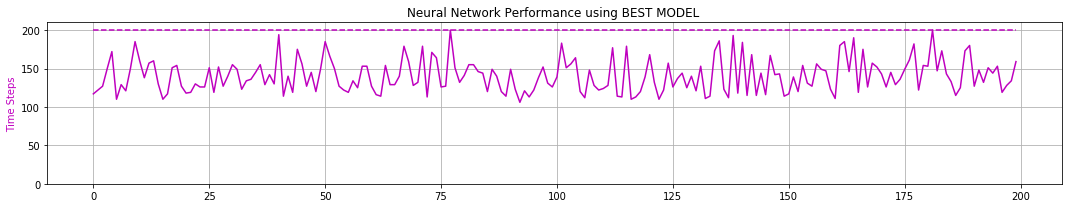

peak memory: 1411.68 MiB, increment: 981.04 MiB
0 -max- [ 0.172  0.801  0.054  0.604]
0 -min- [-2.395 -3.312 -0.209 -1.098]

1 -max- [ 0.185  0.797  0.050  0.529]
1 -min- [-2.385 -3.481 -0.209 -1.240]

2 -max- [ 0.172  0.637  0.049  0.584]
2 -min- [-2.364 -3.432 -0.209 -1.085]

3 -max- [ 0.178  0.813  0.050  0.390]
3 -min- [-1.228 -2.350 -0.209 -1.374]

4 -max- [ 0.190  0.638  0.049  0.582]
4 -min- [-1.361 -2.371 -0.209 -1.095]

5 -max- [ 0.149  1.002  0.050  0.388]
5 -min- [-0.638 -1.697 -0.209 -1.491]

6 -max- [ 0.169  0.636  0.049  0.524]
6 -min- [-1.252 -2.369 -0.209 -1.075]

7 -max- [ 0.186  0.821  0.050  0.387]
7 -min- [-1.162 -2.338 -0.209 -1.327]

8 -max- [ 0.202  0.641  0.051  0.580]
8 -min- [-2.394 -3.446 -0.209 -1.092]

9 -max- [ 0.181  0.828  0.049  0.381]
9 -min- [-1.184 -2.365 -0.209 -1.402]

Quantization TIME:  0.01 minutes


ITERATION # 74
SMALLEST TIMESTEP in ITERATION 74: 10
REAL TIME TO GENERATE 51414 EXPERIENCES:0:00:01.340065


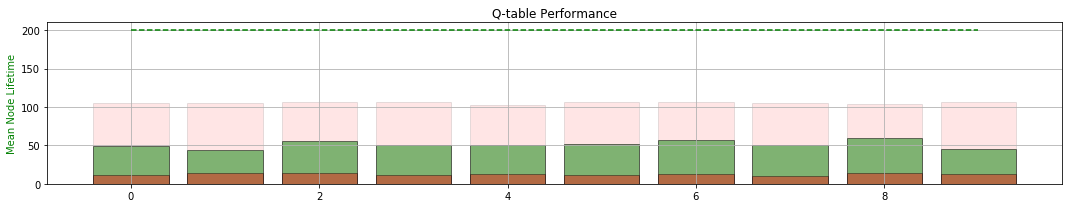

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.130	LOSS : 2.569	LOSS : 2.705	LOSS : 2.963	LOSS : 2.721	LOSS : 3.158	LOSS : 3.129	LOSS : 2.960	LOSS : 2.895	LOSS : 3.007	
Validating... MEAN TIME:  137.375
LOSS : 2.554	LOSS : 2.727	LOSS : 2.861	LOSS : 3.210	LOSS : 2.593	LOSS : 3.060	LOSS : 3.076	LOSS : 3.117	LOSS : 3.093	LOSS : 3.178	
Validating... MEAN TIME:  136.54
LOSS : 3.037	LOSS : 2.634	LOSS : 2.799	LOSS : 2.896	LOSS : 3.271	LOSS : 3.199	LOSS : 2.522	LOSS : 2.950	LOSS : 3.176	LOSS : 2.694	
Validating... MEAN TIME:  136.825
LOSS : 3.029	LOSS : 3.163	LOSS : 2.577	LOSS : 3.235	LOSS : 3.030	LOSS : 2.842	LOSS : 2.566	LOSS : 2.902	LOSS : 2.939	LOSS : 2.753	
Validating... MEAN TIME:  143.965
LOSS : 2.788	LOSS : 2.547	LOSS : 2.966	LOSS : 2.701	LOSS : 2.726	LOSS : 3.031	LOSS : 2.701	LOSS : 2.850	LOSS : 2.549	LOSS : 3.299	
Validating... MEAN TIME:  130.42
TRAINING TIME:0:00:30.844143


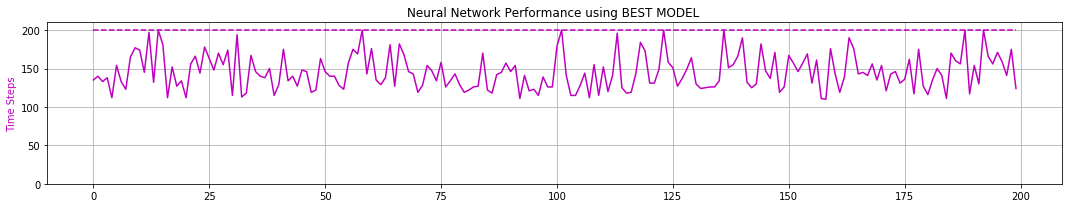

peak memory: 1454.55 MiB, increment: 1039.75 MiB
0 -max- [ 0.186  0.634  0.052  0.654]
0 -min- [-2.398 -3.475 -0.209 -1.098]

1 -max- [ 0.172  0.800  0.049  0.605]
1 -min- [-2.399 -3.431 -0.209 -1.454]

2 -max- [ 0.174  0.789  0.050  0.766]
2 -min- [-2.399 -3.473 -0.209 -1.095]

3 -max- [ 0.185  0.824  0.049  0.651]
3 -min- [-2.396 -3.452 -0.209 -1.421]

4 -max- [ 0.146  0.642  0.050  0.687]
4 -min- [-2.392 -3.471 -0.209 -1.099]

5 -max- [ 0.184  0.821  0.049  0.619]
5 -min- [-2.398 -3.462 -0.209 -1.282]

6 -max- [ 0.179  0.640  0.050  0.619]
6 -min- [-2.398 -3.458 -0.209 -1.099]

7 -max- [ 0.210  1.026  0.051  0.616]
7 -min- [-2.399 -3.465 -0.209 -1.703]

8 -max- [ 0.180  0.639  0.049  0.638]
8 -min- [-2.395 -3.449 -0.209 -1.092]

9 -max- [ 0.181  0.824  0.050  0.600]
9 -min- [-2.396 -3.475 -0.209 -1.309]

Quantization TIME:  0.01 minutes


ITERATION # 75
SMALLEST TIMESTEP in ITERATION 75: 12
REAL TIME TO GENERATE 49171 EXPERIENCES:0:00:01.196411


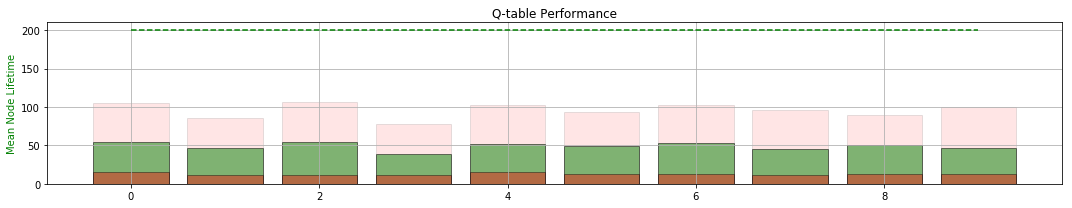

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.678	LOSS : 2.733	LOSS : 3.138	LOSS : 2.777	LOSS : 2.696	LOSS : 2.610	LOSS : 2.782	LOSS : 2.500	LOSS : 2.841	LOSS : 2.650	
Validating... MEAN TIME:  131.28
LOSS : 2.754	LOSS : 2.944	LOSS : 2.953	LOSS : 3.059	LOSS : 2.644	LOSS : 2.518	LOSS : 2.797	LOSS : 2.546	LOSS : 2.275	LOSS : 2.846	
Validating... MEAN TIME:  125.975
LOSS : 2.826	LOSS : 2.873	LOSS : 2.758	LOSS : 2.960	LOSS : 2.733	LOSS : 2.711	LOSS : 2.830	LOSS : 2.466	LOSS : 2.783	LOSS : 2.514	
Validating... MEAN TIME:  128.66
LOSS : 2.416	LOSS : 2.727	LOSS : 2.657	LOSS : 2.615	LOSS : 2.249	LOSS : 2.695	LOSS : 2.645	LOSS : 2.312	LOSS : 2.813	LOSS : 2.984	
Validating... MEAN TIME:  119.69
LOSS : 2.498	LOSS : 2.556	LOSS : 2.870	LOSS : 2.898	LOSS : 2.909	LOSS : 2.482	LOSS : 2.709	LOSS : 2.629	LOSS : 2.800	LOSS : 2.669	
Validating... MEAN TIME:  117.055
TRAINING TIME:0:00:29.356461


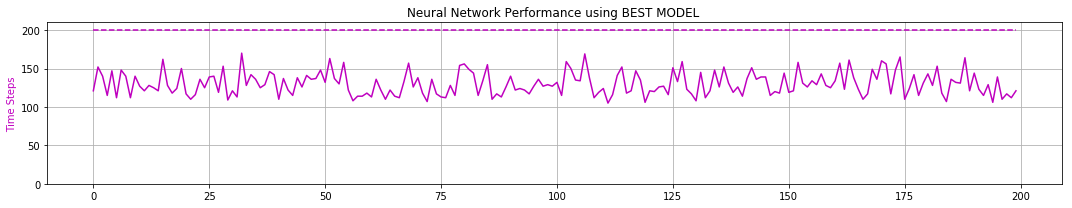

peak memory: 1461.77 MiB, increment: 1022.70 MiB
0 -max- [ 0.172  0.635  0.049  0.956]
0 -min- [-2.362 -3.116 -0.209 -1.072]

1 -max- [ 0.178  0.983  0.050  0.517]
1 -min- [-1.439 -2.571 -0.209 -1.432]

2 -max- [ 0.185  0.638  0.049  0.709]
2 -min- [-2.354 -3.315 -0.209 -1.091]

3 -max- [ 0.168  0.817  0.050  0.385]
3 -min- [-1.228 -2.343 -0.209 -1.337]

4 -max- [ 0.177  0.983  0.057  0.598]
4 -min- [-2.373 -3.122 -0.209 -1.331]

5 -max- [ 0.179  0.831  0.050  0.390]
5 -min- [-2.400 -3.297 -0.209 -1.412]

6 -max- [ 0.200  0.942  0.058  0.735]
6 -min- [-2.373 -3.293 -0.209 -1.307]

7 -max- [ 0.180  0.827  0.049  0.589]
7 -min- [-2.392 -3.257 -0.209 -1.326]

8 -max- [ 0.181  1.018  0.050  0.787]
8 -min- [-1.555 -2.582 -0.209 -1.353]

9 -max- [ 0.159  0.820  0.049  0.533]
9 -min- [-2.353 -3.113 -0.209 -1.237]

Quantization TIME:  0.01 minutes


ITERATION # 76
SMALLEST TIMESTEP in ITERATION 76: 12
REAL TIME TO GENERATE 42848 EXPERIENCES:0:00:01.061954


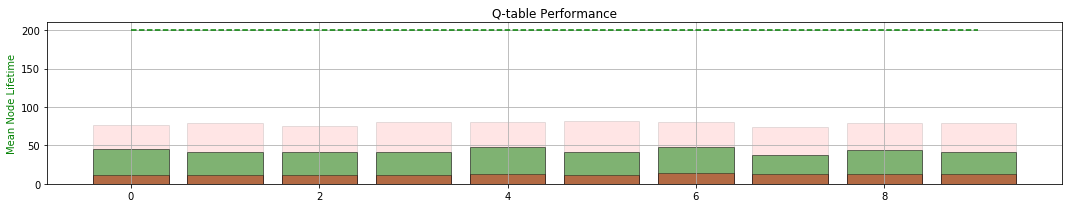

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.640	LOSS : 2.295	LOSS : 2.882	LOSS : 2.572	LOSS : 2.589	LOSS : 2.520	LOSS : 2.942	LOSS : 2.203	LOSS : 2.637	LOSS : 2.443	
Validating... MEAN TIME:  116.26
LOSS : 2.324	LOSS : 2.531	LOSS : 2.730	LOSS : 2.747	LOSS : 2.724	LOSS : 2.311	LOSS : 2.884	LOSS : 3.076	LOSS : 2.827	LOSS : 2.966	
Validating... MEAN TIME:  114.89
LOSS : 2.635	LOSS : 2.480	LOSS : 2.901	LOSS : 2.694	LOSS : 2.517	LOSS : 2.456	LOSS : 2.867	LOSS : 2.755	LOSS : 2.812	LOSS : 2.747	
Validating... MEAN TIME:  113.36
LOSS : 2.477	LOSS : 2.468	LOSS : 2.691	LOSS : 2.521	LOSS : 2.523	LOSS : 2.586	LOSS : 2.862	LOSS : 2.790	LOSS : 2.536	LOSS : 2.532	
Validating... MEAN TIME:  118.565
LOSS : 2.790	LOSS : 2.818	LOSS : 2.771	LOSS : 2.404	LOSS : 2.763	LOSS : 2.447	LOSS : 2.624	LOSS : 3.126	LOSS : 2.332	LOSS : 2.556	
Validating... MEAN TIME:  115.165
TRAINING TIME:0:00:27.291143


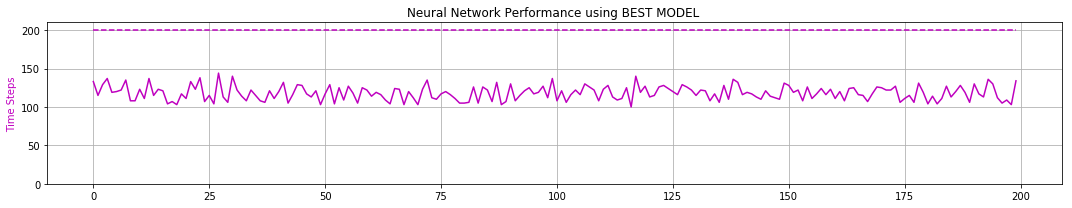

peak memory: 1413.47 MiB, increment: 1017.21 MiB
0 -max- [ 0.169  0.984  0.050  0.705]
0 -min- [-1.087 -2.192 -0.209 -1.364]

1 -max- [ 0.189  0.776  0.049  0.542]
1 -min- [-1.285 -2.341 -0.209 -1.205]

2 -max- [ 0.146  0.642  0.050  0.559]
2 -min- [-1.168 -2.175 -0.209 -1.099]

3 -max- [ 0.180  0.825  0.049  0.383]
3 -min- [-1.137 -2.349 -0.209 -1.322]

4 -max- [ 0.187  0.998  0.050  0.618]
4 -min- [-1.322 -2.349 -0.209 -1.341]

5 -max- [ 0.204  1.026  0.051  0.390]
5 -min- [-1.224 -2.159 -0.209 -1.497]

6 -max- [ 0.180  0.639  0.049  0.597]
6 -min- [-1.379 -2.372 -0.209 -1.096]

7 -max- [ 0.183  1.018  0.050  0.388]
7 -min- [-1.152 -2.186 -0.209 -1.401]

8 -max- [ 0.162  0.642  0.049  0.609]
8 -min- [-1.084 -2.175 -0.209 -1.091]

9 -max- [ 0.177  0.810  0.050  0.382]
9 -min- [-1.239 -2.321 -0.209 -1.273]

Quantization TIME:  0.01 minutes


ITERATION # 77
SMALLEST TIMESTEP in ITERATION 77: 11
REAL TIME TO GENERATE 26691 EXPERIENCES:0:00:00.734699


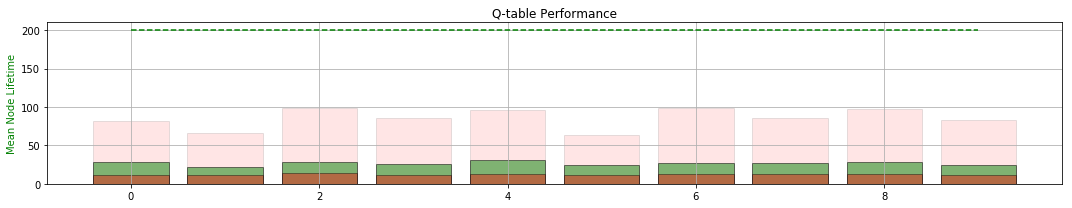

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.620	LOSS : 2.372	LOSS : 2.697	LOSS : 3.003	LOSS : 2.640	LOSS : 2.853	LOSS : 2.679	LOSS : 2.795	LOSS : 2.486	LOSS : 2.724	
Validating... MEAN TIME:  112.075
LOSS : 2.762	LOSS : 2.639	LOSS : 2.641	LOSS : 2.389	LOSS : 2.545	LOSS : 2.463	LOSS : 2.470	LOSS : 2.715	LOSS : 2.759	LOSS : 2.538	
Validating... MEAN TIME:  108.01
LOSS : 2.784	LOSS : 2.277	LOSS : 2.689	LOSS : 2.789	LOSS : 2.753	LOSS : 2.353	LOSS : 3.170	LOSS : 2.641	LOSS : 2.676	LOSS : 2.974	
Validating... MEAN TIME:  109.54
LOSS : 2.653	LOSS : 3.084	LOSS : 2.843	LOSS : 2.926	LOSS : 2.329	LOSS : 2.750	LOSS : 2.642	LOSS : 2.888	LOSS : 2.650	LOSS : 2.908	
Validating... MEAN TIME:  110.29
LOSS : 2.961	LOSS : 2.837	LOSS : 2.726	LOSS : 2.478	LOSS : 2.680	LOSS : 2.666	LOSS : 2.965	LOSS : 2.502	LOSS : 3.007	LOSS : 2.876	
Validating... MEAN TIME:  109.535
TRAINING TIME:0:00:25.565591


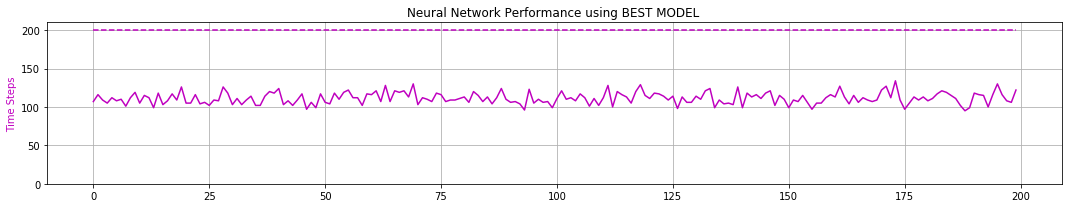

peak memory: 1414.65 MiB, increment: 1034.66 MiB
0 -max- [ 0.207  0.639  0.049  0.606]
0 -min- [-1.558 -2.596 -0.209 -1.099]

1 -max- [ 0.165  0.977  0.050  0.382]
1 -min- [-0.746 -1.839 -0.209 -1.612]

2 -max- [ 0.203  0.641  0.049  0.589]
2 -min- [-2.373 -3.329 -0.209 -1.093]

3 -max- [ 0.200  0.952  0.050  0.385]
3 -min- [-1.684 -2.717 -0.209 -1.477]

4 -max- [ 0.214  0.824  0.051  0.784]
4 -min- [-2.387 -3.273 -0.209 -1.088]

5 -max- [ 0.193  0.828  0.049  0.379]
5 -min- [-0.665 -1.772 -0.209 -1.431]

6 -max- [ 0.194  1.018  0.055  0.380]
6 -min- [-2.378 -3.333 -0.209 -1.361]

7 -max- [ 0.183  0.971  0.049  0.375]
7 -min- [-1.477 -2.398 -0.209 -1.460]

8 -max- [ 0.199  0.641  0.050  0.712]
8 -min- [-2.359 -3.121 -0.209 -1.097]

9 -max- [ 0.213  0.831  0.051  0.389]
9 -min- [-1.466 -2.402 -0.209 -1.424]

Quantization TIME:  0.01 minutes


ITERATION # 78
SMALLEST TIMESTEP in ITERATION 78: 11
REAL TIME TO GENERATE 24304 EXPERIENCES:0:00:00.671063


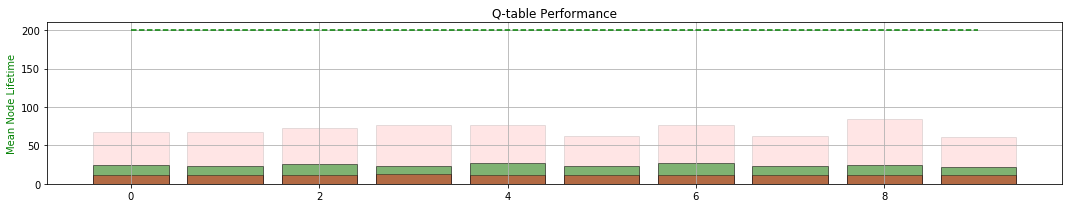

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.669	LOSS : 2.972	LOSS : 3.107	LOSS : 2.516	LOSS : 2.811	LOSS : 2.587	LOSS : 2.995	LOSS : 3.152	LOSS : 2.908	LOSS : 2.860	
Validating... MEAN TIME:  113.74
LOSS : 2.284	LOSS : 3.149	LOSS : 3.375	LOSS : 2.751	LOSS : 2.568	LOSS : 2.890	LOSS : 2.803	LOSS : 2.881	LOSS : 3.168	LOSS : 2.602	
Validating... MEAN TIME:  119.065
LOSS : 2.661	LOSS : 2.527	LOSS : 2.813	LOSS : 2.954	LOSS : 2.670	LOSS : 2.863	LOSS : 2.680	LOSS : 2.830	LOSS : 3.029	LOSS : 3.095	
Validating... MEAN TIME:  116.575
LOSS : 2.903	LOSS : 2.962	LOSS : 2.992	LOSS : 2.819	LOSS : 2.624	LOSS : 2.630	LOSS : 2.698	LOSS : 3.006	LOSS : 3.023	LOSS : 2.975	
Validating... MEAN TIME:  111.43
LOSS : 2.948	LOSS : 2.765	LOSS : 2.879	LOSS : 2.928	LOSS : 3.174	LOSS : 2.610	LOSS : 2.555	LOSS : 2.931	LOSS : 3.235	LOSS : 3.019	
Validating... MEAN TIME:  116.55
TRAINING TIME:0:00:26.027193


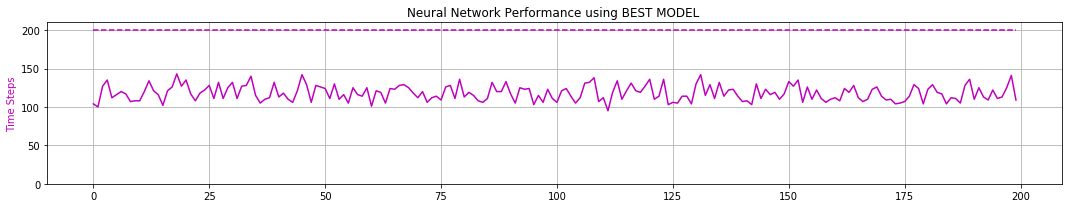

peak memory: 1455.54 MiB, increment: 1016.97 MiB
0 -max- [ 0.174  0.942  0.053  0.563]
0 -min- [-0.874 -1.862 -0.209 -1.326]

1 -max- [ 0.207  0.829  0.049  0.383]
1 -min- [-0.896 -2.061 -0.209 -1.383]

2 -max- [ 0.213  0.816  0.050  0.520]
2 -min- [-0.881 -1.865 -0.209 -1.169]

3 -max- [ 0.219  1.026  0.051  0.377]
3 -min- [-1.137 -2.332 -0.209 -1.666]

4 -max- [ 0.213  1.004  0.049  0.522]
4 -min- [-1.393 -2.414 -0.209 -1.376]

5 -max- [ 0.214  1.019  0.050  0.380]
5 -min- [-0.819 -1.859 -0.209 -1.519]

6 -max- [ 0.189  0.816  0.049  0.548]
6 -min- [-1.412 -2.407 -0.209 -1.170]

7 -max- [ 0.204  0.827  0.050  0.380]
7 -min- [-0.672 -1.694 -0.209 -1.478]

8 -max- [ 0.213  0.980  0.051  0.506]
8 -min- [-1.403 -2.391 -0.209 -1.374]

9 -max- [ 0.209  1.171  0.050  0.374]
9 -min- [-0.818 -1.987 -0.209 -1.794]

Quantization TIME:  0.01 minutes


ITERATION # 79
SMALLEST TIMESTEP in ITERATION 79: 11
REAL TIME TO GENERATE 27033 EXPERIENCES:0:00:00.687284


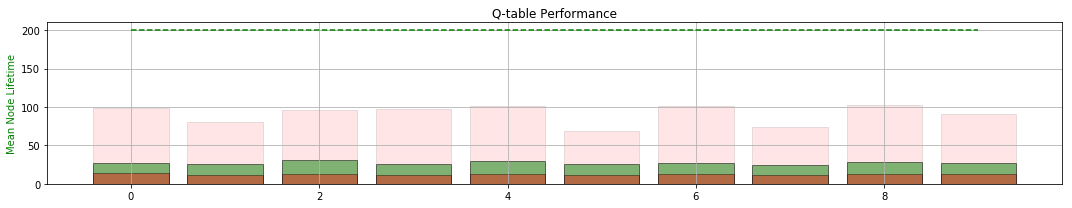

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.738	LOSS : 2.787	LOSS : 3.205	LOSS : 3.246	LOSS : 2.976	LOSS : 2.719	LOSS : 2.805	LOSS : 2.702	LOSS : 3.027	LOSS : 2.928	
Validating... MEAN TIME:  111.625
LOSS : 3.031	LOSS : 2.456	LOSS : 2.991	LOSS : 3.020	LOSS : 2.681	LOSS : 2.932	LOSS : 2.858	LOSS : 2.863	LOSS : 3.331	LOSS : 2.801	
Validating... MEAN TIME:  114.065
LOSS : 2.609	LOSS : 2.813	LOSS : 2.749	LOSS : 2.848	LOSS : 2.864	LOSS : 2.893	LOSS : 3.250	LOSS : 2.946	LOSS : 2.915	LOSS : 3.060	
Validating... MEAN TIME:  112.85
LOSS : 3.220	LOSS : 2.777	LOSS : 3.355	LOSS : 3.058	LOSS : 3.436	LOSS : 3.118	LOSS : 2.826	LOSS : 2.821	LOSS : 2.756	LOSS : 2.627	
Validating... MEAN TIME:  116.37
LOSS : 2.580	LOSS : 3.052	LOSS : 2.815	LOSS : 2.953	LOSS : 2.944	LOSS : 3.455	LOSS : 3.296	LOSS : 3.153	LOSS : 3.251	LOSS : 2.923	
Validating... MEAN TIME:  114.22
TRAINING TIME:0:00:25.747867


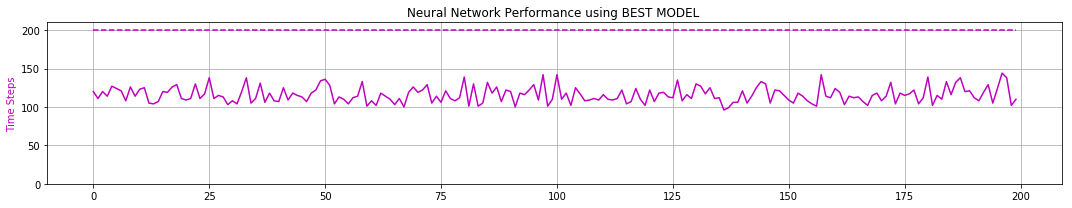

peak memory: 1394.79 MiB, increment: 1016.11 MiB
0 -max- [ 0.204  0.642  0.049  0.449]
0 -min- [-2.378 -3.335 -0.209 -1.093]

1 -max- [ 0.215  0.823  0.050  0.385]
1 -min- [-1.475 -2.356 -0.209 -1.360]

2 -max- [ 0.212  0.824  0.051  0.582]
2 -min- [-2.379 -3.274 -0.209 -1.088]

3 -max- [ 0.206  0.828  0.049  0.382]
3 -min- [-2.354 -3.255 -0.209 -1.394]

4 -max- [ 0.194  1.018  0.055  0.576]
4 -min- [-2.398 -3.320 -0.209 -1.353]

5 -max- [ 0.181  0.822  0.049  0.374]
5 -min- [-0.899 -2.052 -0.209 -1.291]

6 -max- [ 0.199  0.642  0.054  0.559]
6 -min- [-2.382 -3.324 -0.209 -1.097]

7 -max- [ 0.213  0.833  0.051  0.372]
7 -min- [-1.032 -2.063 -0.209 -1.353]

8 -max- [ 0.199  0.643  0.050  0.959]
8 -min- [-2.365 -3.276 -0.209 -1.096]

9 -max- [ 0.193  0.809  0.049  0.384]
9 -min- [-2.349 -3.116 -0.209 -1.363]

Quantization TIME:  0.01 minutes


ITERATION # 80
SMALLEST TIMESTEP in ITERATION 80: 11
REAL TIME TO GENERATE 26020 EXPERIENCES:0:00:00.701984


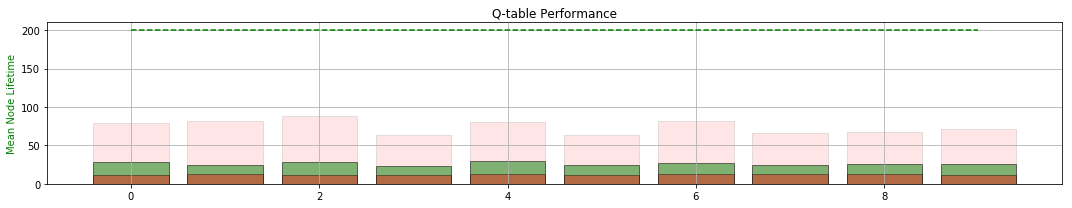

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.097	LOSS : 2.937	LOSS : 3.136	LOSS : 2.937	LOSS : 2.634	LOSS : 2.530	LOSS : 3.161	LOSS : 3.231	LOSS : 2.747	LOSS : 3.147	
Validating... MEAN TIME:  113.665
LOSS : 2.752	LOSS : 2.972	LOSS : 2.702	LOSS : 2.673	LOSS : 3.194	LOSS : 2.473	LOSS : 3.088	LOSS : 3.057	LOSS : 3.203	LOSS : 3.175	
Validating... MEAN TIME:  112.535
LOSS : 2.617	LOSS : 2.763	LOSS : 3.077	LOSS : 2.780	LOSS : 2.948	LOSS : 2.673	LOSS : 2.923	LOSS : 2.791	LOSS : 2.806	LOSS : 2.917	
Validating... MEAN TIME:  111.4
LOSS : 2.545	LOSS : 3.096	LOSS : 2.768	LOSS : 3.027	LOSS : 2.506	LOSS : 2.534	LOSS : 2.805	LOSS : 2.991	LOSS : 2.779	LOSS : 2.601	
Validating... MEAN TIME:  110.315
LOSS : 3.331	LOSS : 3.005	LOSS : 3.125	LOSS : 3.276	LOSS : 2.998	LOSS : 2.657	LOSS : 3.059	LOSS : 2.924	LOSS : 3.041	LOSS : 2.682	
Validating... MEAN TIME:  109.925
TRAINING TIME:0:00:25.488760


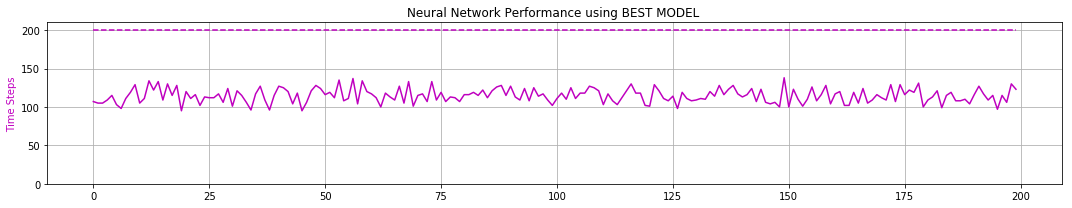

peak memory: 1400.52 MiB, increment: 1034.37 MiB
0 -max- [ 0.199  0.950  0.050  0.584]
0 -min- [-1.136 -2.213 -0.209 -1.361]

1 -max- [ 0.222  1.026  0.051  0.382]
1 -min- [-1.447 -2.566 -0.209 -1.527]

2 -max- [ 0.206  0.641  0.049  0.596]
2 -min- [-1.790 -2.692 -0.209 -1.095]

3 -max- [ 0.215  1.018  0.050  0.380]
3 -min- [-0.708 -1.861 -0.209 -1.369]

4 -max- [ 0.181  0.642  0.049  0.510]
4 -min- [-1.642 -2.768 -0.209 -1.091]

5 -max- [ 0.202  0.832  0.050  0.380]
5 -min- [-0.862 -1.877 -0.209 -1.370]

6 -max- [ 0.205  0.643  0.051  0.527]
6 -min- [-1.448 -2.400 -0.209 -1.094]

7 -max- [ 0.191  1.167  0.050  0.388]
7 -min- [-0.716 -1.861 -0.209 -1.692]

8 -max- [ 0.201  0.953  0.049  0.579]
8 -min- [-0.847 -1.991 -0.209 -1.353]

9 -max- [ 0.205  0.999  0.050  0.384]
9 -min- [-0.814 -2.034 -0.209 -1.440]

Quantization TIME:  0.01 minutes


ITERATION # 81
SMALLEST TIMESTEP in ITERATION 81: 11
REAL TIME TO GENERATE 24602 EXPERIENCES:0:00:00.724055


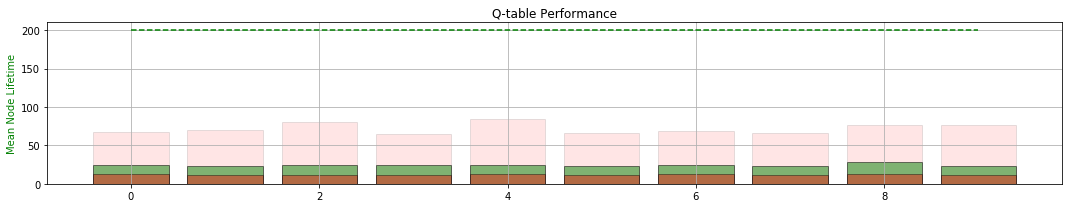

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.961	LOSS : 3.480	LOSS : 3.322	LOSS : 2.968	LOSS : 3.191	LOSS : 3.355	LOSS : 2.887	LOSS : 3.090	LOSS : 2.845	LOSS : 2.894	
Validating... MEAN TIME:  112.63
LOSS : 3.169	LOSS : 2.926	LOSS : 2.539	LOSS : 3.143	LOSS : 3.259	LOSS : 3.135	LOSS : 3.119	LOSS : 3.080	LOSS : 3.323	LOSS : 2.710	
Validating... MEAN TIME:  115.065
LOSS : 3.099	LOSS : 2.936	LOSS : 3.088	LOSS : 3.318	LOSS : 3.157	LOSS : 2.544	LOSS : 3.442	LOSS : 2.816	LOSS : 3.216	LOSS : 2.992	
Validating... MEAN TIME:  119.02
LOSS : 2.651	LOSS : 2.908	LOSS : 3.205	LOSS : 3.159	LOSS : 2.921	LOSS : 2.857	LOSS : 2.754	LOSS : 2.844	LOSS : 3.068	LOSS : 3.088	
Validating... MEAN TIME:  115.545
LOSS : 3.064	LOSS : 2.535	LOSS : 3.074	LOSS : 3.048	LOSS : 3.043	LOSS : 2.957	LOSS : 2.839	LOSS : 3.471	LOSS : 3.435	LOSS : 3.362	
Validating... MEAN TIME:  116.175
TRAINING TIME:0:00:27.197181


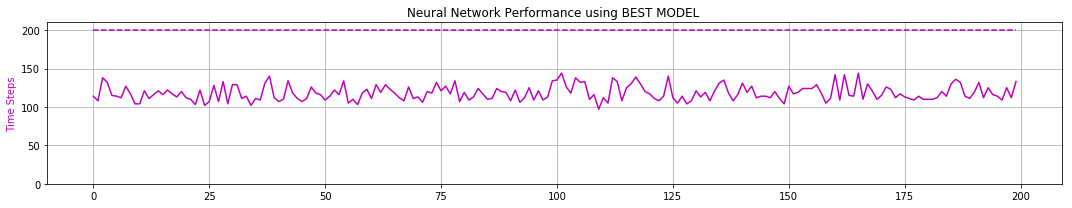

peak memory: 1410.71 MiB, increment: 976.19 MiB
0 -max- [ 0.221  0.824  0.052  0.483]
0 -min- [-1.190 -2.358 -0.209 -1.100]

1 -max- [ 0.206  0.838  0.049  0.377]
1 -min- [-1.050 -2.163 -0.209 -1.386]

2 -max- [ 0.215  1.018  0.057  0.541]
2 -min- [-1.401 -2.425 -0.209 -1.359]

3 -max- [ 0.181  0.823  0.049  0.382]
3 -min- [-0.805 -1.869 -0.209 -1.428]

4 -max- [ 0.199  0.643  0.050  0.542]
4 -min- [-1.783 -2.785 -0.209 -1.097]

5 -max- [ 0.213  0.833  0.051  0.379]
5 -min- [-0.802 -1.860 -0.209 -1.444]

6 -max- [ 0.212  0.643  0.050  0.522]
6 -min- [-1.137 -2.037 -0.209 -1.100]

7 -max- [ 0.209  0.795  0.049  0.378]
7 -min- [-0.783 -1.834 -0.209 -1.383]

8 -max- [ 0.194  0.644  0.050  0.601]
8 -min- [-1.188 -2.175 -0.209 -1.092]

9 -max- [ 0.195  0.826  0.047  0.388]
9 -min- [-1.276 -2.421 -0.209 -1.406]

Quantization TIME:  0.01 minutes


ITERATION # 82
SMALLEST TIMESTEP in ITERATION 82: 10
REAL TIME TO GENERATE 27049 EXPERIENCES:0:00:00.715830


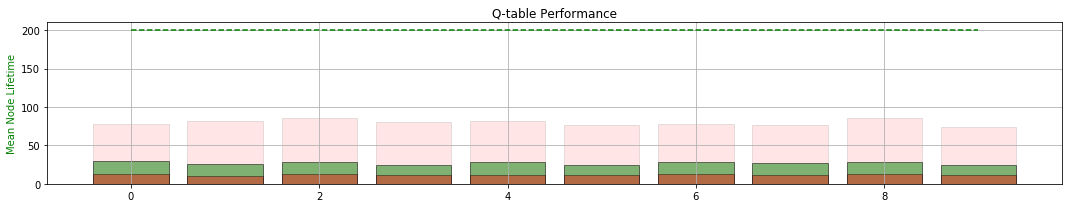

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.071	LOSS : 3.252	LOSS : 3.244	LOSS : 3.380	LOSS : 2.870	LOSS : 3.567	LOSS : 2.751	LOSS : 3.264	LOSS : 2.997	LOSS : 2.846	
Validating... MEAN TIME:  122.66
LOSS : 3.060	LOSS : 2.838	LOSS : 3.271	LOSS : 3.805	LOSS : 3.155	LOSS : 3.311	LOSS : 3.123	LOSS : 3.190	LOSS : 3.210	LOSS : 2.801	
Validating... MEAN TIME:  126.44
LOSS : 3.135	LOSS : 3.424	LOSS : 3.230	LOSS : 3.061	LOSS : 3.048	LOSS : 3.333	LOSS : 3.310	LOSS : 3.278	LOSS : 3.149	LOSS : 2.971	
Validating... MEAN TIME:  127.63
LOSS : 3.074	LOSS : 3.355	LOSS : 2.763	LOSS : 3.288	LOSS : 3.166	LOSS : 3.359	LOSS : 2.992	LOSS : 2.752	LOSS : 3.378	LOSS : 3.281	
Validating... MEAN TIME:  121.915
LOSS : 3.018	LOSS : 2.688	LOSS : 3.148	LOSS : 3.043	LOSS : 3.085	LOSS : 3.259	LOSS : 2.848	LOSS : 3.119	LOSS : 3.175	LOSS : 3.127	
Validating... MEAN TIME:  110.755
TRAINING TIME:0:00:28.229985


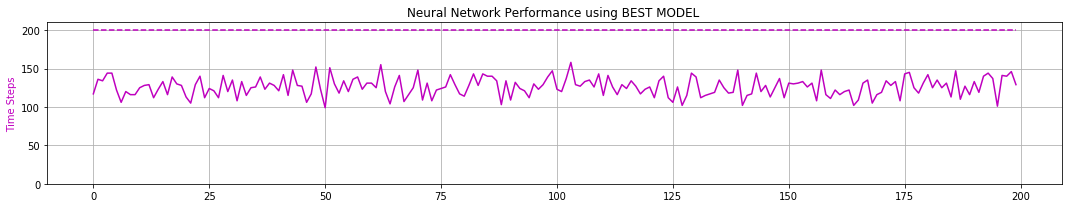

peak memory: 1382.96 MiB, increment: 1016.46 MiB
0 -max- [ 0.206  0.641  0.049  0.591]
0 -min- [-1.528 -2.522 -0.209 -1.095]

1 -max- [ 0.193  1.018  0.050  0.384]
1 -min- [-1.437 -2.426 -0.209 -1.768]

2 -max- [ 0.181  0.642  0.049  0.547]
2 -min- [-1.424 -2.416 -0.209 -1.091]

3 -max- [ 0.199  0.832  0.050  0.379]
3 -min- [-1.440 -2.393 -0.209 -1.383]

4 -max- [ 0.213  0.643  0.051  0.483]
4 -min- [-1.263 -2.404 -0.209 -1.099]

5 -max- [ 0.188  0.824  0.050  0.388]
5 -min- [-1.149 -2.353 -0.209 -1.380]

6 -max- [ 0.193  0.954  0.049  0.591]
6 -min- [-1.246 -2.387 -0.209 -1.356]

7 -max- [ 0.197  0.815  0.050  0.383]
7 -min- [-1.429 -2.425 -0.209 -1.424]

8 -max- [ 0.199  0.642  0.050  0.600]
8 -min- [-1.485 -2.418 -0.209 -1.101]

9 -max- [ 0.180  0.815  0.046  0.382]
9 -min- [-1.225 -2.418 -0.209 -1.320]

Quantization TIME:  0.01 minutes


ITERATION # 83
SMALLEST TIMESTEP in ITERATION 83: 11
REAL TIME TO GENERATE 30296 EXPERIENCES:0:00:00.841997


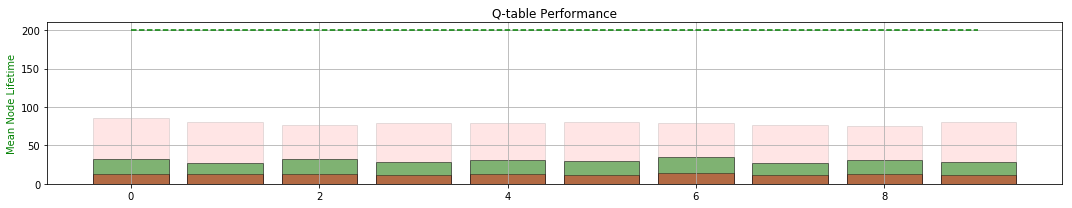

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.279	LOSS : 3.515	LOSS : 2.972	LOSS : 3.182	LOSS : 3.104	LOSS : 3.019	LOSS : 3.284	LOSS : 3.529	LOSS : 3.473	LOSS : 3.095	
Validating... MEAN TIME:  113.195
LOSS : 3.321	LOSS : 3.070	LOSS : 3.854	LOSS : 3.100	LOSS : 2.923	LOSS : 2.863	LOSS : 3.525	LOSS : 3.219	LOSS : 3.226	LOSS : 3.042	
Validating... MEAN TIME:  117.585
LOSS : 3.395	LOSS : 3.492	LOSS : 2.720	LOSS : 3.367	LOSS : 3.005	LOSS : 3.254	LOSS : 3.230	LOSS : 3.012	LOSS : 3.291	LOSS : 3.143	
Validating... MEAN TIME:  125.71
LOSS : 3.411	LOSS : 2.725	LOSS : 3.396	LOSS : 3.383	LOSS : 3.301	LOSS : 3.635	LOSS : 3.630	LOSS : 3.144	LOSS : 3.078	LOSS : 3.444	
Validating... MEAN TIME:  133.805
LOSS : 3.437	LOSS : 3.760	LOSS : 3.416	LOSS : 3.373	LOSS : 3.147	LOSS : 3.362	LOSS : 3.212	LOSS : 3.010	LOSS : 3.108	LOSS : 3.265	
Validating... MEAN TIME:  138.52
TRAINING TIME:0:00:29.173986


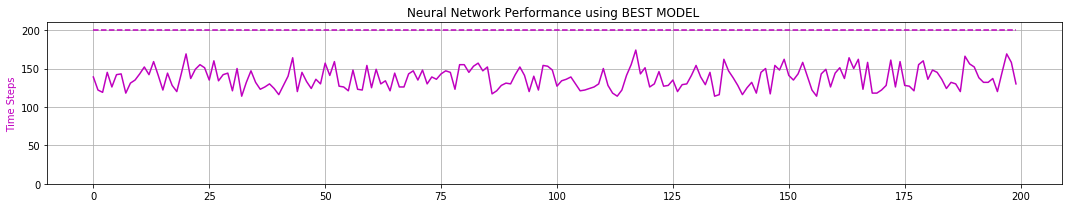

peak memory: 1411.86 MiB, increment: 996.41 MiB
0 -max- [ 0.194  1.018  0.050  0.607]
0 -min- [-1.437 -2.397 -0.209 -1.353]

1 -max- [ 0.181  1.036  0.049  0.386]
1 -min- [-1.541 -2.547 -0.209 -1.755]

2 -max- [ 0.199  0.643  0.050  0.591]
2 -min- [-1.407 -2.399 -0.209 -1.096]

3 -max- [ 0.213  0.829  0.051  0.381]
3 -min- [-1.096 -2.218 -0.209 -1.327]

4 -max- [ 0.199  0.643  0.050  0.594]
4 -min- [-1.279 -2.391 -0.209 -1.091]

5 -max- [ 0.193  0.829  0.049  0.391]
5 -min- [-1.437 -2.391 -0.209 -1.422]

6 -max- [ 0.190  0.642  0.050  0.729]
6 -min- [-1.166 -2.227 -0.209 -1.091]

7 -max- [ 0.199  0.832  0.047  0.388]
7 -min- [-1.094 -2.227 -0.209 -1.395]

8 -max- [ 0.188  0.642  0.046  0.599]
8 -min- [-1.255 -2.394 -0.209 -1.087]

9 -max- [ 0.196  0.832  0.050  0.384]
9 -min- [-1.347 -2.390 -0.209 -1.412]

Quantization TIME:  0.01 minutes


ITERATION # 84
SMALLEST TIMESTEP in ITERATION 84: 11
REAL TIME TO GENERATE 46083 EXPERIENCES:0:00:01.165716


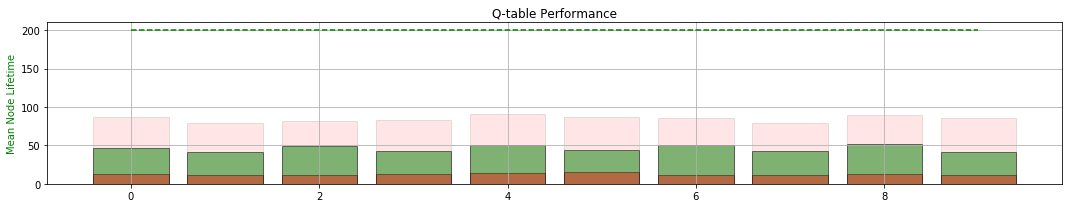

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.323	LOSS : 2.892	LOSS : 3.094	LOSS : 3.039	LOSS : 3.324	LOSS : 3.420	LOSS : 3.092	LOSS : 3.498	LOSS : 3.173	LOSS : 3.192	
Validating... MEAN TIME:  148.87
LOSS : 2.707	LOSS : 3.314	LOSS : 3.228	LOSS : 3.355	LOSS : 3.264	LOSS : 2.993	LOSS : 3.647	LOSS : 3.569	LOSS : 3.850	LOSS : 3.039	
Validating... MEAN TIME:  141.675
LOSS : 3.341	LOSS : 2.869	LOSS : 3.275	LOSS : 3.219	LOSS : 3.230	LOSS : 3.212	LOSS : 3.740	LOSS : 3.498	LOSS : 3.098	LOSS : 3.351	
Validating... MEAN TIME:  146.53
LOSS : 3.697	LOSS : 3.804	LOSS : 3.204	LOSS : 3.220	LOSS : 3.500	LOSS : 3.505	LOSS : 2.850	LOSS : 3.386	LOSS : 3.220	LOSS : 3.440	
Validating... MEAN TIME:  148.165
LOSS : 2.922	LOSS : 3.473	LOSS : 3.152	LOSS : 2.938	LOSS : 3.253	LOSS : 3.177	LOSS : 3.926	LOSS : 3.579	LOSS : 3.020	LOSS : 3.278	
Validating... MEAN TIME:  167.58
TRAINING TIME:0:00:33.063848


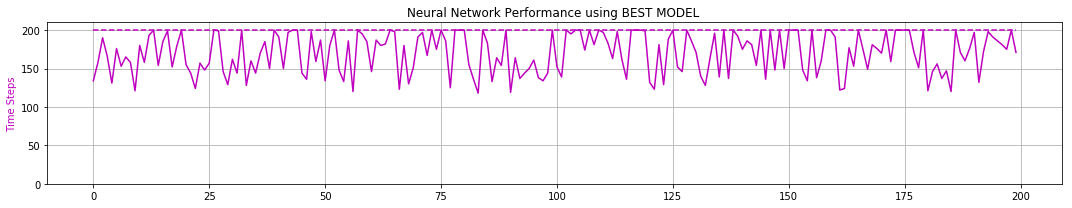

peak memory: 1394.18 MiB, increment: 1016.23 MiB
0 -max- [ 0.173  0.642  0.049  0.595]
0 -min- [-1.440 -2.420 -0.209 -1.091]

1 -max- [ 0.200  0.826  0.050  0.386]
1 -min- [-1.432 -2.384 -0.209 -1.307]

2 -max- [ 0.197  0.643  0.051  0.645]
2 -min- [-1.422 -2.405 -0.209 -1.096]

3 -max- [ 0.191  0.817  0.050  0.393]
3 -min- [-1.537 -2.546 -0.209 -1.318]

4 -max- [ 0.190  0.640  0.049  0.600]
4 -min- [-1.418 -2.393 -0.209 -1.097]

5 -max- [ 0.190  0.827  0.050  0.548]
5 -min- [-1.461 -2.419 -0.209 -1.298]

6 -max- [ 0.183  0.639  0.047  0.713]
6 -min- [-1.555 -2.548 -0.209 -1.096]

7 -max- [ 0.177  0.958  0.046  0.381]
7 -min- [-1.449 -2.391 -0.209 -1.594]

8 -max- [ 0.190  0.640  0.050  0.580]
8 -min- [-1.528 -2.422 -0.209 -1.099]

9 -max- [ 0.195  0.832  0.049  0.387]
9 -min- [-1.380 -2.397 -0.209 -1.415]

Quantization TIME:  0.01 minutes


ITERATION # 85
SMALLEST TIMESTEP in ITERATION 85: 12
REAL TIME TO GENERATE 57107 EXPERIENCES:0:00:01.463095


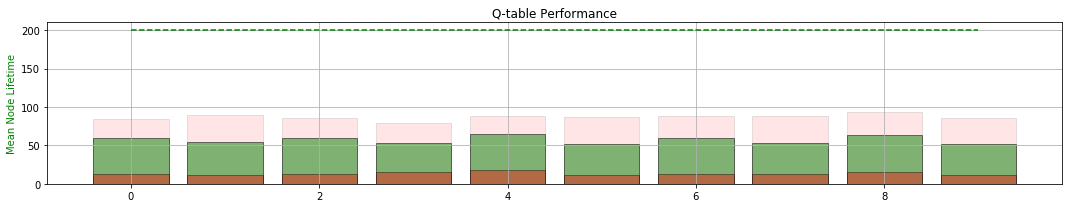

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.943	LOSS : 3.287	LOSS : 3.323	LOSS : 3.241	LOSS : 3.144	LOSS : 3.666	LOSS : 3.323	LOSS : 3.351	LOSS : 3.216	LOSS : 2.941	
Validating... MEAN TIME:  128.9
LOSS : 3.139	LOSS : 3.105	LOSS : 3.123	LOSS : 3.107	LOSS : 3.173	LOSS : 3.290	LOSS : 3.511	LOSS : 3.183	LOSS : 3.230	LOSS : 3.251	
Validating... MEAN TIME:  110.27
LOSS : 3.152	LOSS : 3.287	LOSS : 3.006	LOSS : 3.129	LOSS : 3.220	LOSS : 2.861	LOSS : 3.230	LOSS : 3.426	LOSS : 3.296	LOSS : 3.539	
Validating... MEAN TIME:  99.875
LOSS : 3.071	LOSS : 3.486	LOSS : 3.000	LOSS : 3.222	LOSS : 3.372	LOSS : 3.365	LOSS : 3.131	LOSS : 3.424	LOSS : 3.531	LOSS : 3.317	
Validating... MEAN TIME:  102.82
LOSS : 3.448	LOSS : 3.204	LOSS : 3.323	LOSS : 2.853	LOSS : 2.912	LOSS : 3.396	LOSS : 2.815	LOSS : 3.471	LOSS : 3.120	LOSS : 3.413	
Validating... MEAN TIME:  96.985
TRAINING TIME:0:00:25.162185


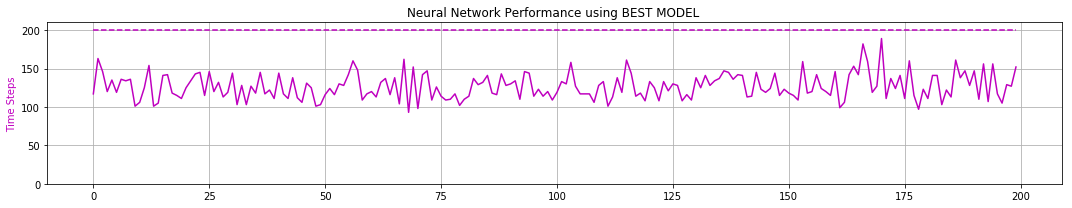

peak memory: 1388.26 MiB, increment: 971.12 MiB
0 -max- [ 0.185  0.638  0.050  0.601]
0 -min- [-1.445 -2.398 -0.209 -1.088]

1 -max- [ 0.210  0.822  0.051  0.609]
1 -min- [-1.684 -2.501 -0.209 -1.301]

2 -max- [ 0.176  0.640  0.050  0.591]
2 -min- [-1.615 -2.418 -0.209 -1.095]

3 -max- [ 0.190  0.820  0.049  0.597]
3 -min- [-1.431 -2.379 -0.209 -1.294]

4 -max- [ 0.170  0.923  0.050  0.764]
4 -min- [-1.687 -2.551 -0.209 -1.347]

5 -max- [ 0.187  1.014  0.047  0.532]
5 -min- [-1.584 -2.517 -0.209 -1.440]

6 -max- [ 0.164  0.642  0.046  0.837]
6 -min- [-1.764 -2.522 -0.209 -1.091]

7 -max- [ 0.199  0.825  0.050  0.392]
7 -min- [-1.440 -2.378 -0.209 -1.293]

8 -max- [ 0.193  0.949  0.049  0.601]
8 -min- [-1.687 -2.574 -0.209 -1.333]

9 -max- [ 0.184  0.813  0.049  0.391]
9 -min- [-1.350 -2.416 -0.209 -1.409]

Quantization TIME:  0.01 minutes


ITERATION # 86
SMALLEST TIMESTEP in ITERATION 86: 11
REAL TIME TO GENERATE 37779 EXPERIENCES:0:00:01.021124


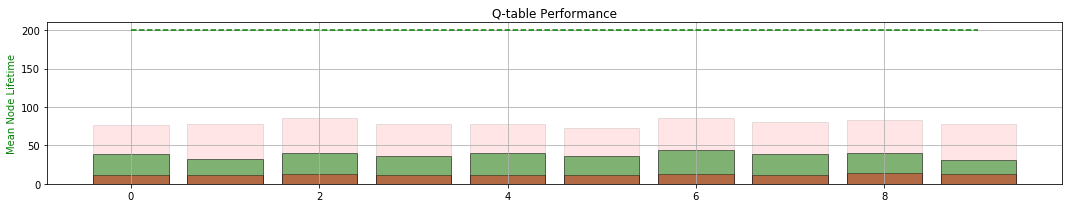

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.065	LOSS : 3.294	LOSS : 2.944	LOSS : 3.232	LOSS : 3.340	LOSS : 3.557	LOSS : 3.103	LOSS : 2.754	LOSS : 3.119	LOSS : 3.433	
Validating... MEAN TIME:  96.81
LOSS : 3.262	LOSS : 3.236	LOSS : 3.525	LOSS : 3.208	LOSS : 2.829	LOSS : 3.169	LOSS : 3.021	LOSS : 3.394	LOSS : 3.067	LOSS : 3.062	
Validating... MEAN TIME:  93.785
LOSS : 3.023	LOSS : 2.787	LOSS : 2.853	LOSS : 3.080	LOSS : 3.039	LOSS : 3.009	LOSS : 2.908	LOSS : 3.142	LOSS : 3.049	LOSS : 3.413	
Validating... MEAN TIME:  90.04
LOSS : 3.294	LOSS : 3.304	LOSS : 3.566	LOSS : 2.989	LOSS : 2.992	LOSS : 2.982	LOSS : 3.503	LOSS : 2.743	LOSS : 3.064	LOSS : 2.986	
Validating... MEAN TIME:  91.82
LOSS : 2.794	LOSS : 2.779	LOSS : 3.466	LOSS : 3.099	LOSS : 3.443	LOSS : 3.089	LOSS : 3.089	LOSS : 3.349	LOSS : 3.210	LOSS : 3.445	
Validating... MEAN TIME:  92.705
TRAINING TIME:0:00:23.422811


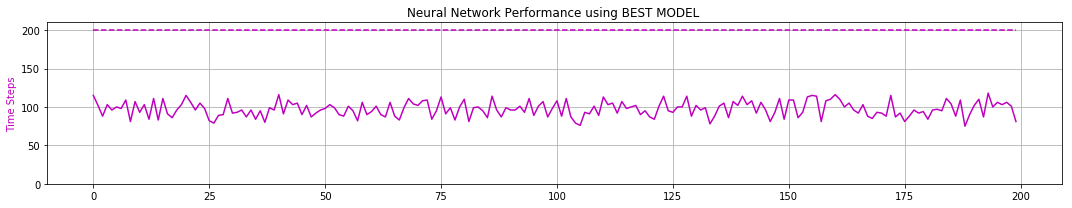

peak memory: 1396.31 MiB, increment: 995.93 MiB
0 -max- [ 0.213  0.643  0.051  0.576]
0 -min- [-1.211 -2.229 -0.209 -1.101]

1 -max- [ 0.199  0.960  0.050  0.390]
1 -min- [-1.225 -2.222 -0.209 -1.728]

2 -max- [ 0.193  0.642  0.049  0.600]
2 -min- [-1.158 -2.216 -0.209 -1.093]

3 -max- [ 0.190  0.959  0.050  0.391]
3 -min- [-1.080 -2.227 -0.209 -1.551]

4 -max- [ 0.199  0.642  0.048  0.587]
4 -min- [-1.311 -2.223 -0.209 -1.101]

5 -max- [ 0.188  0.829  0.046  0.390]
5 -min- [-1.130 -2.179 -0.209 -1.402]

6 -max- [ 0.195  1.005  0.053  0.618]
6 -min- [-1.411 -2.396 -0.209 -1.339]

7 -max- [ 0.202  0.958  0.049  0.389]
7 -min- [-1.235 -2.217 -0.209 -1.437]

8 -max- [ 0.200  0.640  0.049  0.603]
8 -min- [-1.396 -2.357 -0.209 -1.101]

9 -max- [ 0.212  0.834  0.050  0.388]
9 -min- [-1.199 -2.199 -0.209 -1.362]

Quantization TIME:  0.01 minutes


ITERATION # 87
SMALLEST TIMESTEP in ITERATION 87: 11
REAL TIME TO GENERATE 27040 EXPERIENCES:0:00:00.786591


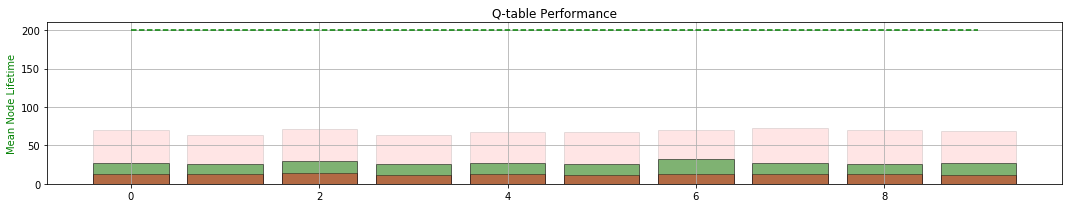

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.778	LOSS : 3.268	LOSS : 2.838	LOSS : 3.111	LOSS : 3.314	LOSS : 3.029	LOSS : 3.311	LOSS : 3.237	LOSS : 3.439	LOSS : 3.012	
Validating... MEAN TIME:  90.33
LOSS : 2.939	LOSS : 2.914	LOSS : 3.193	LOSS : 3.067	LOSS : 2.907	LOSS : 3.079	LOSS : 3.305	LOSS : 3.099	LOSS : 3.251	LOSS : 3.266	
Validating... MEAN TIME:  89.96
LOSS : 2.926	LOSS : 2.884	LOSS : 3.108	LOSS : 3.165	LOSS : 3.434	LOSS : 3.159	LOSS : 2.784	LOSS : 3.006	LOSS : 3.200	LOSS : 3.068	
Validating... MEAN TIME:  94.425
LOSS : 3.021	LOSS : 2.914	LOSS : 2.976	LOSS : 2.946	LOSS : 2.863	LOSS : 2.881	LOSS : 2.570	LOSS : 2.653	LOSS : 2.959	LOSS : 3.263	
Validating... MEAN TIME:  94.415
LOSS : 2.884	LOSS : 2.839	LOSS : 2.902	LOSS : 2.864	LOSS : 2.760	LOSS : 3.134	LOSS : 3.203	LOSS : 3.147	LOSS : 3.038	LOSS : 2.644	
Validating... MEAN TIME:  96.06
TRAINING TIME:0:00:23.423309


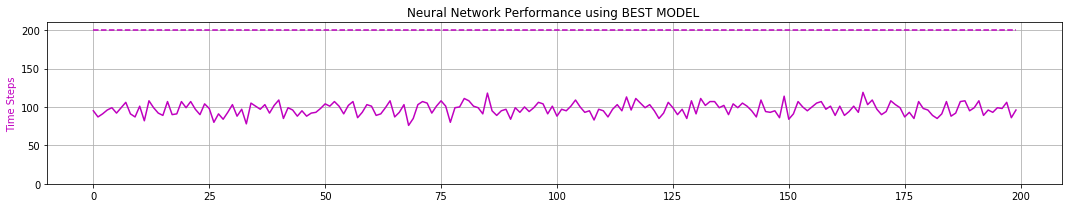

peak memory: 1449.64 MiB, increment: 1063.52 MiB
0 -max- [ 0.186  1.213  0.050  0.723]
0 -min- [-0.959 -2.144 -0.209 -1.656]

1 -max- [ 0.193  0.819  0.049  0.381]
1 -min- [-0.746 -1.838 -0.209 -1.343]

2 -max- [ 0.190  0.813  0.050  0.610]
2 -min- [-0.925 -1.964 -0.209 -1.131]

3 -max- [ 0.195  0.829  0.047  0.380]
3 -min- [-0.825 -1.988 -0.209 -1.351]

4 -max- [ 0.180  0.642  0.046  0.556]
4 -min- [-0.831 -1.877 -0.209 -1.094]

5 -max- [ 0.196  0.963  0.050  0.381]
5 -min- [-0.822 -2.028 -0.209 -1.554]

6 -max- [ 0.203  0.786  0.049  0.616]
6 -min- [-1.210 -2.245 -0.209 -1.098]

7 -max- [ 0.194  0.831  0.049  0.381]
7 -min- [-1.021 -2.160 -0.209 -1.329]

8 -max- [ 0.217  1.120  0.053  0.580]
8 -min- [-0.964 -2.004 -0.209 -1.652]

9 -max- [ 0.188  0.829  0.048  0.385]
9 -min- [-0.806 -1.866 -0.209 -1.397]

Quantization TIME:  0.01 minutes


ITERATION # 88
SMALLEST TIMESTEP in ITERATION 88: 11
REAL TIME TO GENERATE 30920 EXPERIENCES:0:00:00.832162


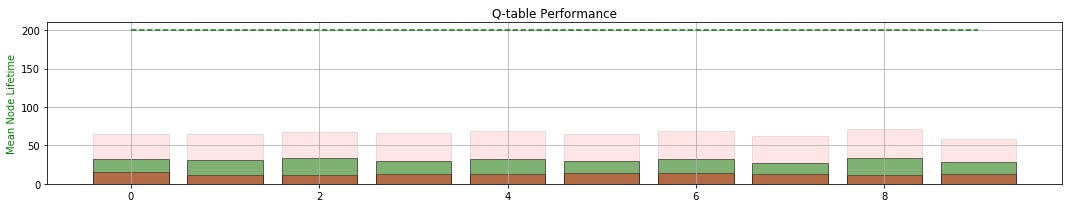

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.114	LOSS : 3.116	LOSS : 2.871	LOSS : 3.457	LOSS : 2.807	LOSS : 2.957	LOSS : 3.045	LOSS : 2.861	LOSS : 3.170	LOSS : 3.033	
Validating... MEAN TIME:  94.41
LOSS : 2.910	LOSS : 2.979	LOSS : 2.904	LOSS : 2.735	LOSS : 2.910	LOSS : 3.043	LOSS : 2.861	LOSS : 3.104	LOSS : 3.218	LOSS : 3.449	
Validating... MEAN TIME:  94.16
LOSS : 2.784	LOSS : 2.993	LOSS : 3.040	LOSS : 3.004	LOSS : 3.116	LOSS : 3.057	LOSS : 3.015	LOSS : 3.378	LOSS : 3.361	LOSS : 3.006	
Validating... MEAN TIME:  93.695
LOSS : 3.052	LOSS : 2.798	LOSS : 2.835	LOSS : 2.749	LOSS : 2.886	LOSS : 3.241	LOSS : 3.114	LOSS : 3.111	LOSS : 3.027	LOSS : 3.100	
Validating... MEAN TIME:  94.125
LOSS : 3.092	LOSS : 2.949	LOSS : 3.184	LOSS : 2.868	LOSS : 3.357	LOSS : 3.233	LOSS : 3.131	LOSS : 3.043	LOSS : 3.147	LOSS : 3.297	
Validating... MEAN TIME:  96.09
TRAINING TIME:0:00:23.296227


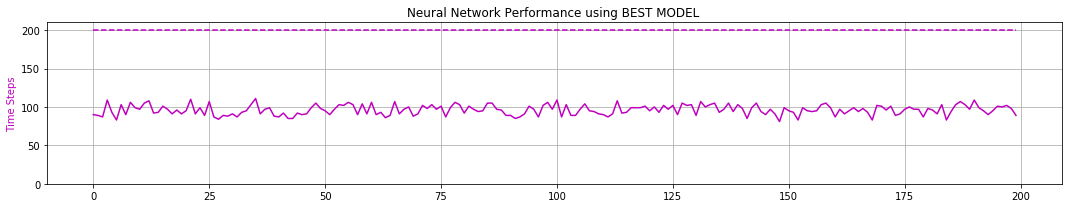

peak memory: 1460.66 MiB, increment: 1026.48 MiB
0 -max- [ 0.178  0.640  0.049  0.513]
0 -min- [-0.670 -1.853 -0.209 -1.090]

1 -max- [ 0.184  0.973  0.050  0.377]
1 -min- [-0.636 -1.807 -0.209 -1.721]

2 -max- [ 0.187  0.639  0.047  0.660]
2 -min- [-0.876 -1.997 -0.209 -1.096]

3 -max- [ 0.172  0.826  0.046  0.377]
3 -min- [-0.752 -1.985 -0.209 -1.260]

4 -max- [ 0.194  0.640  0.050  0.555]
4 -min- [-0.862 -1.989 -0.209 -1.094]

5 -max- [ 0.195  0.804  0.049  0.381]
5 -min- [-0.565 -1.679 -0.209 -1.198]

6 -max- [ 0.191  0.794  0.049  0.627]
6 -min- [-0.777 -2.010 -0.209 -1.101]

7 -max- [ 0.196  1.009  0.050  0.380]
7 -min- [-0.649 -1.863 -0.209 -1.569]

8 -max- [ 0.180  0.642  0.048  0.609]
8 -min- [-0.798 -2.025 -0.209 -1.091]

9 -max- [ 0.194  0.934  0.050  0.382]
9 -min- [-0.596 -1.805 -0.209 -1.410]

Quantization TIME:  0.01 minutes


ITERATION # 89
SMALLEST TIMESTEP in ITERATION 89: 11
REAL TIME TO GENERATE 31734 EXPERIENCES:0:00:00.814906


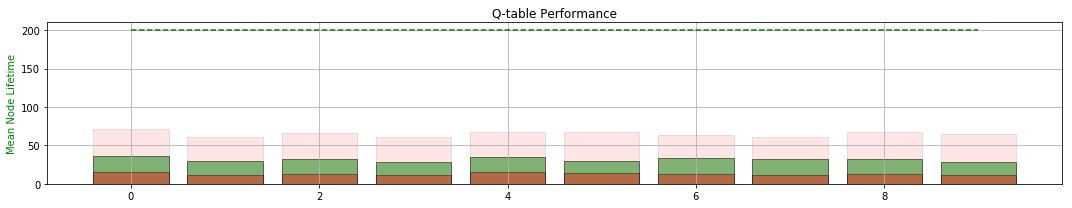

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.142	LOSS : 3.082	LOSS : 2.780	LOSS : 2.689	LOSS : 3.007	LOSS : 3.002	LOSS : 2.603	LOSS : 2.917	LOSS : 2.784	LOSS : 2.947	
Validating... MEAN TIME:  93.7
LOSS : 2.997	LOSS : 2.799	LOSS : 2.618	LOSS : 3.039	LOSS : 3.060	LOSS : 2.621	LOSS : 2.656	LOSS : 2.881	LOSS : 2.909	LOSS : 2.860	
Validating... MEAN TIME:  94.62
LOSS : 2.987	LOSS : 2.780	LOSS : 2.819	LOSS : 3.060	LOSS : 2.798	LOSS : 2.831	LOSS : 2.889	LOSS : 2.613	LOSS : 3.157	LOSS : 3.004	
Validating... MEAN TIME:  91.71
LOSS : 2.797	LOSS : 2.850	LOSS : 3.153	LOSS : 3.305	LOSS : 3.079	LOSS : 2.925	LOSS : 2.836	LOSS : 2.921	LOSS : 3.253	LOSS : 2.950	
Validating... MEAN TIME:  94.42
LOSS : 3.149	LOSS : 2.935	LOSS : 2.876	LOSS : 3.107	LOSS : 2.977	LOSS : 2.632	LOSS : 2.795	LOSS : 2.660	LOSS : 3.091	LOSS : 3.248	
Validating... MEAN TIME:  96.55
TRAINING TIME:0:00:22.687122


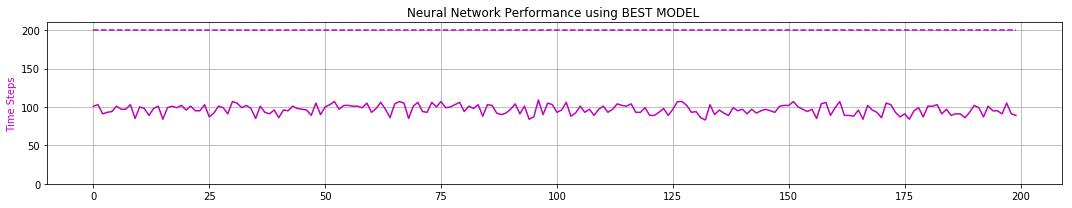

peak memory: 1383.32 MiB, increment: 1016.74 MiB
0 -max- [ 0.177  0.644  0.052  0.577]
0 -min- [-0.877 -2.002 -0.209 -1.095]

1 -max- [ 0.192  0.948  0.047  0.380]
1 -min- [-0.610 -1.834 -0.209 -1.522]

2 -max- [ 0.177  0.642  0.046  0.522]
2 -min- [-0.719 -1.862 -0.209 -1.091]

3 -max- [ 0.184  0.833  0.050  0.376]
3 -min- [-0.569 -1.691 -0.209 -1.372]

4 -max- [ 0.187  0.638  0.049  0.544]
4 -min- [-0.747 -1.984 -0.209 -1.098]

5 -max- [ 0.192  0.812  0.049  0.381]
5 -min- [-0.619 -1.664 -0.209 -1.296]

6 -max- [ 0.196  0.941  0.052  0.783]
6 -min- [-0.660 -1.860 -0.209 -1.376]

7 -max- [ 0.180  0.830  0.048  0.383]
7 -min- [-0.598 -1.842 -0.209 -1.282]

8 -max- [ 0.198  0.642  0.054  0.554]
8 -min- [-0.763 -1.987 -0.209 -1.098]

9 -max- [ 0.183  1.211  0.050  0.380]
9 -min- [-0.611 -1.824 -0.209 -1.730]

Quantization TIME:  0.01 minutes


ITERATION # 90
SMALLEST TIMESTEP in ITERATION 90: 11
REAL TIME TO GENERATE 28339 EXPERIENCES:0:00:00.796096


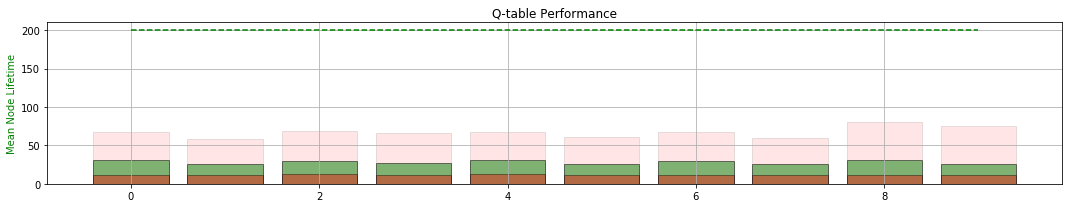

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.126	LOSS : 2.947	LOSS : 2.902	LOSS : 3.131	LOSS : 2.944	LOSS : 3.018	LOSS : 2.523	LOSS : 2.663	LOSS : 2.650	LOSS : 2.678	
Validating... MEAN TIME:  98.23
LOSS : 2.832	LOSS : 2.924	LOSS : 2.857	LOSS : 2.908	LOSS : 3.170	LOSS : 2.754	LOSS : 2.901	LOSS : 2.683	LOSS : 2.625	LOSS : 3.032	
Validating... MEAN TIME:  93.395
LOSS : 3.228	LOSS : 2.922	LOSS : 3.333	LOSS : 2.772	LOSS : 2.640	LOSS : 2.979	LOSS : 3.330	LOSS : 2.844	LOSS : 2.641	LOSS : 3.184	
Validating... MEAN TIME:  96.53
LOSS : 3.281	LOSS : 3.116	LOSS : 2.955	LOSS : 2.818	LOSS : 3.129	LOSS : 2.918	LOSS : 2.796	LOSS : 2.720	LOSS : 2.604	LOSS : 2.996	
Validating... MEAN TIME:  101.78
LOSS : 2.799	LOSS : 3.230	LOSS : 3.167	LOSS : 2.905	LOSS : 2.769	LOSS : 2.569	LOSS : 2.725	LOSS : 3.287	LOSS : 2.609	LOSS : 2.597	
Validating... MEAN TIME:  100.39
TRAINING TIME:0:00:24.143759


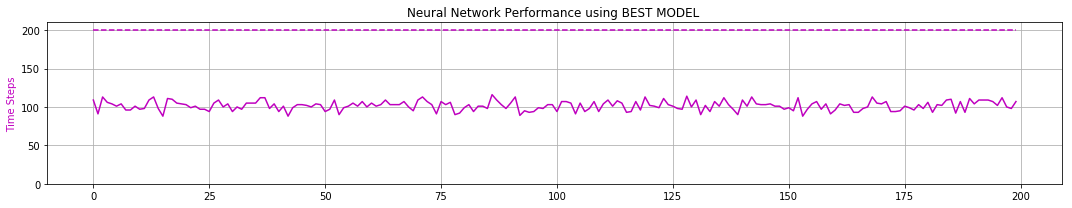

peak memory: 1459.65 MiB, increment: 1044.79 MiB
0 -max- [ 0.187  1.020  0.048  0.509]
0 -min- [-0.965 -2.181 -0.209 -1.368]

1 -max- [ 0.172  0.817  0.046  0.377]
1 -min- [-0.603 -1.827 -0.209 -1.364]

2 -max- [ 0.188  0.640  0.050  0.593]
2 -min- [-0.846 -2.051 -0.209 -1.099]

3 -max- [ 0.195  0.810  0.049  0.383]
3 -min- [-0.764 -1.995 -0.209 -1.339]

4 -max- [ 0.199  0.638  0.049  0.730]
4 -min- [-1.130 -2.332 -0.209 -1.101]

5 -max- [ 0.196  0.835  0.050  0.378]
5 -min- [-0.648 -1.860 -0.209 -1.359]

6 -max- [ 0.180  0.642  0.048  0.429]
6 -min- [-0.633 -1.860 -0.209 -1.078]

7 -max- [ 0.194  0.819  0.050  0.380]
7 -min- [-0.610 -1.807 -0.209 -1.428]

8 -max- [ 0.189  0.641  0.050  0.585]
8 -min- [-1.312 -2.347 -0.209 -1.094]

9 -max- [ 0.198  1.003  0.050  0.378]
9 -min- [-1.046 -2.347 -0.209 -1.387]

Quantization TIME:  0.01 minutes


ITERATION # 91
SMALLEST TIMESTEP in ITERATION 91: 12
REAL TIME TO GENERATE 32489 EXPERIENCES:0:00:00.807468


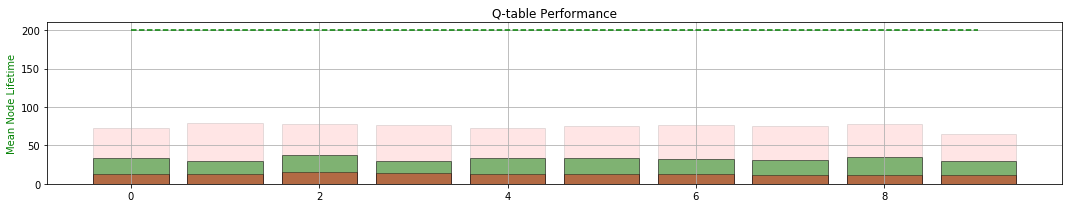

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.804	LOSS : 3.027	LOSS : 2.662	LOSS : 2.915	LOSS : 2.389	LOSS : 2.936	LOSS : 2.571	LOSS : 3.071	LOSS : 3.191	LOSS : 2.940	
Validating... MEAN TIME:  98.565
LOSS : 2.707	LOSS : 3.054	LOSS : 2.487	LOSS : 3.199	LOSS : 3.234	LOSS : 2.697	LOSS : 2.790	LOSS : 2.596	LOSS : 2.913	LOSS : 2.666	
Validating... MEAN TIME:  101.045
LOSS : 2.751	LOSS : 3.417	LOSS : 3.335	LOSS : 3.148	LOSS : 2.766	LOSS : 2.423	LOSS : 2.922	LOSS : 2.416	LOSS : 3.270	LOSS : 2.793	
Validating... MEAN TIME:  100.545
LOSS : 2.292	LOSS : 2.498	LOSS : 3.220	LOSS : 2.661	LOSS : 2.740	LOSS : 2.991	LOSS : 2.905	LOSS : 2.930	LOSS : 3.051	LOSS : 2.954	
Validating... MEAN TIME:  99.41
LOSS : 2.797	LOSS : 2.898	LOSS : 2.409	LOSS : 2.184	LOSS : 2.699	LOSS : 3.020	LOSS : 2.538	LOSS : 2.694	LOSS : 2.804	LOSS : 2.726	
Validating... MEAN TIME:  99.3
TRAINING TIME:0:00:24.603629


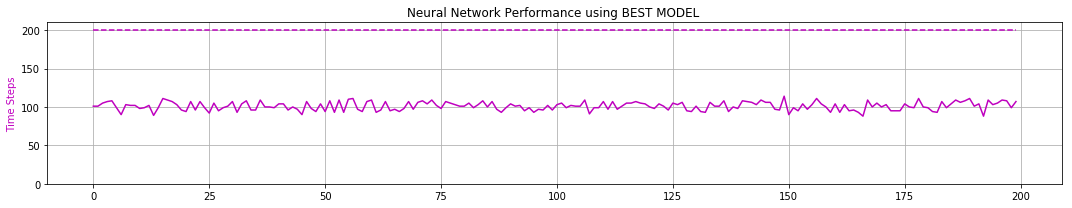

peak memory: 1361.14 MiB, increment: 975.22 MiB
0 -max- [ 0.164  0.642  0.046  0.603]
0 -min- [-1.074 -2.166 -0.209 -1.091]

1 -max- [ 0.196  0.828  0.050  0.382]
1 -min- [-1.271 -2.410 -0.209 -1.421]

2 -max- [ 0.187  0.638  0.049  0.611]
2 -min- [-1.135 -2.352 -0.209 -1.098]

3 -max- [ 0.192  0.802  0.049  0.381]
3 -min- [-1.108 -2.180 -0.209 -1.390]

4 -max- [ 0.207  0.642  0.053  0.595]
4 -min- [-1.123 -2.172 -0.209 -1.095]

5 -max- [ 0.175  0.947  0.048  0.382]
5 -min- [-1.099 -2.153 -0.209 -1.493]

6 -max- [ 0.186  0.639  0.050  0.587]
6 -min- [-1.160 -2.353 -0.209 -1.096]

7 -max- [ 0.181  1.016  0.050  0.378]
7 -min- [-1.290 -2.376 -0.209 -1.441]

8 -max- [ 0.204  1.003  0.050  0.605]
8 -min- [-1.156 -2.204 -0.209 -1.368]

9 -max- [ 0.176  0.837  0.048  0.386]
9 -min- [-0.718 -1.835 -0.209 -1.431]

Quantization TIME:  0.01 minutes


ITERATION # 92
SMALLEST TIMESTEP in ITERATION 92: 11
REAL TIME TO GENERATE 28788 EXPERIENCES:0:00:00.788257


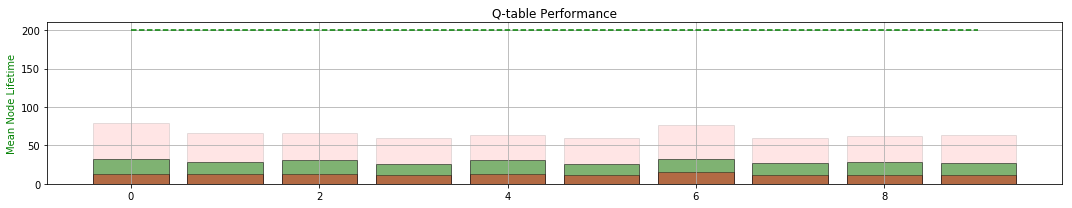

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.903	LOSS : 2.807	LOSS : 2.728	LOSS : 2.888	LOSS : 2.843	LOSS : 2.967	LOSS : 2.723	LOSS : 2.833	LOSS : 2.695	LOSS : 2.690	
Validating... MEAN TIME:  101.345
LOSS : 2.977	LOSS : 2.960	LOSS : 2.718	LOSS : 2.822	LOSS : 2.961	LOSS : 2.850	LOSS : 3.255	LOSS : 2.818	LOSS : 2.662	LOSS : 2.534	
Validating... MEAN TIME:  111.03
LOSS : 2.994	LOSS : 2.740	LOSS : 2.868	LOSS : 2.885	LOSS : 2.734	LOSS : 2.891	LOSS : 3.307	LOSS : 3.561	LOSS : 2.969	LOSS : 2.557	
Validating... MEAN TIME:  112.435
LOSS : 2.812	LOSS : 2.817	LOSS : 2.907	LOSS : 3.102	LOSS : 2.700	LOSS : 3.121	LOSS : 2.847	LOSS : 2.707	LOSS : 2.702	LOSS : 2.895	
Validating... MEAN TIME:  102.15
LOSS : 2.791	LOSS : 3.126	LOSS : 3.104	LOSS : 2.951	LOSS : 2.904	LOSS : 2.917	LOSS : 3.151	LOSS : 3.114	LOSS : 2.772	LOSS : 3.049	
Validating... MEAN TIME:  114.745
TRAINING TIME:0:00:25.677905


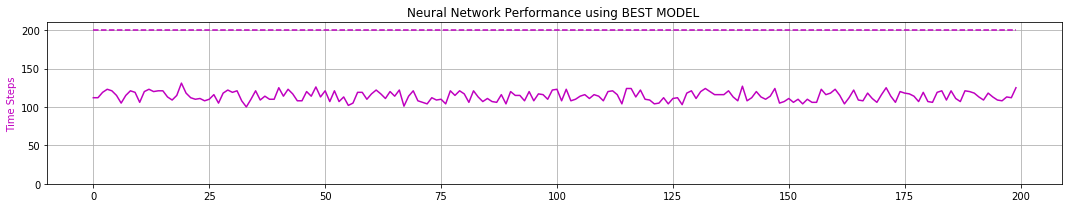

peak memory: 1400.68 MiB, increment: 1014.69 MiB
0 -max- [ 0.186  0.992  0.052  0.587]
0 -min- [-1.315 -2.388 -0.209 -1.334]

1 -max- [ 0.187  0.827  0.049  0.383]
1 -min- [-0.584 -1.818 -0.209 -1.389]

2 -max- [ 0.189  0.638  0.049  0.596]
2 -min- [-0.872 -1.877 -0.209 -1.101]

3 -max- [ 0.196  0.830  0.050  0.378]
3 -min- [-0.592 -1.680 -0.209 -1.395]

4 -max- [ 0.180  0.642  0.048  0.586]
4 -min- [-0.656 -1.863 -0.209 -1.091]

5 -max- [ 0.194  0.932  0.050  0.380]
5 -min- [-0.568 -1.678 -0.209 -1.380]

6 -max- [ 0.189  0.638  0.050  0.568]
6 -min- [-1.237 -2.345 -0.209 -1.094]

7 -max- [ 0.204  1.003  0.050  0.377]
7 -min- [-0.586 -1.669 -0.209 -1.387]

8 -max- [ 0.182  0.640  0.048  0.574]
8 -min- [-0.776 -2.001 -0.209 -1.101]

9 -max- [ 0.204  0.926  0.049  0.383]
9 -min- [-0.604 -1.820 -0.209 -1.485]

Quantization TIME:  0.01 minutes


ITERATION # 93
SMALLEST TIMESTEP in ITERATION 93: 10
REAL TIME TO GENERATE 38870 EXPERIENCES:0:00:01.021701


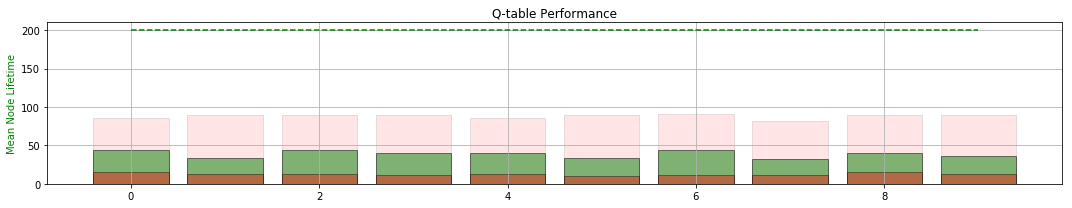

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.853	LOSS : 2.934	LOSS : 2.889	LOSS : 3.066	LOSS : 2.927	LOSS : 3.006	LOSS : 3.230	LOSS : 2.726	LOSS : 2.890	LOSS : 3.361	
Validating... MEAN TIME:  113.89
LOSS : 2.960	LOSS : 2.752	LOSS : 3.109	LOSS : 3.055	LOSS : 2.905	LOSS : 3.254	LOSS : 2.947	LOSS : 3.201	LOSS : 2.650	LOSS : 2.960	
Validating... MEAN TIME:  121.31
LOSS : 2.820	LOSS : 3.166	LOSS : 2.961	LOSS : 3.172	LOSS : 2.651	LOSS : 3.437	LOSS : 3.420	LOSS : 3.337	LOSS : 2.776	LOSS : 3.047	
Validating... MEAN TIME:  127.28
LOSS : 3.321	LOSS : 3.061	LOSS : 2.881	LOSS : 3.379	LOSS : 2.929	LOSS : 3.041	LOSS : 3.491	LOSS : 2.824	LOSS : 2.682	LOSS : 3.148	
Validating... MEAN TIME:  134.96
LOSS : 3.090	LOSS : 3.392	LOSS : 3.232	LOSS : 2.683	LOSS : 2.939	LOSS : 2.864	LOSS : 2.676	LOSS : 3.160	LOSS : 2.819	LOSS : 3.085	
Validating... MEAN TIME:  133.405
TRAINING TIME:0:00:28.003897


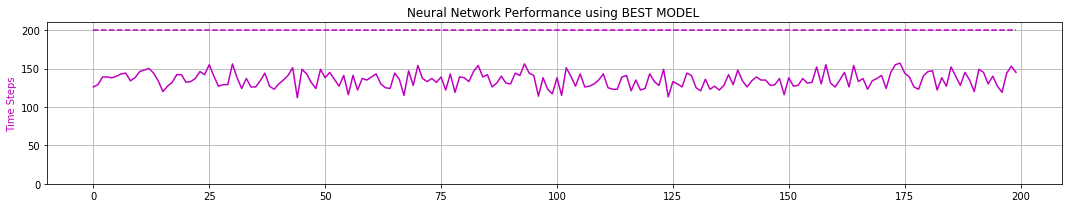

peak memory: 1418.59 MiB, increment: 1017.18 MiB
0 -max- [ 0.187  0.639  0.049  0.597]
0 -min- [-1.680 -2.752 -0.209 -1.098]

1 -max- [ 0.204  0.826  0.049  0.385]
1 -min- [-1.653 -2.594 -0.209 -1.415]

2 -max- [ 0.196  0.643  0.050  0.595]
2 -min- [-1.883 -2.889 -0.209 -1.097]

3 -max- [ 0.179  0.821  0.048  0.390]
3 -min- [-1.728 -2.746 -0.209 -1.389]

4 -max- [ 0.186  0.639  0.050  0.582]
4 -min- [-1.673 -2.732 -0.209 -1.096]

5 -max- [ 0.184  0.976  0.050  0.387]
5 -min- [-1.681 -2.754 -0.209 -1.567]

6 -max- [ 0.204  1.003  0.050  0.595]
6 -min- [-1.765 -2.704 -0.209 -1.368]

7 -max- [ 0.198  0.831  0.048  0.386]
7 -min- [-1.619 -2.719 -0.209 -1.274]

8 -max- [ 0.209  0.638  0.049  0.614]
8 -min- [-1.954 -2.939 -0.209 -1.075]

9 -max- [ 0.167  0.827  0.048  0.386]
9 -min- [-1.819 -2.756 -0.209 -1.270]

Quantization TIME:  0.01 minutes


ITERATION # 94
SMALLEST TIMESTEP in ITERATION 94: 11
REAL TIME TO GENERATE 60560 EXPERIENCES:0:00:01.712001


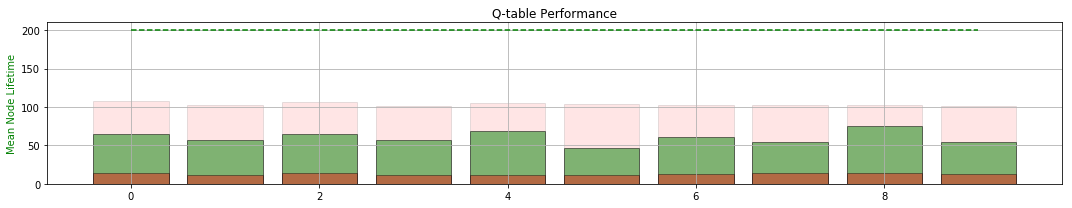

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.045	LOSS : 3.338	LOSS : 3.035	LOSS : 2.522	LOSS : 3.074	LOSS : 3.198	LOSS : 3.026	LOSS : 3.387	LOSS : 2.923	LOSS : 2.994	
Validating... MEAN TIME:  178.98
LOSS : 2.887	LOSS : 2.850	LOSS : 2.744	LOSS : 2.888	LOSS : 2.659	LOSS : 2.364	LOSS : 2.630	LOSS : 2.867	LOSS : 3.512	LOSS : 2.927	
Validating... MEAN TIME:  169.77
LOSS : 2.706	LOSS : 2.889	LOSS : 3.329	LOSS : 2.809	LOSS : 2.777	LOSS : 3.219	LOSS : 2.794	LOSS : 3.168	LOSS : 2.988	LOSS : 2.938	
Validating... MEAN TIME:  179.425
LOSS : 2.794	LOSS : 3.024	LOSS : 2.798	LOSS : 3.080	LOSS : 3.152	LOSS : 3.030	LOSS : 2.743	LOSS : 3.048	LOSS : 2.790	LOSS : 2.935	
Validating... MEAN TIME:  194.095
LOSS : 2.495	LOSS : 2.800	LOSS : 3.172	LOSS : 3.070	LOSS : 2.731	LOSS : 2.703	LOSS : 2.999	LOSS : 3.277	LOSS : 2.879	LOSS : 2.836	
Validating... MEAN TIME:  183.98
TRAINING TIME:0:00:39.262435


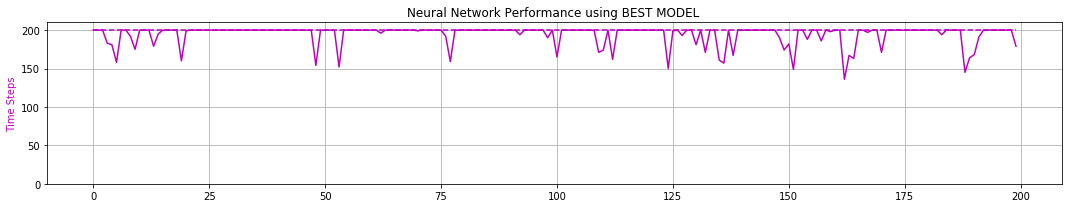

peak memory: 1368.23 MiB, increment: 994.09 MiB
0 -max- [ 0.196  0.793  0.049  0.801]
0 -min- [-2.400 -3.517 -0.209 -1.101]

1 -max- [ 0.188  0.812  0.050  0.695]
1 -min- [-2.399 -3.480 -0.209 -1.365]

2 -max- [ 0.186  0.642  0.048  0.804]
2 -min- [-2.400 -3.496 -0.209 -1.092]

3 -max- [ 0.194  0.800  0.050  0.698]
3 -min- [-2.397 -3.461 -0.209 -1.276]

4 -max- [ 0.186  0.638  0.050  0.893]
4 -min- [-2.399 -3.536 -0.209 -1.096]

5 -max- [ 0.200  1.003  0.050  0.709]
5 -min- [-2.399 -3.491 -0.209 -1.368]

6 -max- [ 0.176  0.640  0.048  0.848]
6 -min- [-2.398 -3.509 -0.209 -1.095]

7 -max- [ 0.201  0.813  0.049  0.699]
7 -min- [-2.392 -3.509 -0.209 -1.232]

8 -max- [ 0.169  0.639  0.048  0.677]
8 -min- [-2.399 -3.449 -0.209 -1.099]

9 -max- [ 0.177  0.813  0.049  0.649]
9 -min- [-2.399 -3.464 -0.209 -1.292]

Quantization TIME:  0.01 minutes


ITERATION # 95
SMALLEST TIMESTEP in ITERATION 95: 12
REAL TIME TO GENERATE 78650 EXPERIENCES:0:00:01.922806


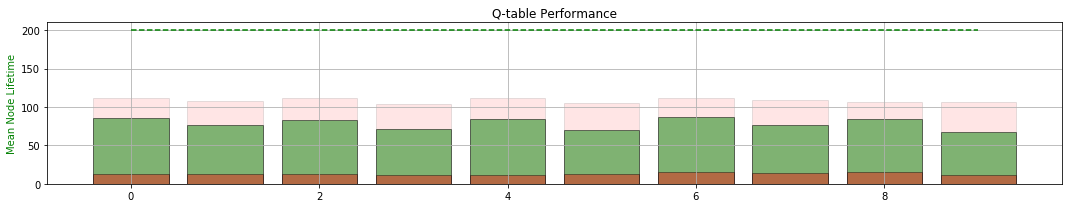

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 3.150	LOSS : 2.437	LOSS : 2.447	LOSS : 2.742	LOSS : 2.735	LOSS : 2.815	LOSS : 2.375	LOSS : 2.614	LOSS : 2.410	LOSS : 2.814	
Validating... MEAN TIME:  119.655
LOSS : 2.721	LOSS : 3.117	LOSS : 2.751	LOSS : 2.498	LOSS : 2.722	LOSS : 2.608	LOSS : 2.882	LOSS : 2.296	LOSS : 2.795	LOSS : 2.408	
Validating... MEAN TIME:  114.0
LOSS : 2.464	LOSS : 2.698	LOSS : 2.502	LOSS : 2.903	LOSS : 2.693	LOSS : 2.708	LOSS : 2.551	LOSS : 2.598	LOSS : 2.680	LOSS : 2.612	
Validating... MEAN TIME:  108.48
LOSS : 2.409	LOSS : 2.855	LOSS : 2.454	LOSS : 2.287	LOSS : 2.485	LOSS : 2.232	LOSS : 2.268	LOSS : 2.479	LOSS : 2.378	LOSS : 2.484	
Validating... MEAN TIME:  110.365
LOSS : 2.458	LOSS : 2.679	LOSS : 2.665	LOSS : 2.359	LOSS : 2.145	LOSS : 2.364	LOSS : 2.566	LOSS : 2.224	LOSS : 2.830	LOSS : 2.693	
Validating... MEAN TIME:  112.075
TRAINING TIME:0:00:26.536821


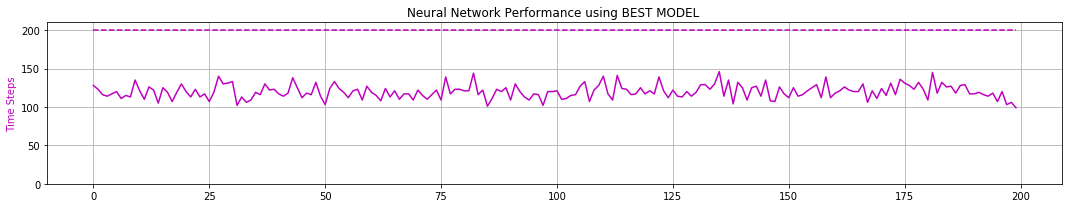

peak memory: 1422.48 MiB, increment: 999.38 MiB
0 -max- [ 0.180  0.642  0.050  0.932]
0 -min- [-2.399 -3.336 -0.209 -1.095]

1 -max- [ 0.186  0.820  0.048  0.715]
1 -min- [-2.399 -3.346 -0.209 -1.294]

2 -max- [ 0.180  0.639  0.050  0.954]
2 -min- [-2.399 -3.349 -0.209 -1.096]

3 -max- [ 0.181  0.812  0.050  0.715]
3 -min- [-2.398 -3.323 -0.209 -1.294]

4 -max- [ 0.193  1.003  0.050  0.920]
4 -min- [-2.400 -3.345 -0.209 -1.368]

5 -max- [ 0.192  0.822  0.048  0.710]
5 -min- [-2.398 -3.329 -0.209 -1.352]

6 -max- [ 0.193  1.008  0.049  0.961]
6 -min- [-2.399 -3.331 -0.209 -1.337]

7 -max- [ 0.177  0.828  0.048  0.728]
7 -min- [-2.400 -3.334 -0.209 -1.281]

8 -max- [ 0.174  0.634  0.049  0.993]
8 -min- [-2.399 -3.331 -0.209 -1.080]

9 -max- [ 0.185  0.992  0.050  0.731]
9 -min- [-2.400 -3.317 -0.209 -1.575]

Quantization TIME:  0.01 minutes


ITERATION # 96
SMALLEST TIMESTEP in ITERATION 96: 10
REAL TIME TO GENERATE 26843 EXPERIENCES:0:00:00.699062


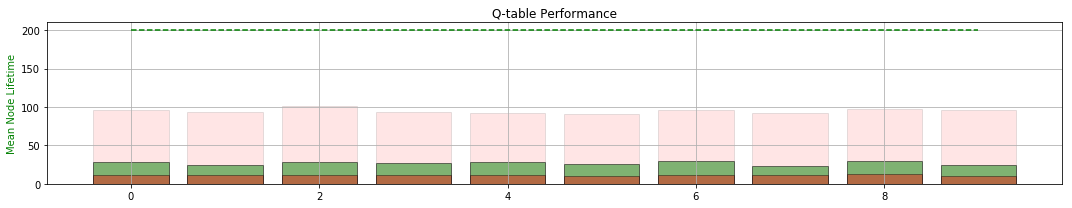

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.810	LOSS : 2.572	LOSS : 3.172	LOSS : 2.676	LOSS : 2.731	LOSS : 2.564	LOSS : 2.708	LOSS : 2.754	LOSS : 2.491	LOSS : 2.461	
Validating... MEAN TIME:  110.0
LOSS : 2.669	LOSS : 2.519	LOSS : 2.721	LOSS : 2.828	LOSS : 2.857	LOSS : 2.351	LOSS : 2.450	LOSS : 2.539	LOSS : 2.771	LOSS : 2.657	
Validating... MEAN TIME:  113.615
LOSS : 2.403	LOSS : 2.903	LOSS : 2.909	LOSS : 2.461	LOSS : 2.510	LOSS : 2.405	LOSS : 2.814	LOSS : 2.856	LOSS : 2.587	LOSS : 2.511	
Validating... MEAN TIME:  112.83
LOSS : 2.595	LOSS : 2.489	LOSS : 2.438	LOSS : 2.867	LOSS : 2.588	LOSS : 2.553	LOSS : 2.516	LOSS : 2.269	LOSS : 2.481	LOSS : 2.439	
Validating... MEAN TIME:  110.68
LOSS : 2.359	LOSS : 2.588	LOSS : 2.176	LOSS : 2.389	LOSS : 2.502	LOSS : 2.535	LOSS : 2.721	LOSS : 2.296	LOSS : 2.448	LOSS : 2.323	
Validating... MEAN TIME:  111.245
TRAINING TIME:0:00:26.581502


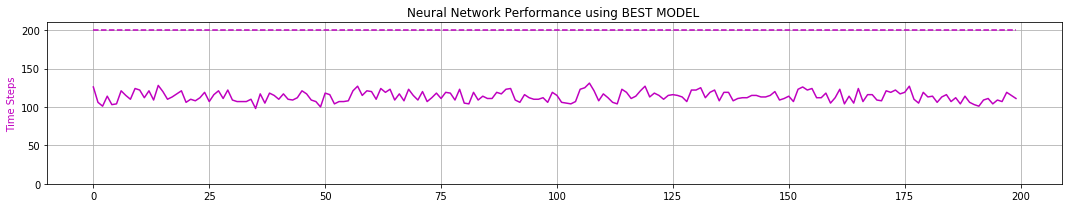

peak memory: 1426.66 MiB, increment: 1035.51 MiB
0 -max- [ 0.198  1.207  0.048  0.519]
0 -min- [-2.387 -3.331 -0.209 -1.678]

1 -max- [ 0.200  1.218  0.050  0.382]
1 -min- [-2.354 -3.150 -0.209 -1.674]

2 -max- [ 0.199  1.186  0.050  0.640]
2 -min- [-2.370 -3.325 -0.209 -1.681]

3 -max- [ 0.211  1.217  0.050  0.382]
3 -min- [-2.382 -3.303 -0.209 -1.663]

4 -max- [ 0.204  1.214  0.048  0.586]
4 -min- [-2.382 -3.319 -0.209 -1.677]

5 -max- [ 0.225  1.209  0.049  0.382]
5 -min- [-2.383 -3.316 -0.209 -1.675]

6 -max- [ 0.192  1.204  0.048  0.580]
6 -min- [-2.390 -3.328 -0.209 -1.677]

7 -max- [ 0.201  1.189  0.049  0.385]
7 -min- [-2.342 -3.142 -0.209 -1.694]

8 -max- [ 0.200  1.203  0.050  0.703]
8 -min- [-2.392 -3.263 -0.209 -1.663]

9 -max- [ 0.207  1.217  0.050  0.389]
9 -min- [-2.393 -3.128 -0.209 -1.800]

Quantization TIME:  0.01 minutes


ITERATION # 97
SMALLEST TIMESTEP in ITERATION 97: 11
REAL TIME TO GENERATE 28545 EXPERIENCES:0:00:00.853248


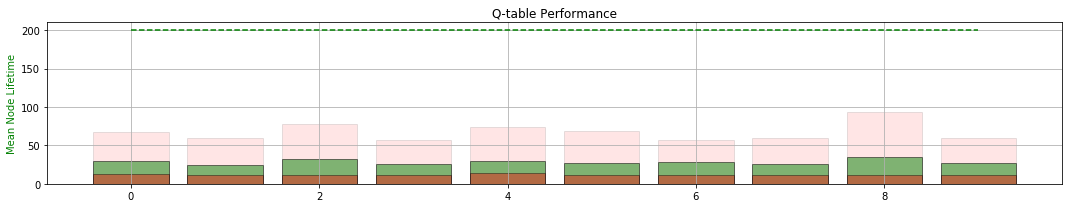

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.741	LOSS : 2.388	LOSS : 2.440	LOSS : 2.384	LOSS : 2.711	LOSS : 2.464	LOSS : 2.517	LOSS : 2.793	LOSS : 2.749	LOSS : 2.620	
Validating... MEAN TIME:  112.72
LOSS : 2.682	LOSS : 2.821	LOSS : 2.717	LOSS : 2.623	LOSS : 2.833	LOSS : 2.411	LOSS : 2.575	LOSS : 2.555	LOSS : 2.296	LOSS : 3.055	
Validating... MEAN TIME:  111.845
LOSS : 2.431	LOSS : 2.756	LOSS : 2.731	LOSS : 2.597	LOSS : 2.523	LOSS : 2.505	LOSS : 2.602	LOSS : 2.485	LOSS : 2.692	LOSS : 2.804	
Validating... MEAN TIME:  109.655
LOSS : 2.744	LOSS : 2.648	LOSS : 2.146	LOSS : 2.785	LOSS : 2.727	LOSS : 2.712	LOSS : 2.270	LOSS : 2.599	LOSS : 2.586	LOSS : 2.426	
Validating... MEAN TIME:  113.6
LOSS : 2.384	LOSS : 2.848	LOSS : 2.629	LOSS : 2.659	LOSS : 2.764	LOSS : 2.664	LOSS : 2.392	LOSS : 2.524	LOSS : 2.682	LOSS : 2.510	
Validating... MEAN TIME:  114.105
TRAINING TIME:0:00:25.917384


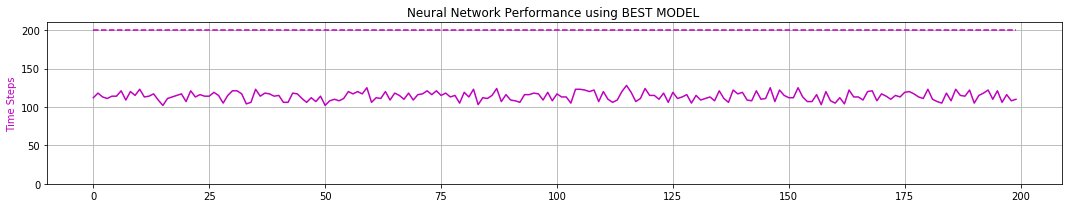

peak memory: 1447.41 MiB, increment: 1017.50 MiB
0 -max- [ 0.198  1.023  0.050  0.492]
0 -min- [-0.880 -1.881 -0.209 -1.375]

1 -max- [ 0.195  0.989  0.050  0.379]
1 -min- [-0.783 -1.985 -0.209 -1.444]

2 -max- [ 0.201  1.197  0.055  0.570]
2 -min- [-1.484 -2.415 -0.209 -1.648]

3 -max- [ 0.200  0.994  0.048  0.376]
3 -min- [-0.648 -1.672 -0.209 -1.477]

4 -max- [ 0.225  1.205  0.057  0.503]
4 -min- [-1.153 -2.341 -0.209 -1.584]

5 -max- [ 0.176  1.125  0.048  0.378]
5 -min- [-1.201 -2.362 -0.209 -1.651]

6 -max- [ 0.192  0.828  0.052  0.517]
6 -min- [-0.547 -1.669 -0.209 -1.204]

7 -max- [ 0.192  0.994  0.050  0.378]
7 -min- [-0.736 -1.839 -0.209 -1.427]

8 -max- [ 0.199  0.977  0.050  0.553]
8 -min- [-2.374 -3.298 -0.209 -1.365]

9 -max- [ 0.209  1.020  0.049  0.378]
9 -min- [-0.689 -1.862 -0.209 -1.357]

Quantization TIME:  0.01 minutes


ITERATION # 98
SMALLEST TIMESTEP in ITERATION 98: 11
REAL TIME TO GENERATE 31426 EXPERIENCES:0:00:00.818039


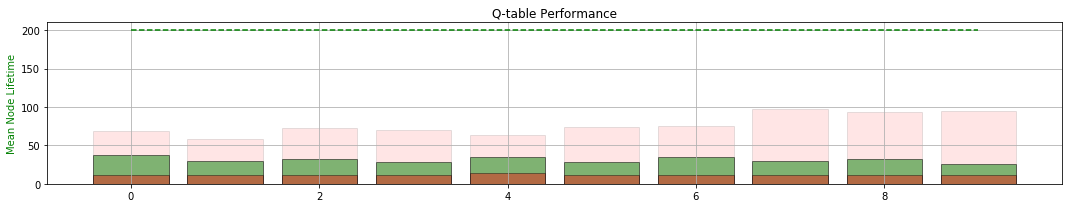

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.539	LOSS : 2.630	LOSS : 2.654	LOSS : 2.505	LOSS : 2.621	LOSS : 2.770	LOSS : 2.789	LOSS : 2.675	LOSS : 2.347	LOSS : 3.100	
Validating... MEAN TIME:  109.41
LOSS : 2.777	LOSS : 2.449	LOSS : 2.626	LOSS : 2.742	LOSS : 2.246	LOSS : 2.619	LOSS : 2.970	LOSS : 2.511	LOSS : 2.676	LOSS : 2.807	
Validating... MEAN TIME:  117.04
LOSS : 2.930	LOSS : 2.329	LOSS : 2.341	LOSS : 2.868	LOSS : 2.571	LOSS : 2.693	LOSS : 2.771	LOSS : 2.806	LOSS : 2.766	LOSS : 2.577	
Validating... MEAN TIME:  112.61
LOSS : 2.694	LOSS : 2.839	LOSS : 2.389	LOSS : 2.565	LOSS : 2.593	LOSS : 2.654	LOSS : 2.426	LOSS : 2.632	LOSS : 2.344	LOSS : 2.418	
Validating... MEAN TIME:  111.635
LOSS : 2.286	LOSS : 2.385	LOSS : 2.571	LOSS : 2.799	LOSS : 2.742	LOSS : 2.745	LOSS : 2.641	LOSS : 2.829	LOSS : 2.341	LOSS : 2.574	
Validating... MEAN TIME:  113.71
TRAINING TIME:0:00:25.915489


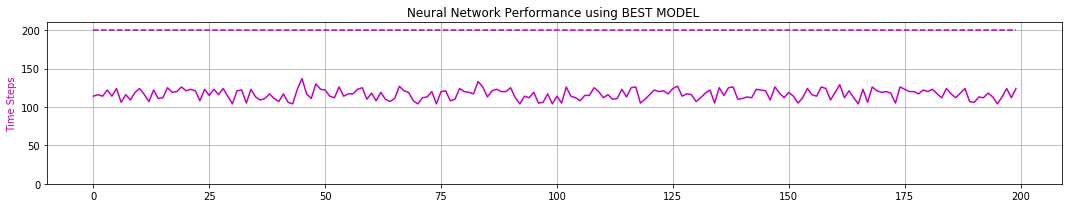

peak memory: 1407.22 MiB, increment: 1017.37 MiB
0 -max- [ 0.191  0.821  0.050  0.601]
0 -min- [-0.820 -2.005 -0.209 -1.190]

1 -max- [ 0.199  1.003  0.050  0.378]
1 -min- [-0.725 -1.833 -0.209 -1.433]

2 -max- [ 0.192  0.971  0.048  0.593]
2 -min- [-1.147 -2.173 -0.209 -1.368]

3 -max- [ 0.204  0.991  0.049  0.378]
3 -min- [-0.780 -1.981 -0.209 -1.388]

4 -max- [ 0.172  0.953  0.050  0.580]
4 -min- [-0.892 -2.052 -0.209 -1.368]

5 -max- [ 0.189  1.009  0.049  0.377]
5 -min- [-1.174 -2.376 -0.209 -1.417]

6 -max- [ 0.188  0.996  0.053  0.830]
6 -min- [-1.213 -2.372 -0.209 -1.364]

7 -max- [ 0.192  1.009  0.050  0.381]
7 -min- [-2.365 -3.320 -0.209 -1.471]

8 -max- [ 0.204  1.020  0.058  0.550]
8 -min- [-2.344 -3.447 -0.209 -1.357]

9 -max- [ 0.183  0.924  0.048  0.377]
9 -min- [-2.345 -3.248 -0.209 -1.361]

Quantization TIME:  0.01 minutes


ITERATION # 99
SMALLEST TIMESTEP in ITERATION 99: 12
REAL TIME TO GENERATE 38637 EXPERIENCES:0:00:01.048355


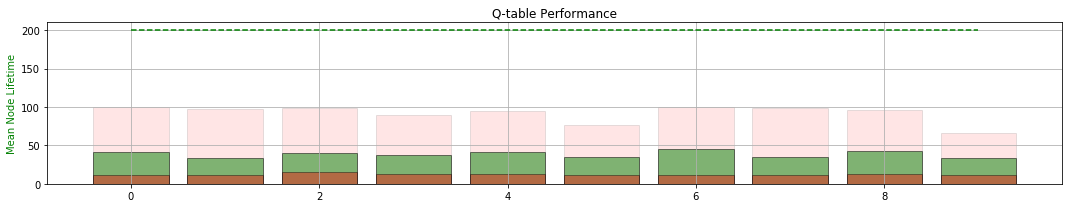

MEMORY COUNTER:  300000
Training Neural Network for 5000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.482	LOSS : 2.780	LOSS : 2.406	LOSS : 2.725	LOSS : 2.482	LOSS : 2.736	LOSS : 2.401	LOSS : 2.672	LOSS : 2.718	LOSS : 2.528	
Validating... MEAN TIME:  115.845
LOSS : 2.468	LOSS : 2.411	LOSS : 2.782	LOSS : 2.252	LOSS : 2.241	LOSS : 2.510	LOSS : 2.703	LOSS : 2.447	LOSS : 2.287	LOSS : 2.779	
Validating... MEAN TIME:  108.27
LOSS : 2.902	LOSS : 2.422	LOSS : 2.504	LOSS : 2.694	LOSS : 2.240	LOSS : 2.683	LOSS : 2.316	LOSS : 2.312	LOSS : 2.728	LOSS : 2.270	
Validating... MEAN TIME:  109.71
LOSS : 2.542	LOSS : 2.552	LOSS : 2.563	LOSS : 2.654	LOSS : 2.726	LOSS : 2.809	LOSS : 2.304	LOSS : 2.599	LOSS : 2.125	LOSS : 2.295	
Validating... MEAN TIME:  111.595
LOSS : 2.518	LOSS : 2.701	LOSS : 2.927	LOSS : 2.474	LOSS : 2.428	LOSS : 2.915	LOSS : 2.370	LOSS : 2.371	LOSS : 2.669	LOSS : 2.635	
Validating... MEAN TIME:  114.0
TRAINING TIME:0:00:25.542758


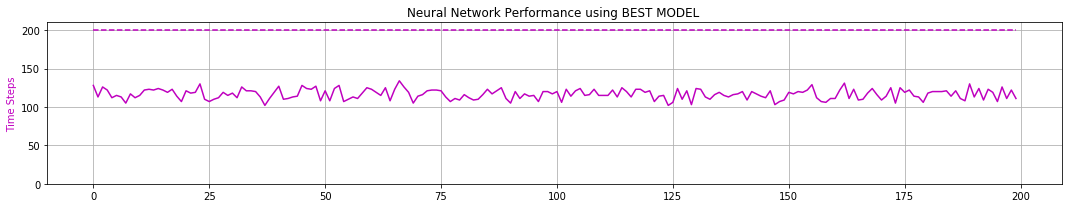

peak memory: 1416.86 MiB, increment: 978.18 MiB
0 -max- [ 0.199  1.003  0.055  0.591]
0 -min- [-2.382 -3.145 -0.209 -1.364]

1 -max- [ 0.184  0.827  0.048  0.384]
1 -min- [-2.398 -3.272 -0.209 -1.408]

2 -max- [ 0.224  0.955  0.056  0.596]
2 -min- [-2.372 -3.092 -0.209 -1.363]

3 -max- [ 0.188  0.955  0.048  0.384]
3 -min- [-2.384 -3.142 -0.209 -1.380]

4 -max- [ 0.186  0.942  0.056  0.596]
4 -min- [-2.395 -3.258 -0.209 -1.328]

5 -max- [ 0.190  0.940  0.050  0.384]
5 -min- [-1.251 -2.373 -0.209 -1.373]

6 -max- [ 0.203  0.977  0.057  0.766]
6 -min- [-2.394 -3.336 -0.209 -1.365]

7 -max- [ 0.201  1.020  0.049  0.386]
7 -min- [-2.376 -3.290 -0.209 -1.383]

8 -max- [ 0.172  0.992  0.048  0.598]
8 -min- [-2.379 -3.259 -0.209 -1.376]

9 -max- [ 0.186  0.830  0.048  0.384]
9 -min- [-0.856 -1.988 -0.209 -1.316]

Quantization TIME:  0.01 minutes


In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  10969.0
Total Serial Timesteps   :  5089009.0
Speed-up                 :  463.94


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  3121 FAILURE  12 100   10969    5089009     463.94
